In [1]:
import gym
from gym import logger
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
logger.set_level(gym.logger.DISABLED)

# CartPole Swing Up Wrapper

In [2]:
class CartPoleSwingUp(gym.Wrapper):
    def __init__(self, env, **kwargs):
        super(CartPoleSwingUp, self).__init__(env, **kwargs)
        self.theta_dot_threshold = 4*np.pi

    def reset(self):
        self.env.env.state = [0, 0, np.pi, 0] + super().reset()
        #self.state = [0,0,np.pi,0] + self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.env.env.steps_beyond_done = None
        return np.array(self.env.env.state)

    def step(self, action):
        state, reward, done, _ = super().step(action)
        #self.state = state
        x, x_dot, theta, theta_dot = state
        theta = (theta+np.pi)%(2*np.pi)-np.pi
        self.env.env.state = [x, x_dot, theta, theta_dot]
        
        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta_dot < -self.theta_dot_threshold \
               or theta_dot > self.theta_dot_threshold
        
        if done:
            # game over
            reward = -10.
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0
            else:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
        else:
            if -self.theta_threshold_radians < theta and theta < self.theta_threshold_radians:
                # pole upright
                reward = 1.
            else:
                # pole swinging
                reward = 0.

        return np.array([x, x_dot, theta, theta_dot]), reward, done, {}

In [3]:
swingup = CartPoleSwingUp(gym.make('CartPole-v1'))

## Define Network

In [4]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = swingup.observation_space.shape[0]
action_size = swingup.action_space.n 
class Model(torch.nn.Module):
    def __init__(self, input_size, action_size):
        super(Model, self).__init__()
        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 4),
            torch.nn.ReLU()
        )

        self.critic = torch.nn.Linear(4, 1)

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(4, action_size),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.hidden_layers(x)
        value = self.critic(x)
        actions = self.actor(x)
        return value, actions

    def get_critic(self, x):
        x = self.hidden_layers(x)
        return self.critic(x)

    def evaluate_action(self, state, action):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        log_probs = dist.log_prob(action).view(-1, 1)
        entropy = dist.entropy().mean()

        return value, log_probs, entropy

    def act(self, state):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        chosen_action = dist.sample()
        return chosen_action.item()

In [5]:
def compute_true_values(states, rewards, dones,model,GAMMA):
    values = []
    states = torch.stack(states)
    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    if dones[-1]:
        next_value = rewards[-1]
    else:
        next_value = model.get_critic(states[-1].unsqueeze(0))

    # Compute the sum of \gamma**t r_t
    values.append(next_value)
    for i in reversed(range(0, len(rewards) - 1)):
        if not dones[i]:
            next_value = rewards[i] + next_value * GAMMA
        else:
            next_value = rewards[i]
        values.append(next_value)

    values.reverse()

    return torch.FloatTensor(values)


# A2C Class

In [6]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy

class actor_critic:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        
        self.ENTROPY_COEF_max = config['ENTROPY_COEF_max']
        self.ENTROPY_COEF_min = config['ENTROPY_COEF_min']
        self.ENTROPY_COEF_stop = config['ENTROPY_COEF_stop']
        self.ENTROPY_COEF_delay = config['ENTROPY_COEF_delay']
        self.ENTROPY_COEF_step = (self.ENTROPY_COEF_max-self.ENTROPY_COEF_min
                                 )/self.ENTROPY_COEF_stop
        self.CRITIC_COEF = config['CRITIC_COEF']
        
        
        self.total_steps = 0
        self.model = model 

        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=config['learning_rate']
                                             ,eps=1e-5)
    
    def gradient_step(self,states, actions, true_values,CRITIC_COEF,ENTROPY_COEF):
        
        states = torch.stack(states)
        actions = torch.LongTensor(actions)
        true_values = torch.FloatTensor(true_values)

        values, log_probs, entropy = self.model.evaluate_action(states, actions)

        advantages = true_values - values
        critic_loss = advantages.pow(2).mean()

        actor_loss = -(log_probs * advantages.detach()).mean()
        total_loss = (CRITIC_COEF * critic_loss) + actor_loss - (ENTROPY_COEF * entropy)

        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        return values.mean().item()
    
    def train(self, env, max_episode,print_=False):
        episode_rewards = []
        episode_reward = 0
        state = torch.FloatTensor(env.reset())
        ENTROPY_COEF = self.ENTROPY_COEF_max
        current_episode = 0
        step = 0
        state = torch.FloatTensor(env.reset())
        while current_episode < max_episode:
            step+=1
            done = False

            states = []
            actions = []
            rewards = []
            dones = []
            # update epsilon
            if step > self.ENTROPY_COEF_delay:
                ENTROPY_COEF = max(self.ENTROPY_COEF_min, 
                                   ENTROPY_COEF-self.ENTROPY_COEF_step)

            for _ in range(self.batch_size):
                action = self.model.act(state.unsqueeze(0))
                next_state, reward, done, _ = env.step(action)
                
                if print_ ==True:
                    env.render()

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)

                episode_reward += reward
                

                if done:
                    print("Episode ", current_episode, ", reward : ", episode_reward)
                    state = torch.FloatTensor(env.reset())

                    
                    
                    episode_rewards.append(episode_reward)
                    episode_reward = 0
                    current_episode += 1

                else:
                    state = torch.FloatTensor(next_state)

            # Compute the true values for the update
            values = compute_true_values(states, rewards, dones,self.model,self.gamma)

            # Train
            z = self.gradient_step(states, actions, values,self.CRITIC_COEF,ENTROPY_COEF)


        return episode_rewards

In [8]:
sw_model = Model(input_size,action_size)
config = {'gamma' : 0.95,
          'learning_rate' : 0.001,
          'batch_size' : 64,
          'nb_actions' : 2,
          'ENTROPY_COEF_max' : 3,
          'ENTROPY_COEF_min'     : 0.1,
          'ENTROPY_COEF_delay'  : 300,
          'ENTROPY_COEF_stop' :50000,
          'CRITIC_COEF' :0.5
          
         }
a2c = actor_critic(config,sw_model)
rewards = a2c.train(swingup,100000)

Episode  0 , reward :  -10.0
Episode  1 , reward :  -10.0
Episode  2 , reward :  -10.0
Episode  3 , reward :  -10.0
Episode  4 , reward :  -10.0
Episode  5 , reward :  -10.0
Episode  6 , reward :  -10.0
Episode  7 , reward :  -10.0
Episode  8 , reward :  -10.0
Episode  9 , reward :  -10.0
Episode  10 , reward :  -10.0
Episode  11 , reward :  -10.0
Episode  12 , reward :  -10.0
Episode  13 , reward :  -10.0
Episode  14 , reward :  -10.0
Episode  15 , reward :  -10.0
Episode  16 , reward :  -10.0
Episode  17 , reward :  -10.0
Episode  18 , reward :  -10.0
Episode  19 , reward :  -10.0
Episode  20 , reward :  -10.0
Episode  21 , reward :  -10.0
Episode  22 , reward :  -10.0
Episode  23 , reward :  -10.0
Episode  24 , reward :  -10.0
Episode  25 , reward :  -10.0
Episode  26 , reward :  -10.0
Episode  27 , reward :  -10.0
Episode  28 , reward :  -10.0
Episode  29 , reward :  -10.0
Episode  30 , reward :  -10.0
Episode  31 , reward :  -10.0
Episode  32 , reward :  -10.0
Episode  33 , reward

Episode  269 , reward :  -10.0
Episode  270 , reward :  -10.0
Episode  271 , reward :  -10.0
Episode  272 , reward :  -10.0
Episode  273 , reward :  -10.0
Episode  274 , reward :  -10.0
Episode  275 , reward :  -10.0
Episode  276 , reward :  -10.0
Episode  277 , reward :  -10.0
Episode  278 , reward :  -10.0
Episode  279 , reward :  -10.0
Episode  280 , reward :  -10.0
Episode  281 , reward :  -10.0
Episode  282 , reward :  -10.0
Episode  283 , reward :  -10.0
Episode  284 , reward :  -10.0
Episode  285 , reward :  -10.0
Episode  286 , reward :  -10.0
Episode  287 , reward :  -10.0
Episode  288 , reward :  -10.0
Episode  289 , reward :  -10.0
Episode  290 , reward :  -10.0
Episode  291 , reward :  -10.0
Episode  292 , reward :  -10.0
Episode  293 , reward :  -10.0
Episode  294 , reward :  -3.0
Episode  295 , reward :  -3.0
Episode  296 , reward :  -10.0
Episode  297 , reward :  -10.0
Episode  298 , reward :  17.0
Episode  299 , reward :  -10.0
Episode  300 , reward :  -10.0
Episode  30

Episode  534 , reward :  -10.0
Episode  535 , reward :  -10.0
Episode  536 , reward :  -10.0
Episode  537 , reward :  -10.0
Episode  538 , reward :  -10.0
Episode  539 , reward :  -10.0
Episode  540 , reward :  -10.0
Episode  541 , reward :  -10.0
Episode  542 , reward :  -10.0
Episode  543 , reward :  -10.0
Episode  544 , reward :  -10.0
Episode  545 , reward :  -10.0
Episode  546 , reward :  -10.0
Episode  547 , reward :  -10.0
Episode  548 , reward :  -10.0
Episode  549 , reward :  -10.0
Episode  550 , reward :  -10.0
Episode  551 , reward :  -10.0
Episode  552 , reward :  -10.0
Episode  553 , reward :  -10.0
Episode  554 , reward :  -10.0
Episode  555 , reward :  -10.0
Episode  556 , reward :  -10.0
Episode  557 , reward :  -10.0
Episode  558 , reward :  -10.0
Episode  559 , reward :  -10.0
Episode  560 , reward :  -10.0
Episode  561 , reward :  -10.0
Episode  562 , reward :  -10.0
Episode  563 , reward :  -10.0
Episode  564 , reward :  -10.0
Episode  565 , reward :  -10.0
Episode 

Episode  800 , reward :  -10.0
Episode  801 , reward :  -10.0
Episode  802 , reward :  -10.0
Episode  803 , reward :  -10.0
Episode  804 , reward :  -10.0
Episode  805 , reward :  -10.0
Episode  806 , reward :  -10.0
Episode  807 , reward :  -10.0
Episode  808 , reward :  -10.0
Episode  809 , reward :  -10.0
Episode  810 , reward :  -10.0
Episode  811 , reward :  -10.0
Episode  812 , reward :  -10.0
Episode  813 , reward :  -10.0
Episode  814 , reward :  -10.0
Episode  815 , reward :  -10.0
Episode  816 , reward :  -10.0
Episode  817 , reward :  -10.0
Episode  818 , reward :  -10.0
Episode  819 , reward :  -10.0
Episode  820 , reward :  -10.0
Episode  821 , reward :  -10.0
Episode  822 , reward :  -10.0
Episode  823 , reward :  -10.0
Episode  824 , reward :  -10.0
Episode  825 , reward :  -10.0
Episode  826 , reward :  -10.0
Episode  827 , reward :  -10.0
Episode  828 , reward :  -10.0
Episode  829 , reward :  -10.0
Episode  830 , reward :  -10.0
Episode  831 , reward :  -10.0
Episode 

Episode  1063 , reward :  -10.0
Episode  1064 , reward :  -10.0
Episode  1065 , reward :  -10.0
Episode  1066 , reward :  -10.0
Episode  1067 , reward :  -10.0
Episode  1068 , reward :  -10.0
Episode  1069 , reward :  -10.0
Episode  1070 , reward :  -10.0
Episode  1071 , reward :  -10.0
Episode  1072 , reward :  -10.0
Episode  1073 , reward :  -10.0
Episode  1074 , reward :  -10.0
Episode  1075 , reward :  -10.0
Episode  1076 , reward :  -10.0
Episode  1077 , reward :  -10.0
Episode  1078 , reward :  -10.0
Episode  1079 , reward :  -10.0
Episode  1080 , reward :  -10.0
Episode  1081 , reward :  -10.0
Episode  1082 , reward :  -2.0
Episode  1083 , reward :  -10.0
Episode  1084 , reward :  -10.0
Episode  1085 , reward :  2.0
Episode  1086 , reward :  -10.0
Episode  1087 , reward :  -10.0
Episode  1088 , reward :  -10.0
Episode  1089 , reward :  -10.0
Episode  1090 , reward :  -10.0
Episode  1091 , reward :  0.0
Episode  1092 , reward :  -10.0
Episode  1093 , reward :  -10.0
Episode  1094

Episode  1321 , reward :  -1.0
Episode  1322 , reward :  -10.0
Episode  1323 , reward :  -10.0
Episode  1324 , reward :  -10.0
Episode  1325 , reward :  -10.0
Episode  1326 , reward :  -10.0
Episode  1327 , reward :  -10.0
Episode  1328 , reward :  -10.0
Episode  1329 , reward :  -10.0
Episode  1330 , reward :  -10.0
Episode  1331 , reward :  -10.0
Episode  1332 , reward :  -10.0
Episode  1333 , reward :  -10.0
Episode  1334 , reward :  -10.0
Episode  1335 , reward :  -10.0
Episode  1336 , reward :  -10.0
Episode  1337 , reward :  -10.0
Episode  1338 , reward :  -10.0
Episode  1339 , reward :  -10.0
Episode  1340 , reward :  -10.0
Episode  1341 , reward :  -10.0
Episode  1342 , reward :  -10.0
Episode  1343 , reward :  -10.0
Episode  1344 , reward :  -10.0
Episode  1345 , reward :  -10.0
Episode  1346 , reward :  -10.0
Episode  1347 , reward :  -10.0
Episode  1348 , reward :  -10.0
Episode  1349 , reward :  -10.0
Episode  1350 , reward :  -10.0
Episode  1351 , reward :  -10.0
Episode  

Episode  1578 , reward :  -10.0
Episode  1579 , reward :  -10.0
Episode  1580 , reward :  -10.0
Episode  1581 , reward :  -10.0
Episode  1582 , reward :  -10.0
Episode  1583 , reward :  -10.0
Episode  1584 , reward :  5.0
Episode  1585 , reward :  -10.0
Episode  1586 , reward :  -10.0
Episode  1587 , reward :  -10.0
Episode  1588 , reward :  -10.0
Episode  1589 , reward :  8.0
Episode  1590 , reward :  -10.0
Episode  1591 , reward :  -10.0
Episode  1592 , reward :  -10.0
Episode  1593 , reward :  -10.0
Episode  1594 , reward :  -10.0
Episode  1595 , reward :  -10.0
Episode  1596 , reward :  -10.0
Episode  1597 , reward :  -10.0
Episode  1598 , reward :  -10.0
Episode  1599 , reward :  -10.0
Episode  1600 , reward :  -10.0
Episode  1601 , reward :  -10.0
Episode  1602 , reward :  -10.0
Episode  1603 , reward :  -10.0
Episode  1604 , reward :  -10.0
Episode  1605 , reward :  -10.0
Episode  1606 , reward :  -10.0
Episode  1607 , reward :  -10.0
Episode  1608 , reward :  -10.0
Episode  160

Episode  1835 , reward :  -10.0
Episode  1836 , reward :  -10.0
Episode  1837 , reward :  1.0
Episode  1838 , reward :  -10.0
Episode  1839 , reward :  -1.0
Episode  1840 , reward :  -10.0
Episode  1841 , reward :  -10.0
Episode  1842 , reward :  -10.0
Episode  1843 , reward :  -10.0
Episode  1844 , reward :  -10.0
Episode  1845 , reward :  -2.0
Episode  1846 , reward :  -10.0
Episode  1847 , reward :  -10.0
Episode  1848 , reward :  -10.0
Episode  1849 , reward :  -10.0
Episode  1850 , reward :  -10.0
Episode  1851 , reward :  -10.0
Episode  1852 , reward :  -10.0
Episode  1853 , reward :  -10.0
Episode  1854 , reward :  -10.0
Episode  1855 , reward :  -10.0
Episode  1856 , reward :  -4.0
Episode  1857 , reward :  -10.0
Episode  1858 , reward :  -10.0
Episode  1859 , reward :  -10.0
Episode  1860 , reward :  -10.0
Episode  1861 , reward :  -10.0
Episode  1862 , reward :  -10.0
Episode  1863 , reward :  -10.0
Episode  1864 , reward :  -10.0
Episode  1865 , reward :  -10.0
Episode  1866

Episode  2092 , reward :  0.0
Episode  2093 , reward :  -10.0
Episode  2094 , reward :  -10.0
Episode  2095 , reward :  -10.0
Episode  2096 , reward :  -10.0
Episode  2097 , reward :  -10.0
Episode  2098 , reward :  -10.0
Episode  2099 , reward :  -10.0
Episode  2100 , reward :  -10.0
Episode  2101 , reward :  -10.0
Episode  2102 , reward :  21.0
Episode  2103 , reward :  -10.0
Episode  2104 , reward :  -10.0
Episode  2105 , reward :  -10.0
Episode  2106 , reward :  -10.0
Episode  2107 , reward :  -10.0
Episode  2108 , reward :  -10.0
Episode  2109 , reward :  -10.0
Episode  2110 , reward :  -10.0
Episode  2111 , reward :  -10.0
Episode  2112 , reward :  -10.0
Episode  2113 , reward :  -10.0
Episode  2114 , reward :  -10.0
Episode  2115 , reward :  -10.0
Episode  2116 , reward :  -10.0
Episode  2117 , reward :  -10.0
Episode  2118 , reward :  -10.0
Episode  2119 , reward :  -10.0
Episode  2120 , reward :  -10.0
Episode  2121 , reward :  -10.0
Episode  2122 , reward :  -10.0
Episode  21

Episode  2349 , reward :  -10.0
Episode  2350 , reward :  -10.0
Episode  2351 , reward :  -10.0
Episode  2352 , reward :  7.0
Episode  2353 , reward :  6.0
Episode  2354 , reward :  -10.0
Episode  2355 , reward :  -10.0
Episode  2356 , reward :  -10.0
Episode  2357 , reward :  -10.0
Episode  2358 , reward :  -10.0
Episode  2359 , reward :  15.0
Episode  2360 , reward :  -10.0
Episode  2361 , reward :  -10.0
Episode  2362 , reward :  -10.0
Episode  2363 , reward :  -10.0
Episode  2364 , reward :  -10.0
Episode  2365 , reward :  -3.0
Episode  2366 , reward :  -10.0
Episode  2367 , reward :  -10.0
Episode  2368 , reward :  -10.0
Episode  2369 , reward :  -10.0
Episode  2370 , reward :  -10.0
Episode  2371 , reward :  10.0
Episode  2372 , reward :  -4.0
Episode  2373 , reward :  -10.0
Episode  2374 , reward :  -10.0
Episode  2375 , reward :  -10.0
Episode  2376 , reward :  -10.0
Episode  2377 , reward :  -10.0
Episode  2378 , reward :  -10.0
Episode  2379 , reward :  -10.0
Episode  2380 , 

Episode  2608 , reward :  -10.0
Episode  2609 , reward :  -10.0
Episode  2610 , reward :  -10.0
Episode  2611 , reward :  -10.0
Episode  2612 , reward :  -10.0
Episode  2613 , reward :  -10.0
Episode  2614 , reward :  -10.0
Episode  2615 , reward :  -10.0
Episode  2616 , reward :  -10.0
Episode  2617 , reward :  -10.0
Episode  2618 , reward :  -5.0
Episode  2619 , reward :  -10.0
Episode  2620 , reward :  -10.0
Episode  2621 , reward :  -10.0
Episode  2622 , reward :  -10.0
Episode  2623 , reward :  -10.0
Episode  2624 , reward :  -10.0
Episode  2625 , reward :  -10.0
Episode  2626 , reward :  -10.0
Episode  2627 , reward :  -10.0
Episode  2628 , reward :  -10.0
Episode  2629 , reward :  4.0
Episode  2630 , reward :  -10.0
Episode  2631 , reward :  -10.0
Episode  2632 , reward :  -10.0
Episode  2633 , reward :  -10.0
Episode  2634 , reward :  -10.0
Episode  2635 , reward :  -10.0
Episode  2636 , reward :  -10.0
Episode  2637 , reward :  -10.0
Episode  2638 , reward :  -10.0
Episode  26

Episode  2865 , reward :  -10.0
Episode  2866 , reward :  -10.0
Episode  2867 , reward :  -10.0
Episode  2868 , reward :  -10.0
Episode  2869 , reward :  -10.0
Episode  2870 , reward :  -10.0
Episode  2871 , reward :  -10.0
Episode  2872 , reward :  -10.0
Episode  2873 , reward :  -10.0
Episode  2874 , reward :  -10.0
Episode  2875 , reward :  -10.0
Episode  2876 , reward :  -10.0
Episode  2877 , reward :  -10.0
Episode  2878 , reward :  -10.0
Episode  2879 , reward :  -10.0
Episode  2880 , reward :  -10.0
Episode  2881 , reward :  -10.0
Episode  2882 , reward :  -10.0
Episode  2883 , reward :  -10.0
Episode  2884 , reward :  -10.0
Episode  2885 , reward :  -10.0
Episode  2886 , reward :  -10.0
Episode  2887 , reward :  -10.0
Episode  2888 , reward :  -10.0
Episode  2889 , reward :  -10.0
Episode  2890 , reward :  -10.0
Episode  2891 , reward :  -10.0
Episode  2892 , reward :  -10.0
Episode  2893 , reward :  -10.0
Episode  2894 , reward :  -10.0
Episode  2895 , reward :  -10.0
Episode 

Episode  3123 , reward :  -10.0
Episode  3124 , reward :  -10.0
Episode  3125 , reward :  -10.0
Episode  3126 , reward :  -10.0
Episode  3127 , reward :  -10.0
Episode  3128 , reward :  5.0
Episode  3129 , reward :  21.0
Episode  3130 , reward :  -10.0
Episode  3131 , reward :  -10.0
Episode  3132 , reward :  -10.0
Episode  3133 , reward :  -10.0
Episode  3134 , reward :  -10.0
Episode  3135 , reward :  -10.0
Episode  3136 , reward :  8.0
Episode  3137 , reward :  -10.0
Episode  3138 , reward :  -10.0
Episode  3139 , reward :  -10.0
Episode  3140 , reward :  7.0
Episode  3141 , reward :  -10.0
Episode  3142 , reward :  -10.0
Episode  3143 , reward :  -10.0
Episode  3144 , reward :  -10.0
Episode  3145 , reward :  -10.0
Episode  3146 , reward :  -10.0
Episode  3147 , reward :  -10.0
Episode  3148 , reward :  -10.0
Episode  3149 , reward :  -10.0
Episode  3150 , reward :  -10.0
Episode  3151 , reward :  -10.0
Episode  3152 , reward :  -10.0
Episode  3153 , reward :  -10.0
Episode  3154 ,

Episode  3380 , reward :  -10.0
Episode  3381 , reward :  -10.0
Episode  3382 , reward :  -10.0
Episode  3383 , reward :  -10.0
Episode  3384 , reward :  -10.0
Episode  3385 , reward :  -10.0
Episode  3386 , reward :  -10.0
Episode  3387 , reward :  -10.0
Episode  3388 , reward :  -10.0
Episode  3389 , reward :  -10.0
Episode  3390 , reward :  -10.0
Episode  3391 , reward :  -7.0
Episode  3392 , reward :  -10.0
Episode  3393 , reward :  -10.0
Episode  3394 , reward :  -10.0
Episode  3395 , reward :  -10.0
Episode  3396 , reward :  -10.0
Episode  3397 , reward :  -10.0
Episode  3398 , reward :  -10.0
Episode  3399 , reward :  -10.0
Episode  3400 , reward :  -10.0
Episode  3401 , reward :  -4.0
Episode  3402 , reward :  -10.0
Episode  3403 , reward :  -10.0
Episode  3404 , reward :  -10.0
Episode  3405 , reward :  -10.0
Episode  3406 , reward :  -10.0
Episode  3407 , reward :  -10.0
Episode  3408 , reward :  -10.0
Episode  3409 , reward :  -2.0
Episode  3410 , reward :  -10.0
Episode  34

Episode  3638 , reward :  -10.0
Episode  3639 , reward :  -10.0
Episode  3640 , reward :  -10.0
Episode  3641 , reward :  -10.0
Episode  3642 , reward :  -10.0
Episode  3643 , reward :  -10.0
Episode  3644 , reward :  -10.0
Episode  3645 , reward :  -10.0
Episode  3646 , reward :  -10.0
Episode  3647 , reward :  -10.0
Episode  3648 , reward :  -10.0
Episode  3649 , reward :  -10.0
Episode  3650 , reward :  -10.0
Episode  3651 , reward :  -10.0
Episode  3652 , reward :  -10.0
Episode  3653 , reward :  -10.0
Episode  3654 , reward :  -10.0
Episode  3655 , reward :  -10.0
Episode  3656 , reward :  -10.0
Episode  3657 , reward :  4.0
Episode  3658 , reward :  -10.0
Episode  3659 , reward :  -10.0
Episode  3660 , reward :  -10.0
Episode  3661 , reward :  -10.0
Episode  3662 , reward :  -10.0
Episode  3663 , reward :  -10.0
Episode  3664 , reward :  -10.0
Episode  3665 , reward :  -10.0
Episode  3666 , reward :  -10.0
Episode  3667 , reward :  -10.0
Episode  3668 , reward :  -10.0
Episode  3

Episode  3895 , reward :  -10.0
Episode  3896 , reward :  -10.0
Episode  3897 , reward :  -10.0
Episode  3898 , reward :  -10.0
Episode  3899 , reward :  -10.0
Episode  3900 , reward :  -10.0
Episode  3901 , reward :  -10.0
Episode  3902 , reward :  -10.0
Episode  3903 , reward :  -10.0
Episode  3904 , reward :  -10.0
Episode  3905 , reward :  -10.0
Episode  3906 , reward :  -10.0
Episode  3907 , reward :  -10.0
Episode  3908 , reward :  -10.0
Episode  3909 , reward :  -10.0
Episode  3910 , reward :  -10.0
Episode  3911 , reward :  -10.0
Episode  3912 , reward :  -10.0
Episode  3913 , reward :  -10.0
Episode  3914 , reward :  -10.0
Episode  3915 , reward :  -10.0
Episode  3916 , reward :  -10.0
Episode  3917 , reward :  -10.0
Episode  3918 , reward :  -10.0
Episode  3919 , reward :  -10.0
Episode  3920 , reward :  -10.0
Episode  3921 , reward :  -10.0
Episode  3922 , reward :  -10.0
Episode  3923 , reward :  -10.0
Episode  3924 , reward :  -10.0
Episode  3925 , reward :  -10.0
Episode 

Episode  4153 , reward :  -10.0
Episode  4154 , reward :  -10.0
Episode  4155 , reward :  -10.0
Episode  4156 , reward :  -10.0
Episode  4157 , reward :  -10.0
Episode  4158 , reward :  -10.0
Episode  4159 , reward :  -10.0
Episode  4160 , reward :  -10.0
Episode  4161 , reward :  -10.0
Episode  4162 , reward :  -10.0
Episode  4163 , reward :  -10.0
Episode  4164 , reward :  -10.0
Episode  4165 , reward :  -10.0
Episode  4166 , reward :  -10.0
Episode  4167 , reward :  -10.0
Episode  4168 , reward :  -10.0
Episode  4169 , reward :  -10.0
Episode  4170 , reward :  -10.0
Episode  4171 , reward :  -10.0
Episode  4172 , reward :  -10.0
Episode  4173 , reward :  -10.0
Episode  4174 , reward :  -10.0
Episode  4175 , reward :  -10.0
Episode  4176 , reward :  -10.0
Episode  4177 , reward :  -10.0
Episode  4178 , reward :  -10.0
Episode  4179 , reward :  -10.0
Episode  4180 , reward :  -10.0
Episode  4181 , reward :  -10.0
Episode  4182 , reward :  -10.0
Episode  4183 , reward :  -10.0
Episode 

Episode  4411 , reward :  -10.0
Episode  4412 , reward :  -10.0
Episode  4413 , reward :  -3.0
Episode  4414 , reward :  -10.0
Episode  4415 , reward :  -10.0
Episode  4416 , reward :  -10.0
Episode  4417 , reward :  -10.0
Episode  4418 , reward :  -10.0
Episode  4419 , reward :  -10.0
Episode  4420 , reward :  -1.0
Episode  4421 , reward :  37.0
Episode  4422 , reward :  -10.0
Episode  4423 , reward :  -10.0
Episode  4424 , reward :  -10.0
Episode  4425 , reward :  -10.0
Episode  4426 , reward :  -10.0
Episode  4427 , reward :  -10.0
Episode  4428 , reward :  -10.0
Episode  4429 , reward :  -10.0
Episode  4430 , reward :  -10.0
Episode  4431 , reward :  -10.0
Episode  4432 , reward :  -10.0
Episode  4433 , reward :  -10.0
Episode  4434 , reward :  -10.0
Episode  4435 , reward :  -10.0
Episode  4436 , reward :  -10.0
Episode  4437 , reward :  -10.0
Episode  4438 , reward :  -10.0
Episode  4439 , reward :  -10.0
Episode  4440 , reward :  12.0
Episode  4441 , reward :  -10.0
Episode  444

Episode  4669 , reward :  -10.0
Episode  4670 , reward :  -10.0
Episode  4671 , reward :  -10.0
Episode  4672 , reward :  -10.0
Episode  4673 , reward :  -10.0
Episode  4674 , reward :  -10.0
Episode  4675 , reward :  -10.0
Episode  4676 , reward :  -10.0
Episode  4677 , reward :  -10.0
Episode  4678 , reward :  -10.0
Episode  4679 , reward :  -10.0
Episode  4680 , reward :  -10.0
Episode  4681 , reward :  -10.0
Episode  4682 , reward :  -10.0
Episode  4683 , reward :  -10.0
Episode  4684 , reward :  -10.0
Episode  4685 , reward :  5.0
Episode  4686 , reward :  -10.0
Episode  4687 , reward :  -10.0
Episode  4688 , reward :  -10.0
Episode  4689 , reward :  -10.0
Episode  4690 , reward :  -10.0
Episode  4691 , reward :  0.0
Episode  4692 , reward :  42.0
Episode  4693 , reward :  -10.0
Episode  4694 , reward :  -10.0
Episode  4695 , reward :  -10.0
Episode  4696 , reward :  -10.0
Episode  4697 , reward :  -10.0
Episode  4698 , reward :  -10.0
Episode  4699 , reward :  -10.0
Episode  4700

Episode  4926 , reward :  -10.0
Episode  4927 , reward :  -10.0
Episode  4928 , reward :  -10.0
Episode  4929 , reward :  -10.0
Episode  4930 , reward :  -10.0
Episode  4931 , reward :  -10.0
Episode  4932 , reward :  -10.0
Episode  4933 , reward :  -5.0
Episode  4934 , reward :  -10.0
Episode  4935 , reward :  -10.0
Episode  4936 , reward :  -10.0
Episode  4937 , reward :  -10.0
Episode  4938 , reward :  -10.0
Episode  4939 , reward :  5.0
Episode  4940 , reward :  -10.0
Episode  4941 , reward :  -10.0
Episode  4942 , reward :  -10.0
Episode  4943 , reward :  -10.0
Episode  4944 , reward :  -10.0
Episode  4945 , reward :  -10.0
Episode  4946 , reward :  -10.0
Episode  4947 , reward :  -10.0
Episode  4948 , reward :  -10.0
Episode  4949 , reward :  -10.0
Episode  4950 , reward :  -10.0
Episode  4951 , reward :  -10.0
Episode  4952 , reward :  -4.0
Episode  4953 , reward :  -10.0
Episode  4954 , reward :  -10.0
Episode  4955 , reward :  -10.0
Episode  4956 , reward :  -10.0
Episode  495

Episode  5184 , reward :  -10.0
Episode  5185 , reward :  -10.0
Episode  5186 , reward :  -10.0
Episode  5187 , reward :  -10.0
Episode  5188 , reward :  -10.0
Episode  5189 , reward :  -10.0
Episode  5190 , reward :  -10.0
Episode  5191 , reward :  -10.0
Episode  5192 , reward :  15.0
Episode  5193 , reward :  -5.0
Episode  5194 , reward :  -10.0
Episode  5195 , reward :  -10.0
Episode  5196 , reward :  -10.0
Episode  5197 , reward :  -10.0
Episode  5198 , reward :  -10.0
Episode  5199 , reward :  -10.0
Episode  5200 , reward :  -10.0
Episode  5201 , reward :  -10.0
Episode  5202 , reward :  -10.0
Episode  5203 , reward :  -10.0
Episode  5204 , reward :  -10.0
Episode  5205 , reward :  -10.0
Episode  5206 , reward :  -10.0
Episode  5207 , reward :  -10.0
Episode  5208 , reward :  -10.0
Episode  5209 , reward :  -10.0
Episode  5210 , reward :  -10.0
Episode  5211 , reward :  -10.0
Episode  5212 , reward :  -10.0
Episode  5213 , reward :  -10.0
Episode  5214 , reward :  -10.0
Episode  5

Episode  5441 , reward :  -10.0
Episode  5442 , reward :  -10.0
Episode  5443 , reward :  -10.0
Episode  5444 , reward :  -10.0
Episode  5445 , reward :  -10.0
Episode  5446 , reward :  -10.0
Episode  5447 , reward :  -10.0
Episode  5448 , reward :  -10.0
Episode  5449 , reward :  -10.0
Episode  5450 , reward :  -10.0
Episode  5451 , reward :  -10.0
Episode  5452 , reward :  -10.0
Episode  5453 , reward :  -10.0
Episode  5454 , reward :  -10.0
Episode  5455 , reward :  -10.0
Episode  5456 , reward :  -10.0
Episode  5457 , reward :  -10.0
Episode  5458 , reward :  -10.0
Episode  5459 , reward :  -10.0
Episode  5460 , reward :  -10.0
Episode  5461 , reward :  -10.0
Episode  5462 , reward :  -10.0
Episode  5463 , reward :  -4.0
Episode  5464 , reward :  -10.0
Episode  5465 , reward :  -10.0
Episode  5466 , reward :  -1.0
Episode  5467 , reward :  -10.0
Episode  5468 , reward :  -10.0
Episode  5469 , reward :  -10.0
Episode  5470 , reward :  -10.0
Episode  5471 , reward :  -10.0
Episode  5

Episode  5700 , reward :  -10.0
Episode  5701 , reward :  -10.0
Episode  5702 , reward :  -10.0
Episode  5703 , reward :  -10.0
Episode  5704 , reward :  -10.0
Episode  5705 , reward :  -10.0
Episode  5706 , reward :  -10.0
Episode  5707 , reward :  -10.0
Episode  5708 , reward :  -10.0
Episode  5709 , reward :  -10.0
Episode  5710 , reward :  -10.0
Episode  5711 , reward :  -10.0
Episode  5712 , reward :  -10.0
Episode  5713 , reward :  -10.0
Episode  5714 , reward :  -3.0
Episode  5715 , reward :  -10.0
Episode  5716 , reward :  -10.0
Episode  5717 , reward :  -10.0
Episode  5718 , reward :  -10.0
Episode  5719 , reward :  -10.0
Episode  5720 , reward :  -10.0
Episode  5721 , reward :  -10.0
Episode  5722 , reward :  -10.0
Episode  5723 , reward :  -10.0
Episode  5724 , reward :  -10.0
Episode  5725 , reward :  -10.0
Episode  5726 , reward :  -10.0
Episode  5727 , reward :  -10.0
Episode  5728 , reward :  -10.0
Episode  5729 , reward :  -10.0
Episode  5730 , reward :  -10.0
Episode  

Episode  5958 , reward :  -10.0
Episode  5959 , reward :  -10.0
Episode  5960 , reward :  -10.0
Episode  5961 , reward :  -10.0
Episode  5962 , reward :  -10.0
Episode  5963 , reward :  1.0
Episode  5964 , reward :  -10.0
Episode  5965 , reward :  -10.0
Episode  5966 , reward :  -10.0
Episode  5967 , reward :  -10.0
Episode  5968 , reward :  -10.0
Episode  5969 , reward :  -10.0
Episode  5970 , reward :  -10.0
Episode  5971 , reward :  -10.0
Episode  5972 , reward :  -10.0
Episode  5973 , reward :  -10.0
Episode  5974 , reward :  -10.0
Episode  5975 , reward :  -10.0
Episode  5976 , reward :  -10.0
Episode  5977 , reward :  -10.0
Episode  5978 , reward :  -10.0
Episode  5979 , reward :  -10.0
Episode  5980 , reward :  -10.0
Episode  5981 , reward :  -10.0
Episode  5982 , reward :  -10.0
Episode  5983 , reward :  -10.0
Episode  5984 , reward :  -10.0
Episode  5985 , reward :  -5.0
Episode  5986 , reward :  -10.0
Episode  5987 , reward :  -10.0
Episode  5988 , reward :  -10.0
Episode  59

Episode  6216 , reward :  -10.0
Episode  6217 , reward :  -10.0
Episode  6218 , reward :  -10.0
Episode  6219 , reward :  -10.0
Episode  6220 , reward :  -10.0
Episode  6221 , reward :  -10.0
Episode  6222 , reward :  -10.0
Episode  6223 , reward :  -10.0
Episode  6224 , reward :  -10.0
Episode  6225 , reward :  -10.0
Episode  6226 , reward :  -10.0
Episode  6227 , reward :  -10.0
Episode  6228 , reward :  -10.0
Episode  6229 , reward :  -10.0
Episode  6230 , reward :  -10.0
Episode  6231 , reward :  -3.0
Episode  6232 , reward :  -10.0
Episode  6233 , reward :  -10.0
Episode  6234 , reward :  -10.0
Episode  6235 , reward :  -10.0
Episode  6236 , reward :  -10.0
Episode  6237 , reward :  -10.0
Episode  6238 , reward :  -10.0
Episode  6239 , reward :  11.0
Episode  6240 , reward :  -10.0
Episode  6241 , reward :  -10.0
Episode  6242 , reward :  -10.0
Episode  6243 , reward :  -10.0
Episode  6244 , reward :  -10.0
Episode  6245 , reward :  -10.0
Episode  6246 , reward :  -10.0
Episode  6

Episode  6474 , reward :  -10.0
Episode  6475 , reward :  -10.0
Episode  6476 , reward :  -10.0
Episode  6477 , reward :  -10.0
Episode  6478 , reward :  -10.0
Episode  6479 , reward :  -10.0
Episode  6480 , reward :  -10.0
Episode  6481 , reward :  -10.0
Episode  6482 , reward :  -10.0
Episode  6483 , reward :  -10.0
Episode  6484 , reward :  -10.0
Episode  6485 , reward :  -10.0
Episode  6486 , reward :  -10.0
Episode  6487 , reward :  -10.0
Episode  6488 , reward :  -10.0
Episode  6489 , reward :  -10.0
Episode  6490 , reward :  -10.0
Episode  6491 , reward :  -10.0
Episode  6492 , reward :  -10.0
Episode  6493 , reward :  -10.0
Episode  6494 , reward :  -10.0
Episode  6495 , reward :  -10.0
Episode  6496 , reward :  -10.0
Episode  6497 , reward :  -10.0
Episode  6498 , reward :  -10.0
Episode  6499 , reward :  -10.0
Episode  6500 , reward :  -10.0
Episode  6501 , reward :  -10.0
Episode  6502 , reward :  -10.0
Episode  6503 , reward :  -10.0
Episode  6504 , reward :  -10.0
Episode 

Episode  6732 , reward :  -10.0
Episode  6733 , reward :  -10.0
Episode  6734 , reward :  -10.0
Episode  6735 , reward :  -10.0
Episode  6736 , reward :  -10.0
Episode  6737 , reward :  -10.0
Episode  6738 , reward :  -10.0
Episode  6739 , reward :  -10.0
Episode  6740 , reward :  -10.0
Episode  6741 , reward :  -10.0
Episode  6742 , reward :  -10.0
Episode  6743 , reward :  -10.0
Episode  6744 , reward :  -10.0
Episode  6745 , reward :  -10.0
Episode  6746 , reward :  -1.0
Episode  6747 , reward :  -10.0
Episode  6748 , reward :  -10.0
Episode  6749 , reward :  -10.0
Episode  6750 , reward :  -10.0
Episode  6751 , reward :  -10.0
Episode  6752 , reward :  -10.0
Episode  6753 , reward :  -10.0
Episode  6754 , reward :  -10.0
Episode  6755 , reward :  -10.0
Episode  6756 , reward :  -10.0
Episode  6757 , reward :  -10.0
Episode  6758 , reward :  -10.0
Episode  6759 , reward :  -10.0
Episode  6760 , reward :  -2.0
Episode  6761 , reward :  -10.0
Episode  6762 , reward :  13.0
Episode  67

Episode  6990 , reward :  -10.0
Episode  6991 , reward :  -10.0
Episode  6992 , reward :  -10.0
Episode  6993 , reward :  -10.0
Episode  6994 , reward :  -10.0
Episode  6995 , reward :  -10.0
Episode  6996 , reward :  -10.0
Episode  6997 , reward :  -10.0
Episode  6998 , reward :  -10.0
Episode  6999 , reward :  -10.0
Episode  7000 , reward :  -10.0
Episode  7001 , reward :  -10.0
Episode  7002 , reward :  -10.0
Episode  7003 , reward :  -10.0
Episode  7004 , reward :  -10.0
Episode  7005 , reward :  -10.0
Episode  7006 , reward :  -10.0
Episode  7007 , reward :  -10.0
Episode  7008 , reward :  -10.0
Episode  7009 , reward :  -10.0
Episode  7010 , reward :  -10.0
Episode  7011 , reward :  -10.0
Episode  7012 , reward :  -10.0
Episode  7013 , reward :  -10.0
Episode  7014 , reward :  -5.0
Episode  7015 , reward :  -10.0
Episode  7016 , reward :  -10.0
Episode  7017 , reward :  -10.0
Episode  7018 , reward :  -10.0
Episode  7019 , reward :  -10.0
Episode  7020 , reward :  -10.0
Episode  

Episode  7248 , reward :  -10.0
Episode  7249 , reward :  -10.0
Episode  7250 , reward :  -10.0
Episode  7251 , reward :  -10.0
Episode  7252 , reward :  -10.0
Episode  7253 , reward :  -10.0
Episode  7254 , reward :  -10.0
Episode  7255 , reward :  -10.0
Episode  7256 , reward :  -10.0
Episode  7257 , reward :  -10.0
Episode  7258 , reward :  -10.0
Episode  7259 , reward :  -10.0
Episode  7260 , reward :  -10.0
Episode  7261 , reward :  -10.0
Episode  7262 , reward :  -10.0
Episode  7263 , reward :  -10.0
Episode  7264 , reward :  -10.0
Episode  7265 , reward :  -10.0
Episode  7266 , reward :  -10.0
Episode  7267 , reward :  -10.0
Episode  7268 , reward :  -10.0
Episode  7269 , reward :  -10.0
Episode  7270 , reward :  -10.0
Episode  7271 , reward :  -10.0
Episode  7272 , reward :  -10.0
Episode  7273 , reward :  -10.0
Episode  7274 , reward :  -10.0
Episode  7275 , reward :  -10.0
Episode  7276 , reward :  -10.0
Episode  7277 , reward :  -10.0
Episode  7278 , reward :  -10.0
Episode 

Episode  7506 , reward :  -10.0
Episode  7507 , reward :  -10.0
Episode  7508 , reward :  5.0
Episode  7509 , reward :  -10.0
Episode  7510 , reward :  -10.0
Episode  7511 , reward :  -10.0
Episode  7512 , reward :  -10.0
Episode  7513 , reward :  -10.0
Episode  7514 , reward :  -10.0
Episode  7515 , reward :  -10.0
Episode  7516 , reward :  -10.0
Episode  7517 , reward :  -10.0
Episode  7518 , reward :  -10.0
Episode  7519 , reward :  -10.0
Episode  7520 , reward :  -10.0
Episode  7521 , reward :  -10.0
Episode  7522 , reward :  -10.0
Episode  7523 , reward :  -10.0
Episode  7524 , reward :  -10.0
Episode  7525 , reward :  -10.0
Episode  7526 , reward :  -10.0
Episode  7527 , reward :  -10.0
Episode  7528 , reward :  -10.0
Episode  7529 , reward :  -10.0
Episode  7530 , reward :  -10.0
Episode  7531 , reward :  -10.0
Episode  7532 , reward :  -10.0
Episode  7533 , reward :  -10.0
Episode  7534 , reward :  -10.0
Episode  7535 , reward :  -10.0
Episode  7536 , reward :  -10.0
Episode  7

Episode  7765 , reward :  -10.0
Episode  7766 , reward :  -10.0
Episode  7767 , reward :  -10.0
Episode  7768 , reward :  -10.0
Episode  7769 , reward :  -10.0
Episode  7770 , reward :  -10.0
Episode  7771 , reward :  -10.0
Episode  7772 , reward :  -10.0
Episode  7773 , reward :  -10.0
Episode  7774 , reward :  -10.0
Episode  7775 , reward :  -10.0
Episode  7776 , reward :  -10.0
Episode  7777 , reward :  -10.0
Episode  7778 , reward :  -5.0
Episode  7779 , reward :  -10.0
Episode  7780 , reward :  -10.0
Episode  7781 , reward :  -10.0
Episode  7782 , reward :  -10.0
Episode  7783 , reward :  -10.0
Episode  7784 , reward :  -10.0
Episode  7785 , reward :  -10.0
Episode  7786 , reward :  -10.0
Episode  7787 , reward :  -10.0
Episode  7788 , reward :  -10.0
Episode  7789 , reward :  -10.0
Episode  7790 , reward :  -10.0
Episode  7791 , reward :  -10.0
Episode  7792 , reward :  -3.0
Episode  7793 , reward :  -10.0
Episode  7794 , reward :  -10.0
Episode  7795 , reward :  -10.0
Episode  7

Episode  8024 , reward :  -10.0
Episode  8025 , reward :  6.0
Episode  8026 , reward :  -10.0
Episode  8027 , reward :  -10.0
Episode  8028 , reward :  -10.0
Episode  8029 , reward :  13.0
Episode  8030 , reward :  -10.0
Episode  8031 , reward :  -10.0
Episode  8032 , reward :  14.0
Episode  8033 , reward :  25.0
Episode  8034 , reward :  0.0
Episode  8035 , reward :  -10.0
Episode  8036 , reward :  -10.0
Episode  8037 , reward :  -2.0
Episode  8038 , reward :  -10.0
Episode  8039 , reward :  -10.0
Episode  8040 , reward :  -10.0
Episode  8041 , reward :  -10.0
Episode  8042 , reward :  -10.0
Episode  8043 , reward :  -10.0
Episode  8044 , reward :  -10.0
Episode  8045 , reward :  -10.0
Episode  8046 , reward :  -10.0
Episode  8047 , reward :  -10.0
Episode  8048 , reward :  -10.0
Episode  8049 , reward :  -10.0
Episode  8050 , reward :  -10.0
Episode  8051 , reward :  -10.0
Episode  8052 , reward :  -10.0
Episode  8053 , reward :  -10.0
Episode  8054 , reward :  -10.0
Episode  8055 , 

Episode  8281 , reward :  -3.0
Episode  8282 , reward :  -10.0
Episode  8283 , reward :  -10.0
Episode  8284 , reward :  -10.0
Episode  8285 , reward :  -10.0
Episode  8286 , reward :  -10.0
Episode  8287 , reward :  -10.0
Episode  8288 , reward :  -10.0
Episode  8289 , reward :  -10.0
Episode  8290 , reward :  -10.0
Episode  8291 , reward :  -10.0
Episode  8292 , reward :  -10.0
Episode  8293 , reward :  -10.0
Episode  8294 , reward :  -10.0
Episode  8295 , reward :  -10.0
Episode  8296 , reward :  -10.0
Episode  8297 , reward :  -10.0
Episode  8298 , reward :  -10.0
Episode  8299 , reward :  -10.0
Episode  8300 , reward :  -10.0
Episode  8301 , reward :  -10.0
Episode  8302 , reward :  -2.0
Episode  8303 , reward :  -10.0
Episode  8304 , reward :  -10.0
Episode  8305 , reward :  -10.0
Episode  8306 , reward :  -10.0
Episode  8307 , reward :  -10.0
Episode  8308 , reward :  -10.0
Episode  8309 , reward :  -10.0
Episode  8310 , reward :  -10.0
Episode  8311 , reward :  -10.0
Episode  8

Episode  8539 , reward :  -10.0
Episode  8540 , reward :  -10.0
Episode  8541 , reward :  -10.0
Episode  8542 , reward :  -10.0
Episode  8543 , reward :  -10.0
Episode  8544 , reward :  -10.0
Episode  8545 , reward :  -10.0
Episode  8546 , reward :  -10.0
Episode  8547 , reward :  -10.0
Episode  8548 , reward :  -10.0
Episode  8549 , reward :  -10.0
Episode  8550 , reward :  -10.0
Episode  8551 , reward :  -10.0
Episode  8552 , reward :  -10.0
Episode  8553 , reward :  -10.0
Episode  8554 , reward :  -10.0
Episode  8555 , reward :  -10.0
Episode  8556 , reward :  -10.0
Episode  8557 , reward :  -10.0
Episode  8558 , reward :  -10.0
Episode  8559 , reward :  -10.0
Episode  8560 , reward :  -10.0
Episode  8561 , reward :  -10.0
Episode  8562 , reward :  -10.0
Episode  8563 , reward :  -10.0
Episode  8564 , reward :  -10.0
Episode  8565 , reward :  0.0
Episode  8566 , reward :  -10.0
Episode  8567 , reward :  -10.0
Episode  8568 , reward :  -10.0
Episode  8569 , reward :  -10.0
Episode  8

Episode  8797 , reward :  -10.0
Episode  8798 , reward :  -10.0
Episode  8799 , reward :  -10.0
Episode  8800 , reward :  -10.0
Episode  8801 , reward :  -10.0
Episode  8802 , reward :  -10.0
Episode  8803 , reward :  -10.0
Episode  8804 , reward :  -10.0
Episode  8805 , reward :  -10.0
Episode  8806 , reward :  -10.0
Episode  8807 , reward :  -10.0
Episode  8808 , reward :  -10.0
Episode  8809 , reward :  -10.0
Episode  8810 , reward :  -10.0
Episode  8811 , reward :  -10.0
Episode  8812 , reward :  -10.0
Episode  8813 , reward :  -10.0
Episode  8814 , reward :  -10.0
Episode  8815 , reward :  -10.0
Episode  8816 , reward :  -10.0
Episode  8817 , reward :  -10.0
Episode  8818 , reward :  -10.0
Episode  8819 , reward :  -10.0
Episode  8820 , reward :  -10.0
Episode  8821 , reward :  2.0
Episode  8822 , reward :  -10.0
Episode  8823 , reward :  -10.0
Episode  8824 , reward :  -10.0
Episode  8825 , reward :  -10.0
Episode  8826 , reward :  -10.0
Episode  8827 , reward :  -10.0
Episode  8

Episode  9054 , reward :  -10.0
Episode  9055 , reward :  -10.0
Episode  9056 , reward :  -10.0
Episode  9057 , reward :  -10.0
Episode  9058 , reward :  -10.0
Episode  9059 , reward :  -10.0
Episode  9060 , reward :  -10.0
Episode  9061 , reward :  -10.0
Episode  9062 , reward :  -6.0
Episode  9063 , reward :  -10.0
Episode  9064 , reward :  7.0
Episode  9065 , reward :  -10.0
Episode  9066 , reward :  -10.0
Episode  9067 , reward :  -10.0
Episode  9068 , reward :  -10.0
Episode  9069 , reward :  -10.0
Episode  9070 , reward :  -10.0
Episode  9071 , reward :  -10.0
Episode  9072 , reward :  -10.0
Episode  9073 , reward :  -10.0
Episode  9074 , reward :  -10.0
Episode  9075 , reward :  -10.0
Episode  9076 , reward :  -10.0
Episode  9077 , reward :  -10.0
Episode  9078 , reward :  -10.0
Episode  9079 , reward :  0.0
Episode  9080 , reward :  -10.0
Episode  9081 , reward :  -10.0
Episode  9082 , reward :  -10.0
Episode  9083 , reward :  -10.0
Episode  9084 , reward :  -10.0
Episode  9085

Episode  9312 , reward :  -10.0
Episode  9313 , reward :  -10.0
Episode  9314 , reward :  -10.0
Episode  9315 , reward :  -10.0
Episode  9316 , reward :  -10.0
Episode  9317 , reward :  -10.0
Episode  9318 , reward :  -10.0
Episode  9319 , reward :  -10.0
Episode  9320 , reward :  -10.0
Episode  9321 , reward :  -10.0
Episode  9322 , reward :  -10.0
Episode  9323 , reward :  -10.0
Episode  9324 , reward :  -4.0
Episode  9325 , reward :  7.0
Episode  9326 , reward :  -10.0
Episode  9327 , reward :  -10.0
Episode  9328 , reward :  -10.0
Episode  9329 , reward :  -10.0
Episode  9330 , reward :  -10.0
Episode  9331 , reward :  -10.0
Episode  9332 , reward :  13.0
Episode  9333 , reward :  -10.0
Episode  9334 , reward :  -10.0
Episode  9335 , reward :  -10.0
Episode  9336 , reward :  6.0
Episode  9337 , reward :  -10.0
Episode  9338 , reward :  -10.0
Episode  9339 , reward :  -10.0
Episode  9340 , reward :  -10.0
Episode  9341 , reward :  -10.0
Episode  9342 , reward :  -10.0
Episode  9343 

Episode  9572 , reward :  -10.0
Episode  9573 , reward :  -10.0
Episode  9574 , reward :  -10.0
Episode  9575 , reward :  -10.0
Episode  9576 , reward :  -10.0
Episode  9577 , reward :  -10.0
Episode  9578 , reward :  -10.0
Episode  9579 , reward :  -10.0
Episode  9580 , reward :  -10.0
Episode  9581 , reward :  -10.0
Episode  9582 , reward :  -10.0
Episode  9583 , reward :  -10.0
Episode  9584 , reward :  -10.0
Episode  9585 , reward :  -10.0
Episode  9586 , reward :  -10.0
Episode  9587 , reward :  -10.0
Episode  9588 , reward :  -10.0
Episode  9589 , reward :  -10.0
Episode  9590 , reward :  -10.0
Episode  9591 , reward :  -10.0
Episode  9592 , reward :  -10.0
Episode  9593 , reward :  -10.0
Episode  9594 , reward :  -10.0
Episode  9595 , reward :  -10.0
Episode  9596 , reward :  -10.0
Episode  9597 , reward :  -10.0
Episode  9598 , reward :  -10.0
Episode  9599 , reward :  -10.0
Episode  9600 , reward :  -10.0
Episode  9601 , reward :  -10.0
Episode  9602 , reward :  -10.0
Episode 

Episode  9829 , reward :  -10.0
Episode  9830 , reward :  -10.0
Episode  9831 , reward :  -10.0
Episode  9832 , reward :  -10.0
Episode  9833 , reward :  -10.0
Episode  9834 , reward :  -10.0
Episode  9835 , reward :  -10.0
Episode  9836 , reward :  -10.0
Episode  9837 , reward :  -10.0
Episode  9838 , reward :  -10.0
Episode  9839 , reward :  -10.0
Episode  9840 , reward :  4.0
Episode  9841 , reward :  -10.0
Episode  9842 , reward :  -10.0
Episode  9843 , reward :  -10.0
Episode  9844 , reward :  -10.0
Episode  9845 , reward :  -10.0
Episode  9846 , reward :  -10.0
Episode  9847 , reward :  -10.0
Episode  9848 , reward :  -10.0
Episode  9849 , reward :  -10.0
Episode  9850 , reward :  -10.0
Episode  9851 , reward :  -10.0
Episode  9852 , reward :  -10.0
Episode  9853 , reward :  -10.0
Episode  9854 , reward :  -10.0
Episode  9855 , reward :  6.0
Episode  9856 , reward :  -10.0
Episode  9857 , reward :  -10.0
Episode  9858 , reward :  -10.0
Episode  9859 , reward :  -10.0
Episode  986

Episode  10084 , reward :  -10.0
Episode  10085 , reward :  -10.0
Episode  10086 , reward :  -10.0
Episode  10087 , reward :  -10.0
Episode  10088 , reward :  -10.0
Episode  10089 , reward :  -10.0
Episode  10090 , reward :  -10.0
Episode  10091 , reward :  -10.0
Episode  10092 , reward :  -10.0
Episode  10093 , reward :  -10.0
Episode  10094 , reward :  37.0
Episode  10095 , reward :  -10.0
Episode  10096 , reward :  -10.0
Episode  10097 , reward :  -10.0
Episode  10098 , reward :  -10.0
Episode  10099 , reward :  -10.0
Episode  10100 , reward :  -10.0
Episode  10101 , reward :  -10.0
Episode  10102 , reward :  -10.0
Episode  10103 , reward :  -10.0
Episode  10104 , reward :  -10.0
Episode  10105 , reward :  32.0
Episode  10106 , reward :  -10.0
Episode  10107 , reward :  -10.0
Episode  10108 , reward :  -10.0
Episode  10109 , reward :  5.0
Episode  10110 , reward :  -10.0
Episode  10111 , reward :  -10.0
Episode  10112 , reward :  -10.0
Episode  10113 , reward :  -10.0
Episode  10114

Episode  10334 , reward :  -10.0
Episode  10335 , reward :  -10.0
Episode  10336 , reward :  -10.0
Episode  10337 , reward :  -10.0
Episode  10338 , reward :  -10.0
Episode  10339 , reward :  -10.0
Episode  10340 , reward :  -10.0
Episode  10341 , reward :  -10.0
Episode  10342 , reward :  -10.0
Episode  10343 , reward :  -10.0
Episode  10344 , reward :  -10.0
Episode  10345 , reward :  -10.0
Episode  10346 , reward :  -10.0
Episode  10347 , reward :  -10.0
Episode  10348 , reward :  -10.0
Episode  10349 , reward :  -10.0
Episode  10350 , reward :  -10.0
Episode  10351 , reward :  -10.0
Episode  10352 , reward :  -10.0
Episode  10353 , reward :  -10.0
Episode  10354 , reward :  -10.0
Episode  10355 , reward :  -2.0
Episode  10356 , reward :  -5.0
Episode  10357 , reward :  -10.0
Episode  10358 , reward :  -10.0
Episode  10359 , reward :  -10.0
Episode  10360 , reward :  -10.0
Episode  10361 , reward :  -10.0
Episode  10362 , reward :  -10.0
Episode  10363 , reward :  -10.0
Episode  103

Episode  10585 , reward :  -10.0
Episode  10586 , reward :  -10.0
Episode  10587 , reward :  -10.0
Episode  10588 , reward :  -10.0
Episode  10589 , reward :  -10.0
Episode  10590 , reward :  -10.0
Episode  10591 , reward :  -10.0
Episode  10592 , reward :  -10.0
Episode  10593 , reward :  -10.0
Episode  10594 , reward :  0.0
Episode  10595 , reward :  -10.0
Episode  10596 , reward :  -10.0
Episode  10597 , reward :  -10.0
Episode  10598 , reward :  -4.0
Episode  10599 , reward :  -10.0
Episode  10600 , reward :  -10.0
Episode  10601 , reward :  -10.0
Episode  10602 , reward :  -10.0
Episode  10603 , reward :  -10.0
Episode  10604 , reward :  -10.0
Episode  10605 , reward :  -10.0
Episode  10606 , reward :  -10.0
Episode  10607 , reward :  -10.0
Episode  10608 , reward :  -10.0
Episode  10609 , reward :  -10.0
Episode  10610 , reward :  -10.0
Episode  10611 , reward :  -6.0
Episode  10612 , reward :  -10.0
Episode  10613 , reward :  -10.0
Episode  10614 , reward :  -10.0
Episode  10615

Episode  10836 , reward :  -10.0
Episode  10837 , reward :  -10.0
Episode  10838 , reward :  -10.0
Episode  10839 , reward :  -9.0
Episode  10840 , reward :  -10.0
Episode  10841 , reward :  -10.0
Episode  10842 , reward :  -10.0
Episode  10843 , reward :  -10.0
Episode  10844 , reward :  6.0
Episode  10845 , reward :  -10.0
Episode  10846 , reward :  -10.0
Episode  10847 , reward :  -10.0
Episode  10848 , reward :  -10.0
Episode  10849 , reward :  -10.0
Episode  10850 , reward :  -10.0
Episode  10851 , reward :  -10.0
Episode  10852 , reward :  -10.0
Episode  10853 , reward :  -10.0
Episode  10854 , reward :  -10.0
Episode  10855 , reward :  -10.0
Episode  10856 , reward :  -10.0
Episode  10857 , reward :  -10.0
Episode  10858 , reward :  -10.0
Episode  10859 , reward :  -10.0
Episode  10860 , reward :  -10.0
Episode  10861 , reward :  -10.0
Episode  10862 , reward :  -10.0
Episode  10863 , reward :  -10.0
Episode  10864 , reward :  7.0
Episode  10865 , reward :  -10.0
Episode  10866 

Episode  11086 , reward :  -10.0
Episode  11087 , reward :  -10.0
Episode  11088 , reward :  -10.0
Episode  11089 , reward :  -10.0
Episode  11090 , reward :  -10.0
Episode  11091 , reward :  -10.0
Episode  11092 , reward :  -10.0
Episode  11093 , reward :  -10.0
Episode  11094 , reward :  -10.0
Episode  11095 , reward :  -10.0
Episode  11096 , reward :  -10.0
Episode  11097 , reward :  -10.0
Episode  11098 , reward :  -10.0
Episode  11099 , reward :  -10.0
Episode  11100 , reward :  -10.0
Episode  11101 , reward :  -10.0
Episode  11102 , reward :  -10.0
Episode  11103 , reward :  -10.0
Episode  11104 , reward :  -10.0
Episode  11105 , reward :  -10.0
Episode  11106 , reward :  -10.0
Episode  11107 , reward :  -10.0
Episode  11108 , reward :  -10.0
Episode  11109 , reward :  -10.0
Episode  11110 , reward :  2.0
Episode  11111 , reward :  -10.0
Episode  11112 , reward :  -10.0
Episode  11113 , reward :  -10.0
Episode  11114 , reward :  10.0
Episode  11115 , reward :  -10.0
Episode  1111

Episode  11338 , reward :  -10.0
Episode  11339 , reward :  -10.0
Episode  11340 , reward :  -10.0
Episode  11341 , reward :  -10.0
Episode  11342 , reward :  -10.0
Episode  11343 , reward :  -10.0
Episode  11344 , reward :  -10.0
Episode  11345 , reward :  -10.0
Episode  11346 , reward :  -10.0
Episode  11347 , reward :  10.0
Episode  11348 , reward :  -10.0
Episode  11349 , reward :  -10.0
Episode  11350 , reward :  -10.0
Episode  11351 , reward :  -10.0
Episode  11352 , reward :  -10.0
Episode  11353 , reward :  -10.0
Episode  11354 , reward :  -10.0
Episode  11355 , reward :  -10.0
Episode  11356 , reward :  -2.0
Episode  11357 , reward :  -10.0
Episode  11358 , reward :  -10.0
Episode  11359 , reward :  -10.0
Episode  11360 , reward :  3.0
Episode  11361 , reward :  -10.0
Episode  11362 , reward :  -10.0
Episode  11363 , reward :  -10.0
Episode  11364 , reward :  -10.0
Episode  11365 , reward :  -10.0
Episode  11366 , reward :  -10.0
Episode  11367 , reward :  -10.0
Episode  11368

Episode  11590 , reward :  -10.0
Episode  11591 , reward :  -10.0
Episode  11592 , reward :  -10.0
Episode  11593 , reward :  -10.0
Episode  11594 , reward :  -10.0
Episode  11595 , reward :  -10.0
Episode  11596 , reward :  -10.0
Episode  11597 , reward :  -10.0
Episode  11598 , reward :  -10.0
Episode  11599 , reward :  -10.0
Episode  11600 , reward :  -10.0
Episode  11601 , reward :  -10.0
Episode  11602 , reward :  -10.0
Episode  11603 , reward :  -10.0
Episode  11604 , reward :  -10.0
Episode  11605 , reward :  -10.0
Episode  11606 , reward :  -10.0
Episode  11607 , reward :  -10.0
Episode  11608 , reward :  -10.0
Episode  11609 , reward :  -10.0
Episode  11610 , reward :  -10.0
Episode  11611 , reward :  -10.0
Episode  11612 , reward :  -10.0
Episode  11613 , reward :  -10.0
Episode  11614 , reward :  -10.0
Episode  11615 , reward :  -10.0
Episode  11616 , reward :  -10.0
Episode  11617 , reward :  -10.0
Episode  11618 , reward :  -10.0
Episode  11619 , reward :  -10.0
Episode  1

Episode  11840 , reward :  -10.0
Episode  11841 , reward :  8.0
Episode  11842 , reward :  -10.0
Episode  11843 , reward :  -10.0
Episode  11844 , reward :  -10.0
Episode  11845 , reward :  -10.0
Episode  11846 , reward :  -10.0
Episode  11847 , reward :  -10.0
Episode  11848 , reward :  -10.0
Episode  11849 , reward :  -10.0
Episode  11850 , reward :  -10.0
Episode  11851 , reward :  27.0
Episode  11852 , reward :  -10.0
Episode  11853 , reward :  -10.0
Episode  11854 , reward :  -10.0
Episode  11855 , reward :  -10.0
Episode  11856 , reward :  -10.0
Episode  11857 , reward :  -10.0
Episode  11858 , reward :  -10.0
Episode  11859 , reward :  -10.0
Episode  11860 , reward :  -10.0
Episode  11861 , reward :  -10.0
Episode  11862 , reward :  -10.0
Episode  11863 , reward :  -10.0
Episode  11864 , reward :  -10.0
Episode  11865 , reward :  -10.0
Episode  11866 , reward :  -10.0
Episode  11867 , reward :  -10.0
Episode  11868 , reward :  -10.0
Episode  11869 , reward :  -10.0
Episode  1187

Episode  12090 , reward :  -10.0
Episode  12091 , reward :  23.0
Episode  12092 , reward :  -10.0
Episode  12093 , reward :  -10.0
Episode  12094 , reward :  -10.0
Episode  12095 , reward :  -10.0
Episode  12096 , reward :  -10.0
Episode  12097 , reward :  -10.0
Episode  12098 , reward :  -10.0
Episode  12099 , reward :  -10.0
Episode  12100 , reward :  -10.0
Episode  12101 , reward :  -10.0
Episode  12102 , reward :  -10.0
Episode  12103 , reward :  -10.0
Episode  12104 , reward :  -10.0
Episode  12105 , reward :  -10.0
Episode  12106 , reward :  -10.0
Episode  12107 , reward :  -10.0
Episode  12108 , reward :  -10.0
Episode  12109 , reward :  -10.0
Episode  12110 , reward :  -10.0
Episode  12111 , reward :  -10.0
Episode  12112 , reward :  -10.0
Episode  12113 , reward :  -10.0
Episode  12114 , reward :  -10.0
Episode  12115 , reward :  -10.0
Episode  12116 , reward :  -10.0
Episode  12117 , reward :  -10.0
Episode  12118 , reward :  -10.0
Episode  12119 , reward :  -10.0
Episode  12

Episode  12341 , reward :  -10.0
Episode  12342 , reward :  -10.0
Episode  12343 , reward :  -10.0
Episode  12344 , reward :  -10.0
Episode  12345 , reward :  -10.0
Episode  12346 , reward :  -10.0
Episode  12347 , reward :  -10.0
Episode  12348 , reward :  -10.0
Episode  12349 , reward :  -10.0
Episode  12350 , reward :  -10.0
Episode  12351 , reward :  -10.0
Episode  12352 , reward :  -10.0
Episode  12353 , reward :  -10.0
Episode  12354 , reward :  -10.0
Episode  12355 , reward :  -10.0
Episode  12356 , reward :  -10.0
Episode  12357 , reward :  -10.0
Episode  12358 , reward :  12.0
Episode  12359 , reward :  -10.0
Episode  12360 , reward :  -10.0
Episode  12361 , reward :  -10.0
Episode  12362 , reward :  -2.0
Episode  12363 , reward :  -10.0
Episode  12364 , reward :  -10.0
Episode  12365 , reward :  -10.0
Episode  12366 , reward :  -10.0
Episode  12367 , reward :  -10.0
Episode  12368 , reward :  -10.0
Episode  12369 , reward :  -10.0
Episode  12370 , reward :  6.0
Episode  12371

Episode  12592 , reward :  -10.0
Episode  12593 , reward :  -10.0
Episode  12594 , reward :  1.0
Episode  12595 , reward :  -10.0
Episode  12596 , reward :  -10.0
Episode  12597 , reward :  -10.0
Episode  12598 , reward :  -10.0
Episode  12599 , reward :  -10.0
Episode  12600 , reward :  -10.0
Episode  12601 , reward :  -10.0
Episode  12602 , reward :  -10.0
Episode  12603 , reward :  -10.0
Episode  12604 , reward :  -10.0
Episode  12605 , reward :  -10.0
Episode  12606 , reward :  -10.0
Episode  12607 , reward :  -10.0
Episode  12608 , reward :  -10.0
Episode  12609 , reward :  -10.0
Episode  12610 , reward :  -10.0
Episode  12611 , reward :  -10.0
Episode  12612 , reward :  -10.0
Episode  12613 , reward :  -10.0
Episode  12614 , reward :  -10.0
Episode  12615 , reward :  -10.0
Episode  12616 , reward :  -10.0
Episode  12617 , reward :  -10.0
Episode  12618 , reward :  -10.0
Episode  12619 , reward :  17.0
Episode  12620 , reward :  -10.0
Episode  12621 , reward :  -10.0
Episode  1262

Episode  12843 , reward :  -10.0
Episode  12844 , reward :  0.0
Episode  12845 , reward :  -10.0
Episode  12846 , reward :  -10.0
Episode  12847 , reward :  -10.0
Episode  12848 , reward :  -10.0
Episode  12849 , reward :  -10.0
Episode  12850 , reward :  -10.0
Episode  12851 , reward :  -10.0
Episode  12852 , reward :  -10.0
Episode  12853 , reward :  -10.0
Episode  12854 , reward :  -10.0
Episode  12855 , reward :  -10.0
Episode  12856 , reward :  -10.0
Episode  12857 , reward :  -10.0
Episode  12858 , reward :  -10.0
Episode  12859 , reward :  -10.0
Episode  12860 , reward :  -10.0
Episode  12861 , reward :  -10.0
Episode  12862 , reward :  -10.0
Episode  12863 , reward :  6.0
Episode  12864 , reward :  -10.0
Episode  12865 , reward :  -10.0
Episode  12866 , reward :  -10.0
Episode  12867 , reward :  -10.0
Episode  12868 , reward :  1.0
Episode  12869 , reward :  -10.0
Episode  12870 , reward :  -10.0
Episode  12871 , reward :  -10.0
Episode  12872 , reward :  -10.0
Episode  12873 ,

Episode  13093 , reward :  -10.0
Episode  13094 , reward :  -10.0
Episode  13095 , reward :  -10.0
Episode  13096 , reward :  0.0
Episode  13097 , reward :  -10.0
Episode  13098 , reward :  -10.0
Episode  13099 , reward :  -10.0
Episode  13100 , reward :  -10.0
Episode  13101 , reward :  -10.0
Episode  13102 , reward :  -10.0
Episode  13103 , reward :  -10.0
Episode  13104 , reward :  -10.0
Episode  13105 , reward :  -10.0
Episode  13106 , reward :  -10.0
Episode  13107 , reward :  -10.0
Episode  13108 , reward :  -10.0
Episode  13109 , reward :  -10.0
Episode  13110 , reward :  -10.0
Episode  13111 , reward :  -10.0
Episode  13112 , reward :  -10.0
Episode  13113 , reward :  -10.0
Episode  13114 , reward :  -10.0
Episode  13115 , reward :  -10.0
Episode  13116 , reward :  -10.0
Episode  13117 , reward :  -10.0
Episode  13118 , reward :  -10.0
Episode  13119 , reward :  -10.0
Episode  13120 , reward :  1.0
Episode  13121 , reward :  -10.0
Episode  13122 , reward :  -10.0
Episode  13123

Episode  13344 , reward :  -10.0
Episode  13345 , reward :  -10.0
Episode  13346 , reward :  -10.0
Episode  13347 , reward :  -10.0
Episode  13348 , reward :  -10.0
Episode  13349 , reward :  -10.0
Episode  13350 , reward :  -10.0
Episode  13351 , reward :  -10.0
Episode  13352 , reward :  20.0
Episode  13353 , reward :  -10.0
Episode  13354 , reward :  -10.0
Episode  13355 , reward :  11.0
Episode  13356 , reward :  -10.0
Episode  13357 , reward :  -5.0
Episode  13358 , reward :  1.0
Episode  13359 , reward :  -10.0
Episode  13360 , reward :  -10.0
Episode  13361 , reward :  -10.0
Episode  13362 , reward :  -10.0
Episode  13363 , reward :  -10.0
Episode  13364 , reward :  -10.0
Episode  13365 , reward :  36.0
Episode  13366 , reward :  -10.0
Episode  13367 , reward :  -10.0
Episode  13368 , reward :  -10.0
Episode  13369 , reward :  -10.0
Episode  13370 , reward :  -10.0
Episode  13371 , reward :  -10.0
Episode  13372 , reward :  -10.0
Episode  13373 , reward :  -10.0
Episode  13374 ,

Episode  13595 , reward :  12.0
Episode  13596 , reward :  -10.0
Episode  13597 , reward :  -10.0
Episode  13598 , reward :  -10.0
Episode  13599 , reward :  -10.0
Episode  13600 , reward :  -10.0
Episode  13601 , reward :  -10.0
Episode  13602 , reward :  -10.0
Episode  13603 , reward :  -10.0
Episode  13604 , reward :  -10.0
Episode  13605 , reward :  -10.0
Episode  13606 , reward :  -10.0
Episode  13607 , reward :  -10.0
Episode  13608 , reward :  -10.0
Episode  13609 , reward :  -10.0
Episode  13610 , reward :  -10.0
Episode  13611 , reward :  -10.0
Episode  13612 , reward :  -10.0
Episode  13613 , reward :  -10.0
Episode  13614 , reward :  -10.0
Episode  13615 , reward :  -10.0
Episode  13616 , reward :  -10.0
Episode  13617 , reward :  -10.0
Episode  13618 , reward :  -10.0
Episode  13619 , reward :  -10.0
Episode  13620 , reward :  -10.0
Episode  13621 , reward :  -10.0
Episode  13622 , reward :  -10.0
Episode  13623 , reward :  -10.0
Episode  13624 , reward :  7.0
Episode  1362

Episode  13845 , reward :  -5.0
Episode  13846 , reward :  15.0
Episode  13847 , reward :  -10.0
Episode  13848 , reward :  -10.0
Episode  13849 , reward :  -10.0
Episode  13850 , reward :  -10.0
Episode  13851 , reward :  -10.0
Episode  13852 , reward :  -10.0
Episode  13853 , reward :  -10.0
Episode  13854 , reward :  -10.0
Episode  13855 , reward :  -10.0
Episode  13856 , reward :  10.0
Episode  13857 , reward :  -10.0
Episode  13858 , reward :  -10.0
Episode  13859 , reward :  -10.0
Episode  13860 , reward :  -10.0
Episode  13861 , reward :  -10.0
Episode  13862 , reward :  -10.0
Episode  13863 , reward :  -10.0
Episode  13864 , reward :  -10.0
Episode  13865 , reward :  -10.0
Episode  13866 , reward :  -10.0
Episode  13867 , reward :  -10.0
Episode  13868 , reward :  -10.0
Episode  13869 , reward :  -10.0
Episode  13870 , reward :  -10.0
Episode  13871 , reward :  -10.0
Episode  13872 , reward :  10.0
Episode  13873 , reward :  2.0
Episode  13874 , reward :  -1.0
Episode  13875 , 

Episode  14095 , reward :  -4.0
Episode  14096 , reward :  10.0
Episode  14097 , reward :  -10.0
Episode  14098 , reward :  -10.0
Episode  14099 , reward :  32.0
Episode  14100 , reward :  -10.0
Episode  14101 , reward :  -10.0
Episode  14102 , reward :  -10.0
Episode  14103 , reward :  -10.0
Episode  14104 , reward :  -10.0
Episode  14105 , reward :  23.0
Episode  14106 , reward :  -10.0
Episode  14107 , reward :  5.0
Episode  14108 , reward :  29.0
Episode  14109 , reward :  -10.0
Episode  14110 , reward :  -10.0
Episode  14111 , reward :  -10.0
Episode  14112 , reward :  -5.0
Episode  14113 , reward :  -10.0
Episode  14114 , reward :  -10.0
Episode  14115 , reward :  14.0
Episode  14116 , reward :  -10.0
Episode  14117 , reward :  4.0
Episode  14118 , reward :  -10.0
Episode  14119 , reward :  18.0
Episode  14120 , reward :  -10.0
Episode  14121 , reward :  -10.0
Episode  14122 , reward :  -10.0
Episode  14123 , reward :  7.0
Episode  14124 , reward :  -10.0
Episode  14125 , reward 

Episode  14345 , reward :  8.0
Episode  14346 , reward :  -10.0
Episode  14347 , reward :  -10.0
Episode  14348 , reward :  -10.0
Episode  14349 , reward :  -10.0
Episode  14350 , reward :  -10.0
Episode  14351 , reward :  -10.0
Episode  14352 , reward :  -10.0
Episode  14353 , reward :  -10.0
Episode  14354 , reward :  -10.0
Episode  14355 , reward :  -10.0
Episode  14356 , reward :  -10.0
Episode  14357 , reward :  -10.0
Episode  14358 , reward :  -10.0
Episode  14359 , reward :  -10.0
Episode  14360 , reward :  -10.0
Episode  14361 , reward :  -10.0
Episode  14362 , reward :  -10.0
Episode  14363 , reward :  1.0
Episode  14364 , reward :  -10.0
Episode  14365 , reward :  -10.0
Episode  14366 , reward :  -10.0
Episode  14367 , reward :  -10.0
Episode  14368 , reward :  -10.0
Episode  14369 , reward :  -10.0
Episode  14370 , reward :  -10.0
Episode  14371 , reward :  -10.0
Episode  14372 , reward :  -10.0
Episode  14373 , reward :  -10.0
Episode  14374 , reward :  -10.0
Episode  14375

Episode  14596 , reward :  -10.0
Episode  14597 , reward :  -10.0
Episode  14598 , reward :  -10.0
Episode  14599 , reward :  -10.0
Episode  14600 , reward :  -10.0
Episode  14601 , reward :  -10.0
Episode  14602 , reward :  -10.0
Episode  14603 , reward :  21.0
Episode  14604 , reward :  -10.0
Episode  14605 , reward :  10.0
Episode  14606 , reward :  25.0
Episode  14607 , reward :  -10.0
Episode  14608 , reward :  -10.0
Episode  14609 , reward :  -6.0
Episode  14610 , reward :  -10.0
Episode  14611 , reward :  -10.0
Episode  14612 , reward :  -10.0
Episode  14613 , reward :  14.0
Episode  14614 , reward :  -10.0
Episode  14615 , reward :  -10.0
Episode  14616 , reward :  -10.0
Episode  14617 , reward :  -10.0
Episode  14618 , reward :  -10.0
Episode  14619 , reward :  -10.0
Episode  14620 , reward :  -10.0
Episode  14621 , reward :  -10.0
Episode  14622 , reward :  10.0
Episode  14623 , reward :  39.0
Episode  14624 , reward :  -10.0
Episode  14625 , reward :  -10.0
Episode  14626 , 

Episode  14846 , reward :  -10.0
Episode  14847 , reward :  -10.0
Episode  14848 , reward :  -10.0
Episode  14849 , reward :  -10.0
Episode  14850 , reward :  -10.0
Episode  14851 , reward :  -10.0
Episode  14852 , reward :  -10.0
Episode  14853 , reward :  -10.0
Episode  14854 , reward :  -10.0
Episode  14855 , reward :  -10.0
Episode  14856 , reward :  17.0
Episode  14857 , reward :  -10.0
Episode  14858 , reward :  -10.0
Episode  14859 , reward :  -10.0
Episode  14860 , reward :  -3.0
Episode  14861 , reward :  -5.0
Episode  14862 , reward :  -10.0
Episode  14863 , reward :  -10.0
Episode  14864 , reward :  -10.0
Episode  14865 , reward :  4.0
Episode  14866 , reward :  -10.0
Episode  14867 , reward :  0.0
Episode  14868 , reward :  -10.0
Episode  14869 , reward :  9.0
Episode  14870 , reward :  3.0
Episode  14871 , reward :  -10.0
Episode  14872 , reward :  -10.0
Episode  14873 , reward :  -10.0
Episode  14874 , reward :  -10.0
Episode  14875 , reward :  -10.0
Episode  14876 , rewa

Episode  15097 , reward :  -10.0
Episode  15098 , reward :  -10.0
Episode  15099 , reward :  -10.0
Episode  15100 , reward :  -10.0
Episode  15101 , reward :  -10.0
Episode  15102 , reward :  7.0
Episode  15103 , reward :  -10.0
Episode  15104 , reward :  -10.0
Episode  15105 , reward :  -10.0
Episode  15106 , reward :  -10.0
Episode  15107 , reward :  -10.0
Episode  15108 , reward :  -10.0
Episode  15109 , reward :  50.0
Episode  15110 , reward :  40.0
Episode  15111 , reward :  -10.0
Episode  15112 , reward :  -10.0
Episode  15113 , reward :  -10.0
Episode  15114 , reward :  -10.0
Episode  15115 , reward :  15.0
Episode  15116 , reward :  -10.0
Episode  15117 , reward :  -10.0
Episode  15118 , reward :  -10.0
Episode  15119 , reward :  -10.0
Episode  15120 , reward :  -10.0
Episode  15121 , reward :  -10.0
Episode  15122 , reward :  -10.0
Episode  15123 , reward :  -10.0
Episode  15124 , reward :  -10.0
Episode  15125 , reward :  -10.0
Episode  15126 , reward :  -10.0
Episode  15127 

Episode  15351 , reward :  -10.0
Episode  15352 , reward :  -10.0
Episode  15353 , reward :  -10.0
Episode  15354 , reward :  -10.0
Episode  15355 , reward :  -2.0
Episode  15356 , reward :  18.0
Episode  15357 , reward :  -10.0
Episode  15358 , reward :  -10.0
Episode  15359 , reward :  15.0
Episode  15360 , reward :  19.0
Episode  15361 , reward :  -10.0
Episode  15362 , reward :  25.0
Episode  15363 , reward :  15.0
Episode  15364 , reward :  -10.0
Episode  15365 , reward :  -10.0
Episode  15366 , reward :  -10.0
Episode  15367 , reward :  -10.0
Episode  15368 , reward :  -10.0
Episode  15369 , reward :  -10.0
Episode  15370 , reward :  18.0
Episode  15371 , reward :  -10.0
Episode  15372 , reward :  -10.0
Episode  15373 , reward :  -10.0
Episode  15374 , reward :  22.0
Episode  15375 , reward :  11.0
Episode  15376 , reward :  -10.0
Episode  15377 , reward :  -10.0
Episode  15378 , reward :  -10.0
Episode  15379 , reward :  -10.0
Episode  15380 , reward :  39.0
Episode  15381 , rew

Episode  15605 , reward :  11.0
Episode  15606 , reward :  -10.0
Episode  15607 , reward :  -10.0
Episode  15608 , reward :  -1.0
Episode  15609 , reward :  -10.0
Episode  15610 , reward :  -10.0
Episode  15611 , reward :  -1.0
Episode  15612 , reward :  -10.0
Episode  15613 , reward :  -10.0
Episode  15614 , reward :  -1.0
Episode  15615 , reward :  -10.0
Episode  15616 , reward :  -10.0
Episode  15617 , reward :  -10.0
Episode  15618 , reward :  -10.0
Episode  15619 , reward :  -10.0
Episode  15620 , reward :  42.0
Episode  15621 , reward :  17.0
Episode  15622 , reward :  -10.0
Episode  15623 , reward :  6.0
Episode  15624 , reward :  24.0
Episode  15625 , reward :  -10.0
Episode  15626 , reward :  -10.0
Episode  15627 , reward :  24.0
Episode  15628 , reward :  -10.0
Episode  15629 , reward :  -10.0
Episode  15630 , reward :  -10.0
Episode  15631 , reward :  -10.0
Episode  15632 , reward :  16.0
Episode  15633 , reward :  -10.0
Episode  15634 , reward :  -2.0
Episode  15635 , rewar

Episode  15859 , reward :  -10.0
Episode  15860 , reward :  44.0
Episode  15861 , reward :  -2.0
Episode  15862 , reward :  7.0
Episode  15863 , reward :  38.0
Episode  15864 , reward :  -10.0
Episode  15865 , reward :  -10.0
Episode  15866 , reward :  -10.0
Episode  15867 , reward :  -10.0
Episode  15868 , reward :  -10.0
Episode  15869 , reward :  -10.0
Episode  15870 , reward :  7.0
Episode  15871 , reward :  -10.0
Episode  15872 , reward :  14.0
Episode  15873 , reward :  -1.0
Episode  15874 , reward :  -10.0
Episode  15875 , reward :  -2.0
Episode  15876 , reward :  -10.0
Episode  15877 , reward :  -10.0
Episode  15878 , reward :  -2.0
Episode  15879 , reward :  -10.0
Episode  15880 , reward :  14.0
Episode  15881 , reward :  -4.0
Episode  15882 , reward :  38.0
Episode  15883 , reward :  -10.0
Episode  15884 , reward :  23.0
Episode  15885 , reward :  -10.0
Episode  15886 , reward :  18.0
Episode  15887 , reward :  6.0
Episode  15888 , reward :  32.0
Episode  15889 , reward :  -2

Episode  16112 , reward :  -10.0
Episode  16113 , reward :  26.0
Episode  16114 , reward :  -10.0
Episode  16115 , reward :  24.0
Episode  16116 , reward :  13.0
Episode  16117 , reward :  0.0
Episode  16118 , reward :  23.0
Episode  16119 , reward :  -10.0
Episode  16120 , reward :  -10.0
Episode  16121 , reward :  25.0
Episode  16122 , reward :  7.0
Episode  16123 , reward :  19.0
Episode  16124 , reward :  -10.0
Episode  16125 , reward :  2.0
Episode  16126 , reward :  29.0
Episode  16127 , reward :  14.0
Episode  16128 , reward :  1.0
Episode  16129 , reward :  69.0
Episode  16130 , reward :  -10.0
Episode  16131 , reward :  -10.0
Episode  16132 , reward :  31.0
Episode  16133 , reward :  -10.0
Episode  16134 , reward :  8.0
Episode  16135 , reward :  -10.0
Episode  16136 , reward :  -10.0
Episode  16137 , reward :  15.0
Episode  16138 , reward :  -10.0
Episode  16139 , reward :  -10.0
Episode  16140 , reward :  3.0
Episode  16141 , reward :  -10.0
Episode  16142 , reward :  -10.0


Episode  16366 , reward :  -10.0
Episode  16367 , reward :  -10.0
Episode  16368 , reward :  87.0
Episode  16369 , reward :  18.0
Episode  16370 , reward :  -10.0
Episode  16371 , reward :  10.0
Episode  16372 , reward :  -10.0
Episode  16373 , reward :  9.0
Episode  16374 , reward :  10.0
Episode  16375 , reward :  -10.0
Episode  16376 , reward :  4.0
Episode  16377 , reward :  -10.0
Episode  16378 , reward :  -10.0
Episode  16379 , reward :  -10.0
Episode  16380 , reward :  20.0
Episode  16381 , reward :  18.0
Episode  16382 , reward :  18.0
Episode  16383 , reward :  -10.0
Episode  16384 , reward :  -10.0
Episode  16385 , reward :  -10.0
Episode  16386 , reward :  -10.0
Episode  16387 , reward :  -10.0
Episode  16388 , reward :  18.0
Episode  16389 , reward :  -10.0
Episode  16390 , reward :  27.0
Episode  16391 , reward :  23.0
Episode  16392 , reward :  49.0
Episode  16393 , reward :  -10.0
Episode  16394 , reward :  21.0
Episode  16395 , reward :  -10.0
Episode  16396 , reward : 

Episode  16619 , reward :  20.0
Episode  16620 , reward :  -10.0
Episode  16621 , reward :  -10.0
Episode  16622 , reward :  -10.0
Episode  16623 , reward :  0.0
Episode  16624 , reward :  37.0
Episode  16625 , reward :  -10.0
Episode  16626 , reward :  -10.0
Episode  16627 , reward :  -6.0
Episode  16628 , reward :  -10.0
Episode  16629 , reward :  -10.0
Episode  16630 , reward :  -10.0
Episode  16631 , reward :  17.0
Episode  16632 , reward :  -10.0
Episode  16633 , reward :  -10.0
Episode  16634 , reward :  -10.0
Episode  16635 , reward :  -10.0
Episode  16636 , reward :  11.0
Episode  16637 , reward :  -10.0
Episode  16638 , reward :  20.0
Episode  16639 , reward :  -10.0
Episode  16640 , reward :  -10.0
Episode  16641 , reward :  -10.0
Episode  16642 , reward :  -10.0
Episode  16643 , reward :  -10.0
Episode  16644 , reward :  -10.0
Episode  16645 , reward :  -10.0
Episode  16646 , reward :  -6.0
Episode  16647 , reward :  6.0
Episode  16648 , reward :  -10.0
Episode  16649 , rewa

Episode  16873 , reward :  -10.0
Episode  16874 , reward :  -10.0
Episode  16875 , reward :  38.0
Episode  16876 , reward :  -5.0
Episode  16877 , reward :  8.0
Episode  16878 , reward :  82.0
Episode  16879 , reward :  2.0
Episode  16880 , reward :  -10.0
Episode  16881 , reward :  43.0
Episode  16882 , reward :  0.0
Episode  16883 , reward :  -10.0
Episode  16884 , reward :  -10.0
Episode  16885 , reward :  -10.0
Episode  16886 , reward :  13.0
Episode  16887 , reward :  7.0
Episode  16888 , reward :  -6.0
Episode  16889 , reward :  -10.0
Episode  16890 , reward :  3.0
Episode  16891 , reward :  -10.0
Episode  16892 , reward :  -7.0
Episode  16893 , reward :  -10.0
Episode  16894 , reward :  -10.0
Episode  16895 , reward :  -10.0
Episode  16896 , reward :  -2.0
Episode  16897 , reward :  -10.0
Episode  16898 , reward :  -10.0
Episode  16899 , reward :  7.0
Episode  16900 , reward :  -5.0
Episode  16901 , reward :  -10.0
Episode  16902 , reward :  40.0
Episode  16903 , reward :  37.0


Episode  17127 , reward :  -4.0
Episode  17128 , reward :  -10.0
Episode  17129 , reward :  -10.0
Episode  17130 , reward :  -2.0
Episode  17131 , reward :  -10.0
Episode  17132 , reward :  84.0
Episode  17133 , reward :  -10.0
Episode  17134 , reward :  -10.0
Episode  17135 , reward :  -10.0
Episode  17136 , reward :  -10.0
Episode  17137 , reward :  95.0
Episode  17138 , reward :  2.0
Episode  17139 , reward :  -10.0
Episode  17140 , reward :  -10.0
Episode  17141 , reward :  21.0
Episode  17142 , reward :  29.0
Episode  17143 , reward :  15.0
Episode  17144 , reward :  -10.0
Episode  17145 , reward :  -10.0
Episode  17146 , reward :  1.0
Episode  17147 , reward :  -10.0
Episode  17148 , reward :  -10.0
Episode  17149 , reward :  6.0
Episode  17150 , reward :  15.0
Episode  17151 , reward :  -10.0
Episode  17152 , reward :  17.0
Episode  17153 , reward :  34.0
Episode  17154 , reward :  6.0
Episode  17155 , reward :  146.0
Episode  17156 , reward :  35.0
Episode  17157 , reward :  32

Episode  17380 , reward :  58.0
Episode  17381 , reward :  23.0
Episode  17382 , reward :  -10.0
Episode  17383 , reward :  -10.0
Episode  17384 , reward :  19.0
Episode  17385 , reward :  -10.0
Episode  17386 , reward :  -10.0
Episode  17387 , reward :  -10.0
Episode  17388 , reward :  -10.0
Episode  17389 , reward :  8.0
Episode  17390 , reward :  37.0
Episode  17391 , reward :  -10.0
Episode  17392 , reward :  -10.0
Episode  17393 , reward :  14.0
Episode  17394 , reward :  0.0
Episode  17395 , reward :  -5.0
Episode  17396 , reward :  2.0
Episode  17397 , reward :  -10.0
Episode  17398 , reward :  -10.0
Episode  17399 , reward :  54.0
Episode  17400 , reward :  83.0
Episode  17401 , reward :  -10.0
Episode  17402 , reward :  36.0
Episode  17403 , reward :  -10.0
Episode  17404 , reward :  -10.0
Episode  17405 , reward :  -10.0
Episode  17406 , reward :  1.0
Episode  17407 , reward :  -10.0
Episode  17408 , reward :  -10.0
Episode  17409 , reward :  51.0
Episode  17410 , reward :  -

Episode  17634 , reward :  14.0
Episode  17635 , reward :  27.0
Episode  17636 , reward :  -10.0
Episode  17637 , reward :  2.0
Episode  17638 , reward :  -10.0
Episode  17639 , reward :  -10.0
Episode  17640 , reward :  1.0
Episode  17641 , reward :  -10.0
Episode  17642 , reward :  219.0
Episode  17643 , reward :  18.0
Episode  17644 , reward :  -10.0
Episode  17645 , reward :  -10.0
Episode  17646 , reward :  -10.0
Episode  17647 , reward :  96.0
Episode  17648 , reward :  43.0
Episode  17649 , reward :  3.0
Episode  17650 , reward :  8.0
Episode  17651 , reward :  49.0
Episode  17652 , reward :  12.0
Episode  17653 , reward :  -10.0
Episode  17654 , reward :  -10.0
Episode  17655 , reward :  -10.0
Episode  17656 , reward :  -10.0
Episode  17657 , reward :  -10.0
Episode  17658 , reward :  36.0
Episode  17659 , reward :  -10.0
Episode  17660 , reward :  24.0
Episode  17661 , reward :  65.0
Episode  17662 , reward :  13.0
Episode  17663 , reward :  10.0
Episode  17664 , reward :  -10

Episode  17888 , reward :  18.0
Episode  17889 , reward :  -10.0
Episode  17890 , reward :  -10.0
Episode  17891 , reward :  -10.0
Episode  17892 , reward :  -10.0
Episode  17893 , reward :  -10.0
Episode  17894 , reward :  -10.0
Episode  17895 , reward :  13.0
Episode  17896 , reward :  -10.0
Episode  17897 , reward :  34.0
Episode  17898 , reward :  9.0
Episode  17899 , reward :  -10.0
Episode  17900 , reward :  34.0
Episode  17901 , reward :  -1.0
Episode  17902 , reward :  -10.0
Episode  17903 , reward :  46.0
Episode  17904 , reward :  -10.0
Episode  17905 , reward :  39.0
Episode  17906 , reward :  -10.0
Episode  17907 , reward :  -10.0
Episode  17908 , reward :  7.0
Episode  17909 , reward :  11.0
Episode  17910 , reward :  -5.0
Episode  17911 , reward :  -10.0
Episode  17912 , reward :  -10.0
Episode  17913 , reward :  -10.0
Episode  17914 , reward :  -10.0
Episode  17915 , reward :  -10.0
Episode  17916 , reward :  -10.0
Episode  17917 , reward :  13.0
Episode  17918 , reward 

Episode  18141 , reward :  -7.0
Episode  18142 , reward :  21.0
Episode  18143 , reward :  -10.0
Episode  18144 , reward :  5.0
Episode  18145 , reward :  30.0
Episode  18146 , reward :  -10.0
Episode  18147 , reward :  -10.0
Episode  18148 , reward :  48.0
Episode  18149 , reward :  -10.0
Episode  18150 , reward :  -10.0
Episode  18151 , reward :  39.0
Episode  18152 , reward :  3.0
Episode  18153 , reward :  -10.0
Episode  18154 , reward :  -10.0
Episode  18155 , reward :  -2.0
Episode  18156 , reward :  54.0
Episode  18157 , reward :  31.0
Episode  18158 , reward :  -10.0
Episode  18159 , reward :  -10.0
Episode  18160 , reward :  10.0
Episode  18161 , reward :  -10.0
Episode  18162 , reward :  47.0
Episode  18163 , reward :  58.0
Episode  18164 , reward :  41.0
Episode  18165 , reward :  18.0
Episode  18166 , reward :  0.0
Episode  18167 , reward :  20.0
Episode  18168 , reward :  30.0
Episode  18169 , reward :  -10.0
Episode  18170 , reward :  -10.0
Episode  18171 , reward :  -10.

Episode  18395 , reward :  22.0
Episode  18396 , reward :  -10.0
Episode  18397 , reward :  -10.0
Episode  18398 , reward :  -10.0
Episode  18399 , reward :  64.0
Episode  18400 , reward :  21.0
Episode  18401 , reward :  18.0
Episode  18402 , reward :  -10.0
Episode  18403 , reward :  -10.0
Episode  18404 , reward :  5.0
Episode  18405 , reward :  14.0
Episode  18406 , reward :  6.0
Episode  18407 , reward :  7.0
Episode  18408 , reward :  6.0
Episode  18409 , reward :  -10.0
Episode  18410 , reward :  65.0
Episode  18411 , reward :  3.0
Episode  18412 , reward :  49.0
Episode  18413 , reward :  -10.0
Episode  18414 , reward :  -10.0
Episode  18415 , reward :  24.0
Episode  18416 , reward :  -10.0
Episode  18417 , reward :  -10.0
Episode  18418 , reward :  -10.0
Episode  18419 , reward :  7.0
Episode  18420 , reward :  -2.0
Episode  18421 , reward :  -3.0
Episode  18422 , reward :  -10.0
Episode  18423 , reward :  -10.0
Episode  18424 , reward :  7.0
Episode  18425 , reward :  -10.0
E

Episode  18650 , reward :  23.0
Episode  18651 , reward :  -10.0
Episode  18652 , reward :  5.0
Episode  18653 , reward :  -3.0
Episode  18654 , reward :  7.0
Episode  18655 , reward :  -10.0
Episode  18656 , reward :  -10.0
Episode  18657 , reward :  -1.0
Episode  18658 , reward :  20.0
Episode  18659 , reward :  1.0
Episode  18660 , reward :  -10.0
Episode  18661 , reward :  -10.0
Episode  18662 , reward :  18.0
Episode  18663 , reward :  -10.0
Episode  18664 , reward :  -10.0
Episode  18665 , reward :  127.0
Episode  18666 , reward :  102.0
Episode  18667 , reward :  -10.0
Episode  18668 , reward :  118.0
Episode  18669 , reward :  -10.0
Episode  18670 , reward :  -10.0
Episode  18671 , reward :  -10.0
Episode  18672 , reward :  46.0
Episode  18673 , reward :  -10.0
Episode  18674 , reward :  -4.0
Episode  18675 , reward :  1.0
Episode  18676 , reward :  -10.0
Episode  18677 , reward :  -10.0
Episode  18678 , reward :  3.0
Episode  18679 , reward :  99.0
Episode  18680 , reward :  1

Episode  18903 , reward :  14.0
Episode  18904 , reward :  -10.0
Episode  18905 , reward :  18.0
Episode  18906 , reward :  -10.0
Episode  18907 , reward :  27.0
Episode  18908 , reward :  65.0
Episode  18909 , reward :  -10.0
Episode  18910 , reward :  -10.0
Episode  18911 , reward :  -10.0
Episode  18912 , reward :  -10.0
Episode  18913 , reward :  -10.0
Episode  18914 , reward :  9.0
Episode  18915 , reward :  12.0
Episode  18916 , reward :  -10.0
Episode  18917 , reward :  13.0
Episode  18918 , reward :  -10.0
Episode  18919 , reward :  -10.0
Episode  18920 , reward :  -10.0
Episode  18921 , reward :  33.0
Episode  18922 , reward :  7.0
Episode  18923 , reward :  -10.0
Episode  18924 , reward :  -10.0
Episode  18925 , reward :  11.0
Episode  18926 , reward :  -10.0
Episode  18927 , reward :  -10.0
Episode  18928 , reward :  -10.0
Episode  18929 , reward :  26.0
Episode  18930 , reward :  36.0
Episode  18931 , reward :  -10.0
Episode  18932 , reward :  73.0
Episode  18933 , reward :

Episode  19157 , reward :  -10.0
Episode  19158 , reward :  31.0
Episode  19159 , reward :  50.0
Episode  19160 , reward :  14.0
Episode  19161 , reward :  -6.0
Episode  19162 , reward :  110.0
Episode  19163 , reward :  -10.0
Episode  19164 , reward :  -10.0
Episode  19165 , reward :  74.0
Episode  19166 , reward :  -10.0
Episode  19167 , reward :  47.0
Episode  19168 , reward :  -10.0
Episode  19169 , reward :  -10.0
Episode  19170 , reward :  -10.0
Episode  19171 , reward :  79.0
Episode  19172 , reward :  -10.0
Episode  19173 , reward :  -10.0
Episode  19174 , reward :  -10.0
Episode  19175 , reward :  -10.0
Episode  19176 , reward :  -10.0
Episode  19177 , reward :  -10.0
Episode  19178 , reward :  0.0
Episode  19179 , reward :  101.0
Episode  19180 , reward :  42.0
Episode  19181 , reward :  5.0
Episode  19182 , reward :  62.0
Episode  19183 , reward :  2.0
Episode  19184 , reward :  90.0
Episode  19185 , reward :  9.0
Episode  19186 , reward :  32.0
Episode  19187 , reward :  30

Episode  19410 , reward :  -10.0
Episode  19411 , reward :  -10.0
Episode  19412 , reward :  -10.0
Episode  19413 , reward :  -1.0
Episode  19414 , reward :  -10.0
Episode  19415 , reward :  13.0
Episode  19416 , reward :  41.0
Episode  19417 , reward :  -10.0
Episode  19418 , reward :  -10.0
Episode  19419 , reward :  30.0
Episode  19420 , reward :  -10.0
Episode  19421 , reward :  -10.0
Episode  19422 , reward :  -10.0
Episode  19423 , reward :  40.0
Episode  19424 , reward :  192.0
Episode  19425 , reward :  -10.0
Episode  19426 , reward :  -10.0
Episode  19427 , reward :  -10.0
Episode  19428 , reward :  -5.0
Episode  19429 , reward :  -10.0
Episode  19430 , reward :  -10.0
Episode  19431 , reward :  -10.0
Episode  19432 , reward :  106.0
Episode  19433 , reward :  -10.0
Episode  19434 , reward :  -10.0
Episode  19435 , reward :  16.0
Episode  19436 , reward :  77.0
Episode  19437 , reward :  10.0
Episode  19438 , reward :  -10.0
Episode  19439 , reward :  16.0
Episode  19440 , rew

Episode  19663 , reward :  29.0
Episode  19664 , reward :  -10.0
Episode  19665 , reward :  -4.0
Episode  19666 , reward :  -10.0
Episode  19667 , reward :  -10.0
Episode  19668 , reward :  64.0
Episode  19669 , reward :  59.0
Episode  19670 , reward :  45.0
Episode  19671 , reward :  5.0
Episode  19672 , reward :  72.0
Episode  19673 , reward :  -10.0
Episode  19674 , reward :  -10.0
Episode  19675 , reward :  5.0
Episode  19676 , reward :  -10.0
Episode  19677 , reward :  103.0
Episode  19678 , reward :  55.0
Episode  19679 , reward :  87.0
Episode  19680 , reward :  27.0
Episode  19681 , reward :  -6.0
Episode  19682 , reward :  14.0
Episode  19683 , reward :  -10.0
Episode  19684 , reward :  47.0
Episode  19685 , reward :  -10.0
Episode  19686 , reward :  -10.0
Episode  19687 , reward :  -10.0
Episode  19688 , reward :  -10.0
Episode  19689 , reward :  -10.0
Episode  19690 , reward :  130.0
Episode  19691 , reward :  133.0
Episode  19692 , reward :  -10.0
Episode  19693 , reward : 

Episode  19917 , reward :  -10.0
Episode  19918 , reward :  8.0
Episode  19919 , reward :  -10.0
Episode  19920 , reward :  -10.0
Episode  19921 , reward :  -10.0
Episode  19922 , reward :  -10.0
Episode  19923 , reward :  -10.0
Episode  19924 , reward :  -10.0
Episode  19925 , reward :  -10.0
Episode  19926 , reward :  -10.0
Episode  19927 , reward :  -10.0
Episode  19928 , reward :  14.0
Episode  19929 , reward :  -10.0
Episode  19930 , reward :  1.0
Episode  19931 , reward :  -4.0
Episode  19932 , reward :  -4.0
Episode  19933 , reward :  -10.0
Episode  19934 , reward :  12.0
Episode  19935 , reward :  -4.0
Episode  19936 , reward :  23.0
Episode  19937 , reward :  -10.0
Episode  19938 , reward :  31.0
Episode  19939 , reward :  90.0
Episode  19940 , reward :  55.0
Episode  19941 , reward :  -10.0
Episode  19942 , reward :  -10.0
Episode  19943 , reward :  -10.0
Episode  19944 , reward :  -10.0
Episode  19945 , reward :  -10.0
Episode  19946 , reward :  -10.0
Episode  19947 , reward

Episode  20170 , reward :  20.0
Episode  20171 , reward :  28.0
Episode  20172 , reward :  64.0
Episode  20173 , reward :  -10.0
Episode  20174 , reward :  14.0
Episode  20175 , reward :  20.0
Episode  20176 , reward :  12.0
Episode  20177 , reward :  93.0
Episode  20178 , reward :  -10.0
Episode  20179 , reward :  26.0
Episode  20180 , reward :  -10.0
Episode  20181 , reward :  -9.0
Episode  20182 , reward :  101.0
Episode  20183 , reward :  9.0
Episode  20184 , reward :  -10.0
Episode  20185 , reward :  20.0
Episode  20186 , reward :  62.0
Episode  20187 , reward :  -10.0
Episode  20188 , reward :  -10.0
Episode  20189 , reward :  -10.0
Episode  20190 , reward :  -10.0
Episode  20191 , reward :  -10.0
Episode  20192 , reward :  27.0
Episode  20193 , reward :  -10.0
Episode  20194 , reward :  19.0
Episode  20195 , reward :  -10.0
Episode  20196 , reward :  -10.0
Episode  20197 , reward :  55.0
Episode  20198 , reward :  -10.0
Episode  20199 , reward :  -10.0
Episode  20200 , reward : 

Episode  20424 , reward :  -10.0
Episode  20425 , reward :  69.0
Episode  20426 , reward :  -10.0
Episode  20427 , reward :  10.0
Episode  20428 , reward :  -10.0
Episode  20429 , reward :  -10.0
Episode  20430 , reward :  17.0
Episode  20431 , reward :  -10.0
Episode  20432 , reward :  1.0
Episode  20433 , reward :  53.0
Episode  20434 , reward :  -10.0
Episode  20435 , reward :  -10.0
Episode  20436 , reward :  -10.0
Episode  20437 , reward :  2.0
Episode  20438 , reward :  7.0
Episode  20439 , reward :  -10.0
Episode  20440 , reward :  25.0
Episode  20441 , reward :  -10.0
Episode  20442 , reward :  15.0
Episode  20443 , reward :  34.0
Episode  20444 , reward :  -10.0
Episode  20445 , reward :  2.0
Episode  20446 , reward :  -10.0
Episode  20447 , reward :  -10.0
Episode  20448 , reward :  -10.0
Episode  20449 , reward :  -10.0
Episode  20450 , reward :  14.0
Episode  20451 , reward :  26.0
Episode  20452 , reward :  -10.0
Episode  20453 , reward :  -10.0
Episode  20454 , reward :  

Episode  20677 , reward :  -10.0
Episode  20678 , reward :  -10.0
Episode  20679 , reward :  95.0
Episode  20680 , reward :  7.0
Episode  20681 , reward :  -10.0
Episode  20682 , reward :  -3.0
Episode  20683 , reward :  7.0
Episode  20684 , reward :  36.0
Episode  20685 , reward :  16.0
Episode  20686 , reward :  -10.0
Episode  20687 , reward :  22.0
Episode  20688 , reward :  -10.0
Episode  20689 , reward :  -2.0
Episode  20690 , reward :  -10.0
Episode  20691 , reward :  40.0
Episode  20692 , reward :  -10.0
Episode  20693 , reward :  -10.0
Episode  20694 , reward :  -10.0
Episode  20695 , reward :  -10.0
Episode  20696 , reward :  -10.0
Episode  20697 , reward :  32.0
Episode  20698 , reward :  10.0
Episode  20699 , reward :  80.0
Episode  20700 , reward :  -10.0
Episode  20701 , reward :  -1.0
Episode  20702 , reward :  -10.0
Episode  20703 , reward :  52.0
Episode  20704 , reward :  -10.0
Episode  20705 , reward :  -3.0
Episode  20706 , reward :  5.0
Episode  20707 , reward :  18

Episode  20930 , reward :  -10.0
Episode  20931 , reward :  -1.0
Episode  20932 , reward :  18.0
Episode  20933 , reward :  -10.0
Episode  20934 , reward :  -10.0
Episode  20935 , reward :  -10.0
Episode  20936 , reward :  -10.0
Episode  20937 , reward :  -10.0
Episode  20938 , reward :  -10.0
Episode  20939 , reward :  -10.0
Episode  20940 , reward :  207.0
Episode  20941 , reward :  -10.0
Episode  20942 , reward :  3.0
Episode  20943 , reward :  -10.0
Episode  20944 , reward :  17.0
Episode  20945 , reward :  21.0
Episode  20946 , reward :  32.0
Episode  20947 , reward :  -10.0
Episode  20948 , reward :  178.0
Episode  20949 , reward :  46.0
Episode  20950 , reward :  3.0
Episode  20951 , reward :  3.0
Episode  20952 , reward :  -10.0
Episode  20953 , reward :  -10.0
Episode  20954 , reward :  -1.0
Episode  20955 , reward :  -10.0
Episode  20956 , reward :  -10.0
Episode  20957 , reward :  -10.0
Episode  20958 , reward :  11.0
Episode  20959 , reward :  -10.0
Episode  20960 , reward 

Episode  21184 , reward :  -10.0
Episode  21185 , reward :  -10.0
Episode  21186 , reward :  -10.0
Episode  21187 , reward :  152.0
Episode  21188 , reward :  -10.0
Episode  21189 , reward :  -10.0
Episode  21190 , reward :  139.0
Episode  21191 , reward :  126.0
Episode  21192 , reward :  -10.0
Episode  21193 , reward :  5.0
Episode  21194 , reward :  132.0
Episode  21195 , reward :  17.0
Episode  21196 , reward :  78.0
Episode  21197 , reward :  -10.0
Episode  21198 , reward :  23.0
Episode  21199 , reward :  -10.0
Episode  21200 , reward :  41.0
Episode  21201 , reward :  14.0
Episode  21202 , reward :  -10.0
Episode  21203 , reward :  23.0
Episode  21204 , reward :  75.0
Episode  21205 , reward :  104.0
Episode  21206 , reward :  -10.0
Episode  21207 , reward :  11.0
Episode  21208 , reward :  273.0
Episode  21209 , reward :  69.0
Episode  21210 , reward :  83.0
Episode  21211 , reward :  5.0
Episode  21212 , reward :  -10.0
Episode  21213 , reward :  -10.0
Episode  21214 , reward 

Episode  21438 , reward :  2.0
Episode  21439 , reward :  -10.0
Episode  21440 , reward :  7.0
Episode  21441 , reward :  -10.0
Episode  21442 , reward :  -10.0
Episode  21443 , reward :  21.0
Episode  21444 , reward :  -10.0
Episode  21445 , reward :  -10.0
Episode  21446 , reward :  -10.0
Episode  21447 , reward :  -10.0
Episode  21448 , reward :  -10.0
Episode  21449 , reward :  -10.0
Episode  21450 , reward :  45.0
Episode  21451 , reward :  21.0
Episode  21452 , reward :  -5.0
Episode  21453 , reward :  -10.0
Episode  21454 , reward :  30.0
Episode  21455 , reward :  -10.0
Episode  21456 , reward :  49.0
Episode  21457 , reward :  168.0
Episode  21458 , reward :  54.0
Episode  21459 , reward :  -10.0
Episode  21460 , reward :  -10.0
Episode  21461 , reward :  4.0
Episode  21462 , reward :  33.0
Episode  21463 , reward :  -10.0
Episode  21464 , reward :  18.0
Episode  21465 , reward :  9.0
Episode  21466 , reward :  -10.0
Episode  21467 , reward :  19.0
Episode  21468 , reward :  8

Episode  21692 , reward :  21.0
Episode  21693 , reward :  -10.0
Episode  21694 , reward :  32.0
Episode  21695 , reward :  -10.0
Episode  21696 , reward :  -10.0
Episode  21697 , reward :  28.0
Episode  21698 , reward :  5.0
Episode  21699 , reward :  -10.0
Episode  21700 , reward :  -10.0
Episode  21701 , reward :  21.0
Episode  21702 , reward :  -10.0
Episode  21703 , reward :  -10.0
Episode  21704 , reward :  35.0
Episode  21705 , reward :  25.0
Episode  21706 , reward :  -10.0
Episode  21707 , reward :  -10.0
Episode  21708 , reward :  0.0
Episode  21709 , reward :  2.0
Episode  21710 , reward :  -10.0
Episode  21711 , reward :  -5.0
Episode  21712 , reward :  64.0
Episode  21713 , reward :  -10.0
Episode  21714 , reward :  -10.0
Episode  21715 , reward :  -10.0
Episode  21716 , reward :  -10.0
Episode  21717 , reward :  15.0
Episode  21718 , reward :  -2.0
Episode  21719 , reward :  5.0
Episode  21720 , reward :  35.0
Episode  21721 , reward :  39.0
Episode  21722 , reward :  156

Episode  21945 , reward :  3.0
Episode  21946 , reward :  -10.0
Episode  21947 , reward :  -10.0
Episode  21948 , reward :  213.0
Episode  21949 , reward :  -4.0
Episode  21950 , reward :  53.0
Episode  21951 , reward :  89.0
Episode  21952 , reward :  -10.0
Episode  21953 , reward :  49.0
Episode  21954 , reward :  16.0
Episode  21955 , reward :  -10.0
Episode  21956 , reward :  31.0
Episode  21957 , reward :  -10.0
Episode  21958 , reward :  88.0
Episode  21959 , reward :  -10.0
Episode  21960 , reward :  -10.0
Episode  21961 , reward :  -10.0
Episode  21962 , reward :  192.0
Episode  21963 , reward :  -10.0
Episode  21964 , reward :  10.0
Episode  21965 , reward :  12.0
Episode  21966 , reward :  5.0
Episode  21967 , reward :  -10.0
Episode  21968 , reward :  43.0
Episode  21969 , reward :  31.0
Episode  21970 , reward :  28.0
Episode  21971 , reward :  -10.0
Episode  21972 , reward :  67.0
Episode  21973 , reward :  -10.0
Episode  21974 , reward :  -10.0
Episode  21975 , reward :  

Episode  22199 , reward :  25.0
Episode  22200 , reward :  -10.0
Episode  22201 , reward :  -10.0
Episode  22202 , reward :  -10.0
Episode  22203 , reward :  56.0
Episode  22204 , reward :  106.0
Episode  22205 , reward :  -10.0
Episode  22206 , reward :  118.0
Episode  22207 , reward :  -10.0
Episode  22208 , reward :  -10.0
Episode  22209 , reward :  -4.0
Episode  22210 , reward :  -10.0
Episode  22211 , reward :  -10.0
Episode  22212 , reward :  13.0
Episode  22213 , reward :  -10.0
Episode  22214 , reward :  -1.0
Episode  22215 , reward :  17.0
Episode  22216 , reward :  25.0
Episode  22217 , reward :  -10.0
Episode  22218 , reward :  4.0
Episode  22219 , reward :  -10.0
Episode  22220 , reward :  -10.0
Episode  22221 , reward :  -10.0
Episode  22222 , reward :  22.0
Episode  22223 , reward :  40.0
Episode  22224 , reward :  -10.0
Episode  22225 , reward :  -10.0
Episode  22226 , reward :  23.0
Episode  22227 , reward :  -10.0
Episode  22228 , reward :  -10.0
Episode  22229 , rewar

Episode  22453 , reward :  163.0
Episode  22454 , reward :  -1.0
Episode  22455 , reward :  4.0
Episode  22456 , reward :  34.0
Episode  22457 , reward :  12.0
Episode  22458 , reward :  -10.0
Episode  22459 , reward :  -10.0
Episode  22460 , reward :  135.0
Episode  22461 , reward :  42.0
Episode  22462 , reward :  -10.0
Episode  22463 , reward :  257.0
Episode  22464 , reward :  52.0
Episode  22465 , reward :  6.0
Episode  22466 , reward :  36.0
Episode  22467 , reward :  19.0
Episode  22468 , reward :  67.0
Episode  22469 , reward :  -10.0
Episode  22470 , reward :  21.0
Episode  22471 , reward :  42.0
Episode  22472 , reward :  27.0
Episode  22473 , reward :  66.0
Episode  22474 , reward :  -10.0
Episode  22475 , reward :  40.0
Episode  22476 , reward :  -10.0
Episode  22477 , reward :  -10.0
Episode  22478 , reward :  6.0
Episode  22479 , reward :  0.0
Episode  22480 , reward :  4.0
Episode  22481 , reward :  -10.0
Episode  22482 , reward :  -10.0
Episode  22483 , reward :  -10.0


Episode  22706 , reward :  232.0
Episode  22707 , reward :  10.0
Episode  22708 , reward :  79.0
Episode  22709 , reward :  -1.0
Episode  22710 , reward :  -3.0
Episode  22711 , reward :  -10.0
Episode  22712 , reward :  -10.0
Episode  22713 , reward :  -10.0
Episode  22714 , reward :  -10.0
Episode  22715 , reward :  -10.0
Episode  22716 , reward :  -10.0
Episode  22717 , reward :  -10.0
Episode  22718 , reward :  -9.0
Episode  22719 , reward :  -5.0
Episode  22720 , reward :  -10.0
Episode  22721 , reward :  -10.0
Episode  22722 , reward :  -10.0
Episode  22723 , reward :  11.0
Episode  22724 , reward :  -10.0
Episode  22725 , reward :  66.0
Episode  22726 , reward :  -10.0
Episode  22727 , reward :  -10.0
Episode  22728 , reward :  23.0
Episode  22729 , reward :  54.0
Episode  22730 , reward :  -10.0
Episode  22731 , reward :  74.0
Episode  22732 , reward :  34.0
Episode  22733 , reward :  24.0
Episode  22734 , reward :  -10.0
Episode  22735 , reward :  79.0
Episode  22736 , reward 

Episode  22959 , reward :  -10.0
Episode  22960 , reward :  -10.0
Episode  22961 , reward :  -10.0
Episode  22962 , reward :  -10.0
Episode  22963 , reward :  -10.0
Episode  22964 , reward :  10.0
Episode  22965 , reward :  27.0
Episode  22966 , reward :  -10.0
Episode  22967 , reward :  -2.0
Episode  22968 , reward :  -10.0
Episode  22969 , reward :  -10.0
Episode  22970 , reward :  -10.0
Episode  22971 , reward :  31.0
Episode  22972 , reward :  75.0
Episode  22973 , reward :  25.0
Episode  22974 , reward :  -10.0
Episode  22975 , reward :  116.0
Episode  22976 , reward :  3.0
Episode  22977 , reward :  26.0
Episode  22978 , reward :  -10.0
Episode  22979 , reward :  -10.0
Episode  22980 , reward :  -10.0
Episode  22981 , reward :  33.0
Episode  22982 , reward :  -10.0
Episode  22983 , reward :  -10.0
Episode  22984 , reward :  -10.0
Episode  22985 , reward :  51.0
Episode  22986 , reward :  -10.0
Episode  22987 , reward :  69.0
Episode  22988 , reward :  70.0
Episode  22989 , reward

Episode  23213 , reward :  101.0
Episode  23214 , reward :  3.0
Episode  23215 , reward :  6.0
Episode  23216 , reward :  141.0
Episode  23217 , reward :  -3.0
Episode  23218 , reward :  -3.0
Episode  23219 , reward :  40.0
Episode  23220 , reward :  0.0
Episode  23221 , reward :  -10.0
Episode  23222 , reward :  4.0
Episode  23223 , reward :  -1.0
Episode  23224 , reward :  -3.0
Episode  23225 , reward :  23.0
Episode  23226 , reward :  -10.0
Episode  23227 , reward :  -10.0
Episode  23228 , reward :  -10.0
Episode  23229 , reward :  -10.0
Episode  23230 , reward :  7.0
Episode  23231 , reward :  16.0
Episode  23232 , reward :  38.0
Episode  23233 , reward :  -10.0
Episode  23234 , reward :  11.0
Episode  23235 , reward :  -10.0
Episode  23236 , reward :  15.0
Episode  23237 , reward :  25.0
Episode  23238 , reward :  2.0
Episode  23239 , reward :  65.0
Episode  23240 , reward :  -10.0
Episode  23241 , reward :  54.0
Episode  23242 , reward :  -10.0
Episode  23243 , reward :  209.0
Ep

Episode  23466 , reward :  10.0
Episode  23467 , reward :  10.0
Episode  23468 , reward :  -10.0
Episode  23469 , reward :  16.0
Episode  23470 , reward :  -10.0
Episode  23471 , reward :  -10.0
Episode  23472 , reward :  21.0
Episode  23473 , reward :  -10.0
Episode  23474 , reward :  3.0
Episode  23475 , reward :  8.0
Episode  23476 , reward :  40.0
Episode  23477 , reward :  45.0
Episode  23478 , reward :  -7.0
Episode  23479 , reward :  13.0
Episode  23480 , reward :  55.0
Episode  23481 , reward :  -3.0
Episode  23482 , reward :  88.0
Episode  23483 , reward :  197.0
Episode  23484 , reward :  -10.0
Episode  23485 , reward :  -10.0
Episode  23486 , reward :  374.0
Episode  23487 , reward :  -10.0
Episode  23488 , reward :  -10.0
Episode  23489 , reward :  -10.0
Episode  23490 , reward :  -10.0
Episode  23491 , reward :  -10.0
Episode  23492 , reward :  -10.0
Episode  23493 , reward :  -10.0
Episode  23494 , reward :  253.0
Episode  23495 , reward :  4.0
Episode  23496 , reward :  

Episode  23719 , reward :  50.0
Episode  23720 , reward :  -10.0
Episode  23721 , reward :  -10.0
Episode  23722 , reward :  26.0
Episode  23723 , reward :  -10.0
Episode  23724 , reward :  90.0
Episode  23725 , reward :  -10.0
Episode  23726 , reward :  -10.0
Episode  23727 , reward :  -10.0
Episode  23728 , reward :  -10.0
Episode  23729 , reward :  -10.0
Episode  23730 , reward :  104.0
Episode  23731 , reward :  -2.0
Episode  23732 , reward :  -10.0
Episode  23733 , reward :  -10.0
Episode  23734 , reward :  -10.0
Episode  23735 , reward :  0.0
Episode  23736 , reward :  -10.0
Episode  23737 , reward :  6.0
Episode  23738 , reward :  18.0
Episode  23739 , reward :  225.0
Episode  23740 , reward :  25.0
Episode  23741 , reward :  35.0
Episode  23742 , reward :  -10.0
Episode  23743 , reward :  -10.0
Episode  23744 , reward :  25.0
Episode  23745 , reward :  66.0
Episode  23746 , reward :  26.0
Episode  23747 , reward :  -10.0
Episode  23748 , reward :  22.0
Episode  23749 , reward :

Episode  23973 , reward :  1.0
Episode  23974 , reward :  -10.0
Episode  23975 , reward :  -10.0
Episode  23976 , reward :  12.0
Episode  23977 , reward :  -10.0
Episode  23978 , reward :  17.0
Episode  23979 , reward :  45.0
Episode  23980 , reward :  46.0
Episode  23981 , reward :  41.0
Episode  23982 , reward :  69.0
Episode  23983 , reward :  5.0
Episode  23984 , reward :  -10.0
Episode  23985 , reward :  -10.0
Episode  23986 , reward :  94.0
Episode  23987 , reward :  -10.0
Episode  23988 , reward :  47.0
Episode  23989 , reward :  207.0
Episode  23990 , reward :  11.0
Episode  23991 , reward :  -10.0
Episode  23992 , reward :  -10.0
Episode  23993 , reward :  -10.0
Episode  23994 , reward :  27.0
Episode  23995 , reward :  -10.0
Episode  23996 , reward :  -10.0
Episode  23997 , reward :  22.0
Episode  23998 , reward :  -10.0
Episode  23999 , reward :  -10.0
Episode  24000 , reward :  -10.0
Episode  24001 , reward :  -10.0
Episode  24002 , reward :  -5.0
Episode  24003 , reward : 

Episode  24228 , reward :  -10.0
Episode  24229 , reward :  -10.0
Episode  24230 , reward :  3.0
Episode  24231 , reward :  18.0
Episode  24232 , reward :  47.0
Episode  24233 , reward :  32.0
Episode  24234 , reward :  -10.0
Episode  24235 , reward :  -10.0
Episode  24236 , reward :  55.0
Episode  24237 , reward :  54.0
Episode  24238 , reward :  -10.0
Episode  24239 , reward :  39.0
Episode  24240 , reward :  0.0
Episode  24241 , reward :  -10.0
Episode  24242 , reward :  -10.0
Episode  24243 , reward :  -10.0
Episode  24244 , reward :  -10.0
Episode  24245 , reward :  122.0
Episode  24246 , reward :  -10.0
Episode  24247 , reward :  -10.0
Episode  24248 , reward :  87.0
Episode  24249 , reward :  8.0
Episode  24250 , reward :  6.0
Episode  24251 , reward :  1.0
Episode  24252 , reward :  -10.0
Episode  24253 , reward :  -10.0
Episode  24254 , reward :  -1.0
Episode  24255 , reward :  19.0
Episode  24256 , reward :  87.0
Episode  24257 , reward :  -10.0
Episode  24258 , reward :  90.

Episode  24483 , reward :  -10.0
Episode  24484 , reward :  46.0
Episode  24485 , reward :  24.0
Episode  24486 , reward :  -10.0
Episode  24487 , reward :  -10.0
Episode  24488 , reward :  14.0
Episode  24489 , reward :  -10.0
Episode  24490 , reward :  -10.0
Episode  24491 , reward :  -2.0
Episode  24492 , reward :  83.0
Episode  24493 , reward :  -10.0
Episode  24494 , reward :  183.0
Episode  24495 , reward :  121.0
Episode  24496 , reward :  -10.0
Episode  24497 , reward :  3.0
Episode  24498 , reward :  -10.0
Episode  24499 , reward :  -10.0
Episode  24500 , reward :  -10.0
Episode  24501 , reward :  -10.0
Episode  24502 , reward :  57.0
Episode  24503 , reward :  -10.0
Episode  24504 , reward :  -10.0
Episode  24505 , reward :  53.0
Episode  24506 , reward :  -10.0
Episode  24507 , reward :  11.0
Episode  24508 , reward :  0.0
Episode  24509 , reward :  15.0
Episode  24510 , reward :  26.0
Episode  24511 , reward :  206.0
Episode  24512 , reward :  101.0
Episode  24513 , reward 

Episode  24736 , reward :  19.0
Episode  24737 , reward :  -10.0
Episode  24738 , reward :  -10.0
Episode  24739 , reward :  -10.0
Episode  24740 , reward :  55.0
Episode  24741 , reward :  71.0
Episode  24742 , reward :  -10.0
Episode  24743 , reward :  120.0
Episode  24744 , reward :  32.0
Episode  24745 , reward :  137.0
Episode  24746 , reward :  119.0
Episode  24747 , reward :  11.0
Episode  24748 , reward :  -10.0
Episode  24749 , reward :  0.0
Episode  24750 , reward :  78.0
Episode  24751 , reward :  -10.0
Episode  24752 , reward :  -10.0
Episode  24753 , reward :  -10.0
Episode  24754 , reward :  -10.0
Episode  24755 , reward :  -10.0
Episode  24756 , reward :  9.0
Episode  24757 , reward :  -10.0
Episode  24758 , reward :  -10.0
Episode  24759 , reward :  17.0
Episode  24760 , reward :  67.0
Episode  24761 , reward :  21.0
Episode  24762 , reward :  -10.0
Episode  24763 , reward :  45.0
Episode  24764 , reward :  6.0
Episode  24765 , reward :  61.0
Episode  24766 , reward :  

Episode  24990 , reward :  63.0
Episode  24991 , reward :  29.0
Episode  24992 , reward :  166.0
Episode  24993 , reward :  2.0
Episode  24994 , reward :  -10.0
Episode  24995 , reward :  131.0
Episode  24996 , reward :  131.0
Episode  24997 , reward :  -10.0
Episode  24998 , reward :  150.0
Episode  24999 , reward :  -10.0
Episode  25000 , reward :  15.0
Episode  25001 , reward :  61.0
Episode  25002 , reward :  43.0
Episode  25003 , reward :  -10.0
Episode  25004 , reward :  192.0
Episode  25005 , reward :  26.0
Episode  25006 , reward :  11.0
Episode  25007 , reward :  -10.0
Episode  25008 , reward :  35.0
Episode  25009 , reward :  -10.0
Episode  25010 , reward :  -10.0
Episode  25011 , reward :  -10.0
Episode  25012 , reward :  -10.0
Episode  25013 , reward :  36.0
Episode  25014 , reward :  -10.0
Episode  25015 , reward :  17.0
Episode  25016 , reward :  -10.0
Episode  25017 , reward :  -10.0
Episode  25018 , reward :  -10.0
Episode  25019 , reward :  -2.0
Episode  25020 , reward

Episode  25245 , reward :  1.0
Episode  25246 , reward :  90.0
Episode  25247 , reward :  -10.0
Episode  25248 , reward :  -10.0
Episode  25249 , reward :  4.0
Episode  25250 , reward :  -10.0
Episode  25251 , reward :  44.0
Episode  25252 , reward :  -10.0
Episode  25253 , reward :  4.0
Episode  25254 , reward :  -10.0
Episode  25255 , reward :  8.0
Episode  25256 , reward :  -10.0
Episode  25257 , reward :  26.0
Episode  25258 , reward :  -10.0
Episode  25259 , reward :  -10.0
Episode  25260 , reward :  162.0
Episode  25261 , reward :  -10.0
Episode  25262 , reward :  -10.0
Episode  25263 , reward :  -10.0
Episode  25264 , reward :  117.0
Episode  25265 , reward :  9.0
Episode  25266 , reward :  -3.0
Episode  25267 , reward :  332.0
Episode  25268 , reward :  -10.0
Episode  25269 , reward :  -10.0
Episode  25270 , reward :  -10.0
Episode  25271 , reward :  -2.0
Episode  25272 , reward :  -10.0
Episode  25273 , reward :  -10.0
Episode  25274 , reward :  -10.0
Episode  25275 , reward :

Episode  25499 , reward :  5.0
Episode  25500 , reward :  -10.0
Episode  25501 , reward :  -10.0
Episode  25502 , reward :  22.0
Episode  25503 , reward :  72.0
Episode  25504 , reward :  -3.0
Episode  25505 , reward :  156.0
Episode  25506 , reward :  81.0
Episode  25507 , reward :  -10.0
Episode  25508 , reward :  -10.0
Episode  25509 , reward :  37.0
Episode  25510 , reward :  -10.0
Episode  25511 , reward :  4.0
Episode  25512 , reward :  74.0
Episode  25513 , reward :  37.0
Episode  25514 , reward :  -10.0
Episode  25515 , reward :  -2.0
Episode  25516 , reward :  -10.0
Episode  25517 , reward :  -10.0
Episode  25518 , reward :  -10.0
Episode  25519 , reward :  6.0
Episode  25520 , reward :  -10.0
Episode  25521 , reward :  14.0
Episode  25522 , reward :  -10.0
Episode  25523 , reward :  -10.0
Episode  25524 , reward :  -10.0
Episode  25525 , reward :  -10.0
Episode  25526 , reward :  13.0
Episode  25527 , reward :  18.0
Episode  25528 , reward :  33.0
Episode  25529 , reward :  2

Episode  25752 , reward :  3.0
Episode  25753 , reward :  155.0
Episode  25754 , reward :  5.0
Episode  25755 , reward :  -10.0
Episode  25756 , reward :  22.0
Episode  25757 , reward :  78.0
Episode  25758 , reward :  -10.0
Episode  25759 , reward :  44.0
Episode  25760 , reward :  43.0
Episode  25761 , reward :  63.0
Episode  25762 , reward :  -10.0
Episode  25763 , reward :  88.0
Episode  25764 , reward :  -10.0
Episode  25765 , reward :  5.0
Episode  25766 , reward :  96.0
Episode  25767 , reward :  31.0
Episode  25768 , reward :  -10.0
Episode  25769 , reward :  3.0
Episode  25770 , reward :  -1.0
Episode  25771 , reward :  52.0
Episode  25772 , reward :  -10.0
Episode  25773 , reward :  -10.0
Episode  25774 , reward :  66.0
Episode  25775 , reward :  -2.0
Episode  25776 , reward :  6.0
Episode  25777 , reward :  9.0
Episode  25778 , reward :  118.0
Episode  25779 , reward :  468.0
Episode  25780 , reward :  88.0
Episode  25781 , reward :  -10.0
Episode  25782 , reward :  43.0
Epi

Episode  26006 , reward :  -10.0
Episode  26007 , reward :  77.0
Episode  26008 , reward :  17.0
Episode  26009 , reward :  49.0
Episode  26010 , reward :  -10.0
Episode  26011 , reward :  5.0
Episode  26012 , reward :  -10.0
Episode  26013 , reward :  -10.0
Episode  26014 , reward :  11.0
Episode  26015 , reward :  -10.0
Episode  26016 , reward :  -10.0
Episode  26017 , reward :  2.0
Episode  26018 , reward :  -10.0
Episode  26019 , reward :  0.0
Episode  26020 , reward :  36.0
Episode  26021 , reward :  -10.0
Episode  26022 , reward :  41.0
Episode  26023 , reward :  53.0
Episode  26024 , reward :  30.0
Episode  26025 , reward :  -10.0
Episode  26026 , reward :  -10.0
Episode  26027 , reward :  -10.0
Episode  26028 , reward :  -10.0
Episode  26029 , reward :  -10.0
Episode  26030 , reward :  44.0
Episode  26031 , reward :  29.0
Episode  26032 , reward :  10.0
Episode  26033 , reward :  -10.0
Episode  26034 , reward :  9.0
Episode  26035 , reward :  5.0
Episode  26036 , reward :  -10.

Episode  26259 , reward :  72.0
Episode  26260 , reward :  154.0
Episode  26261 , reward :  76.0
Episode  26262 , reward :  37.0
Episode  26263 , reward :  50.0
Episode  26264 , reward :  -10.0
Episode  26265 , reward :  157.0
Episode  26266 , reward :  -10.0
Episode  26267 , reward :  -10.0
Episode  26268 , reward :  -10.0
Episode  26269 , reward :  -10.0
Episode  26270 , reward :  23.0
Episode  26271 , reward :  -10.0
Episode  26272 , reward :  68.0
Episode  26273 , reward :  135.0
Episode  26274 , reward :  24.0
Episode  26275 , reward :  80.0
Episode  26276 , reward :  -10.0
Episode  26277 , reward :  21.0
Episode  26278 , reward :  -10.0
Episode  26279 , reward :  17.0
Episode  26280 , reward :  122.0
Episode  26281 , reward :  57.0
Episode  26282 , reward :  15.0
Episode  26283 , reward :  4.0
Episode  26284 , reward :  -10.0
Episode  26285 , reward :  15.0
Episode  26286 , reward :  -10.0
Episode  26287 , reward :  19.0
Episode  26288 , reward :  -10.0
Episode  26289 , reward : 

Episode  26511 , reward :  144.0
Episode  26512 , reward :  -10.0
Episode  26513 , reward :  -10.0
Episode  26514 , reward :  -10.0
Episode  26515 , reward :  12.0
Episode  26516 , reward :  477.0
Episode  26517 , reward :  -10.0
Episode  26518 , reward :  -10.0
Episode  26519 , reward :  -10.0
Episode  26520 , reward :  -10.0
Episode  26521 , reward :  -10.0
Episode  26522 , reward :  84.0
Episode  26523 , reward :  -10.0
Episode  26524 , reward :  -10.0
Episode  26525 , reward :  97.0
Episode  26526 , reward :  1013.0
Episode  26527 , reward :  -10.0
Episode  26528 , reward :  -10.0
Episode  26529 , reward :  -10.0
Episode  26530 , reward :  -10.0
Episode  26531 , reward :  -10.0
Episode  26532 , reward :  107.0
Episode  26533 , reward :  86.0
Episode  26534 , reward :  -4.0
Episode  26535 , reward :  155.0
Episode  26536 , reward :  176.0
Episode  26537 , reward :  74.0
Episode  26538 , reward :  114.0
Episode  26539 , reward :  78.0
Episode  26540 , reward :  31.0
Episode  26541 , 

Episode  26762 , reward :  224.0
Episode  26763 , reward :  116.0
Episode  26764 , reward :  54.0
Episode  26765 , reward :  227.0
Episode  26766 , reward :  78.0
Episode  26767 , reward :  26.0
Episode  26768 , reward :  144.0
Episode  26769 , reward :  -10.0
Episode  26770 , reward :  41.0
Episode  26771 , reward :  -6.0
Episode  26772 , reward :  -10.0
Episode  26773 , reward :  -10.0
Episode  26774 , reward :  519.0
Episode  26775 , reward :  284.0
Episode  26776 , reward :  271.0
Episode  26777 , reward :  52.0
Episode  26778 , reward :  44.0
Episode  26779 , reward :  162.0
Episode  26780 , reward :  0.0
Episode  26781 , reward :  74.0
Episode  26782 , reward :  -10.0
Episode  26783 , reward :  46.0
Episode  26784 , reward :  -10.0
Episode  26785 , reward :  293.0
Episode  26786 , reward :  30.0
Episode  26787 , reward :  337.0
Episode  26788 , reward :  234.0
Episode  26789 , reward :  -2.0
Episode  26790 , reward :  67.0
Episode  26791 , reward :  -10.0
Episode  26792 , reward 

Episode  27013 , reward :  302.0
Episode  27014 , reward :  -10.0
Episode  27015 , reward :  186.0
Episode  27016 , reward :  518.0
Episode  27017 , reward :  271.0
Episode  27018 , reward :  309.0
Episode  27019 , reward :  581.0
Episode  27020 , reward :  11.0
Episode  27021 , reward :  241.0
Episode  27022 , reward :  516.0
Episode  27023 , reward :  -10.0
Episode  27024 , reward :  290.0
Episode  27025 , reward :  139.0
Episode  27026 , reward :  106.0
Episode  27027 , reward :  671.0
Episode  27028 , reward :  198.0
Episode  27029 , reward :  -10.0
Episode  27030 , reward :  4.0
Episode  27031 , reward :  -10.0
Episode  27032 , reward :  -10.0
Episode  27033 , reward :  -10.0
Episode  27034 , reward :  130.0
Episode  27035 , reward :  28.0
Episode  27036 , reward :  61.0
Episode  27037 , reward :  354.0
Episode  27038 , reward :  157.0
Episode  27039 , reward :  502.0
Episode  27040 , reward :  -10.0
Episode  27041 , reward :  -10.0
Episode  27042 , reward :  36.0
Episode  27043 ,

Episode  27264 , reward :  51.0
Episode  27265 , reward :  348.0
Episode  27266 , reward :  -10.0
Episode  27267 , reward :  -10.0
Episode  27268 , reward :  -10.0
Episode  27269 , reward :  88.0
Episode  27270 , reward :  281.0
Episode  27271 , reward :  -10.0
Episode  27272 , reward :  -10.0
Episode  27273 , reward :  287.0
Episode  27274 , reward :  -10.0
Episode  27275 , reward :  501.0
Episode  27276 , reward :  291.0
Episode  27277 , reward :  -10.0
Episode  27278 , reward :  6.0
Episode  27279 , reward :  -10.0
Episode  27280 , reward :  -10.0
Episode  27281 , reward :  19.0
Episode  27282 , reward :  493.0
Episode  27283 , reward :  171.0
Episode  27284 , reward :  178.0
Episode  27285 , reward :  -10.0
Episode  27286 , reward :  -10.0
Episode  27287 , reward :  204.0
Episode  27288 , reward :  -10.0
Episode  27289 , reward :  204.0
Episode  27290 , reward :  0.0
Episode  27291 , reward :  -10.0
Episode  27292 , reward :  -10.0
Episode  27293 , reward :  -10.0
Episode  27294 , 

Episode  27516 , reward :  37.0
Episode  27517 , reward :  53.0
Episode  27518 , reward :  -10.0
Episode  27519 , reward :  15.0
Episode  27520 , reward :  -10.0
Episode  27521 , reward :  595.0
Episode  27522 , reward :  39.0
Episode  27523 , reward :  -10.0
Episode  27524 , reward :  0.0
Episode  27525 , reward :  -10.0
Episode  27526 , reward :  -10.0
Episode  27527 , reward :  278.0
Episode  27528 , reward :  15.0
Episode  27529 , reward :  498.0
Episode  27530 , reward :  131.0
Episode  27531 , reward :  -2.0
Episode  27532 , reward :  2271.0
Episode  27533 , reward :  1094.0
Episode  27534 , reward :  589.0
Episode  27535 , reward :  -10.0
Episode  27536 , reward :  757.0
Episode  27537 , reward :  -10.0
Episode  27538 , reward :  378.0
Episode  27539 , reward :  -10.0
Episode  27540 , reward :  886.0
Episode  27541 , reward :  -10.0
Episode  27542 , reward :  1172.0
Episode  27543 , reward :  110.0
Episode  27544 , reward :  442.0
Episode  27545 , reward :  -10.0
Episode  27546 

Episode  27766 , reward :  -10.0
Episode  27767 , reward :  45.0
Episode  27768 , reward :  -10.0
Episode  27769 , reward :  548.0
Episode  27770 , reward :  342.0
Episode  27771 , reward :  842.0
Episode  27772 , reward :  711.0
Episode  27773 , reward :  -10.0
Episode  27774 , reward :  -10.0
Episode  27775 , reward :  1612.0
Episode  27776 , reward :  -10.0
Episode  27777 , reward :  -10.0
Episode  27778 , reward :  22.0
Episode  27779 , reward :  659.0
Episode  27780 , reward :  475.0
Episode  27781 , reward :  3023.0
Episode  27782 , reward :  -10.0
Episode  27783 , reward :  -10.0
Episode  27784 , reward :  96.0
Episode  27785 , reward :  368.0
Episode  27786 , reward :  100.0
Episode  27787 , reward :  -10.0
Episode  27788 , reward :  -10.0
Episode  27789 , reward :  -10.0
Episode  27790 , reward :  415.0
Episode  27791 , reward :  36.0
Episode  27792 , reward :  -10.0
Episode  27793 , reward :  5.0
Episode  27794 , reward :  33.0
Episode  27795 , reward :  -4.0
Episode  27796 ,

Episode  28015 , reward :  47.0
Episode  28016 , reward :  1003.0
Episode  28017 , reward :  1004.0
Episode  28018 , reward :  -10.0
Episode  28019 , reward :  1007.0
Episode  28020 , reward :  5.0
Episode  28021 , reward :  -10.0
Episode  28022 , reward :  -10.0
Episode  28023 , reward :  -10.0
Episode  28024 , reward :  662.0
Episode  28025 , reward :  -10.0
Episode  28026 , reward :  1355.0
Episode  28027 , reward :  391.0
Episode  28028 , reward :  -10.0
Episode  28029 , reward :  1138.0
Episode  28030 , reward :  325.0
Episode  28031 , reward :  23.0
Episode  28032 , reward :  -10.0
Episode  28033 , reward :  -10.0
Episode  28034 , reward :  -10.0
Episode  28035 , reward :  167.0
Episode  28036 , reward :  307.0
Episode  28037 , reward :  -10.0
Episode  28038 , reward :  -10.0
Episode  28039 , reward :  -10.0
Episode  28040 , reward :  898.0
Episode  28041 , reward :  164.0
Episode  28042 , reward :  619.0
Episode  28043 , reward :  388.0
Episode  28044 , reward :  -10.0
Episode  

Episode  28264 , reward :  411.0
Episode  28265 , reward :  181.0
Episode  28266 , reward :  790.0
Episode  28267 , reward :  1194.0
Episode  28268 , reward :  -10.0
Episode  28269 , reward :  -10.0
Episode  28270 , reward :  372.0
Episode  28271 , reward :  22.0
Episode  28272 , reward :  16.0
Episode  28273 , reward :  23.0
Episode  28274 , reward :  -10.0
Episode  28275 , reward :  584.0
Episode  28276 , reward :  -10.0
Episode  28277 , reward :  11.0
Episode  28278 , reward :  -10.0
Episode  28279 , reward :  -2.0
Episode  28280 , reward :  -10.0
Episode  28281 , reward :  63.0
Episode  28282 , reward :  -10.0
Episode  28283 , reward :  540.0
Episode  28284 , reward :  0.0
Episode  28285 , reward :  777.0
Episode  28286 , reward :  -10.0
Episode  28287 , reward :  -10.0
Episode  28288 , reward :  -10.0
Episode  28289 , reward :  -10.0
Episode  28290 , reward :  2.0
Episode  28291 , reward :  138.0
Episode  28292 , reward :  776.0
Episode  28293 , reward :  -10.0
Episode  28294 , re

Episode  28513 , reward :  62.0
Episode  28514 , reward :  40.0
Episode  28515 , reward :  -10.0
Episode  28516 , reward :  1013.0
Episode  28517 , reward :  -10.0
Episode  28518 , reward :  494.0
Episode  28519 , reward :  519.0
Episode  28520 , reward :  24.0
Episode  28521 , reward :  187.0
Episode  28522 , reward :  852.0
Episode  28523 , reward :  -10.0
Episode  28524 , reward :  1467.0
Episode  28525 , reward :  1507.0
Episode  28526 , reward :  -10.0
Episode  28527 , reward :  -10.0
Episode  28528 , reward :  3567.0
Episode  28529 , reward :  3364.0
Episode  28530 , reward :  -10.0
Episode  28531 , reward :  -10.0
Episode  28532 , reward :  -10.0
Episode  28533 , reward :  -10.0
Episode  28534 , reward :  -10.0
Episode  28535 , reward :  649.0
Episode  28536 , reward :  2690.0
Episode  28537 , reward :  -10.0
Episode  28538 , reward :  1254.0
Episode  28539 , reward :  6461.0
Episode  28540 , reward :  -10.0
Episode  28541 , reward :  -10.0
Episode  28542 , reward :  -10.0
Episo

Episode  28761 , reward :  121.0
Episode  28762 , reward :  72.0
Episode  28763 , reward :  56.0
Episode  28764 , reward :  -10.0
Episode  28765 , reward :  -10.0
Episode  28766 , reward :  -10.0
Episode  28767 , reward :  404.0
Episode  28768 , reward :  105.0
Episode  28769 , reward :  198.0
Episode  28770 , reward :  -10.0
Episode  28771 , reward :  -10.0
Episode  28772 , reward :  80.0
Episode  28773 , reward :  81.0
Episode  28774 , reward :  -10.0
Episode  28775 , reward :  -10.0
Episode  28776 , reward :  106.0
Episode  28777 , reward :  -10.0
Episode  28778 , reward :  -10.0
Episode  28779 , reward :  -10.0
Episode  28780 , reward :  20.0
Episode  28781 , reward :  -10.0
Episode  28782 , reward :  -10.0
Episode  28783 , reward :  128.0
Episode  28784 , reward :  77.0
Episode  28785 , reward :  111.0
Episode  28786 , reward :  -10.0
Episode  28787 , reward :  131.0
Episode  28788 , reward :  -10.0
Episode  28789 , reward :  364.0
Episode  28790 , reward :  94.0
Episode  28791 , 

Episode  29011 , reward :  1265.0
Episode  29012 , reward :  275.0
Episode  29013 , reward :  -10.0
Episode  29014 , reward :  53.0
Episode  29015 , reward :  500.0
Episode  29016 , reward :  176.0
Episode  29017 , reward :  330.0
Episode  29018 , reward :  1462.0
Episode  29019 , reward :  -10.0
Episode  29020 , reward :  181.0
Episode  29021 , reward :  339.0
Episode  29022 , reward :  224.0
Episode  29023 , reward :  192.0
Episode  29024 , reward :  181.0
Episode  29025 , reward :  -10.0
Episode  29026 , reward :  2798.0
Episode  29027 , reward :  -10.0
Episode  29028 , reward :  -10.0
Episode  29029 , reward :  -10.0
Episode  29030 , reward :  96.0
Episode  29031 , reward :  561.0
Episode  29032 , reward :  -10.0
Episode  29033 , reward :  1232.0
Episode  29034 , reward :  -10.0
Episode  29035 , reward :  2486.0
Episode  29036 , reward :  -10.0
Episode  29037 , reward :  -10.0
Episode  29038 , reward :  7912.0
Episode  29039 , reward :  495.0
Episode  29040 , reward :  39.0
Episode

Episode  29260 , reward :  163.0
Episode  29261 , reward :  1577.0
Episode  29262 , reward :  2229.0
Episode  29263 , reward :  97.0
Episode  29264 , reward :  237.0
Episode  29265 , reward :  95.0
Episode  29266 , reward :  38.0
Episode  29267 , reward :  110.0
Episode  29268 , reward :  17.0
Episode  29269 , reward :  1938.0
Episode  29270 , reward :  -10.0
Episode  29271 , reward :  179.0
Episode  29272 , reward :  177.0
Episode  29273 , reward :  -10.0
Episode  29274 , reward :  -10.0
Episode  29275 , reward :  188.0
Episode  29276 , reward :  -10.0
Episode  29277 , reward :  506.0
Episode  29278 , reward :  965.0
Episode  29279 , reward :  -10.0
Episode  29280 , reward :  426.0
Episode  29281 , reward :  19.0
Episode  29282 , reward :  -10.0
Episode  29283 , reward :  -10.0
Episode  29284 , reward :  -10.0
Episode  29285 , reward :  718.0
Episode  29286 , reward :  82.0
Episode  29287 , reward :  5951.0
Episode  29288 , reward :  141.0
Episode  29289 , reward :  3822.0
Episode  29

Episode  29508 , reward :  646.0
Episode  29509 , reward :  -10.0
Episode  29510 , reward :  -10.0
Episode  29511 , reward :  -10.0
Episode  29512 , reward :  916.0
Episode  29513 , reward :  -10.0
Episode  29514 , reward :  -10.0
Episode  29515 , reward :  3.0
Episode  29516 , reward :  123.0
Episode  29517 , reward :  -10.0
Episode  29518 , reward :  -10.0
Episode  29519 , reward :  -10.0
Episode  29520 , reward :  -10.0
Episode  29521 , reward :  -10.0
Episode  29522 , reward :  429.0
Episode  29523 , reward :  768.0
Episode  29524 , reward :  -10.0
Episode  29525 , reward :  255.0
Episode  29526 , reward :  -10.0
Episode  29527 , reward :  -10.0
Episode  29528 , reward :  1277.0
Episode  29529 , reward :  136.0
Episode  29530 , reward :  146.0
Episode  29531 , reward :  4158.0
Episode  29532 , reward :  -10.0
Episode  29533 , reward :  -10.0
Episode  29534 , reward :  454.0
Episode  29535 , reward :  159.0
Episode  29536 , reward :  416.0
Episode  29537 , reward :  -10.0
Episode  2

Episode  29757 , reward :  -10.0
Episode  29758 , reward :  107.0
Episode  29759 , reward :  -10.0
Episode  29760 , reward :  -10.0
Episode  29761 , reward :  -10.0
Episode  29762 , reward :  25.0
Episode  29763 , reward :  -10.0
Episode  29764 , reward :  -10.0
Episode  29765 , reward :  57.0
Episode  29766 , reward :  4.0
Episode  29767 , reward :  18.0
Episode  29768 , reward :  70.0
Episode  29769 , reward :  91.0
Episode  29770 , reward :  7.0
Episode  29771 , reward :  -10.0
Episode  29772 , reward :  241.0
Episode  29773 , reward :  80.0
Episode  29774 , reward :  25.0
Episode  29775 , reward :  111.0
Episode  29776 , reward :  138.0
Episode  29777 , reward :  -10.0
Episode  29778 , reward :  -10.0
Episode  29779 , reward :  -10.0
Episode  29780 , reward :  233.0
Episode  29781 , reward :  -10.0
Episode  29782 , reward :  86.0
Episode  29783 , reward :  -10.0
Episode  29784 , reward :  52.0
Episode  29785 , reward :  76.0
Episode  29786 , reward :  -10.0
Episode  29787 , reward 

Episode  30007 , reward :  3615.0
Episode  30008 , reward :  -10.0
Episode  30009 , reward :  -10.0
Episode  30010 , reward :  679.0
Episode  30011 , reward :  42.0
Episode  30012 , reward :  599.0
Episode  30013 , reward :  -10.0
Episode  30014 , reward :  -10.0
Episode  30015 , reward :  3505.0
Episode  30016 , reward :  6006.0
Episode  30017 , reward :  194.0
Episode  30018 , reward :  -10.0
Episode  30019 , reward :  -10.0
Episode  30020 , reward :  -10.0
Episode  30021 , reward :  -10.0
Episode  30022 , reward :  305.0
Episode  30023 , reward :  3060.0
Episode  30024 , reward :  -10.0
Episode  30025 , reward :  421.0
Episode  30026 , reward :  526.0
Episode  30027 , reward :  189.0
Episode  30028 , reward :  -10.0
Episode  30029 , reward :  118.0
Episode  30030 , reward :  600.0
Episode  30031 , reward :  2505.0
Episode  30032 , reward :  -10.0
Episode  30033 , reward :  671.0
Episode  30034 , reward :  -10.0
Episode  30035 , reward :  -10.0
Episode  30036 , reward :  6272.0
Episo

Episode  30255 , reward :  630.0
Episode  30256 , reward :  1475.0
Episode  30257 , reward :  1443.0
Episode  30258 , reward :  -10.0
Episode  30259 , reward :  377.0
Episode  30260 , reward :  -10.0
Episode  30261 , reward :  118.0
Episode  30262 , reward :  742.0
Episode  30263 , reward :  413.0
Episode  30264 , reward :  -10.0
Episode  30265 , reward :  176.0
Episode  30266 , reward :  438.0
Episode  30267 , reward :  281.0
Episode  30268 , reward :  -10.0
Episode  30269 , reward :  -10.0
Episode  30270 , reward :  552.0
Episode  30271 , reward :  522.0
Episode  30272 , reward :  -10.0
Episode  30273 , reward :  3512.0
Episode  30274 , reward :  -10.0
Episode  30275 , reward :  98.0
Episode  30276 , reward :  171.0
Episode  30277 , reward :  -10.0
Episode  30278 , reward :  1416.0
Episode  30279 , reward :  136.0
Episode  30280 , reward :  364.0
Episode  30281 , reward :  108.0
Episode  30282 , reward :  21.0
Episode  30283 , reward :  81.0
Episode  30284 , reward :  452.0
Episode  

Episode  30503 , reward :  -10.0
Episode  30504 , reward :  -10.0
Episode  30505 , reward :  -10.0
Episode  30506 , reward :  499.0
Episode  30507 , reward :  55.0
Episode  30508 , reward :  -10.0
Episode  30509 , reward :  -10.0
Episode  30510 , reward :  486.0
Episode  30511 , reward :  381.0
Episode  30512 , reward :  1950.0
Episode  30513 , reward :  -10.0
Episode  30514 , reward :  436.0
Episode  30515 , reward :  9116.0
Episode  30516 , reward :  802.0
Episode  30517 , reward :  168.0
Episode  30518 , reward :  3174.0
Episode  30519 , reward :  -10.0
Episode  30520 , reward :  1072.0
Episode  30521 , reward :  3204.0
Episode  30522 , reward :  -10.0
Episode  30523 , reward :  -10.0
Episode  30524 , reward :  170.0
Episode  30525 , reward :  -10.0
Episode  30526 , reward :  -10.0
Episode  30527 , reward :  -10.0
Episode  30528 , reward :  -10.0
Episode  30529 , reward :  149.0
Episode  30530 , reward :  189.0
Episode  30531 , reward :  -10.0
Episode  30532 , reward :  -10.0
Episod

Episode  30752 , reward :  -10.0
Episode  30753 , reward :  -10.0
Episode  30754 , reward :  -10.0
Episode  30755 , reward :  -10.0
Episode  30756 , reward :  1239.0
Episode  30757 , reward :  -10.0
Episode  30758 , reward :  -10.0
Episode  30759 , reward :  -10.0
Episode  30760 , reward :  177.0
Episode  30761 , reward :  390.0
Episode  30762 , reward :  -10.0
Episode  30763 , reward :  193.0
Episode  30764 , reward :  56.0
Episode  30765 , reward :  152.0
Episode  30766 , reward :  -10.0
Episode  30767 , reward :  -10.0
Episode  30768 , reward :  -10.0
Episode  30769 , reward :  219.0
Episode  30770 , reward :  957.0
Episode  30771 , reward :  186.0
Episode  30772 , reward :  -10.0
Episode  30773 , reward :  219.0
Episode  30774 , reward :  571.0
Episode  30775 , reward :  -10.0
Episode  30776 , reward :  612.0
Episode  30777 , reward :  -10.0
Episode  30778 , reward :  -10.0
Episode  30779 , reward :  -10.0
Episode  30780 , reward :  82.0
Episode  30781 , reward :  68.0
Episode  307

Episode  31000 , reward :  -10.0
Episode  31001 , reward :  -10.0
Episode  31002 , reward :  655.0
Episode  31003 , reward :  1747.0
Episode  31004 , reward :  468.0
Episode  31005 , reward :  241.0
Episode  31006 , reward :  -10.0
Episode  31007 , reward :  4281.0
Episode  31008 , reward :  -10.0
Episode  31009 , reward :  285.0
Episode  31010 , reward :  -10.0
Episode  31011 , reward :  236.0
Episode  31012 , reward :  264.0
Episode  31013 , reward :  -10.0
Episode  31014 , reward :  3182.0
Episode  31015 , reward :  -10.0
Episode  31016 , reward :  -10.0
Episode  31017 , reward :  -10.0
Episode  31018 , reward :  -10.0
Episode  31019 , reward :  19169.0
Episode  31020 , reward :  -10.0
Episode  31021 , reward :  -10.0
Episode  31022 , reward :  1925.0
Episode  31023 , reward :  4921.0
Episode  31024 , reward :  292.0
Episode  31025 , reward :  -10.0
Episode  31026 , reward :  -10.0
Episode  31027 , reward :  -10.0
Episode  31028 , reward :  -10.0
Episode  31029 , reward :  2220.0
Ep

Episode  31248 , reward :  -10.0
Episode  31249 , reward :  28801.0
Episode  31250 , reward :  1404.0
Episode  31251 , reward :  75.0
Episode  31252 , reward :  71.0
Episode  31253 , reward :  -10.0
Episode  31254 , reward :  -10.0
Episode  31255 , reward :  -10.0
Episode  31256 , reward :  -10.0
Episode  31257 , reward :  -10.0
Episode  31258 , reward :  -10.0
Episode  31259 , reward :  -10.0
Episode  31260 , reward :  -10.0
Episode  31261 , reward :  10677.0
Episode  31262 , reward :  -10.0
Episode  31263 , reward :  -10.0
Episode  31264 , reward :  3238.0
Episode  31265 , reward :  65.0
Episode  31266 , reward :  -10.0
Episode  31267 , reward :  -10.0
Episode  31268 , reward :  170.0
Episode  31269 , reward :  1518.0
Episode  31270 , reward :  -10.0
Episode  31271 , reward :  84.0
Episode  31272 , reward :  8228.0
Episode  31273 , reward :  178.0
Episode  31274 , reward :  10982.0
Episode  31275 , reward :  -10.0
Episode  31276 , reward :  17.0
Episode  31277 , reward :  425.0
Episo

Episode  31498 , reward :  97.0
Episode  31499 , reward :  -10.0
Episode  31500 , reward :  79.0
Episode  31501 , reward :  107.0
Episode  31502 , reward :  -3.0
Episode  31503 , reward :  -10.0
Episode  31504 , reward :  -10.0
Episode  31505 , reward :  279.0
Episode  31506 , reward :  275.0
Episode  31507 , reward :  2.0
Episode  31508 , reward :  1650.0
Episode  31509 , reward :  -10.0
Episode  31510 , reward :  -10.0
Episode  31511 , reward :  1510.0
Episode  31512 , reward :  -10.0
Episode  31513 , reward :  644.0
Episode  31514 , reward :  -10.0
Episode  31515 , reward :  305.0
Episode  31516 , reward :  -10.0
Episode  31517 , reward :  -10.0
Episode  31518 , reward :  -10.0
Episode  31519 , reward :  -10.0
Episode  31520 , reward :  -10.0
Episode  31521 , reward :  -10.0
Episode  31522 , reward :  -10.0
Episode  31523 , reward :  -10.0
Episode  31524 , reward :  -10.0
Episode  31525 , reward :  353.0
Episode  31526 , reward :  -10.0
Episode  31527 , reward :  243.0
Episode  3152

Episode  31746 , reward :  531.0
Episode  31747 , reward :  -10.0
Episode  31748 , reward :  -10.0
Episode  31749 , reward :  -10.0
Episode  31750 , reward :  1179.0
Episode  31751 , reward :  262.0
Episode  31752 , reward :  265.0
Episode  31753 , reward :  -10.0
Episode  31754 , reward :  772.0
Episode  31755 , reward :  809.0
Episode  31756 , reward :  202.0
Episode  31757 , reward :  642.0
Episode  31758 , reward :  -10.0
Episode  31759 , reward :  202.0
Episode  31760 , reward :  250.0
Episode  31761 , reward :  -10.0
Episode  31762 , reward :  83.0
Episode  31763 , reward :  191.0
Episode  31764 , reward :  1041.0
Episode  31765 , reward :  -10.0
Episode  31766 , reward :  812.0
Episode  31767 , reward :  -10.0
Episode  31768 , reward :  -10.0
Episode  31769 , reward :  -10.0
Episode  31770 , reward :  -10.0
Episode  31771 , reward :  -10.0
Episode  31772 , reward :  -10.0
Episode  31773 , reward :  539.0
Episode  31774 , reward :  577.0
Episode  31775 , reward :  1538.0
Episode 

Episode  31995 , reward :  -10.0
Episode  31996 , reward :  1334.0
Episode  31997 , reward :  -10.0
Episode  31998 , reward :  -10.0
Episode  31999 , reward :  115.0
Episode  32000 , reward :  -10.0
Episode  32001 , reward :  -10.0
Episode  32002 , reward :  353.0
Episode  32003 , reward :  -10.0
Episode  32004 , reward :  -10.0
Episode  32005 , reward :  -10.0
Episode  32006 , reward :  -10.0
Episode  32007 , reward :  -10.0
Episode  32008 , reward :  289.0
Episode  32009 , reward :  -10.0
Episode  32010 , reward :  -10.0
Episode  32011 , reward :  -10.0
Episode  32012 , reward :  -10.0
Episode  32013 , reward :  1508.0
Episode  32014 , reward :  1207.0
Episode  32015 , reward :  322.0
Episode  32016 , reward :  2526.0
Episode  32017 , reward :  -10.0
Episode  32018 , reward :  -10.0
Episode  32019 , reward :  -10.0
Episode  32020 , reward :  -10.0
Episode  32021 , reward :  3901.0
Episode  32022 , reward :  -10.0
Episode  32023 , reward :  -10.0
Episode  32024 , reward :  -10.0
Episo

Episode  32243 , reward :  1409.0
Episode  32244 , reward :  3628.0
Episode  32245 , reward :  -10.0
Episode  32246 , reward :  -10.0
Episode  32247 , reward :  167.0
Episode  32248 , reward :  283.0
Episode  32249 , reward :  408.0
Episode  32250 , reward :  -10.0
Episode  32251 , reward :  -10.0
Episode  32252 , reward :  676.0
Episode  32253 , reward :  542.0
Episode  32254 , reward :  767.0
Episode  32255 , reward :  -10.0
Episode  32256 , reward :  2853.0
Episode  32257 , reward :  163.0
Episode  32258 , reward :  -10.0
Episode  32259 , reward :  -10.0
Episode  32260 , reward :  155.0
Episode  32261 , reward :  -10.0
Episode  32262 , reward :  -10.0
Episode  32263 , reward :  -10.0
Episode  32264 , reward :  -10.0
Episode  32265 , reward :  -10.0
Episode  32266 , reward :  804.0
Episode  32267 , reward :  -10.0
Episode  32268 , reward :  988.0
Episode  32269 , reward :  -10.0
Episode  32270 , reward :  177.0
Episode  32271 , reward :  131.0
Episode  32272 , reward :  -10.0
Episode

Episode  32491 , reward :  196.0
Episode  32492 , reward :  805.0
Episode  32493 , reward :  -10.0
Episode  32494 , reward :  614.0
Episode  32495 , reward :  -10.0
Episode  32496 , reward :  1314.0
Episode  32497 , reward :  1877.0
Episode  32498 , reward :  -10.0
Episode  32499 , reward :  -10.0
Episode  32500 , reward :  639.0
Episode  32501 , reward :  212.0
Episode  32502 , reward :  -10.0
Episode  32503 , reward :  267.0
Episode  32504 , reward :  -10.0
Episode  32505 , reward :  4325.0
Episode  32506 , reward :  -10.0
Episode  32507 , reward :  2804.0
Episode  32508 , reward :  -10.0
Episode  32509 , reward :  -10.0
Episode  32510 , reward :  -10.0
Episode  32511 , reward :  723.0
Episode  32512 , reward :  361.0
Episode  32513 , reward :  218.0
Episode  32514 , reward :  -10.0
Episode  32515 , reward :  618.0
Episode  32516 , reward :  572.0
Episode  32517 , reward :  455.0
Episode  32518 , reward :  3455.0
Episode  32519 , reward :  1485.0
Episode  32520 , reward :  228.0
Epis

Episode  32740 , reward :  -10.0
Episode  32741 , reward :  -10.0
Episode  32742 , reward :  -10.0
Episode  32743 , reward :  -10.0
Episode  32744 , reward :  -10.0
Episode  32745 , reward :  -10.0
Episode  32746 , reward :  -10.0
Episode  32747 , reward :  5625.0
Episode  32748 , reward :  128.0
Episode  32749 , reward :  -10.0
Episode  32750 , reward :  -10.0
Episode  32751 , reward :  -10.0
Episode  32752 , reward :  -10.0
Episode  32753 , reward :  -10.0
Episode  32754 , reward :  -10.0
Episode  32755 , reward :  -10.0
Episode  32756 , reward :  1159.0
Episode  32757 , reward :  -10.0
Episode  32758 , reward :  -10.0
Episode  32759 , reward :  -10.0
Episode  32760 , reward :  11.0
Episode  32761 , reward :  -10.0
Episode  32762 , reward :  -10.0
Episode  32763 , reward :  243.0
Episode  32764 , reward :  75.0
Episode  32765 , reward :  -10.0
Episode  32766 , reward :  -10.0
Episode  32767 , reward :  -10.0
Episode  32768 , reward :  646.0
Episode  32769 , reward :  -10.0
Episode  3

Episode  32989 , reward :  -10.0
Episode  32990 , reward :  -10.0
Episode  32991 , reward :  -10.0
Episode  32992 , reward :  -10.0
Episode  32993 , reward :  -10.0
Episode  32994 , reward :  -10.0
Episode  32995 , reward :  577.0
Episode  32996 , reward :  -10.0
Episode  32997 , reward :  -10.0
Episode  32998 , reward :  71.0
Episode  32999 , reward :  -10.0
Episode  33000 , reward :  -10.0
Episode  33001 , reward :  -10.0
Episode  33002 , reward :  -10.0
Episode  33003 , reward :  -10.0
Episode  33004 , reward :  354.0
Episode  33005 , reward :  148.0
Episode  33006 , reward :  1.0
Episode  33007 , reward :  401.0
Episode  33008 , reward :  -10.0
Episode  33009 , reward :  343.0
Episode  33010 , reward :  -10.0
Episode  33011 , reward :  -10.0
Episode  33012 , reward :  353.0
Episode  33013 , reward :  -8.0
Episode  33014 , reward :  286.0
Episode  33015 , reward :  -10.0
Episode  33016 , reward :  -10.0
Episode  33017 , reward :  -10.0
Episode  33018 , reward :  -10.0
Episode  33019

Episode  33237 , reward :  850.0
Episode  33238 , reward :  -10.0
Episode  33239 , reward :  -10.0
Episode  33240 , reward :  -10.0
Episode  33241 , reward :  2584.0
Episode  33242 , reward :  582.0
Episode  33243 , reward :  -10.0
Episode  33244 , reward :  1805.0
Episode  33245 , reward :  -10.0
Episode  33246 , reward :  -10.0
Episode  33247 , reward :  -10.0
Episode  33248 , reward :  1017.0
Episode  33249 , reward :  287.0
Episode  33250 , reward :  -10.0
Episode  33251 , reward :  249.0
Episode  33252 , reward :  -10.0
Episode  33253 , reward :  -10.0
Episode  33254 , reward :  258.0
Episode  33255 , reward :  153.0
Episode  33256 , reward :  544.0
Episode  33257 , reward :  5537.0
Episode  33258 , reward :  -10.0
Episode  33259 , reward :  8206.0
Episode  33260 , reward :  -10.0
Episode  33261 , reward :  -10.0
Episode  33262 , reward :  -10.0
Episode  33263 , reward :  772.0
Episode  33264 , reward :  1129.0
Episode  33265 , reward :  -10.0
Episode  33266 , reward :  4334.0
Epi

Episode  33485 , reward :  -10.0
Episode  33486 , reward :  -10.0
Episode  33487 , reward :  -10.0
Episode  33488 , reward :  3193.0
Episode  33489 , reward :  -10.0
Episode  33490 , reward :  525.0
Episode  33491 , reward :  -10.0
Episode  33492 , reward :  -10.0
Episode  33493 , reward :  -10.0
Episode  33494 , reward :  -10.0
Episode  33495 , reward :  -10.0
Episode  33496 , reward :  1023.0
Episode  33497 , reward :  -10.0
Episode  33498 , reward :  -10.0
Episode  33499 , reward :  168.0
Episode  33500 , reward :  5748.0
Episode  33501 , reward :  -10.0
Episode  33502 , reward :  3691.0
Episode  33503 , reward :  -10.0
Episode  33504 , reward :  8524.0
Episode  33505 , reward :  428.0
Episode  33506 , reward :  2.0
Episode  33507 , reward :  1498.0
Episode  33508 , reward :  -10.0
Episode  33509 , reward :  14.0
Episode  33510 , reward :  -10.0
Episode  33511 , reward :  1356.0
Episode  33512 , reward :  7847.0
Episode  33513 , reward :  -10.0
Episode  33514 , reward :  -10.0
Episo

Episode  33734 , reward :  696.0
Episode  33735 , reward :  -10.0
Episode  33736 , reward :  299.0
Episode  33737 , reward :  -10.0
Episode  33738 , reward :  -10.0
Episode  33739 , reward :  86.0
Episode  33740 , reward :  -10.0
Episode  33741 , reward :  -10.0
Episode  33742 , reward :  332.0
Episode  33743 , reward :  -10.0
Episode  33744 , reward :  -10.0
Episode  33745 , reward :  -10.0
Episode  33746 , reward :  -10.0
Episode  33747 , reward :  -10.0
Episode  33748 , reward :  -10.0
Episode  33749 , reward :  -1.0
Episode  33750 , reward :  -10.0
Episode  33751 , reward :  -10.0
Episode  33752 , reward :  -10.0
Episode  33753 , reward :  -10.0
Episode  33754 , reward :  -10.0
Episode  33755 , reward :  -10.0
Episode  33756 , reward :  -10.0
Episode  33757 , reward :  -10.0
Episode  33758 , reward :  -10.0
Episode  33759 , reward :  -10.0
Episode  33760 , reward :  -10.0
Episode  33761 , reward :  -10.0
Episode  33762 , reward :  4.0
Episode  33763 , reward :  178.0
Episode  33764

Episode  33983 , reward :  647.0
Episode  33984 , reward :  -10.0
Episode  33985 , reward :  -9.0
Episode  33986 , reward :  13641.0
Episode  33987 , reward :  -10.0
Episode  33988 , reward :  -10.0
Episode  33989 , reward :  -10.0
Episode  33990 , reward :  677.0
Episode  33991 , reward :  222.0
Episode  33992 , reward :  -10.0
Episode  33993 , reward :  -10.0
Episode  33994 , reward :  -10.0
Episode  33995 , reward :  -10.0
Episode  33996 , reward :  214.0
Episode  33997 , reward :  -10.0
Episode  33998 , reward :  -10.0
Episode  33999 , reward :  -10.0
Episode  34000 , reward :  293.0
Episode  34001 , reward :  -10.0
Episode  34002 , reward :  569.0
Episode  34003 , reward :  7.0
Episode  34004 , reward :  443.0
Episode  34005 , reward :  1009.0
Episode  34006 , reward :  -10.0
Episode  34007 , reward :  -10.0
Episode  34008 , reward :  -10.0
Episode  34009 , reward :  -10.0
Episode  34010 , reward :  -10.0
Episode  34011 , reward :  -2.0
Episode  34012 , reward :  134.0
Episode  34

Episode  34232 , reward :  -10.0
Episode  34233 , reward :  244.0
Episode  34234 , reward :  1509.0
Episode  34235 , reward :  1200.0
Episode  34236 , reward :  1231.0
Episode  34237 , reward :  4312.0
Episode  34238 , reward :  568.0
Episode  34239 , reward :  -10.0
Episode  34240 , reward :  192.0
Episode  34241 , reward :  935.0
Episode  34242 , reward :  -10.0
Episode  34243 , reward :  -3.0
Episode  34244 , reward :  -10.0
Episode  34245 , reward :  -10.0
Episode  34246 , reward :  -10.0
Episode  34247 , reward :  -10.0
Episode  34248 , reward :  475.0
Episode  34249 , reward :  3305.0
Episode  34250 , reward :  573.0
Episode  34251 , reward :  -10.0
Episode  34252 , reward :  1093.0
Episode  34253 , reward :  7.0
Episode  34254 , reward :  -10.0
Episode  34255 , reward :  536.0
Episode  34256 , reward :  -10.0
Episode  34257 , reward :  1126.0
Episode  34258 , reward :  2796.0
Episode  34259 , reward :  -10.0
Episode  34260 , reward :  -10.0
Episode  34261 , reward :  -10.0
Episo

Episode  34480 , reward :  1824.0
Episode  34481 , reward :  -10.0
Episode  34482 , reward :  675.0
Episode  34483 , reward :  -10.0
Episode  34484 , reward :  -10.0
Episode  34485 , reward :  -10.0
Episode  34486 , reward :  7.0
Episode  34487 , reward :  460.0
Episode  34488 , reward :  286.0
Episode  34489 , reward :  -10.0
Episode  34490 , reward :  364.0
Episode  34491 , reward :  -10.0
Episode  34492 , reward :  -10.0
Episode  34493 , reward :  4783.0
Episode  34494 , reward :  454.0
Episode  34495 , reward :  -10.0
Episode  34496 , reward :  -10.0
Episode  34497 , reward :  -10.0
Episode  34498 , reward :  232.0
Episode  34499 , reward :  172.0
Episode  34500 , reward :  30.0
Episode  34501 , reward :  222.0
Episode  34502 , reward :  -10.0
Episode  34503 , reward :  14023.0
Episode  34504 , reward :  -10.0
Episode  34505 , reward :  -10.0
Episode  34506 , reward :  -10.0
Episode  34507 , reward :  516.0
Episode  34508 , reward :  -10.0
Episode  34509 , reward :  -10.0
Episode  

Episode  34727 , reward :  -10.0
Episode  34728 , reward :  -10.0
Episode  34729 , reward :  3175.0
Episode  34730 , reward :  -10.0
Episode  34731 , reward :  11964.0
Episode  34732 , reward :  -10.0
Episode  34733 , reward :  269.0
Episode  34734 , reward :  -10.0
Episode  34735 , reward :  -10.0
Episode  34736 , reward :  -10.0
Episode  34737 , reward :  -10.0
Episode  34738 , reward :  523.0
Episode  34739 , reward :  28.0
Episode  34740 , reward :  373.0
Episode  34741 , reward :  1270.0
Episode  34742 , reward :  396.0
Episode  34743 , reward :  408.0
Episode  34744 , reward :  -10.0
Episode  34745 , reward :  117.0
Episode  34746 , reward :  247.0
Episode  34747 , reward :  -2.0
Episode  34748 , reward :  -10.0
Episode  34749 , reward :  -10.0
Episode  34750 , reward :  466.0
Episode  34751 , reward :  -10.0
Episode  34752 , reward :  -10.0
Episode  34753 , reward :  -10.0
Episode  34754 , reward :  -10.0
Episode  34755 , reward :  -10.0
Episode  34756 , reward :  -10.0
Episode 

Episode  34975 , reward :  11932.0
Episode  34976 , reward :  1066.0
Episode  34977 , reward :  -10.0
Episode  34978 , reward :  -10.0
Episode  34979 , reward :  59.0
Episode  34980 , reward :  -10.0
Episode  34981 , reward :  0.0
Episode  34982 , reward :  538.0
Episode  34983 , reward :  293.0
Episode  34984 , reward :  -10.0
Episode  34985 , reward :  -10.0
Episode  34986 , reward :  330.0
Episode  34987 , reward :  -10.0
Episode  34988 , reward :  -10.0
Episode  34989 , reward :  -10.0
Episode  34990 , reward :  -10.0
Episode  34991 , reward :  -10.0
Episode  34992 , reward :  -10.0
Episode  34993 , reward :  -10.0
Episode  34994 , reward :  1101.0
Episode  34995 , reward :  -10.0
Episode  34996 , reward :  75.0
Episode  34997 , reward :  411.0
Episode  34998 , reward :  -10.0
Episode  34999 , reward :  580.0
Episode  35000 , reward :  2.0
Episode  35001 , reward :  -10.0
Episode  35002 , reward :  -10.0
Episode  35003 , reward :  -10.0
Episode  35004 , reward :  4051.0
Episode  35

Episode  35224 , reward :  178.0
Episode  35225 , reward :  -10.0
Episode  35226 , reward :  -10.0
Episode  35227 , reward :  160.0
Episode  35228 , reward :  -10.0
Episode  35229 , reward :  -10.0
Episode  35230 , reward :  679.0
Episode  35231 , reward :  -10.0
Episode  35232 , reward :  439.0
Episode  35233 , reward :  292.0
Episode  35234 , reward :  239.0
Episode  35235 , reward :  492.0
Episode  35236 , reward :  13188.0
Episode  35237 , reward :  -10.0
Episode  35238 , reward :  7226.0
Episode  35239 , reward :  -10.0
Episode  35240 , reward :  221.0
Episode  35241 , reward :  658.0
Episode  35242 , reward :  596.0
Episode  35243 , reward :  11272.0
Episode  35244 , reward :  7912.0
Episode  35245 , reward :  410.0
Episode  35246 , reward :  727.0
Episode  35247 , reward :  -10.0
Episode  35248 , reward :  8864.0
Episode  35249 , reward :  292.0
Episode  35250 , reward :  336.0
Episode  35251 , reward :  -10.0
Episode  35252 , reward :  906.0
Episode  35253 , reward :  -8.0
Epis

Episode  35472 , reward :  -10.0
Episode  35473 , reward :  144.0
Episode  35474 , reward :  -10.0
Episode  35475 , reward :  1204.0
Episode  35476 , reward :  -10.0
Episode  35477 , reward :  -10.0
Episode  35478 , reward :  1293.0
Episode  35479 , reward :  1120.0
Episode  35480 , reward :  -10.0
Episode  35481 , reward :  -10.0
Episode  35482 , reward :  14.0
Episode  35483 , reward :  3133.0
Episode  35484 , reward :  -10.0
Episode  35485 , reward :  1302.0
Episode  35486 , reward :  217.0
Episode  35487 , reward :  -10.0
Episode  35488 , reward :  -10.0
Episode  35489 , reward :  -10.0
Episode  35490 , reward :  1884.0
Episode  35491 , reward :  -10.0
Episode  35492 , reward :  12236.0
Episode  35493 , reward :  162.0
Episode  35494 , reward :  5837.0
Episode  35495 , reward :  -10.0
Episode  35496 , reward :  -10.0
Episode  35497 , reward :  1297.0
Episode  35498 , reward :  -10.0
Episode  35499 , reward :  -10.0
Episode  35500 , reward :  3320.0
Episode  35501 , reward :  -10.0


Episode  35721 , reward :  334.0
Episode  35722 , reward :  -10.0
Episode  35723 , reward :  -10.0
Episode  35724 , reward :  -10.0
Episode  35725 , reward :  372.0
Episode  35726 , reward :  11087.0
Episode  35727 , reward :  -10.0
Episode  35728 , reward :  433.0
Episode  35729 , reward :  -10.0
Episode  35730 , reward :  -10.0
Episode  35731 , reward :  327.0
Episode  35732 , reward :  -10.0
Episode  35733 , reward :  -10.0
Episode  35734 , reward :  -10.0
Episode  35735 , reward :  -10.0
Episode  35736 , reward :  9714.0
Episode  35737 , reward :  -10.0
Episode  35738 , reward :  -10.0
Episode  35739 , reward :  1218.0
Episode  35740 , reward :  -10.0
Episode  35741 , reward :  430.0
Episode  35742 , reward :  13633.0
Episode  35743 , reward :  362.0
Episode  35744 , reward :  -10.0
Episode  35745 , reward :  8782.0
Episode  35746 , reward :  -10.0
Episode  35747 , reward :  -10.0
Episode  35748 , reward :  -10.0
Episode  35749 , reward :  775.0
Episode  35750 , reward :  220.0
Epi

Episode  35971 , reward :  57.0
Episode  35972 , reward :  161.0
Episode  35973 , reward :  21.0
Episode  35974 , reward :  56.0
Episode  35975 , reward :  85.0
Episode  35976 , reward :  187.0
Episode  35977 , reward :  -10.0
Episode  35978 , reward :  94.0
Episode  35979 , reward :  35.0
Episode  35980 , reward :  -10.0
Episode  35981 , reward :  -4.0
Episode  35982 , reward :  -10.0
Episode  35983 , reward :  -10.0
Episode  35984 , reward :  -10.0
Episode  35985 , reward :  118.0
Episode  35986 , reward :  -10.0
Episode  35987 , reward :  63.0
Episode  35988 , reward :  -10.0
Episode  35989 , reward :  46.0
Episode  35990 , reward :  -10.0
Episode  35991 , reward :  -10.0
Episode  35992 , reward :  -10.0
Episode  35993 , reward :  -10.0
Episode  35994 , reward :  -10.0
Episode  35995 , reward :  10.0
Episode  35996 , reward :  -10.0
Episode  35997 , reward :  48.0
Episode  35998 , reward :  -10.0
Episode  35999 , reward :  -10.0
Episode  36000 , reward :  -10.0
Episode  36001 , rewa

Episode  36223 , reward :  204.0
Episode  36224 , reward :  -10.0
Episode  36225 , reward :  -10.0
Episode  36226 , reward :  -10.0
Episode  36227 , reward :  168.0
Episode  36228 , reward :  180.0
Episode  36229 , reward :  103.0
Episode  36230 , reward :  -10.0
Episode  36231 , reward :  -10.0
Episode  36232 , reward :  53.0
Episode  36233 , reward :  0.0
Episode  36234 , reward :  -10.0
Episode  36235 , reward :  183.0
Episode  36236 , reward :  -10.0
Episode  36237 , reward :  131.0
Episode  36238 , reward :  520.0
Episode  36239 , reward :  -10.0
Episode  36240 , reward :  -10.0
Episode  36241 , reward :  -10.0
Episode  36242 , reward :  -10.0
Episode  36243 , reward :  -10.0
Episode  36244 , reward :  -4.0
Episode  36245 , reward :  -10.0
Episode  36246 , reward :  -10.0
Episode  36247 , reward :  -10.0
Episode  36248 , reward :  9.0
Episode  36249 , reward :  102.0
Episode  36250 , reward :  -10.0
Episode  36251 , reward :  118.0
Episode  36252 , reward :  -3.0
Episode  36253 , 

Episode  36472 , reward :  -10.0
Episode  36473 , reward :  3524.0
Episode  36474 , reward :  -10.0
Episode  36475 , reward :  -10.0
Episode  36476 , reward :  -10.0
Episode  36477 , reward :  133.0
Episode  36478 , reward :  -10.0
Episode  36479 , reward :  -10.0
Episode  36480 , reward :  -10.0
Episode  36481 , reward :  -10.0
Episode  36482 , reward :  -10.0
Episode  36483 , reward :  23.0
Episode  36484 , reward :  -10.0
Episode  36485 , reward :  -10.0
Episode  36486 , reward :  -10.0
Episode  36487 , reward :  -10.0
Episode  36488 , reward :  -10.0
Episode  36489 , reward :  141.0
Episode  36490 , reward :  -10.0
Episode  36491 , reward :  130.0
Episode  36492 , reward :  -10.0
Episode  36493 , reward :  -10.0
Episode  36494 , reward :  -10.0
Episode  36495 , reward :  -10.0
Episode  36496 , reward :  -10.0
Episode  36497 , reward :  -10.0
Episode  36498 , reward :  289.0
Episode  36499 , reward :  -10.0
Episode  36500 , reward :  -10.0
Episode  36501 , reward :  242.0
Episode  3

Episode  36722 , reward :  -10.0
Episode  36723 , reward :  167.0
Episode  36724 , reward :  497.0
Episode  36725 , reward :  293.0
Episode  36726 , reward :  189.0
Episode  36727 , reward :  -10.0
Episode  36728 , reward :  -6.0
Episode  36729 , reward :  -10.0
Episode  36730 , reward :  -10.0
Episode  36731 , reward :  -10.0
Episode  36732 , reward :  453.0
Episode  36733 , reward :  3813.0
Episode  36734 , reward :  -10.0
Episode  36735 , reward :  -10.0
Episode  36736 , reward :  317.0
Episode  36737 , reward :  -10.0
Episode  36738 , reward :  1772.0
Episode  36739 , reward :  -10.0
Episode  36740 , reward :  5123.0
Episode  36741 , reward :  -10.0
Episode  36742 , reward :  0.0
Episode  36743 , reward :  -10.0
Episode  36744 , reward :  6156.0
Episode  36745 , reward :  336.0
Episode  36746 , reward :  270.0
Episode  36747 , reward :  -10.0
Episode  36748 , reward :  -10.0
Episode  36749 , reward :  4784.0
Episode  36750 , reward :  -10.0
Episode  36751 , reward :  -10.0
Episode 

Episode  36971 , reward :  -6.0
Episode  36972 , reward :  -10.0
Episode  36973 , reward :  -10.0
Episode  36974 , reward :  1094.0
Episode  36975 , reward :  2.0
Episode  36976 , reward :  -10.0
Episode  36977 , reward :  -10.0
Episode  36978 , reward :  -10.0
Episode  36979 , reward :  -3.0
Episode  36980 , reward :  1235.0
Episode  36981 , reward :  -10.0
Episode  36982 , reward :  1944.0
Episode  36983 , reward :  -10.0
Episode  36984 , reward :  -10.0
Episode  36985 , reward :  -3.0
Episode  36986 , reward :  -10.0
Episode  36987 , reward :  -10.0
Episode  36988 , reward :  -10.0
Episode  36989 , reward :  -10.0
Episode  36990 , reward :  -6.0
Episode  36991 , reward :  2727.0
Episode  36992 , reward :  105.0
Episode  36993 , reward :  -10.0
Episode  36994 , reward :  11.0
Episode  36995 , reward :  178.0
Episode  36996 , reward :  -10.0
Episode  36997 , reward :  -10.0
Episode  36998 , reward :  -10.0
Episode  36999 , reward :  10141.0
Episode  37000 , reward :  -10.0
Episode  37

Episode  37223 , reward :  -10.0
Episode  37224 , reward :  -10.0
Episode  37225 , reward :  -10.0
Episode  37226 , reward :  -10.0
Episode  37227 , reward :  -10.0
Episode  37228 , reward :  -10.0
Episode  37229 , reward :  -10.0
Episode  37230 , reward :  1485.0
Episode  37231 , reward :  311.0
Episode  37232 , reward :  -10.0
Episode  37233 , reward :  -10.0
Episode  37234 , reward :  7.0
Episode  37235 , reward :  -10.0
Episode  37236 , reward :  -10.0
Episode  37237 , reward :  -10.0
Episode  37238 , reward :  -10.0
Episode  37239 , reward :  79.0
Episode  37240 , reward :  159.0
Episode  37241 , reward :  -10.0
Episode  37242 , reward :  -10.0
Episode  37243 , reward :  51.0
Episode  37244 , reward :  -10.0
Episode  37245 , reward :  150.0
Episode  37246 , reward :  55.0
Episode  37247 , reward :  643.0
Episode  37248 , reward :  -10.0
Episode  37249 , reward :  -10.0
Episode  37250 , reward :  -10.0
Episode  37251 , reward :  -10.0
Episode  37252 , reward :  -10.0
Episode  37253

Episode  37474 , reward :  -10.0
Episode  37475 , reward :  -10.0
Episode  37476 , reward :  313.0
Episode  37477 , reward :  -10.0
Episode  37478 , reward :  2592.0
Episode  37479 , reward :  273.0
Episode  37480 , reward :  -10.0
Episode  37481 , reward :  151.0
Episode  37482 , reward :  -10.0
Episode  37483 , reward :  -10.0
Episode  37484 , reward :  -10.0
Episode  37485 , reward :  -10.0
Episode  37486 , reward :  -10.0
Episode  37487 , reward :  -10.0
Episode  37488 , reward :  1042.0
Episode  37489 , reward :  -10.0
Episode  37490 , reward :  -10.0
Episode  37491 , reward :  1145.0
Episode  37492 , reward :  2587.0
Episode  37493 , reward :  -10.0
Episode  37494 , reward :  335.0
Episode  37495 , reward :  89.0
Episode  37496 , reward :  -10.0
Episode  37497 , reward :  152.0
Episode  37498 , reward :  124.0
Episode  37499 , reward :  -10.0
Episode  37500 , reward :  32.0
Episode  37501 , reward :  211.0
Episode  37502 , reward :  -10.0
Episode  37503 , reward :  307.0
Episode 

Episode  37722 , reward :  2752.0
Episode  37723 , reward :  3.0
Episode  37724 , reward :  241.0
Episode  37725 , reward :  230.0
Episode  37726 , reward :  3.0
Episode  37727 , reward :  -10.0
Episode  37728 , reward :  559.0
Episode  37729 , reward :  -10.0
Episode  37730 , reward :  -10.0
Episode  37731 , reward :  -10.0
Episode  37732 , reward :  -10.0
Episode  37733 , reward :  -10.0
Episode  37734 , reward :  -10.0
Episode  37735 , reward :  -10.0
Episode  37736 , reward :  -10.0
Episode  37737 , reward :  3623.0
Episode  37738 , reward :  2256.0
Episode  37739 , reward :  210.0
Episode  37740 , reward :  -10.0
Episode  37741 , reward :  -10.0
Episode  37742 , reward :  -10.0
Episode  37743 , reward :  -10.0
Episode  37744 , reward :  210.0
Episode  37745 , reward :  209.0
Episode  37746 , reward :  -10.0
Episode  37747 , reward :  4.0
Episode  37748 , reward :  1588.0
Episode  37749 , reward :  578.0
Episode  37750 , reward :  -10.0
Episode  37751 , reward :  -10.0
Episode  377

Episode  37970 , reward :  -10.0
Episode  37971 , reward :  -10.0
Episode  37972 , reward :  -10.0
Episode  37973 , reward :  -10.0
Episode  37974 , reward :  -10.0
Episode  37975 , reward :  -10.0
Episode  37976 , reward :  -10.0
Episode  37977 , reward :  -10.0
Episode  37978 , reward :  3.0
Episode  37979 , reward :  -10.0
Episode  37980 , reward :  -10.0
Episode  37981 , reward :  -10.0
Episode  37982 , reward :  -10.0
Episode  37983 , reward :  7935.0
Episode  37984 , reward :  64.0
Episode  37985 , reward :  1517.0
Episode  37986 , reward :  -10.0
Episode  37987 , reward :  -10.0
Episode  37988 , reward :  -10.0
Episode  37989 , reward :  633.0
Episode  37990 , reward :  5.0
Episode  37991 , reward :  1003.0
Episode  37992 , reward :  490.0
Episode  37993 , reward :  150.0
Episode  37994 , reward :  492.0
Episode  37995 , reward :  477.0
Episode  37996 , reward :  -10.0
Episode  37997 , reward :  148.0
Episode  37998 , reward :  200.0
Episode  37999 , reward :  -10.0
Episode  380

Episode  38219 , reward :  -10.0
Episode  38220 , reward :  -10.0
Episode  38221 , reward :  1177.0
Episode  38222 , reward :  -5.0
Episode  38223 , reward :  99.0
Episode  38224 , reward :  10856.0
Episode  38225 , reward :  -10.0
Episode  38226 , reward :  3938.0
Episode  38227 , reward :  -10.0
Episode  38228 , reward :  2358.0
Episode  38229 , reward :  -10.0
Episode  38230 , reward :  -10.0
Episode  38231 , reward :  -10.0
Episode  38232 , reward :  -10.0
Episode  38233 , reward :  2227.0
Episode  38234 , reward :  -10.0
Episode  38235 , reward :  -10.0
Episode  38236 , reward :  -10.0
Episode  38237 , reward :  -10.0
Episode  38238 , reward :  -10.0
Episode  38239 , reward :  -10.0
Episode  38240 , reward :  -10.0
Episode  38241 , reward :  -10.0
Episode  38242 , reward :  -10.0
Episode  38243 , reward :  2209.0
Episode  38244 , reward :  139.0
Episode  38245 , reward :  -10.0
Episode  38246 , reward :  -10.0
Episode  38247 , reward :  -10.0
Episode  38248 , reward :  6138.0
Epis

Episode  38467 , reward :  -10.0
Episode  38468 , reward :  0.0
Episode  38469 , reward :  1613.0
Episode  38470 , reward :  -10.0
Episode  38471 , reward :  -10.0
Episode  38472 , reward :  1359.0
Episode  38473 , reward :  68.0
Episode  38474 , reward :  -10.0
Episode  38475 , reward :  11273.0
Episode  38476 , reward :  -10.0
Episode  38477 , reward :  -10.0
Episode  38478 , reward :  -10.0
Episode  38479 , reward :  -10.0
Episode  38480 , reward :  -10.0
Episode  38481 , reward :  -10.0
Episode  38482 , reward :  101.0
Episode  38483 , reward :  -10.0
Episode  38484 , reward :  -10.0
Episode  38485 , reward :  -10.0
Episode  38486 , reward :  -10.0
Episode  38487 , reward :  -10.0
Episode  38488 , reward :  -10.0
Episode  38489 , reward :  289.0
Episode  38490 , reward :  -10.0
Episode  38491 , reward :  -10.0
Episode  38492 , reward :  -10.0
Episode  38493 , reward :  50.0
Episode  38494 , reward :  -10.0
Episode  38495 , reward :  -10.0
Episode  38496 , reward :  -10.0
Episode  3

Episode  38716 , reward :  -10.0
Episode  38717 , reward :  -10.0
Episode  38718 , reward :  -10.0
Episode  38719 , reward :  -10.0
Episode  38720 , reward :  4456.0
Episode  38721 , reward :  -10.0
Episode  38722 , reward :  45.0
Episode  38723 , reward :  6820.0
Episode  38724 , reward :  -10.0
Episode  38725 , reward :  -10.0
Episode  38726 , reward :  8915.0
Episode  38727 , reward :  -10.0
Episode  38728 , reward :  172.0
Episode  38729 , reward :  -10.0
Episode  38730 , reward :  -10.0
Episode  38731 , reward :  127.0
Episode  38732 , reward :  2643.0
Episode  38733 , reward :  270.0
Episode  38734 , reward :  633.0
Episode  38735 , reward :  -10.0
Episode  38736 , reward :  -10.0
Episode  38737 , reward :  -10.0
Episode  38738 , reward :  -9.0
Episode  38739 , reward :  -10.0
Episode  38740 , reward :  -10.0
Episode  38741 , reward :  883.0
Episode  38742 , reward :  -10.0
Episode  38743 , reward :  1864.0
Episode  38744 , reward :  -10.0
Episode  38745 , reward :  -10.0
Episode

Episode  38964 , reward :  -10.0
Episode  38965 , reward :  934.0
Episode  38966 , reward :  -10.0
Episode  38967 , reward :  -10.0
Episode  38968 , reward :  11836.0
Episode  38969 , reward :  404.0
Episode  38970 , reward :  143.0
Episode  38971 , reward :  4172.0
Episode  38972 , reward :  1129.0
Episode  38973 , reward :  1432.0
Episode  38974 , reward :  -10.0
Episode  38975 , reward :  2226.0
Episode  38976 , reward :  1350.0
Episode  38977 , reward :  -10.0
Episode  38978 , reward :  2444.0
Episode  38979 , reward :  1431.0
Episode  38980 , reward :  163.0
Episode  38981 , reward :  -10.0
Episode  38982 , reward :  -10.0
Episode  38983 , reward :  -10.0
Episode  38984 , reward :  284.0
Episode  38985 , reward :  -10.0
Episode  38986 , reward :  74.0
Episode  38987 , reward :  -10.0
Episode  38988 , reward :  180.0
Episode  38989 , reward :  185.0
Episode  38990 , reward :  -10.0
Episode  38991 , reward :  1576.0
Episode  38992 , reward :  -10.0
Episode  38993 , reward :  -10.0
E

Episode  39213 , reward :  -10.0
Episode  39214 , reward :  595.0
Episode  39215 , reward :  97.0
Episode  39216 , reward :  -10.0
Episode  39217 , reward :  31.0
Episode  39218 , reward :  102.0
Episode  39219 , reward :  -10.0
Episode  39220 , reward :  -10.0
Episode  39221 , reward :  65.0
Episode  39222 , reward :  100.0
Episode  39223 , reward :  108.0
Episode  39224 , reward :  -10.0
Episode  39225 , reward :  -10.0
Episode  39226 , reward :  -10.0
Episode  39227 , reward :  388.0
Episode  39228 , reward :  -10.0
Episode  39229 , reward :  -10.0
Episode  39230 , reward :  87.0
Episode  39231 , reward :  -10.0
Episode  39232 , reward :  -10.0
Episode  39233 , reward :  999.0
Episode  39234 , reward :  -10.0
Episode  39235 , reward :  347.0
Episode  39236 , reward :  -10.0
Episode  39237 , reward :  -10.0
Episode  39238 , reward :  -10.0
Episode  39239 , reward :  -10.0
Episode  39240 , reward :  -10.0
Episode  39241 , reward :  -10.0
Episode  39242 , reward :  -10.0
Episode  39243

Episode  39462 , reward :  -10.0
Episode  39463 , reward :  6.0
Episode  39464 , reward :  353.0
Episode  39465 , reward :  -10.0
Episode  39466 , reward :  -10.0
Episode  39467 , reward :  289.0
Episode  39468 , reward :  -10.0
Episode  39469 , reward :  3.0
Episode  39470 , reward :  -10.0
Episode  39471 , reward :  435.0
Episode  39472 , reward :  -10.0
Episode  39473 , reward :  7.0
Episode  39474 , reward :  73.0
Episode  39475 , reward :  -10.0
Episode  39476 , reward :  -10.0
Episode  39477 , reward :  -6.0
Episode  39478 , reward :  -10.0
Episode  39479 , reward :  -10.0
Episode  39480 , reward :  538.0
Episode  39481 , reward :  -10.0
Episode  39482 , reward :  -10.0
Episode  39483 , reward :  -10.0
Episode  39484 , reward :  -10.0
Episode  39485 , reward :  -10.0
Episode  39486 , reward :  -10.0
Episode  39487 , reward :  -10.0
Episode  39488 , reward :  4.0
Episode  39489 , reward :  -4.0
Episode  39490 , reward :  -10.0
Episode  39491 , reward :  -10.0
Episode  39492 , rewa

Episode  39714 , reward :  -10.0
Episode  39715 , reward :  -10.0
Episode  39716 , reward :  -10.0
Episode  39717 , reward :  38.0
Episode  39718 , reward :  1850.0
Episode  39719 , reward :  -10.0
Episode  39720 , reward :  -10.0
Episode  39721 , reward :  -10.0
Episode  39722 , reward :  17.0
Episode  39723 , reward :  469.0
Episode  39724 , reward :  -10.0
Episode  39725 , reward :  -10.0
Episode  39726 , reward :  -10.0
Episode  39727 , reward :  -10.0
Episode  39728 , reward :  -10.0
Episode  39729 , reward :  -10.0
Episode  39730 , reward :  -10.0
Episode  39731 , reward :  -10.0
Episode  39732 , reward :  -10.0
Episode  39733 , reward :  128.0
Episode  39734 , reward :  161.0
Episode  39735 , reward :  -2.0
Episode  39736 , reward :  657.0
Episode  39737 , reward :  188.0
Episode  39738 , reward :  -10.0
Episode  39739 , reward :  -10.0
Episode  39740 , reward :  -10.0
Episode  39741 , reward :  -10.0
Episode  39742 , reward :  -10.0
Episode  39743 , reward :  6.0
Episode  39744

Episode  39964 , reward :  288.0
Episode  39965 , reward :  -10.0
Episode  39966 , reward :  162.0
Episode  39967 , reward :  410.0
Episode  39968 , reward :  2185.0
Episode  39969 , reward :  -10.0
Episode  39970 , reward :  -10.0
Episode  39971 , reward :  3051.0
Episode  39972 , reward :  -10.0
Episode  39973 , reward :  3433.0
Episode  39974 , reward :  -10.0
Episode  39975 , reward :  -10.0
Episode  39976 , reward :  -10.0
Episode  39977 , reward :  -10.0
Episode  39978 , reward :  1353.0
Episode  39979 , reward :  -10.0
Episode  39980 , reward :  -10.0
Episode  39981 , reward :  1998.0
Episode  39982 , reward :  2190.0
Episode  39983 , reward :  -10.0
Episode  39984 , reward :  -10.0
Episode  39985 , reward :  -10.0
Episode  39986 , reward :  -10.0
Episode  39987 , reward :  -10.0
Episode  39988 , reward :  136.0
Episode  39989 , reward :  355.0
Episode  39990 , reward :  242.0
Episode  39991 , reward :  -10.0
Episode  39992 , reward :  222.0
Episode  39993 , reward :  10963.0
Ep

Episode  40213 , reward :  -10.0
Episode  40214 , reward :  2449.0
Episode  40215 , reward :  -10.0
Episode  40216 , reward :  -3.0
Episode  40217 , reward :  -10.0
Episode  40218 , reward :  -10.0
Episode  40219 , reward :  -10.0
Episode  40220 , reward :  -10.0
Episode  40221 , reward :  10.0
Episode  40222 , reward :  11.0
Episode  40223 , reward :  -10.0
Episode  40224 , reward :  -10.0
Episode  40225 , reward :  94.0
Episode  40226 , reward :  -10.0
Episode  40227 , reward :  -3.0
Episode  40228 , reward :  -10.0
Episode  40229 , reward :  -10.0
Episode  40230 , reward :  1305.0
Episode  40231 , reward :  -10.0
Episode  40232 , reward :  -10.0
Episode  40233 , reward :  -10.0
Episode  40234 , reward :  281.0
Episode  40235 , reward :  3895.0
Episode  40236 , reward :  265.0
Episode  40237 , reward :  1889.0
Episode  40238 , reward :  80.0
Episode  40239 , reward :  -10.0
Episode  40240 , reward :  486.0
Episode  40241 , reward :  -10.0
Episode  40242 , reward :  -10.0
Episode  402

Episode  40462 , reward :  -10.0
Episode  40463 , reward :  -10.0
Episode  40464 , reward :  -10.0
Episode  40465 , reward :  4.0
Episode  40466 , reward :  -10.0
Episode  40467 , reward :  -10.0
Episode  40468 , reward :  -10.0
Episode  40469 , reward :  467.0
Episode  40470 , reward :  -10.0
Episode  40471 , reward :  823.0
Episode  40472 , reward :  -10.0
Episode  40473 , reward :  -10.0
Episode  40474 , reward :  -10.0
Episode  40475 , reward :  2308.0
Episode  40476 , reward :  -10.0
Episode  40477 , reward :  -10.0
Episode  40478 , reward :  26.0
Episode  40479 , reward :  -10.0
Episode  40480 , reward :  -10.0
Episode  40481 , reward :  -10.0
Episode  40482 , reward :  -10.0
Episode  40483 , reward :  -10.0
Episode  40484 , reward :  -10.0
Episode  40485 , reward :  0.0
Episode  40486 , reward :  -10.0
Episode  40487 , reward :  14421.0
Episode  40488 , reward :  -10.0
Episode  40489 , reward :  -10.0
Episode  40490 , reward :  -10.0
Episode  40491 , reward :  -10.0
Episode  404

Episode  40710 , reward :  1566.0
Episode  40711 , reward :  -10.0
Episode  40712 , reward :  92.0
Episode  40713 , reward :  131.0
Episode  40714 , reward :  -10.0
Episode  40715 , reward :  231.0
Episode  40716 , reward :  4732.0
Episode  40717 , reward :  180.0
Episode  40718 , reward :  -10.0
Episode  40719 , reward :  -10.0
Episode  40720 , reward :  2022.0
Episode  40721 , reward :  -10.0
Episode  40722 , reward :  -10.0
Episode  40723 , reward :  1670.0
Episode  40724 , reward :  652.0
Episode  40725 , reward :  -10.0
Episode  40726 , reward :  -10.0
Episode  40727 , reward :  142.0
Episode  40728 , reward :  -10.0
Episode  40729 , reward :  1083.0
Episode  40730 , reward :  1485.0
Episode  40731 , reward :  -10.0
Episode  40732 , reward :  -10.0
Episode  40733 , reward :  -10.0
Episode  40734 , reward :  4098.0
Episode  40735 , reward :  -10.0
Episode  40736 , reward :  -10.0
Episode  40737 , reward :  125.0
Episode  40738 , reward :  147.0
Episode  40739 , reward :  87.0
Episo

Episode  40960 , reward :  -10.0
Episode  40961 , reward :  1183.0
Episode  40962 , reward :  -10.0
Episode  40963 , reward :  -10.0
Episode  40964 , reward :  -10.0
Episode  40965 , reward :  1498.0
Episode  40966 , reward :  587.0
Episode  40967 , reward :  -10.0
Episode  40968 , reward :  150.0
Episode  40969 , reward :  280.0
Episode  40970 , reward :  -10.0
Episode  40971 , reward :  -10.0
Episode  40972 , reward :  2641.0
Episode  40973 , reward :  -10.0
Episode  40974 , reward :  801.0
Episode  40975 , reward :  655.0
Episode  40976 , reward :  -10.0
Episode  40977 , reward :  343.0
Episode  40978 , reward :  -10.0
Episode  40979 , reward :  -10.0
Episode  40980 , reward :  -10.0
Episode  40981 , reward :  79.0
Episode  40982 , reward :  1497.0
Episode  40983 , reward :  -10.0
Episode  40984 , reward :  476.0
Episode  40985 , reward :  -10.0
Episode  40986 , reward :  156.0
Episode  40987 , reward :  257.0
Episode  40988 , reward :  -10.0
Episode  40989 , reward :  186.0
Episode

Episode  41208 , reward :  -10.0
Episode  41209 , reward :  -10.0
Episode  41210 , reward :  -10.0
Episode  41211 , reward :  590.0
Episode  41212 , reward :  -10.0
Episode  41213 , reward :  -10.0
Episode  41214 , reward :  -10.0
Episode  41215 , reward :  -10.0
Episode  41216 , reward :  -10.0
Episode  41217 , reward :  -10.0
Episode  41218 , reward :  149.0
Episode  41219 , reward :  794.0
Episode  41220 , reward :  -10.0
Episode  41221 , reward :  -10.0
Episode  41222 , reward :  542.0
Episode  41223 , reward :  -10.0
Episode  41224 , reward :  797.0
Episode  41225 , reward :  16571.0
Episode  41226 , reward :  -10.0
Episode  41227 , reward :  -10.0
Episode  41228 , reward :  -10.0
Episode  41229 , reward :  -10.0
Episode  41230 , reward :  -10.0
Episode  41231 , reward :  163.0
Episode  41232 , reward :  -10.0
Episode  41233 , reward :  -10.0
Episode  41234 , reward :  -10.0
Episode  41235 , reward :  -10.0
Episode  41236 , reward :  -10.0
Episode  41237 , reward :  203.0
Episode 

Episode  41456 , reward :  170.0
Episode  41457 , reward :  -10.0
Episode  41458 , reward :  -10.0
Episode  41459 , reward :  -10.0
Episode  41460 , reward :  15.0
Episode  41461 , reward :  -10.0
Episode  41462 , reward :  -10.0
Episode  41463 , reward :  -10.0
Episode  41464 , reward :  -10.0
Episode  41465 , reward :  2186.0
Episode  41466 , reward :  -10.0
Episode  41467 , reward :  5789.0
Episode  41468 , reward :  15951.0
Episode  41469 , reward :  595.0
Episode  41470 , reward :  294.0
Episode  41471 , reward :  -10.0
Episode  41472 , reward :  583.0
Episode  41473 , reward :  699.0
Episode  41474 , reward :  -10.0
Episode  41475 , reward :  -10.0
Episode  41476 , reward :  -10.0
Episode  41477 , reward :  286.0
Episode  41478 , reward :  -10.0
Episode  41479 , reward :  305.0
Episode  41480 , reward :  -10.0
Episode  41481 , reward :  3690.0
Episode  41482 , reward :  -10.0
Episode  41483 , reward :  6325.0
Episode  41484 , reward :  -10.0
Episode  41485 , reward :  -10.0
Episo

Episode  41704 , reward :  1488.0
Episode  41705 , reward :  -10.0
Episode  41706 , reward :  584.0
Episode  41707 , reward :  -10.0
Episode  41708 , reward :  323.0
Episode  41709 , reward :  -10.0
Episode  41710 , reward :  -10.0
Episode  41711 , reward :  -10.0
Episode  41712 , reward :  -10.0
Episode  41713 , reward :  -1.0
Episode  41714 , reward :  -10.0
Episode  41715 , reward :  92.0
Episode  41716 , reward :  378.0
Episode  41717 , reward :  151.0
Episode  41718 , reward :  290.0
Episode  41719 , reward :  2.0
Episode  41720 , reward :  -10.0
Episode  41721 , reward :  -10.0
Episode  41722 , reward :  630.0
Episode  41723 , reward :  -10.0
Episode  41724 , reward :  368.0
Episode  41725 , reward :  -10.0
Episode  41726 , reward :  -10.0
Episode  41727 , reward :  -10.0
Episode  41728 , reward :  -10.0
Episode  41729 , reward :  -10.0
Episode  41730 , reward :  537.0
Episode  41731 , reward :  9.0
Episode  41732 , reward :  -10.0
Episode  41733 , reward :  -4.0
Episode  41734 ,

Episode  41953 , reward :  -10.0
Episode  41954 , reward :  -10.0
Episode  41955 , reward :  -10.0
Episode  41956 , reward :  -10.0
Episode  41957 , reward :  -10.0
Episode  41958 , reward :  97.0
Episode  41959 , reward :  -10.0
Episode  41960 , reward :  1705.0
Episode  41961 , reward :  1031.0
Episode  41962 , reward :  3823.0
Episode  41963 , reward :  4590.0
Episode  41964 , reward :  -10.0
Episode  41965 , reward :  4112.0
Episode  41966 , reward :  -10.0
Episode  41967 , reward :  239.0
Episode  41968 , reward :  -10.0
Episode  41969 , reward :  -10.0
Episode  41970 , reward :  3123.0
Episode  41971 , reward :  2648.0
Episode  41972 , reward :  10277.0
Episode  41973 , reward :  833.0
Episode  41974 , reward :  -10.0
Episode  41975 , reward :  -10.0
Episode  41976 , reward :  -10.0
Episode  41977 , reward :  -10.0
Episode  41978 , reward :  -10.0
Episode  41979 , reward :  134.0
Episode  41980 , reward :  -10.0
Episode  41981 , reward :  16700.0
Episode  41982 , reward :  4757.0

Episode  42201 , reward :  384.0
Episode  42202 , reward :  -10.0
Episode  42203 , reward :  -10.0
Episode  42204 , reward :  126.0
Episode  42205 , reward :  -10.0
Episode  42206 , reward :  1726.0
Episode  42207 , reward :  -10.0
Episode  42208 , reward :  -10.0
Episode  42209 , reward :  -10.0
Episode  42210 , reward :  2180.0
Episode  42211 , reward :  -10.0
Episode  42212 , reward :  -10.0
Episode  42213 , reward :  -10.0
Episode  42214 , reward :  6400.0
Episode  42215 , reward :  -10.0
Episode  42216 , reward :  -10.0
Episode  42217 , reward :  235.0
Episode  42218 , reward :  1565.0
Episode  42219 , reward :  -10.0
Episode  42220 , reward :  -10.0
Episode  42221 , reward :  2353.0
Episode  42222 , reward :  367.0
Episode  42223 , reward :  -10.0
Episode  42224 , reward :  210.0
Episode  42225 , reward :  -10.0
Episode  42226 , reward :  -10.0
Episode  42227 , reward :  328.0
Episode  42228 , reward :  -10.0
Episode  42229 , reward :  -10.0
Episode  42230 , reward :  -10.0
Episo

Episode  42449 , reward :  -10.0
Episode  42450 , reward :  1831.0
Episode  42451 , reward :  -10.0
Episode  42452 , reward :  -10.0
Episode  42453 , reward :  -10.0
Episode  42454 , reward :  877.0
Episode  42455 , reward :  -10.0
Episode  42456 , reward :  11778.0
Episode  42457 , reward :  370.0
Episode  42458 , reward :  -10.0
Episode  42459 , reward :  -10.0
Episode  42460 , reward :  -10.0
Episode  42461 , reward :  -10.0
Episode  42462 , reward :  135.0
Episode  42463 , reward :  -10.0
Episode  42464 , reward :  1967.0
Episode  42465 , reward :  705.0
Episode  42466 , reward :  10571.0
Episode  42467 , reward :  2726.0
Episode  42468 , reward :  1129.0
Episode  42469 , reward :  1029.0
Episode  42470 , reward :  -10.0
Episode  42471 , reward :  166.0
Episode  42472 , reward :  134.0
Episode  42473 , reward :  107.0
Episode  42474 , reward :  -10.0
Episode  42475 , reward :  163.0
Episode  42476 , reward :  -10.0
Episode  42477 , reward :  189.0
Episode  42478 , reward :  -10.0
E

Episode  42697 , reward :  241.0
Episode  42698 , reward :  -10.0
Episode  42699 , reward :  -10.0
Episode  42700 , reward :  -10.0
Episode  42701 , reward :  -10.0
Episode  42702 , reward :  204.0
Episode  42703 , reward :  -10.0
Episode  42704 , reward :  7.0
Episode  42705 , reward :  167.0
Episode  42706 , reward :  106.0
Episode  42707 , reward :  437.0
Episode  42708 , reward :  -10.0
Episode  42709 , reward :  200.0
Episode  42710 , reward :  -10.0
Episode  42711 , reward :  2013.0
Episode  42712 , reward :  1380.0
Episode  42713 , reward :  -10.0
Episode  42714 , reward :  -10.0
Episode  42715 , reward :  -10.0
Episode  42716 , reward :  5341.0
Episode  42717 , reward :  2333.0
Episode  42718 , reward :  386.0
Episode  42719 , reward :  -10.0
Episode  42720 , reward :  -10.0
Episode  42721 , reward :  -10.0
Episode  42722 , reward :  131.0
Episode  42723 , reward :  -10.0
Episode  42724 , reward :  -10.0
Episode  42725 , reward :  250.0
Episode  42726 , reward :  289.0
Episode 

Episode  42945 , reward :  -10.0
Episode  42946 , reward :  222.0
Episode  42947 , reward :  499.0
Episode  42948 , reward :  776.0
Episode  42949 , reward :  -10.0
Episode  42950 , reward :  -3.0
Episode  42951 , reward :  36.0
Episode  42952 , reward :  -10.0
Episode  42953 , reward :  -10.0
Episode  42954 , reward :  12.0
Episode  42955 , reward :  725.0
Episode  42956 , reward :  -10.0
Episode  42957 , reward :  -1.0
Episode  42958 , reward :  269.0
Episode  42959 , reward :  818.0
Episode  42960 , reward :  137.0
Episode  42961 , reward :  -10.0
Episode  42962 , reward :  1299.0
Episode  42963 , reward :  -1.0
Episode  42964 , reward :  1570.0
Episode  42965 , reward :  -10.0
Episode  42966 , reward :  22.0
Episode  42967 , reward :  5767.0
Episode  42968 , reward :  -10.0
Episode  42969 , reward :  -10.0
Episode  42970 , reward :  -10.0
Episode  42971 , reward :  -10.0
Episode  42972 , reward :  650.0
Episode  42973 , reward :  16.0
Episode  42974 , reward :  -10.0
Episode  42975

Episode  43195 , reward :  784.0
Episode  43196 , reward :  -10.0
Episode  43197 , reward :  -10.0
Episode  43198 , reward :  325.0
Episode  43199 , reward :  -10.0
Episode  43200 , reward :  -10.0
Episode  43201 , reward :  -10.0
Episode  43202 , reward :  3922.0
Episode  43203 , reward :  1648.0
Episode  43204 , reward :  -10.0
Episode  43205 , reward :  3919.0
Episode  43206 , reward :  5789.0
Episode  43207 , reward :  37.0
Episode  43208 , reward :  -10.0
Episode  43209 , reward :  -3.0
Episode  43210 , reward :  1002.0
Episode  43211 , reward :  -10.0
Episode  43212 , reward :  1893.0
Episode  43213 , reward :  255.0
Episode  43214 , reward :  506.0
Episode  43215 , reward :  -10.0
Episode  43216 , reward :  -10.0
Episode  43217 , reward :  -10.0
Episode  43218 , reward :  -10.0
Episode  43219 , reward :  -10.0
Episode  43220 , reward :  -10.0
Episode  43221 , reward :  163.0
Episode  43222 , reward :  -10.0
Episode  43223 , reward :  163.0
Episode  43224 , reward :  -10.0
Episod

Episode  43443 , reward :  -10.0
Episode  43444 , reward :  -10.0
Episode  43445 , reward :  3030.0
Episode  43446 , reward :  -10.0
Episode  43447 , reward :  -10.0
Episode  43448 , reward :  2649.0
Episode  43449 , reward :  286.0
Episode  43450 , reward :  -10.0
Episode  43451 , reward :  96.0
Episode  43452 , reward :  -10.0
Episode  43453 , reward :  -10.0
Episode  43454 , reward :  -10.0
Episode  43455 , reward :  -10.0
Episode  43456 , reward :  119.0
Episode  43457 , reward :  -10.0
Episode  43458 , reward :  42.0
Episode  43459 , reward :  -10.0
Episode  43460 , reward :  -10.0
Episode  43461 , reward :  191.0
Episode  43462 , reward :  -10.0
Episode  43463 , reward :  256.0
Episode  43464 , reward :  66.0
Episode  43465 , reward :  13.0
Episode  43466 , reward :  -10.0
Episode  43467 , reward :  -10.0
Episode  43468 , reward :  189.0
Episode  43469 , reward :  207.0
Episode  43470 , reward :  -10.0
Episode  43471 , reward :  197.0
Episode  43472 , reward :  310.0
Episode  434

Episode  43692 , reward :  271.0
Episode  43693 , reward :  91.0
Episode  43694 , reward :  61.0
Episode  43695 , reward :  192.0
Episode  43696 , reward :  17.0
Episode  43697 , reward :  -10.0
Episode  43698 , reward :  135.0
Episode  43699 , reward :  88.0
Episode  43700 , reward :  -10.0
Episode  43701 , reward :  -10.0
Episode  43702 , reward :  310.0
Episode  43703 , reward :  -10.0
Episode  43704 , reward :  29.0
Episode  43705 , reward :  -10.0
Episode  43706 , reward :  98.0
Episode  43707 , reward :  20.0
Episode  43708 , reward :  -10.0
Episode  43709 , reward :  -10.0
Episode  43710 , reward :  -10.0
Episode  43711 , reward :  -10.0
Episode  43712 , reward :  -1.0
Episode  43713 , reward :  -10.0
Episode  43714 , reward :  82.0
Episode  43715 , reward :  255.0
Episode  43716 , reward :  103.0
Episode  43717 , reward :  -10.0
Episode  43718 , reward :  -10.0
Episode  43719 , reward :  -10.0
Episode  43720 , reward :  -10.0
Episode  43721 , reward :  -10.0
Episode  43722 , re

Episode  43940 , reward :  1189.0
Episode  43941 , reward :  292.0
Episode  43942 , reward :  -10.0
Episode  43943 , reward :  1773.0
Episode  43944 , reward :  -10.0
Episode  43945 , reward :  15002.0
Episode  43946 , reward :  -4.0
Episode  43947 , reward :  -10.0
Episode  43948 , reward :  1151.0
Episode  43949 , reward :  992.0
Episode  43950 , reward :  -10.0
Episode  43951 , reward :  4218.0
Episode  43952 , reward :  766.0
Episode  43953 , reward :  -10.0
Episode  43954 , reward :  715.0
Episode  43955 , reward :  178.0
Episode  43956 , reward :  100.0
Episode  43957 , reward :  13.0
Episode  43958 , reward :  20.0
Episode  43959 , reward :  161.0
Episode  43960 , reward :  -10.0
Episode  43961 , reward :  -10.0
Episode  43962 , reward :  203.0
Episode  43963 , reward :  -10.0
Episode  43964 , reward :  -10.0
Episode  43965 , reward :  -10.0
Episode  43966 , reward :  -10.0
Episode  43967 , reward :  -10.0
Episode  43968 , reward :  298.0
Episode  43969 , reward :  -10.0
Episode

Episode  44188 , reward :  -10.0
Episode  44189 , reward :  -10.0
Episode  44190 , reward :  -10.0
Episode  44191 , reward :  996.0
Episode  44192 , reward :  -10.0
Episode  44193 , reward :  -10.0
Episode  44194 , reward :  -10.0
Episode  44195 , reward :  2692.0
Episode  44196 , reward :  106.0
Episode  44197 , reward :  -10.0
Episode  44198 , reward :  -10.0
Episode  44199 , reward :  676.0
Episode  44200 , reward :  -10.0
Episode  44201 , reward :  709.0
Episode  44202 , reward :  2665.0
Episode  44203 , reward :  3146.0
Episode  44204 , reward :  654.0
Episode  44205 , reward :  197.0
Episode  44206 , reward :  317.0
Episode  44207 , reward :  154.0
Episode  44208 , reward :  -10.0
Episode  44209 , reward :  -10.0
Episode  44210 , reward :  -10.0
Episode  44211 , reward :  593.0
Episode  44212 , reward :  -10.0
Episode  44213 , reward :  363.0
Episode  44214 , reward :  2815.0
Episode  44215 , reward :  2584.0
Episode  44216 , reward :  -10.0
Episode  44217 , reward :  -10.0
Episo

Episode  44436 , reward :  -10.0
Episode  44437 , reward :  -10.0
Episode  44438 , reward :  -10.0
Episode  44439 , reward :  -10.0
Episode  44440 , reward :  -10.0
Episode  44441 , reward :  -10.0
Episode  44442 , reward :  -10.0
Episode  44443 , reward :  -10.0
Episode  44444 , reward :  -10.0
Episode  44445 , reward :  -10.0
Episode  44446 , reward :  -10.0
Episode  44447 , reward :  -10.0
Episode  44448 , reward :  -10.0
Episode  44449 , reward :  -10.0
Episode  44450 , reward :  -10.0
Episode  44451 , reward :  563.0
Episode  44452 , reward :  -10.0
Episode  44453 , reward :  386.0
Episode  44454 , reward :  97.0
Episode  44455 , reward :  -10.0
Episode  44456 , reward :  -10.0
Episode  44457 , reward :  407.0
Episode  44458 , reward :  -10.0
Episode  44459 , reward :  -10.0
Episode  44460 , reward :  204.0
Episode  44461 , reward :  -10.0
Episode  44462 , reward :  -10.0
Episode  44463 , reward :  110.0
Episode  44464 , reward :  -10.0
Episode  44465 , reward :  112.0
Episode  44

Episode  44683 , reward :  594.0
Episode  44684 , reward :  631.0
Episode  44685 , reward :  -10.0
Episode  44686 , reward :  1716.0
Episode  44687 , reward :  -10.0
Episode  44688 , reward :  629.0
Episode  44689 , reward :  -10.0
Episode  44690 , reward :  -10.0
Episode  44691 , reward :  -10.0
Episode  44692 , reward :  -10.0
Episode  44693 , reward :  1198.0
Episode  44694 , reward :  259.0
Episode  44695 , reward :  3348.0
Episode  44696 , reward :  782.0
Episode  44697 , reward :  -10.0
Episode  44698 , reward :  123.0
Episode  44699 , reward :  1071.0
Episode  44700 , reward :  1795.0
Episode  44701 , reward :  67.0
Episode  44702 , reward :  196.0
Episode  44703 , reward :  440.0
Episode  44704 , reward :  416.0
Episode  44705 , reward :  -10.0
Episode  44706 , reward :  -10.0
Episode  44707 , reward :  9584.0
Episode  44708 , reward :  -10.0
Episode  44709 , reward :  157.0
Episode  44710 , reward :  262.0
Episode  44711 , reward :  188.0
Episode  44712 , reward :  -10.0
Episo

Episode  44931 , reward :  179.0
Episode  44932 , reward :  1733.0
Episode  44933 , reward :  -10.0
Episode  44934 , reward :  -10.0
Episode  44935 , reward :  -10.0
Episode  44936 , reward :  2348.0
Episode  44937 , reward :  805.0
Episode  44938 , reward :  2387.0
Episode  44939 , reward :  93.0
Episode  44940 , reward :  162.0
Episode  44941 , reward :  772.0
Episode  44942 , reward :  -10.0
Episode  44943 , reward :  -10.0
Episode  44944 , reward :  3431.0
Episode  44945 , reward :  -10.0
Episode  44946 , reward :  117.0
Episode  44947 , reward :  657.0
Episode  44948 , reward :  2286.0
Episode  44949 , reward :  1051.0
Episode  44950 , reward :  -10.0
Episode  44951 , reward :  -10.0
Episode  44952 , reward :  -10.0
Episode  44953 , reward :  -3.0
Episode  44954 , reward :  3064.0
Episode  44955 , reward :  16.0
Episode  44956 , reward :  -10.0
Episode  44957 , reward :  -10.0
Episode  44958 , reward :  -10.0
Episode  44959 , reward :  -10.0
Episode  44960 , reward :  -10.0
Episod

Episode  45180 , reward :  5099.0
Episode  45181 , reward :  -10.0
Episode  45182 , reward :  1185.0
Episode  45183 , reward :  -10.0
Episode  45184 , reward :  224.0
Episode  45185 , reward :  6481.0
Episode  45186 , reward :  901.0
Episode  45187 , reward :  162.0
Episode  45188 , reward :  269.0
Episode  45189 , reward :  323.0
Episode  45190 , reward :  -10.0
Episode  45191 , reward :  -10.0
Episode  45192 , reward :  719.0
Episode  45193 , reward :  -10.0
Episode  45194 , reward :  2.0
Episode  45195 , reward :  4322.0
Episode  45196 , reward :  -10.0
Episode  45197 , reward :  -10.0
Episode  45198 , reward :  -10.0
Episode  45199 , reward :  327.0
Episode  45200 , reward :  -10.0
Episode  45201 , reward :  972.0
Episode  45202 , reward :  933.0
Episode  45203 , reward :  322.0
Episode  45204 , reward :  98.0
Episode  45205 , reward :  292.0
Episode  45206 , reward :  328.0
Episode  45207 , reward :  189.0
Episode  45208 , reward :  -10.0
Episode  45209 , reward :  2.0
Episode  45

Episode  45429 , reward :  -10.0
Episode  45430 , reward :  -10.0
Episode  45431 , reward :  -10.0
Episode  45432 , reward :  618.0
Episode  45433 , reward :  -10.0
Episode  45434 , reward :  119.0
Episode  45435 , reward :  -10.0
Episode  45436 , reward :  1305.0
Episode  45437 , reward :  5668.0
Episode  45438 , reward :  -10.0
Episode  45439 , reward :  -10.0
Episode  45440 , reward :  -10.0
Episode  45441 , reward :  -10.0
Episode  45442 , reward :  -10.0
Episode  45443 , reward :  -10.0
Episode  45444 , reward :  -10.0
Episode  45445 , reward :  40.0
Episode  45446 , reward :  -10.0
Episode  45447 , reward :  -10.0
Episode  45448 , reward :  -10.0
Episode  45449 , reward :  -10.0
Episode  45450 , reward :  -10.0
Episode  45451 , reward :  -10.0
Episode  45452 , reward :  -10.0
Episode  45453 , reward :  -10.0
Episode  45454 , reward :  -10.0
Episode  45455 , reward :  2724.0
Episode  45456 , reward :  -10.0
Episode  45457 , reward :  308.0
Episode  45458 , reward :  1117.0
Episode

Episode  45677 , reward :  -10.0
Episode  45678 , reward :  -10.0
Episode  45679 , reward :  915.0
Episode  45680 , reward :  -10.0
Episode  45681 , reward :  -10.0
Episode  45682 , reward :  455.0
Episode  45683 , reward :  687.0
Episode  45684 , reward :  -10.0
Episode  45685 , reward :  -10.0
Episode  45686 , reward :  186.0
Episode  45687 , reward :  -10.0
Episode  45688 , reward :  265.0
Episode  45689 , reward :  -10.0
Episode  45690 , reward :  454.0
Episode  45691 , reward :  -10.0
Episode  45692 , reward :  -10.0
Episode  45693 , reward :  -10.0
Episode  45694 , reward :  1046.0
Episode  45695 , reward :  188.0
Episode  45696 , reward :  -10.0
Episode  45697 , reward :  603.0
Episode  45698 , reward :  429.0
Episode  45699 , reward :  240.0
Episode  45700 , reward :  159.0
Episode  45701 , reward :  -10.0
Episode  45702 , reward :  116.0
Episode  45703 , reward :  -1.0
Episode  45704 , reward :  312.0
Episode  45705 , reward :  415.0
Episode  45706 , reward :  99.0
Episode  45

Episode  45927 , reward :  -10.0
Episode  45928 , reward :  -10.0
Episode  45929 , reward :  76.0
Episode  45930 , reward :  44.0
Episode  45931 , reward :  79.0
Episode  45932 , reward :  104.0
Episode  45933 , reward :  147.0
Episode  45934 , reward :  -10.0
Episode  45935 , reward :  35.0
Episode  45936 , reward :  79.0
Episode  45937 , reward :  145.0
Episode  45938 , reward :  86.0
Episode  45939 , reward :  123.0
Episode  45940 , reward :  -10.0
Episode  45941 , reward :  327.0
Episode  45942 , reward :  -10.0
Episode  45943 , reward :  44.0
Episode  45944 , reward :  70.0
Episode  45945 , reward :  19.0
Episode  45946 , reward :  -10.0
Episode  45947 , reward :  6707.0
Episode  45948 , reward :  85.0
Episode  45949 , reward :  -10.0
Episode  45950 , reward :  -10.0
Episode  45951 , reward :  70.0
Episode  45952 , reward :  120.0
Episode  45953 , reward :  5541.0
Episode  45954 , reward :  -10.0
Episode  45955 , reward :  -10.0
Episode  45956 , reward :  90.0
Episode  45957 , rew

Episode  46177 , reward :  -10.0
Episode  46178 , reward :  0.0
Episode  46179 , reward :  -10.0
Episode  46180 , reward :  95.0
Episode  46181 , reward :  198.0
Episode  46182 , reward :  50.0
Episode  46183 , reward :  42.0
Episode  46184 , reward :  84.0
Episode  46185 , reward :  -10.0
Episode  46186 , reward :  45.0
Episode  46187 , reward :  -10.0
Episode  46188 , reward :  58.0
Episode  46189 , reward :  -10.0
Episode  46190 , reward :  -10.0
Episode  46191 , reward :  -10.0
Episode  46192 , reward :  7.0
Episode  46193 , reward :  45.0
Episode  46194 , reward :  -10.0
Episode  46195 , reward :  75.0
Episode  46196 , reward :  -10.0
Episode  46197 , reward :  -10.0
Episode  46198 , reward :  -10.0
Episode  46199 , reward :  173.0
Episode  46200 , reward :  17.0
Episode  46201 , reward :  -10.0
Episode  46202 , reward :  281.0
Episode  46203 , reward :  -10.0
Episode  46204 , reward :  100.0
Episode  46205 , reward :  15.0
Episode  46206 , reward :  128.0
Episode  46207 , reward 

Episode  46429 , reward :  0.0
Episode  46430 , reward :  145.0
Episode  46431 , reward :  -10.0
Episode  46432 , reward :  -10.0
Episode  46433 , reward :  775.0
Episode  46434 , reward :  -10.0
Episode  46435 , reward :  -10.0
Episode  46436 , reward :  -10.0
Episode  46437 , reward :  -3.0
Episode  46438 , reward :  13.0
Episode  46439 , reward :  143.0
Episode  46440 , reward :  12.0
Episode  46441 , reward :  327.0
Episode  46442 , reward :  -10.0
Episode  46443 , reward :  -10.0
Episode  46444 , reward :  -10.0
Episode  46445 , reward :  188.0
Episode  46446 , reward :  -10.0
Episode  46447 , reward :  -10.0
Episode  46448 , reward :  -2.0
Episode  46449 , reward :  106.0
Episode  46450 , reward :  -10.0
Episode  46451 , reward :  67.0
Episode  46452 , reward :  8.0
Episode  46453 , reward :  -10.0
Episode  46454 , reward :  -10.0
Episode  46455 , reward :  -1.0
Episode  46456 , reward :  -10.0
Episode  46457 , reward :  -10.0
Episode  46458 , reward :  2.0
Episode  46459 , rewar

Episode  46680 , reward :  641.0
Episode  46681 , reward :  4566.0
Episode  46682 , reward :  413.0
Episode  46683 , reward :  197.0
Episode  46684 , reward :  4487.0
Episode  46685 , reward :  340.0
Episode  46686 , reward :  -10.0
Episode  46687 , reward :  -10.0
Episode  46688 , reward :  356.0
Episode  46689 , reward :  -10.0
Episode  46690 , reward :  1381.0
Episode  46691 , reward :  1219.0
Episode  46692 , reward :  -10.0
Episode  46693 , reward :  -10.0
Episode  46694 , reward :  1347.0
Episode  46695 , reward :  -10.0
Episode  46696 , reward :  837.0
Episode  46697 , reward :  -10.0
Episode  46698 , reward :  150.0
Episode  46699 , reward :  799.0
Episode  46700 , reward :  -10.0
Episode  46701 , reward :  -10.0
Episode  46702 , reward :  402.0
Episode  46703 , reward :  6213.0
Episode  46704 , reward :  1087.0
Episode  46705 , reward :  -10.0
Episode  46706 , reward :  9572.0
Episode  46707 , reward :  919.0
Episode  46708 , reward :  7.0
Episode  46709 , reward :  -10.0
Epis

Episode  46928 , reward :  -10.0
Episode  46929 , reward :  194.0
Episode  46930 , reward :  277.0
Episode  46931 , reward :  -10.0
Episode  46932 , reward :  -10.0
Episode  46933 , reward :  -10.0
Episode  46934 , reward :  183.0
Episode  46935 , reward :  -10.0
Episode  46936 , reward :  -10.0
Episode  46937 , reward :  -10.0
Episode  46938 , reward :  -10.0
Episode  46939 , reward :  -10.0
Episode  46940 , reward :  -10.0
Episode  46941 , reward :  22.0
Episode  46942 , reward :  -5.0
Episode  46943 , reward :  -10.0
Episode  46944 , reward :  297.0
Episode  46945 , reward :  -10.0
Episode  46946 , reward :  113.0
Episode  46947 , reward :  0.0
Episode  46948 , reward :  -10.0
Episode  46949 , reward :  46.0
Episode  46950 , reward :  -5.0
Episode  46951 , reward :  -10.0
Episode  46952 , reward :  -10.0
Episode  46953 , reward :  -10.0
Episode  46954 , reward :  14.0
Episode  46955 , reward :  -10.0
Episode  46956 , reward :  -5.0
Episode  46957 , reward :  -10.0
Episode  46958 , r

Episode  47179 , reward :  -10.0
Episode  47180 , reward :  2.0
Episode  47181 , reward :  409.0
Episode  47182 , reward :  -2.0
Episode  47183 , reward :  194.0
Episode  47184 , reward :  903.0
Episode  47185 , reward :  -4.0
Episode  47186 , reward :  30.0
Episode  47187 , reward :  -10.0
Episode  47188 , reward :  759.0
Episode  47189 , reward :  -10.0
Episode  47190 , reward :  -10.0
Episode  47191 , reward :  -10.0
Episode  47192 , reward :  685.0
Episode  47193 , reward :  -10.0
Episode  47194 , reward :  349.0
Episode  47195 , reward :  313.0
Episode  47196 , reward :  130.0
Episode  47197 , reward :  -6.0
Episode  47198 , reward :  -10.0
Episode  47199 , reward :  -10.0
Episode  47200 , reward :  -10.0
Episode  47201 , reward :  2.0
Episode  47202 , reward :  -10.0
Episode  47203 , reward :  -10.0
Episode  47204 , reward :  243.0
Episode  47205 , reward :  -10.0
Episode  47206 , reward :  -10.0
Episode  47207 , reward :  -10.0
Episode  47208 , reward :  54.0
Episode  47209 , re

Episode  47430 , reward :  -10.0
Episode  47431 , reward :  -10.0
Episode  47432 , reward :  -10.0
Episode  47433 , reward :  -10.0
Episode  47434 , reward :  116.0
Episode  47435 , reward :  -10.0
Episode  47436 , reward :  457.0
Episode  47437 , reward :  -1.0
Episode  47438 , reward :  471.0
Episode  47439 , reward :  -10.0
Episode  47440 , reward :  -10.0
Episode  47441 , reward :  -10.0
Episode  47442 , reward :  3.0
Episode  47443 , reward :  -10.0
Episode  47444 , reward :  3338.0
Episode  47445 , reward :  56.0
Episode  47446 , reward :  -10.0
Episode  47447 , reward :  91.0
Episode  47448 , reward :  528.0
Episode  47449 , reward :  -10.0
Episode  47450 , reward :  16.0
Episode  47451 , reward :  -10.0
Episode  47452 , reward :  -10.0
Episode  47453 , reward :  67.0
Episode  47454 , reward :  -10.0
Episode  47455 , reward :  -10.0
Episode  47456 , reward :  -10.0
Episode  47457 , reward :  -10.0
Episode  47458 , reward :  156.0
Episode  47459 , reward :  -10.0
Episode  47460 ,

Episode  47678 , reward :  -10.0
Episode  47679 , reward :  -10.0
Episode  47680 , reward :  -10.0
Episode  47681 , reward :  111.0
Episode  47682 , reward :  -10.0
Episode  47683 , reward :  406.0
Episode  47684 , reward :  566.0
Episode  47685 , reward :  -10.0
Episode  47686 , reward :  129.0
Episode  47687 , reward :  -10.0
Episode  47688 , reward :  -10.0
Episode  47689 , reward :  -10.0
Episode  47690 , reward :  -10.0
Episode  47691 , reward :  391.0
Episode  47692 , reward :  232.0
Episode  47693 , reward :  218.0
Episode  47694 , reward :  -10.0
Episode  47695 , reward :  -10.0
Episode  47696 , reward :  280.0
Episode  47697 , reward :  481.0
Episode  47698 , reward :  -10.0
Episode  47699 , reward :  1064.0
Episode  47700 , reward :  -10.0
Episode  47701 , reward :  -10.0
Episode  47702 , reward :  681.0
Episode  47703 , reward :  166.0
Episode  47704 , reward :  576.0
Episode  47705 , reward :  255.0
Episode  47706 , reward :  -10.0
Episode  47707 , reward :  -10.0
Episode  

Episode  47927 , reward :  309.0
Episode  47928 , reward :  195.0
Episode  47929 , reward :  48.0
Episode  47930 , reward :  -10.0
Episode  47931 , reward :  -10.0
Episode  47932 , reward :  -10.0
Episode  47933 , reward :  -10.0
Episode  47934 , reward :  392.0
Episode  47935 , reward :  -10.0
Episode  47936 , reward :  -10.0
Episode  47937 , reward :  -10.0
Episode  47938 , reward :  188.0
Episode  47939 , reward :  -10.0
Episode  47940 , reward :  -10.0
Episode  47941 , reward :  -10.0
Episode  47942 , reward :  1067.0
Episode  47943 , reward :  3459.0
Episode  47944 , reward :  -2.0
Episode  47945 , reward :  -10.0
Episode  47946 , reward :  729.0
Episode  47947 , reward :  258.0
Episode  47948 , reward :  -10.0
Episode  47949 , reward :  190.0
Episode  47950 , reward :  -10.0
Episode  47951 , reward :  -10.0
Episode  47952 , reward :  972.0
Episode  47953 , reward :  -10.0
Episode  47954 , reward :  200.0
Episode  47955 , reward :  152.0
Episode  47956 , reward :  193.0
Episode  4

Episode  48176 , reward :  -10.0
Episode  48177 , reward :  -10.0
Episode  48178 , reward :  -10.0
Episode  48179 , reward :  -10.0
Episode  48180 , reward :  -10.0
Episode  48181 , reward :  1039.0
Episode  48182 , reward :  -10.0
Episode  48183 , reward :  -10.0
Episode  48184 , reward :  165.0
Episode  48185 , reward :  -10.0
Episode  48186 , reward :  -10.0
Episode  48187 , reward :  -10.0
Episode  48188 , reward :  -10.0
Episode  48189 , reward :  -10.0
Episode  48190 , reward :  -10.0
Episode  48191 , reward :  1595.0
Episode  48192 , reward :  78.0
Episode  48193 , reward :  -10.0
Episode  48194 , reward :  298.0
Episode  48195 , reward :  238.0
Episode  48196 , reward :  -10.0
Episode  48197 , reward :  -10.0
Episode  48198 , reward :  -10.0
Episode  48199 , reward :  -10.0
Episode  48200 , reward :  107.0
Episode  48201 , reward :  823.0
Episode  48202 , reward :  295.0
Episode  48203 , reward :  -10.0
Episode  48204 , reward :  -10.0
Episode  48205 , reward :  297.0
Episode  

Episode  48424 , reward :  11693.0
Episode  48425 , reward :  1387.0
Episode  48426 , reward :  1856.0
Episode  48427 , reward :  1560.0
Episode  48428 , reward :  60.0
Episode  48429 , reward :  4811.0
Episode  48430 , reward :  16.0
Episode  48431 , reward :  -10.0
Episode  48432 , reward :  150.0
Episode  48433 , reward :  148.0
Episode  48434 , reward :  -10.0
Episode  48435 , reward :  86.0
Episode  48436 , reward :  -10.0
Episode  48437 , reward :  -10.0
Episode  48438 , reward :  282.0
Episode  48439 , reward :  1004.0
Episode  48440 , reward :  569.0
Episode  48441 , reward :  -10.0
Episode  48442 , reward :  -10.0
Episode  48443 , reward :  -10.0
Episode  48444 , reward :  -10.0
Episode  48445 , reward :  1801.0
Episode  48446 , reward :  162.0
Episode  48447 , reward :  273.0
Episode  48448 , reward :  -10.0
Episode  48449 , reward :  203.0
Episode  48450 , reward :  -10.0
Episode  48451 , reward :  238.0
Episode  48452 , reward :  -10.0
Episode  48453 , reward :  139.0
Episo

Episode  48673 , reward :  108.0
Episode  48674 , reward :  115.0
Episode  48675 , reward :  -10.0
Episode  48676 , reward :  -10.0
Episode  48677 , reward :  21.0
Episode  48678 , reward :  727.0
Episode  48679 , reward :  59.0
Episode  48680 , reward :  5.0
Episode  48681 , reward :  -10.0
Episode  48682 , reward :  -10.0
Episode  48683 , reward :  -10.0
Episode  48684 , reward :  237.0
Episode  48685 , reward :  -10.0
Episode  48686 , reward :  -10.0
Episode  48687 , reward :  -10.0
Episode  48688 , reward :  2495.0
Episode  48689 , reward :  -10.0
Episode  48690 , reward :  0.0
Episode  48691 , reward :  39.0
Episode  48692 , reward :  120.0
Episode  48693 , reward :  -10.0
Episode  48694 , reward :  -10.0
Episode  48695 , reward :  -10.0
Episode  48696 , reward :  -10.0
Episode  48697 , reward :  -1.0
Episode  48698 , reward :  145.0
Episode  48699 , reward :  -10.0
Episode  48700 , reward :  -6.0
Episode  48701 , reward :  1407.0
Episode  48702 , reward :  27.0
Episode  48703 , r

Episode  48924 , reward :  -10.0
Episode  48925 , reward :  308.0
Episode  48926 , reward :  -10.0
Episode  48927 , reward :  -10.0
Episode  48928 , reward :  231.0
Episode  48929 , reward :  105.0
Episode  48930 , reward :  910.0
Episode  48931 , reward :  248.0
Episode  48932 , reward :  121.0
Episode  48933 , reward :  -10.0
Episode  48934 , reward :  -10.0
Episode  48935 , reward :  63.0
Episode  48936 , reward :  1742.0
Episode  48937 , reward :  279.0
Episode  48938 , reward :  82.0
Episode  48939 , reward :  1032.0
Episode  48940 , reward :  110.0
Episode  48941 , reward :  580.0
Episode  48942 , reward :  -10.0
Episode  48943 , reward :  284.0
Episode  48944 , reward :  71.0
Episode  48945 , reward :  -10.0
Episode  48946 , reward :  -10.0
Episode  48947 , reward :  143.0
Episode  48948 , reward :  -10.0
Episode  48949 , reward :  122.0
Episode  48950 , reward :  113.0
Episode  48951 , reward :  109.0
Episode  48952 , reward :  160.0
Episode  48953 , reward :  -10.0
Episode  48

Episode  49174 , reward :  -10.0
Episode  49175 , reward :  1946.0
Episode  49176 , reward :  -10.0
Episode  49177 , reward :  -10.0
Episode  49178 , reward :  2.0
Episode  49179 , reward :  -10.0
Episode  49180 , reward :  -10.0
Episode  49181 , reward :  295.0
Episode  49182 , reward :  45.0
Episode  49183 , reward :  -10.0
Episode  49184 , reward :  453.0
Episode  49185 , reward :  -10.0
Episode  49186 , reward :  2.0
Episode  49187 , reward :  -10.0
Episode  49188 , reward :  -10.0
Episode  49189 , reward :  989.0
Episode  49190 , reward :  1316.0
Episode  49191 , reward :  3435.0
Episode  49192 , reward :  -10.0
Episode  49193 , reward :  245.0
Episode  49194 , reward :  -10.0
Episode  49195 , reward :  949.0
Episode  49196 , reward :  175.0
Episode  49197 , reward :  -10.0
Episode  49198 , reward :  7.0
Episode  49199 , reward :  770.0
Episode  49200 , reward :  -10.0
Episode  49201 , reward :  486.0
Episode  49202 , reward :  -10.0
Episode  49203 , reward :  101.0
Episode  49204

Episode  49423 , reward :  -10.0
Episode  49424 , reward :  -10.0
Episode  49425 , reward :  751.0
Episode  49426 , reward :  -10.0
Episode  49427 , reward :  -10.0
Episode  49428 , reward :  866.0
Episode  49429 , reward :  -10.0
Episode  49430 , reward :  -10.0
Episode  49431 , reward :  216.0
Episode  49432 , reward :  222.0
Episode  49433 , reward :  703.0
Episode  49434 , reward :  299.0
Episode  49435 , reward :  502.0
Episode  49436 , reward :  24.0
Episode  49437 , reward :  -10.0
Episode  49438 , reward :  -10.0
Episode  49439 , reward :  -10.0
Episode  49440 , reward :  -10.0
Episode  49441 , reward :  731.0
Episode  49442 , reward :  408.0
Episode  49443 , reward :  39.0
Episode  49444 , reward :  3912.0
Episode  49445 , reward :  -10.0
Episode  49446 , reward :  -5.0
Episode  49447 , reward :  998.0
Episode  49448 , reward :  256.0
Episode  49449 , reward :  120.0
Episode  49450 , reward :  31.0
Episode  49451 , reward :  183.0
Episode  49452 , reward :  -5.0
Episode  49453

Episode  49672 , reward :  -10.0
Episode  49673 , reward :  6708.0
Episode  49674 , reward :  3.0
Episode  49675 , reward :  28.0
Episode  49676 , reward :  3634.0
Episode  49677 , reward :  -10.0
Episode  49678 , reward :  -10.0
Episode  49679 , reward :  -10.0
Episode  49680 , reward :  7.0
Episode  49681 , reward :  -10.0
Episode  49682 , reward :  -10.0
Episode  49683 , reward :  -10.0
Episode  49684 , reward :  92.0
Episode  49685 , reward :  -10.0
Episode  49686 , reward :  -10.0
Episode  49687 , reward :  -10.0
Episode  49688 , reward :  1901.0
Episode  49689 , reward :  349.0
Episode  49690 , reward :  6865.0
Episode  49691 , reward :  126.0
Episode  49692 , reward :  82.0
Episode  49693 , reward :  -10.0
Episode  49694 , reward :  654.0
Episode  49695 , reward :  -10.0
Episode  49696 , reward :  94.0
Episode  49697 , reward :  -10.0
Episode  49698 , reward :  909.0
Episode  49699 , reward :  -10.0
Episode  49700 , reward :  21.0
Episode  49701 , reward :  -10.0
Episode  49702 

Episode  49920 , reward :  -10.0
Episode  49921 , reward :  81.0
Episode  49922 , reward :  1396.0
Episode  49923 , reward :  -10.0
Episode  49924 , reward :  223.0
Episode  49925 , reward :  -10.0
Episode  49926 , reward :  -10.0
Episode  49927 , reward :  -10.0
Episode  49928 , reward :  156.0
Episode  49929 , reward :  366.0
Episode  49930 , reward :  1564.0
Episode  49931 , reward :  290.0
Episode  49932 , reward :  -3.0
Episode  49933 , reward :  153.0
Episode  49934 , reward :  268.0
Episode  49935 , reward :  -10.0
Episode  49936 , reward :  -10.0
Episode  49937 , reward :  -10.0
Episode  49938 , reward :  -10.0
Episode  49939 , reward :  -10.0
Episode  49940 , reward :  -10.0
Episode  49941 , reward :  4972.0
Episode  49942 , reward :  -10.0
Episode  49943 , reward :  -10.0
Episode  49944 , reward :  -10.0
Episode  49945 , reward :  427.0
Episode  49946 , reward :  282.0
Episode  49947 , reward :  817.0
Episode  49948 , reward :  -10.0
Episode  49949 , reward :  -10.0
Episode  

Episode  50168 , reward :  46.0
Episode  50169 , reward :  -10.0
Episode  50170 , reward :  364.0
Episode  50171 , reward :  587.0
Episode  50172 , reward :  3668.0
Episode  50173 , reward :  -10.0
Episode  50174 , reward :  -10.0
Episode  50175 , reward :  150.0
Episode  50176 , reward :  -10.0
Episode  50177 , reward :  544.0
Episode  50178 , reward :  388.0
Episode  50179 , reward :  18063.0
Episode  50180 , reward :  408.0
Episode  50181 , reward :  83.0
Episode  50182 , reward :  127.0
Episode  50183 , reward :  560.0
Episode  50184 , reward :  3753.0
Episode  50185 , reward :  -10.0
Episode  50186 , reward :  -10.0
Episode  50187 , reward :  -10.0
Episode  50188 , reward :  -10.0
Episode  50189 , reward :  412.0
Episode  50190 , reward :  1652.0
Episode  50191 , reward :  7935.0
Episode  50192 , reward :  2229.0
Episode  50193 , reward :  -10.0
Episode  50194 , reward :  5807.0
Episode  50195 , reward :  -10.0
Episode  50196 , reward :  -10.0
Episode  50197 , reward :  -10.0
Epis

Episode  50417 , reward :  5914.0
Episode  50418 , reward :  78.0
Episode  50419 , reward :  923.0
Episode  50420 , reward :  -10.0
Episode  50421 , reward :  260.0
Episode  50422 , reward :  1565.0
Episode  50423 , reward :  -10.0
Episode  50424 , reward :  291.0
Episode  50425 , reward :  2225.0
Episode  50426 , reward :  -10.0
Episode  50427 , reward :  -10.0
Episode  50428 , reward :  -10.0
Episode  50429 , reward :  3111.0
Episode  50430 , reward :  681.0
Episode  50431 , reward :  -10.0
Episode  50432 , reward :  256.0
Episode  50433 , reward :  -10.0
Episode  50434 , reward :  -10.0
Episode  50435 , reward :  3452.0
Episode  50436 , reward :  -10.0
Episode  50437 , reward :  92.0
Episode  50438 , reward :  137.0
Episode  50439 , reward :  2005.0
Episode  50440 , reward :  204.0
Episode  50441 , reward :  176.0
Episode  50442 , reward :  -10.0
Episode  50443 , reward :  1708.0
Episode  50444 , reward :  3521.0
Episode  50445 , reward :  1204.0
Episode  50446 , reward :  177.0
Epi

Episode  50666 , reward :  -10.0
Episode  50667 , reward :  2351.0
Episode  50668 , reward :  4789.0
Episode  50669 , reward :  173.0
Episode  50670 , reward :  -10.0
Episode  50671 , reward :  215.0
Episode  50672 , reward :  -10.0
Episode  50673 , reward :  1107.0
Episode  50674 , reward :  -10.0
Episode  50675 , reward :  433.0
Episode  50676 , reward :  -10.0
Episode  50677 , reward :  235.0
Episode  50678 , reward :  -10.0
Episode  50679 , reward :  120.0
Episode  50680 , reward :  214.0
Episode  50681 , reward :  -10.0
Episode  50682 , reward :  264.0
Episode  50683 , reward :  -10.0
Episode  50684 , reward :  460.0
Episode  50685 , reward :  -10.0
Episode  50686 , reward :  -10.0
Episode  50687 , reward :  500.0
Episode  50688 , reward :  -10.0
Episode  50689 , reward :  880.0
Episode  50690 , reward :  -10.0
Episode  50691 , reward :  2071.0
Episode  50692 , reward :  215.0
Episode  50693 , reward :  2124.0
Episode  50694 , reward :  -10.0
Episode  50695 , reward :  276.0
Episo

Episode  50915 , reward :  -10.0
Episode  50916 , reward :  -10.0
Episode  50917 , reward :  -10.0
Episode  50918 , reward :  123.0
Episode  50919 , reward :  -10.0
Episode  50920 , reward :  -10.0
Episode  50921 , reward :  -10.0
Episode  50922 , reward :  -10.0
Episode  50923 , reward :  2607.0
Episode  50924 , reward :  -10.0
Episode  50925 , reward :  609.0
Episode  50926 , reward :  -10.0
Episode  50927 , reward :  -10.0
Episode  50928 , reward :  -10.0
Episode  50929 , reward :  5.0
Episode  50930 , reward :  -10.0
Episode  50931 , reward :  -10.0
Episode  50932 , reward :  -2.0
Episode  50933 , reward :  -10.0
Episode  50934 , reward :  -10.0
Episode  50935 , reward :  52.0
Episode  50936 , reward :  4131.0
Episode  50937 , reward :  -10.0
Episode  50938 , reward :  182.0
Episode  50939 , reward :  -10.0
Episode  50940 , reward :  -10.0
Episode  50941 , reward :  6.0
Episode  50942 , reward :  145.0
Episode  50943 , reward :  -10.0
Episode  50944 , reward :  5674.0
Episode  5094

Episode  51165 , reward :  -10.0
Episode  51166 , reward :  -10.0
Episode  51167 , reward :  3841.0
Episode  51168 , reward :  175.0
Episode  51169 , reward :  0.0
Episode  51170 , reward :  82.0
Episode  51171 , reward :  -10.0
Episode  51172 , reward :  -10.0
Episode  51173 , reward :  1.0
Episode  51174 , reward :  -10.0
Episode  51175 , reward :  -5.0
Episode  51176 , reward :  -1.0
Episode  51177 , reward :  35.0
Episode  51178 , reward :  -10.0
Episode  51179 , reward :  -10.0
Episode  51180 , reward :  209.0
Episode  51181 , reward :  -10.0
Episode  51182 , reward :  -10.0
Episode  51183 , reward :  -10.0
Episode  51184 , reward :  -10.0
Episode  51185 , reward :  -10.0
Episode  51186 , reward :  -4.0
Episode  51187 , reward :  -10.0
Episode  51188 , reward :  -10.0
Episode  51189 , reward :  36.0
Episode  51190 , reward :  -10.0
Episode  51191 , reward :  443.0
Episode  51192 , reward :  -1.0
Episode  51193 , reward :  0.0
Episode  51194 , reward :  -10.0
Episode  51195 , rewar

Episode  51414 , reward :  148.0
Episode  51415 , reward :  1460.0
Episode  51416 , reward :  8479.0
Episode  51417 , reward :  -10.0
Episode  51418 , reward :  -10.0
Episode  51419 , reward :  -10.0
Episode  51420 , reward :  -10.0
Episode  51421 , reward :  -10.0
Episode  51422 , reward :  -10.0
Episode  51423 , reward :  -10.0
Episode  51424 , reward :  2375.0
Episode  51425 , reward :  -10.0
Episode  51426 , reward :  -10.0
Episode  51427 , reward :  -10.0
Episode  51428 , reward :  312.0
Episode  51429 , reward :  -10.0
Episode  51430 , reward :  -10.0
Episode  51431 , reward :  -10.0
Episode  51432 , reward :  121.0
Episode  51433 , reward :  309.0
Episode  51434 , reward :  154.0
Episode  51435 , reward :  3896.0
Episode  51436 , reward :  812.0
Episode  51437 , reward :  5442.0
Episode  51438 , reward :  -10.0
Episode  51439 , reward :  1821.0
Episode  51440 , reward :  3136.0
Episode  51441 , reward :  -10.0
Episode  51442 , reward :  -10.0
Episode  51443 , reward :  949.0
Epi

Episode  51663 , reward :  72.0
Episode  51664 , reward :  359.0
Episode  51665 , reward :  -10.0
Episode  51666 , reward :  172.0
Episode  51667 , reward :  220.0
Episode  51668 , reward :  263.0
Episode  51669 , reward :  189.0
Episode  51670 , reward :  109.0
Episode  51671 , reward :  109.0
Episode  51672 , reward :  247.0
Episode  51673 , reward :  414.0
Episode  51674 , reward :  121.0
Episode  51675 , reward :  197.0
Episode  51676 , reward :  137.0
Episode  51677 , reward :  -10.0
Episode  51678 , reward :  187.0
Episode  51679 , reward :  1223.0
Episode  51680 , reward :  -10.0
Episode  51681 , reward :  -10.0
Episode  51682 , reward :  593.0
Episode  51683 , reward :  -10.0
Episode  51684 , reward :  -10.0
Episode  51685 , reward :  -10.0
Episode  51686 , reward :  718.0
Episode  51687 , reward :  140.0
Episode  51688 , reward :  146.0
Episode  51689 , reward :  -10.0
Episode  51690 , reward :  1028.0
Episode  51691 , reward :  1243.0
Episode  51692 , reward :  -10.0
Episode 

Episode  51911 , reward :  -10.0
Episode  51912 , reward :  -10.0
Episode  51913 , reward :  208.0
Episode  51914 , reward :  -10.0
Episode  51915 , reward :  -10.0
Episode  51916 , reward :  -10.0
Episode  51917 , reward :  3085.0
Episode  51918 , reward :  78.0
Episode  51919 , reward :  -10.0
Episode  51920 , reward :  -10.0
Episode  51921 , reward :  540.0
Episode  51922 , reward :  -10.0
Episode  51923 , reward :  1817.0
Episode  51924 , reward :  -10.0
Episode  51925 , reward :  1127.0
Episode  51926 , reward :  1723.0
Episode  51927 , reward :  2322.0
Episode  51928 , reward :  -4.0
Episode  51929 , reward :  854.0
Episode  51930 , reward :  -10.0
Episode  51931 , reward :  295.0
Episode  51932 , reward :  1647.0
Episode  51933 , reward :  -10.0
Episode  51934 , reward :  -10.0
Episode  51935 , reward :  -10.0
Episode  51936 , reward :  -10.0
Episode  51937 , reward :  348.0
Episode  51938 , reward :  531.0
Episode  51939 , reward :  -10.0
Episode  51940 , reward :  3759.0
Episo

Episode  52159 , reward :  81.0
Episode  52160 , reward :  -10.0
Episode  52161 , reward :  4052.0
Episode  52162 , reward :  -6.0
Episode  52163 , reward :  -10.0
Episode  52164 , reward :  205.0
Episode  52165 , reward :  133.0
Episode  52166 , reward :  14.0
Episode  52167 , reward :  145.0
Episode  52168 , reward :  151.0
Episode  52169 , reward :  5811.0
Episode  52170 , reward :  -10.0
Episode  52171 , reward :  -10.0
Episode  52172 , reward :  -10.0
Episode  52173 , reward :  173.0
Episode  52174 , reward :  4.0
Episode  52175 , reward :  -10.0
Episode  52176 , reward :  -10.0
Episode  52177 , reward :  89.0
Episode  52178 , reward :  134.0
Episode  52179 , reward :  -10.0
Episode  52180 , reward :  -10.0
Episode  52181 , reward :  -10.0
Episode  52182 , reward :  -10.0
Episode  52183 , reward :  -10.0
Episode  52184 , reward :  102.0
Episode  52185 , reward :  -10.0
Episode  52186 , reward :  27.0
Episode  52187 , reward :  -10.0
Episode  52188 , reward :  -10.0
Episode  52189 

Episode  52408 , reward :  547.0
Episode  52409 , reward :  -10.0
Episode  52410 , reward :  498.0
Episode  52411 , reward :  -10.0
Episode  52412 , reward :  -10.0
Episode  52413 , reward :  -10.0
Episode  52414 , reward :  798.0
Episode  52415 , reward :  -10.0
Episode  52416 , reward :  493.0
Episode  52417 , reward :  459.0
Episode  52418 , reward :  517.0
Episode  52419 , reward :  -10.0
Episode  52420 , reward :  21.0
Episode  52421 , reward :  383.0
Episode  52422 , reward :  173.0
Episode  52423 , reward :  307.0
Episode  52424 , reward :  -10.0
Episode  52425 , reward :  842.0
Episode  52426 , reward :  -10.0
Episode  52427 , reward :  349.0
Episode  52428 , reward :  268.0
Episode  52429 , reward :  -10.0
Episode  52430 , reward :  -10.0
Episode  52431 , reward :  -10.0
Episode  52432 , reward :  -10.0
Episode  52433 , reward :  723.0
Episode  52434 , reward :  651.0
Episode  52435 , reward :  1024.0
Episode  52436 , reward :  -10.0
Episode  52437 , reward :  -10.0
Episode  5

Episode  52656 , reward :  318.0
Episode  52657 , reward :  -10.0
Episode  52658 , reward :  1356.0
Episode  52659 , reward :  -10.0
Episode  52660 , reward :  639.0
Episode  52661 , reward :  918.0
Episode  52662 , reward :  -10.0
Episode  52663 , reward :  237.0
Episode  52664 , reward :  -10.0
Episode  52665 , reward :  -10.0
Episode  52666 , reward :  -10.0
Episode  52667 , reward :  1736.0
Episode  52668 , reward :  233.0
Episode  52669 , reward :  -10.0
Episode  52670 , reward :  -10.0
Episode  52671 , reward :  -10.0
Episode  52672 , reward :  -10.0
Episode  52673 , reward :  -10.0
Episode  52674 , reward :  932.0
Episode  52675 , reward :  -10.0
Episode  52676 , reward :  -10.0
Episode  52677 , reward :  -10.0
Episode  52678 , reward :  -10.0
Episode  52679 , reward :  -10.0
Episode  52680 , reward :  -10.0
Episode  52681 , reward :  768.0
Episode  52682 , reward :  927.0
Episode  52683 , reward :  879.0
Episode  52684 , reward :  -10.0
Episode  52685 , reward :  -10.0
Episode 

Episode  52904 , reward :  7.0
Episode  52905 , reward :  -10.0
Episode  52906 , reward :  -10.0
Episode  52907 , reward :  304.0
Episode  52908 , reward :  188.0
Episode  52909 , reward :  4767.0
Episode  52910 , reward :  -10.0
Episode  52911 , reward :  124.0
Episode  52912 , reward :  -10.0
Episode  52913 , reward :  -10.0
Episode  52914 , reward :  -10.0
Episode  52915 , reward :  222.0
Episode  52916 , reward :  -10.0
Episode  52917 , reward :  594.0
Episode  52918 , reward :  -10.0
Episode  52919 , reward :  159.0
Episode  52920 , reward :  4239.0
Episode  52921 , reward :  -10.0
Episode  52922 , reward :  79.0
Episode  52923 , reward :  12.0
Episode  52924 , reward :  -10.0
Episode  52925 , reward :  -10.0
Episode  52926 , reward :  487.0
Episode  52927 , reward :  -10.0
Episode  52928 , reward :  -10.0
Episode  52929 , reward :  53.0
Episode  52930 , reward :  937.0
Episode  52931 , reward :  -10.0
Episode  52932 , reward :  234.0
Episode  52933 , reward :  -10.0
Episode  5293

Episode  53152 , reward :  392.0
Episode  53153 , reward :  -10.0
Episode  53154 , reward :  -10.0
Episode  53155 , reward :  986.0
Episode  53156 , reward :  6688.0
Episode  53157 , reward :  -10.0
Episode  53158 , reward :  11.0
Episode  53159 , reward :  813.0
Episode  53160 , reward :  -10.0
Episode  53161 , reward :  -10.0
Episode  53162 , reward :  2612.0
Episode  53163 , reward :  -10.0
Episode  53164 , reward :  -10.0
Episode  53165 , reward :  -10.0
Episode  53166 , reward :  1366.0
Episode  53167 , reward :  166.0
Episode  53168 , reward :  1657.0
Episode  53169 , reward :  -10.0
Episode  53170 , reward :  1054.0
Episode  53171 , reward :  593.0
Episode  53172 , reward :  2332.0
Episode  53173 , reward :  74.0
Episode  53174 , reward :  189.0
Episode  53175 , reward :  -10.0
Episode  53176 , reward :  726.0
Episode  53177 , reward :  315.0
Episode  53178 , reward :  280.0
Episode  53179 , reward :  168.0
Episode  53180 , reward :  52.0
Episode  53181 , reward :  295.0
Episode

Episode  53401 , reward :  744.0
Episode  53402 , reward :  193.0
Episode  53403 , reward :  -10.0
Episode  53404 , reward :  -10.0
Episode  53405 , reward :  1343.0
Episode  53406 , reward :  161.0
Episode  53407 , reward :  844.0
Episode  53408 , reward :  10950.0
Episode  53409 , reward :  -10.0
Episode  53410 , reward :  361.0
Episode  53411 , reward :  2585.0
Episode  53412 , reward :  246.0
Episode  53413 , reward :  250.0
Episode  53414 , reward :  -10.0
Episode  53415 , reward :  -4.0
Episode  53416 , reward :  487.0
Episode  53417 , reward :  1699.0
Episode  53418 , reward :  -10.0
Episode  53419 , reward :  4543.0
Episode  53420 , reward :  582.0
Episode  53421 , reward :  -10.0
Episode  53422 , reward :  1839.0
Episode  53423 , reward :  -10.0
Episode  53424 , reward :  -10.0
Episode  53425 , reward :  -10.0
Episode  53426 , reward :  1247.0
Episode  53427 , reward :  4588.0
Episode  53428 , reward :  -10.0
Episode  53429 , reward :  3299.0
Episode  53430 , reward :  3304.0


Episode  53650 , reward :  -10.0
Episode  53651 , reward :  -10.0
Episode  53652 , reward :  -10.0
Episode  53653 , reward :  -10.0
Episode  53654 , reward :  -10.0
Episode  53655 , reward :  -10.0
Episode  53656 , reward :  -10.0
Episode  53657 , reward :  7.0
Episode  53658 , reward :  -10.0
Episode  53659 , reward :  1833.0
Episode  53660 , reward :  -10.0
Episode  53661 , reward :  -10.0
Episode  53662 , reward :  3480.0
Episode  53663 , reward :  -10.0
Episode  53664 , reward :  -10.0
Episode  53665 , reward :  -10.0
Episode  53666 , reward :  -1.0
Episode  53667 , reward :  -10.0
Episode  53668 , reward :  -10.0
Episode  53669 , reward :  4894.0
Episode  53670 , reward :  -10.0
Episode  53671 , reward :  10463.0
Episode  53672 , reward :  169.0
Episode  53673 , reward :  386.0
Episode  53674 , reward :  -10.0
Episode  53675 , reward :  38.0
Episode  53676 , reward :  411.0
Episode  53677 , reward :  -10.0
Episode  53678 , reward :  193.0
Episode  53679 , reward :  0.0
Episode  53

Episode  53899 , reward :  5.0
Episode  53900 , reward :  -10.0
Episode  53901 , reward :  -10.0
Episode  53902 , reward :  10.0
Episode  53903 , reward :  -10.0
Episode  53904 , reward :  -10.0
Episode  53905 , reward :  282.0
Episode  53906 , reward :  2.0
Episode  53907 , reward :  190.0
Episode  53908 , reward :  411.0
Episode  53909 , reward :  585.0
Episode  53910 , reward :  3172.0
Episode  53911 , reward :  278.0
Episode  53912 , reward :  286.0
Episode  53913 , reward :  -10.0
Episode  53914 , reward :  2803.0
Episode  53915 , reward :  910.0
Episode  53916 , reward :  -10.0
Episode  53917 , reward :  5543.0
Episode  53918 , reward :  -10.0
Episode  53919 , reward :  -10.0
Episode  53920 , reward :  -10.0
Episode  53921 , reward :  8811.0
Episode  53922 , reward :  -10.0
Episode  53923 , reward :  7292.0
Episode  53924 , reward :  -10.0
Episode  53925 , reward :  328.0
Episode  53926 , reward :  -10.0
Episode  53927 , reward :  -10.0
Episode  53928 , reward :  765.0
Episode  5

Episode  54148 , reward :  10363.0
Episode  54149 , reward :  3536.0
Episode  54150 , reward :  503.0
Episode  54151 , reward :  -10.0
Episode  54152 , reward :  -10.0
Episode  54153 , reward :  4.0
Episode  54154 , reward :  -10.0
Episode  54155 , reward :  -10.0
Episode  54156 , reward :  2985.0
Episode  54157 , reward :  -10.0
Episode  54158 , reward :  422.0
Episode  54159 , reward :  3115.0
Episode  54160 , reward :  -10.0
Episode  54161 , reward :  1808.0
Episode  54162 , reward :  2169.0
Episode  54163 , reward :  -10.0
Episode  54164 , reward :  525.0
Episode  54165 , reward :  370.0
Episode  54166 , reward :  3494.0
Episode  54167 , reward :  -10.0
Episode  54168 , reward :  -10.0
Episode  54169 , reward :  -10.0
Episode  54170 , reward :  -10.0
Episode  54171 , reward :  -10.0
Episode  54172 , reward :  1119.0
Episode  54173 , reward :  -10.0
Episode  54174 , reward :  -10.0
Episode  54175 , reward :  89.0
Episode  54176 , reward :  -10.0
Episode  54177 , reward :  -10.0
Epis

Episode  54395 , reward :  -10.0
Episode  54396 , reward :  206.0
Episode  54397 , reward :  -10.0
Episode  54398 , reward :  1314.0
Episode  54399 , reward :  -10.0
Episode  54400 , reward :  -10.0
Episode  54401 , reward :  174.0
Episode  54402 , reward :  -10.0
Episode  54403 , reward :  -10.0
Episode  54404 , reward :  266.0
Episode  54405 , reward :  -10.0
Episode  54406 , reward :  780.0
Episode  54407 , reward :  -10.0
Episode  54408 , reward :  1618.0
Episode  54409 , reward :  -10.0
Episode  54410 , reward :  547.0
Episode  54411 , reward :  -10.0
Episode  54412 , reward :  6632.0
Episode  54413 , reward :  -10.0
Episode  54414 , reward :  -10.0
Episode  54415 , reward :  253.0
Episode  54416 , reward :  183.0
Episode  54417 , reward :  -10.0
Episode  54418 , reward :  1863.0
Episode  54419 , reward :  846.0
Episode  54420 , reward :  7.0
Episode  54421 , reward :  -10.0
Episode  54422 , reward :  -10.0
Episode  54423 , reward :  709.0
Episode  54424 , reward :  724.0
Episode 

Episode  54644 , reward :  -10.0
Episode  54645 , reward :  1680.0
Episode  54646 , reward :  3.0
Episode  54647 , reward :  -10.0
Episode  54648 , reward :  49.0
Episode  54649 , reward :  -10.0
Episode  54650 , reward :  1709.0
Episode  54651 , reward :  2378.0
Episode  54652 , reward :  -10.0
Episode  54653 , reward :  -10.0
Episode  54654 , reward :  26.0
Episode  54655 , reward :  -10.0
Episode  54656 , reward :  -10.0
Episode  54657 , reward :  623.0
Episode  54658 , reward :  410.0
Episode  54659 , reward :  -10.0
Episode  54660 , reward :  1095.0
Episode  54661 , reward :  4160.0
Episode  54662 , reward :  -6.0
Episode  54663 , reward :  -10.0
Episode  54664 , reward :  -10.0
Episode  54665 , reward :  -10.0
Episode  54666 , reward :  -10.0
Episode  54667 , reward :  -10.0
Episode  54668 , reward :  -10.0
Episode  54669 , reward :  1101.0
Episode  54670 , reward :  -10.0
Episode  54671 , reward :  2413.0
Episode  54672 , reward :  535.0
Episode  54673 , reward :  5639.0
Episode

Episode  54892 , reward :  2871.0
Episode  54893 , reward :  -10.0
Episode  54894 , reward :  -10.0
Episode  54895 , reward :  -10.0
Episode  54896 , reward :  -10.0
Episode  54897 , reward :  1302.0
Episode  54898 , reward :  -10.0
Episode  54899 , reward :  291.0
Episode  54900 , reward :  4940.0
Episode  54901 , reward :  2673.0
Episode  54902 , reward :  187.0
Episode  54903 , reward :  -10.0
Episode  54904 , reward :  189.0
Episode  54905 , reward :  -10.0
Episode  54906 , reward :  -10.0
Episode  54907 , reward :  153.0
Episode  54908 , reward :  -10.0
Episode  54909 , reward :  975.0
Episode  54910 , reward :  -10.0
Episode  54911 , reward :  -10.0
Episode  54912 , reward :  -10.0
Episode  54913 , reward :  -10.0
Episode  54914 , reward :  374.0
Episode  54915 , reward :  421.0
Episode  54916 , reward :  254.0
Episode  54917 , reward :  194.0
Episode  54918 , reward :  -10.0
Episode  54919 , reward :  -10.0
Episode  54920 , reward :  178.0
Episode  54921 , reward :  -10.0
Episod

Episode  55141 , reward :  222.0
Episode  55142 , reward :  302.0
Episode  55143 , reward :  -10.0
Episode  55144 , reward :  -10.0
Episode  55145 , reward :  1887.0
Episode  55146 , reward :  715.0
Episode  55147 , reward :  -10.0
Episode  55148 , reward :  -10.0
Episode  55149 , reward :  -10.0
Episode  55150 , reward :  -10.0
Episode  55151 , reward :  -10.0
Episode  55152 , reward :  1284.0
Episode  55153 , reward :  2418.0
Episode  55154 , reward :  843.0
Episode  55155 , reward :  1425.0
Episode  55156 , reward :  -10.0
Episode  55157 , reward :  203.0
Episode  55158 , reward :  434.0
Episode  55159 , reward :  2.0
Episode  55160 , reward :  561.0
Episode  55161 , reward :  -10.0
Episode  55162 , reward :  -10.0
Episode  55163 , reward :  1032.0
Episode  55164 , reward :  -10.0
Episode  55165 , reward :  -1.0
Episode  55166 , reward :  -10.0
Episode  55167 , reward :  331.0
Episode  55168 , reward :  -10.0
Episode  55169 , reward :  2443.0
Episode  55170 , reward :  403.0
Episode

Episode  55390 , reward :  4129.0
Episode  55391 , reward :  176.0
Episode  55392 , reward :  2602.0
Episode  55393 , reward :  419.0
Episode  55394 , reward :  416.0
Episode  55395 , reward :  -10.0
Episode  55396 , reward :  980.0
Episode  55397 , reward :  283.0
Episode  55398 , reward :  -10.0
Episode  55399 , reward :  1360.0
Episode  55400 , reward :  -10.0
Episode  55401 , reward :  6682.0
Episode  55402 , reward :  -10.0
Episode  55403 , reward :  -10.0
Episode  55404 , reward :  -10.0
Episode  55405 , reward :  -10.0
Episode  55406 , reward :  -10.0
Episode  55407 , reward :  -10.0
Episode  55408 , reward :  1126.0
Episode  55409 , reward :  -10.0
Episode  55410 , reward :  -10.0
Episode  55411 , reward :  -10.0
Episode  55412 , reward :  -10.0
Episode  55413 , reward :  582.0
Episode  55414 , reward :  -10.0
Episode  55415 , reward :  746.0
Episode  55416 , reward :  3787.0
Episode  55417 , reward :  403.0
Episode  55418 , reward :  -10.0
Episode  55419 , reward :  856.0
Epis

Episode  55638 , reward :  -10.0
Episode  55639 , reward :  -10.0
Episode  55640 , reward :  61.0
Episode  55641 , reward :  15.0
Episode  55642 , reward :  -10.0
Episode  55643 , reward :  -10.0
Episode  55644 , reward :  -10.0
Episode  55645 , reward :  -10.0
Episode  55646 , reward :  -10.0
Episode  55647 , reward :  -10.0
Episode  55648 , reward :  -10.0
Episode  55649 , reward :  -10.0
Episode  55650 , reward :  -10.0
Episode  55651 , reward :  -10.0
Episode  55652 , reward :  -10.0
Episode  55653 , reward :  -10.0
Episode  55654 , reward :  -10.0
Episode  55655 , reward :  7068.0
Episode  55656 , reward :  498.0
Episode  55657 , reward :  -10.0
Episode  55658 , reward :  -10.0
Episode  55659 , reward :  1016.0
Episode  55660 , reward :  -10.0
Episode  55661 , reward :  -10.0
Episode  55662 , reward :  -10.0
Episode  55663 , reward :  -10.0
Episode  55664 , reward :  -10.0
Episode  55665 , reward :  -10.0
Episode  55666 , reward :  -10.0
Episode  55667 , reward :  -10.0
Episode  5

Episode  55887 , reward :  6.0
Episode  55888 , reward :  -10.0
Episode  55889 , reward :  -10.0
Episode  55890 , reward :  -10.0
Episode  55891 , reward :  7.0
Episode  55892 , reward :  1445.0
Episode  55893 , reward :  -10.0
Episode  55894 , reward :  -10.0
Episode  55895 , reward :  508.0
Episode  55896 , reward :  -10.0
Episode  55897 , reward :  -10.0
Episode  55898 , reward :  -10.0
Episode  55899 , reward :  547.0
Episode  55900 , reward :  1155.0
Episode  55901 , reward :  721.0
Episode  55902 , reward :  185.0
Episode  55903 , reward :  8.0
Episode  55904 , reward :  -10.0
Episode  55905 , reward :  7154.0
Episode  55906 , reward :  579.0
Episode  55907 , reward :  -10.0
Episode  55908 , reward :  189.0
Episode  55909 , reward :  -10.0
Episode  55910 , reward :  -10.0
Episode  55911 , reward :  -10.0
Episode  55912 , reward :  192.0
Episode  55913 , reward :  -10.0
Episode  55914 , reward :  -10.0
Episode  55915 , reward :  3942.0
Episode  55916 , reward :  -10.0
Episode  559

Episode  56135 , reward :  3995.0
Episode  56136 , reward :  -10.0
Episode  56137 , reward :  204.0
Episode  56138 , reward :  397.0
Episode  56139 , reward :  -10.0
Episode  56140 , reward :  200.0
Episode  56141 , reward :  -10.0
Episode  56142 , reward :  1210.0
Episode  56143 , reward :  -10.0
Episode  56144 , reward :  1152.0
Episode  56145 , reward :  314.0
Episode  56146 , reward :  -10.0
Episode  56147 , reward :  -10.0
Episode  56148 , reward :  -10.0
Episode  56149 , reward :  -10.0
Episode  56150 , reward :  -10.0
Episode  56151 , reward :  418.0
Episode  56152 , reward :  -10.0
Episode  56153 , reward :  699.0
Episode  56154 , reward :  -10.0
Episode  56155 , reward :  -10.0
Episode  56156 , reward :  -10.0
Episode  56157 , reward :  -10.0
Episode  56158 , reward :  224.0
Episode  56159 , reward :  1235.0
Episode  56160 , reward :  1001.0
Episode  56161 , reward :  48.0
Episode  56162 , reward :  -10.0
Episode  56163 , reward :  -10.0
Episode  56164 , reward :  -10.0
Episod

Episode  56383 , reward :  357.0
Episode  56384 , reward :  3338.0
Episode  56385 , reward :  2379.0
Episode  56386 , reward :  3690.0
Episode  56387 , reward :  822.0
Episode  56388 , reward :  -10.0
Episode  56389 , reward :  -10.0
Episode  56390 , reward :  -10.0
Episode  56391 , reward :  -10.0
Episode  56392 , reward :  5703.0
Episode  56393 , reward :  -10.0
Episode  56394 , reward :  -10.0
Episode  56395 , reward :  18607.0
Episode  56396 , reward :  1633.0
Episode  56397 , reward :  1116.0
Episode  56398 , reward :  295.0
Episode  56399 , reward :  505.0
Episode  56400 , reward :  131.0
Episode  56401 , reward :  -10.0
Episode  56402 , reward :  -10.0
Episode  56403 , reward :  2431.0
Episode  56404 , reward :  -10.0
Episode  56405 , reward :  -10.0
Episode  56406 , reward :  -10.0
Episode  56407 , reward :  99.0
Episode  56408 , reward :  3427.0
Episode  56409 , reward :  -10.0
Episode  56410 , reward :  7656.0
Episode  56411 , reward :  2352.0
Episode  56412 , reward :  -10.0

Episode  56631 , reward :  -10.0
Episode  56632 , reward :  -10.0
Episode  56633 , reward :  -10.0
Episode  56634 , reward :  139.0
Episode  56635 , reward :  6448.0
Episode  56636 , reward :  -10.0
Episode  56637 , reward :  2927.0
Episode  56638 , reward :  327.0
Episode  56639 , reward :  -10.0
Episode  56640 , reward :  166.0
Episode  56641 , reward :  -10.0
Episode  56642 , reward :  389.0
Episode  56643 , reward :  -10.0
Episode  56644 , reward :  753.0
Episode  56645 , reward :  -10.0
Episode  56646 , reward :  202.0
Episode  56647 , reward :  272.0
Episode  56648 , reward :  -10.0
Episode  56649 , reward :  -10.0
Episode  56650 , reward :  188.0
Episode  56651 , reward :  -10.0
Episode  56652 , reward :  -10.0
Episode  56653 , reward :  -10.0
Episode  56654 , reward :  484.0
Episode  56655 , reward :  229.0
Episode  56656 , reward :  1519.0
Episode  56657 , reward :  -10.0
Episode  56658 , reward :  263.0
Episode  56659 , reward :  240.0
Episode  56660 , reward :  622.0
Episode

Episode  56879 , reward :  -10.0
Episode  56880 , reward :  -10.0
Episode  56881 , reward :  -10.0
Episode  56882 , reward :  -10.0
Episode  56883 , reward :  -10.0
Episode  56884 , reward :  -10.0
Episode  56885 , reward :  116.0
Episode  56886 , reward :  -10.0
Episode  56887 , reward :  -10.0
Episode  56888 , reward :  5874.0
Episode  56889 , reward :  -10.0
Episode  56890 , reward :  -10.0
Episode  56891 , reward :  5285.0
Episode  56892 , reward :  2856.0
Episode  56893 , reward :  546.0
Episode  56894 , reward :  -10.0
Episode  56895 , reward :  243.0
Episode  56896 , reward :  -10.0
Episode  56897 , reward :  -10.0
Episode  56898 , reward :  -10.0
Episode  56899 , reward :  389.0
Episode  56900 , reward :  2429.0
Episode  56901 , reward :  119.0
Episode  56902 , reward :  71.0
Episode  56903 , reward :  -10.0
Episode  56904 , reward :  -10.0
Episode  56905 , reward :  380.0
Episode  56906 , reward :  401.0
Episode  56907 , reward :  436.0
Episode  56908 , reward :  405.0
Episode

Episode  57127 , reward :  -10.0
Episode  57128 , reward :  -10.0
Episode  57129 , reward :  569.0
Episode  57130 , reward :  -10.0
Episode  57131 , reward :  -10.0
Episode  57132 , reward :  -10.0
Episode  57133 , reward :  492.0
Episode  57134 , reward :  -10.0
Episode  57135 , reward :  -10.0
Episode  57136 , reward :  -10.0
Episode  57137 , reward :  -10.0
Episode  57138 , reward :  -10.0
Episode  57139 , reward :  -10.0
Episode  57140 , reward :  1357.0
Episode  57141 , reward :  -10.0
Episode  57142 , reward :  4297.0
Episode  57143 , reward :  1960.0
Episode  57144 , reward :  -10.0
Episode  57145 , reward :  -10.0
Episode  57146 , reward :  3132.0
Episode  57147 , reward :  -10.0
Episode  57148 , reward :  1318.0
Episode  57149 , reward :  -10.0
Episode  57150 , reward :  287.0
Episode  57151 , reward :  268.0
Episode  57152 , reward :  -10.0
Episode  57153 , reward :  -10.0
Episode  57154 , reward :  -10.0
Episode  57155 , reward :  208.0
Episode  57156 , reward :  1772.0
Epis

Episode  57376 , reward :  688.0
Episode  57377 , reward :  -10.0
Episode  57378 , reward :  -10.0
Episode  57379 , reward :  -10.0
Episode  57380 , reward :  2517.0
Episode  57381 , reward :  3611.0
Episode  57382 , reward :  -10.0
Episode  57383 , reward :  8145.0
Episode  57384 , reward :  1423.0
Episode  57385 , reward :  159.0
Episode  57386 , reward :  -10.0
Episode  57387 , reward :  -10.0
Episode  57388 , reward :  -10.0
Episode  57389 , reward :  -10.0
Episode  57390 , reward :  -10.0
Episode  57391 , reward :  192.0
Episode  57392 , reward :  -10.0
Episode  57393 , reward :  -10.0
Episode  57394 , reward :  587.0
Episode  57395 , reward :  -10.0
Episode  57396 , reward :  99.0
Episode  57397 , reward :  -10.0
Episode  57398 , reward :  -10.0
Episode  57399 , reward :  -10.0
Episode  57400 , reward :  355.0
Episode  57401 , reward :  -10.0
Episode  57402 , reward :  220.0
Episode  57403 , reward :  812.0
Episode  57404 , reward :  -10.0
Episode  57405 , reward :  4819.0
Episod

Episode  57623 , reward :  2811.0
Episode  57624 , reward :  -10.0
Episode  57625 , reward :  -10.0
Episode  57626 , reward :  -10.0
Episode  57627 , reward :  -10.0
Episode  57628 , reward :  -10.0
Episode  57629 , reward :  -10.0
Episode  57630 , reward :  -10.0
Episode  57631 , reward :  -10.0
Episode  57632 , reward :  209.0
Episode  57633 , reward :  758.0
Episode  57634 , reward :  451.0
Episode  57635 , reward :  -10.0
Episode  57636 , reward :  -10.0
Episode  57637 , reward :  -10.0
Episode  57638 , reward :  -10.0
Episode  57639 , reward :  729.0
Episode  57640 , reward :  -10.0
Episode  57641 , reward :  -8.0
Episode  57642 , reward :  -10.0
Episode  57643 , reward :  732.0
Episode  57644 , reward :  142.0
Episode  57645 , reward :  784.0
Episode  57646 , reward :  -10.0
Episode  57647 , reward :  -10.0
Episode  57648 , reward :  1175.0
Episode  57649 , reward :  -10.0
Episode  57650 , reward :  -10.0
Episode  57651 , reward :  269.0
Episode  57652 , reward :  387.0
Episode  

Episode  57871 , reward :  6.0
Episode  57872 , reward :  859.0
Episode  57873 , reward :  128.0
Episode  57874 , reward :  1547.0
Episode  57875 , reward :  12.0
Episode  57876 , reward :  -10.0
Episode  57877 , reward :  4495.0
Episode  57878 , reward :  97.0
Episode  57879 , reward :  -10.0
Episode  57880 , reward :  -10.0
Episode  57881 , reward :  54.0
Episode  57882 , reward :  -10.0
Episode  57883 , reward :  -10.0
Episode  57884 , reward :  192.0
Episode  57885 , reward :  -10.0
Episode  57886 , reward :  190.0
Episode  57887 , reward :  -10.0
Episode  57888 , reward :  256.0
Episode  57889 , reward :  -10.0
Episode  57890 , reward :  319.0
Episode  57891 , reward :  305.0
Episode  57892 , reward :  -10.0
Episode  57893 , reward :  -10.0
Episode  57894 , reward :  -10.0
Episode  57895 , reward :  6.0
Episode  57896 , reward :  -10.0
Episode  57897 , reward :  610.0
Episode  57898 , reward :  167.0
Episode  57899 , reward :  -10.0
Episode  57900 , reward :  -10.0
Episode  57901 

Episode  58119 , reward :  978.0
Episode  58120 , reward :  1872.0
Episode  58121 , reward :  179.0
Episode  58122 , reward :  -10.0
Episode  58123 , reward :  -10.0
Episode  58124 , reward :  170.0
Episode  58125 , reward :  293.0
Episode  58126 , reward :  62.0
Episode  58127 , reward :  422.0
Episode  58128 , reward :  171.0
Episode  58129 , reward :  286.0
Episode  58130 , reward :  -10.0
Episode  58131 , reward :  215.0
Episode  58132 , reward :  188.0
Episode  58133 , reward :  292.0
Episode  58134 , reward :  961.0
Episode  58135 , reward :  1104.0
Episode  58136 , reward :  -10.0
Episode  58137 , reward :  -10.0
Episode  58138 , reward :  169.0
Episode  58139 , reward :  -10.0
Episode  58140 , reward :  808.0
Episode  58141 , reward :  -10.0
Episode  58142 , reward :  159.0
Episode  58143 , reward :  -10.0
Episode  58144 , reward :  76.0
Episode  58145 , reward :  -10.0
Episode  58146 , reward :  572.0
Episode  58147 , reward :  130.0
Episode  58148 , reward :  190.0
Episode  5

Episode  58368 , reward :  306.0
Episode  58369 , reward :  -10.0
Episode  58370 , reward :  -10.0
Episode  58371 , reward :  -6.0
Episode  58372 , reward :  -10.0
Episode  58373 , reward :  35.0
Episode  58374 , reward :  791.0
Episode  58375 , reward :  -3.0
Episode  58376 , reward :  32.0
Episode  58377 , reward :  -10.0
Episode  58378 , reward :  296.0
Episode  58379 , reward :  -10.0
Episode  58380 , reward :  157.0
Episode  58381 , reward :  -10.0
Episode  58382 , reward :  272.0
Episode  58383 , reward :  -10.0
Episode  58384 , reward :  -10.0
Episode  58385 , reward :  210.0
Episode  58386 , reward :  -10.0
Episode  58387 , reward :  -10.0
Episode  58388 , reward :  190.0
Episode  58389 , reward :  -10.0
Episode  58390 , reward :  -10.0
Episode  58391 , reward :  220.0
Episode  58392 , reward :  90.0
Episode  58393 , reward :  169.0
Episode  58394 , reward :  -10.0
Episode  58395 , reward :  -10.0
Episode  58396 , reward :  -4.0
Episode  58397 , reward :  141.0
Episode  58398 ,

Episode  58617 , reward :  2540.0
Episode  58618 , reward :  -10.0
Episode  58619 , reward :  -10.0
Episode  58620 , reward :  4521.0
Episode  58621 , reward :  301.0
Episode  58622 , reward :  396.0
Episode  58623 , reward :  -10.0
Episode  58624 , reward :  -10.0
Episode  58625 , reward :  -10.0
Episode  58626 , reward :  4.0
Episode  58627 , reward :  461.0
Episode  58628 , reward :  -10.0
Episode  58629 , reward :  42.0
Episode  58630 , reward :  -10.0
Episode  58631 , reward :  -10.0
Episode  58632 , reward :  -10.0
Episode  58633 , reward :  -10.0
Episode  58634 , reward :  82.0
Episode  58635 , reward :  216.0
Episode  58636 , reward :  149.0
Episode  58637 , reward :  -10.0
Episode  58638 , reward :  175.0
Episode  58639 , reward :  -10.0
Episode  58640 , reward :  834.0
Episode  58641 , reward :  -10.0
Episode  58642 , reward :  143.0
Episode  58643 , reward :  657.0
Episode  58644 , reward :  3757.0
Episode  58645 , reward :  2036.0
Episode  58646 , reward :  1457.0
Episode  

Episode  58867 , reward :  466.0
Episode  58868 , reward :  -10.0
Episode  58869 , reward :  -10.0
Episode  58870 , reward :  -10.0
Episode  58871 , reward :  -10.0
Episode  58872 , reward :  -10.0
Episode  58873 , reward :  470.0
Episode  58874 , reward :  -10.0
Episode  58875 , reward :  -10.0
Episode  58876 , reward :  -10.0
Episode  58877 , reward :  -10.0
Episode  58878 , reward :  -10.0
Episode  58879 , reward :  -3.0
Episode  58880 , reward :  792.0
Episode  58881 , reward :  -10.0
Episode  58882 , reward :  340.0
Episode  58883 , reward :  597.0
Episode  58884 , reward :  142.0
Episode  58885 , reward :  207.0
Episode  58886 , reward :  -10.0
Episode  58887 , reward :  -10.0
Episode  58888 , reward :  -10.0
Episode  58889 , reward :  -10.0
Episode  58890 , reward :  -10.0
Episode  58891 , reward :  -10.0
Episode  58892 , reward :  272.0
Episode  58893 , reward :  -10.0
Episode  58894 , reward :  0.0
Episode  58895 , reward :  -10.0
Episode  58896 , reward :  -10.0
Episode  5889

Episode  59116 , reward :  1186.0
Episode  59117 , reward :  153.0
Episode  59118 , reward :  -10.0
Episode  59119 , reward :  -10.0
Episode  59120 , reward :  -10.0
Episode  59121 , reward :  147.0
Episode  59122 , reward :  -10.0
Episode  59123 , reward :  -10.0
Episode  59124 , reward :  499.0
Episode  59125 , reward :  -10.0
Episode  59126 , reward :  876.0
Episode  59127 , reward :  -10.0
Episode  59128 , reward :  19.0
Episode  59129 , reward :  548.0
Episode  59130 , reward :  24.0
Episode  59131 , reward :  6.0
Episode  59132 , reward :  -10.0
Episode  59133 , reward :  239.0
Episode  59134 , reward :  -10.0
Episode  59135 , reward :  -10.0
Episode  59136 , reward :  368.0
Episode  59137 , reward :  -10.0
Episode  59138 , reward :  483.0
Episode  59139 , reward :  251.0
Episode  59140 , reward :  -10.0
Episode  59141 , reward :  21.0
Episode  59142 , reward :  202.0
Episode  59143 , reward :  -10.0
Episode  59144 , reward :  -10.0
Episode  59145 , reward :  -10.0
Episode  59146

Episode  59367 , reward :  4533.0
Episode  59368 , reward :  -10.0
Episode  59369 , reward :  -10.0
Episode  59370 , reward :  -10.0
Episode  59371 , reward :  222.0
Episode  59372 , reward :  4596.0
Episode  59373 , reward :  -10.0
Episode  59374 , reward :  717.0
Episode  59375 , reward :  -10.0
Episode  59376 , reward :  181.0
Episode  59377 , reward :  -10.0
Episode  59378 , reward :  -10.0
Episode  59379 , reward :  290.0
Episode  59380 , reward :  158.0
Episode  59381 , reward :  -5.0
Episode  59382 , reward :  -10.0
Episode  59383 , reward :  268.0
Episode  59384 , reward :  -10.0
Episode  59385 , reward :  -10.0
Episode  59386 , reward :  -10.0
Episode  59387 , reward :  -10.0
Episode  59388 , reward :  -10.0
Episode  59389 , reward :  -10.0
Episode  59390 , reward :  -10.0
Episode  59391 , reward :  2.0
Episode  59392 , reward :  403.0
Episode  59393 , reward :  -10.0
Episode  59394 , reward :  -10.0
Episode  59395 , reward :  -10.0
Episode  59396 , reward :  -10.0
Episode  59

Episode  59615 , reward :  2404.0
Episode  59616 , reward :  131.0
Episode  59617 , reward :  326.0
Episode  59618 , reward :  2908.0
Episode  59619 , reward :  217.0
Episode  59620 , reward :  420.0
Episode  59621 , reward :  -10.0
Episode  59622 , reward :  253.0
Episode  59623 , reward :  -10.0
Episode  59624 , reward :  182.0
Episode  59625 , reward :  -10.0
Episode  59626 , reward :  459.0
Episode  59627 , reward :  4242.0
Episode  59628 , reward :  1338.0
Episode  59629 , reward :  243.0
Episode  59630 , reward :  -10.0
Episode  59631 , reward :  -10.0
Episode  59632 , reward :  -10.0
Episode  59633 , reward :  -10.0
Episode  59634 , reward :  -10.0
Episode  59635 , reward :  -10.0
Episode  59636 , reward :  -10.0
Episode  59637 , reward :  -10.0
Episode  59638 , reward :  -10.0
Episode  59639 , reward :  -10.0
Episode  59640 , reward :  -10.0
Episode  59641 , reward :  -10.0
Episode  59642 , reward :  368.0
Episode  59643 , reward :  -10.0
Episode  59644 , reward :  42.0
Episode

Episode  59864 , reward :  -10.0
Episode  59865 , reward :  -10.0
Episode  59866 , reward :  -10.0
Episode  59867 , reward :  -10.0
Episode  59868 , reward :  4699.0
Episode  59869 , reward :  222.0
Episode  59870 , reward :  1657.0
Episode  59871 , reward :  -10.0
Episode  59872 , reward :  207.0
Episode  59873 , reward :  -10.0
Episode  59874 , reward :  -10.0
Episode  59875 , reward :  -10.0
Episode  59876 , reward :  218.0
Episode  59877 , reward :  3053.0
Episode  59878 , reward :  -10.0
Episode  59879 , reward :  -10.0
Episode  59880 , reward :  -10.0
Episode  59881 , reward :  574.0
Episode  59882 , reward :  -10.0
Episode  59883 , reward :  66.0
Episode  59884 , reward :  -10.0
Episode  59885 , reward :  7212.0
Episode  59886 , reward :  99.0
Episode  59887 , reward :  -10.0
Episode  59888 , reward :  -10.0
Episode  59889 , reward :  1843.0
Episode  59890 , reward :  -10.0
Episode  59891 , reward :  -10.0
Episode  59892 , reward :  446.0
Episode  59893 , reward :  366.0
Episode

Episode  60112 , reward :  107.0
Episode  60113 , reward :  199.0
Episode  60114 , reward :  68.0
Episode  60115 , reward :  10497.0
Episode  60116 , reward :  -10.0
Episode  60117 , reward :  -10.0
Episode  60118 , reward :  3187.0
Episode  60119 , reward :  4120.0
Episode  60120 , reward :  1970.0
Episode  60121 , reward :  -10.0
Episode  60122 , reward :  -10.0
Episode  60123 , reward :  161.0
Episode  60124 , reward :  -10.0
Episode  60125 , reward :  215.0
Episode  60126 , reward :  -10.0
Episode  60127 , reward :  -10.0
Episode  60128 , reward :  586.0
Episode  60129 , reward :  -10.0
Episode  60130 , reward :  506.0
Episode  60131 , reward :  3792.0
Episode  60132 , reward :  265.0
Episode  60133 , reward :  -10.0
Episode  60134 , reward :  4099.0
Episode  60135 , reward :  -10.0
Episode  60136 , reward :  -10.0
Episode  60137 , reward :  4408.0
Episode  60138 , reward :  -10.0
Episode  60139 , reward :  -10.0
Episode  60140 , reward :  2288.0
Episode  60141 , reward :  316.0
Ep

Episode  60360 , reward :  -4.0
Episode  60361 , reward :  135.0
Episode  60362 , reward :  2456.0
Episode  60363 , reward :  7256.0
Episode  60364 , reward :  -10.0
Episode  60365 , reward :  -10.0
Episode  60366 , reward :  -10.0
Episode  60367 , reward :  -10.0
Episode  60368 , reward :  -10.0
Episode  60369 , reward :  -10.0
Episode  60370 , reward :  23.0
Episode  60371 , reward :  -10.0
Episode  60372 , reward :  237.0
Episode  60373 , reward :  -10.0
Episode  60374 , reward :  1.0
Episode  60375 , reward :  -2.0
Episode  60376 , reward :  13.0
Episode  60377 , reward :  808.0
Episode  60378 , reward :  536.0
Episode  60379 , reward :  -10.0
Episode  60380 , reward :  -10.0
Episode  60381 , reward :  -10.0
Episode  60382 , reward :  -10.0
Episode  60383 , reward :  176.0
Episode  60384 , reward :  1070.0
Episode  60385 , reward :  6.0
Episode  60386 , reward :  -10.0
Episode  60387 , reward :  -6.0
Episode  60388 , reward :  -10.0
Episode  60389 , reward :  -10.0
Episode  60390 ,

Episode  60610 , reward :  9745.0
Episode  60611 , reward :  -10.0
Episode  60612 , reward :  -10.0
Episode  60613 , reward :  3663.0
Episode  60614 , reward :  857.0
Episode  60615 , reward :  164.0
Episode  60616 , reward :  -10.0
Episode  60617 , reward :  149.0
Episode  60618 , reward :  -10.0
Episode  60619 , reward :  -10.0
Episode  60620 , reward :  7106.0
Episode  60621 , reward :  -10.0
Episode  60622 , reward :  -10.0
Episode  60623 , reward :  -5.0
Episode  60624 , reward :  947.0
Episode  60625 , reward :  -10.0
Episode  60626 , reward :  -10.0
Episode  60627 , reward :  178.0
Episode  60628 , reward :  -10.0
Episode  60629 , reward :  443.0
Episode  60630 , reward :  -10.0
Episode  60631 , reward :  107.0
Episode  60632 , reward :  634.0
Episode  60633 , reward :  455.0
Episode  60634 , reward :  170.0
Episode  60635 , reward :  -10.0
Episode  60636 , reward :  -10.0
Episode  60637 , reward :  -10.0
Episode  60638 , reward :  -10.0
Episode  60639 , reward :  -10.0
Episode 

Episode  60858 , reward :  1687.0
Episode  60859 , reward :  -10.0
Episode  60860 , reward :  4336.0
Episode  60861 , reward :  -10.0
Episode  60862 , reward :  -10.0
Episode  60863 , reward :  -10.0
Episode  60864 , reward :  -10.0
Episode  60865 , reward :  -10.0
Episode  60866 , reward :  12.0
Episode  60867 , reward :  -6.0
Episode  60868 , reward :  683.0
Episode  60869 , reward :  -10.0
Episode  60870 , reward :  -10.0
Episode  60871 , reward :  766.0
Episode  60872 , reward :  -10.0
Episode  60873 , reward :  -10.0
Episode  60874 , reward :  -10.0
Episode  60875 , reward :  -10.0
Episode  60876 , reward :  -6.0
Episode  60877 , reward :  412.0
Episode  60878 , reward :  -10.0
Episode  60879 , reward :  -10.0
Episode  60880 , reward :  -10.0
Episode  60881 , reward :  388.0
Episode  60882 , reward :  -10.0
Episode  60883 , reward :  -10.0
Episode  60884 , reward :  1554.0
Episode  60885 , reward :  -10.0
Episode  60886 , reward :  -10.0
Episode  60887 , reward :  -5.0
Episode  60

Episode  61107 , reward :  -10.0
Episode  61108 , reward :  -10.0
Episode  61109 , reward :  201.0
Episode  61110 , reward :  -10.0
Episode  61111 , reward :  875.0
Episode  61112 , reward :  77.0
Episode  61113 , reward :  -10.0
Episode  61114 , reward :  403.0
Episode  61115 , reward :  -10.0
Episode  61116 , reward :  2003.0
Episode  61117 , reward :  295.0
Episode  61118 , reward :  -10.0
Episode  61119 , reward :  -10.0
Episode  61120 , reward :  726.0
Episode  61121 , reward :  1383.0
Episode  61122 , reward :  973.0
Episode  61123 , reward :  144.0
Episode  61124 , reward :  412.0
Episode  61125 , reward :  -10.0
Episode  61126 , reward :  392.0
Episode  61127 , reward :  -10.0
Episode  61128 , reward :  182.0
Episode  61129 , reward :  998.0
Episode  61130 , reward :  -10.0
Episode  61131 , reward :  162.0
Episode  61132 , reward :  238.0
Episode  61133 , reward :  -10.0
Episode  61134 , reward :  -10.0
Episode  61135 , reward :  954.0
Episode  61136 , reward :  -10.0
Episode  

Episode  61355 , reward :  -10.0
Episode  61356 , reward :  -10.0
Episode  61357 , reward :  400.0
Episode  61358 , reward :  -10.0
Episode  61359 , reward :  -10.0
Episode  61360 , reward :  160.0
Episode  61361 , reward :  478.0
Episode  61362 , reward :  147.0
Episode  61363 , reward :  -10.0
Episode  61364 , reward :  -10.0
Episode  61365 , reward :  -10.0
Episode  61366 , reward :  -10.0
Episode  61367 , reward :  2580.0
Episode  61368 , reward :  -10.0
Episode  61369 , reward :  -10.0
Episode  61370 , reward :  3056.0
Episode  61371 , reward :  188.0
Episode  61372 , reward :  -10.0
Episode  61373 , reward :  -10.0
Episode  61374 , reward :  -10.0
Episode  61375 , reward :  -10.0
Episode  61376 , reward :  3224.0
Episode  61377 , reward :  -10.0
Episode  61378 , reward :  800.0
Episode  61379 , reward :  -10.0
Episode  61380 , reward :  -10.0
Episode  61381 , reward :  223.0
Episode  61382 , reward :  122.0
Episode  61383 , reward :  184.0
Episode  61384 , reward :  -10.0
Episode

Episode  61602 , reward :  148.0
Episode  61603 , reward :  -10.0
Episode  61604 , reward :  -10.0
Episode  61605 , reward :  -10.0
Episode  61606 , reward :  3382.0
Episode  61607 , reward :  355.0
Episode  61608 , reward :  1784.0
Episode  61609 , reward :  -10.0
Episode  61610 , reward :  374.0
Episode  61611 , reward :  891.0
Episode  61612 , reward :  -10.0
Episode  61613 , reward :  863.0
Episode  61614 , reward :  1311.0
Episode  61615 , reward :  -10.0
Episode  61616 , reward :  -10.0
Episode  61617 , reward :  -10.0
Episode  61618 , reward :  -10.0
Episode  61619 , reward :  2995.0
Episode  61620 , reward :  -10.0
Episode  61621 , reward :  237.0
Episode  61622 , reward :  1642.0
Episode  61623 , reward :  -10.0
Episode  61624 , reward :  -10.0
Episode  61625 , reward :  -10.0
Episode  61626 , reward :  -10.0
Episode  61627 , reward :  4744.0
Episode  61628 , reward :  -10.0
Episode  61629 , reward :  534.0
Episode  61630 , reward :  1980.0
Episode  61631 , reward :  -8.0
Epis

Episode  61851 , reward :  -10.0
Episode  61852 , reward :  -10.0
Episode  61853 , reward :  2178.0
Episode  61854 , reward :  10292.0
Episode  61855 , reward :  -10.0
Episode  61856 , reward :  269.0
Episode  61857 , reward :  176.0
Episode  61858 , reward :  -10.0
Episode  61859 , reward :  446.0
Episode  61860 , reward :  -10.0
Episode  61861 , reward :  278.0
Episode  61862 , reward :  -10.0
Episode  61863 , reward :  24101.0
Episode  61864 , reward :  485.0
Episode  61865 , reward :  -10.0
Episode  61866 , reward :  3266.0
Episode  61867 , reward :  -5.0
Episode  61868 , reward :  150.0
Episode  61869 , reward :  -10.0
Episode  61870 , reward :  -10.0
Episode  61871 , reward :  -10.0
Episode  61872 , reward :  -10.0
Episode  61873 , reward :  -10.0
Episode  61874 , reward :  207.0
Episode  61875 , reward :  142.0
Episode  61876 , reward :  2357.0
Episode  61877 , reward :  877.0
Episode  61878 , reward :  231.0
Episode  61879 , reward :  587.0
Episode  61880 , reward :  -10.0
Epis

Episode  62099 , reward :  131.0
Episode  62100 , reward :  -10.0
Episode  62101 , reward :  647.0
Episode  62102 , reward :  2414.0
Episode  62103 , reward :  -10.0
Episode  62104 , reward :  -10.0
Episode  62105 , reward :  -10.0
Episode  62106 , reward :  -10.0
Episode  62107 , reward :  -10.0
Episode  62108 , reward :  -10.0
Episode  62109 , reward :  -10.0
Episode  62110 , reward :  -10.0
Episode  62111 , reward :  -10.0
Episode  62112 , reward :  -10.0
Episode  62113 , reward :  2163.0
Episode  62114 , reward :  -10.0
Episode  62115 , reward :  -10.0
Episode  62116 , reward :  307.0
Episode  62117 , reward :  -10.0
Episode  62118 , reward :  -10.0
Episode  62119 , reward :  6797.0
Episode  62120 , reward :  -10.0
Episode  62121 , reward :  4071.0
Episode  62122 , reward :  1369.0
Episode  62123 , reward :  -10.0
Episode  62124 , reward :  -10.0
Episode  62125 , reward :  -10.0
Episode  62126 , reward :  182.0
Episode  62127 , reward :  -10.0
Episode  62128 , reward :  144.0
Episo

Episode  62348 , reward :  -10.0
Episode  62349 , reward :  251.0
Episode  62350 , reward :  -10.0
Episode  62351 , reward :  -10.0
Episode  62352 , reward :  962.0
Episode  62353 , reward :  -10.0
Episode  62354 , reward :  420.0
Episode  62355 , reward :  115.0
Episode  62356 , reward :  495.0
Episode  62357 , reward :  1029.0
Episode  62358 , reward :  -10.0
Episode  62359 , reward :  -10.0
Episode  62360 , reward :  -10.0
Episode  62361 , reward :  -10.0
Episode  62362 , reward :  -10.0
Episode  62363 , reward :  1859.0
Episode  62364 , reward :  603.0
Episode  62365 , reward :  723.0
Episode  62366 , reward :  66.0
Episode  62367 , reward :  -10.0
Episode  62368 , reward :  257.0
Episode  62369 , reward :  -10.0
Episode  62370 , reward :  -10.0
Episode  62371 , reward :  -10.0
Episode  62372 , reward :  970.0
Episode  62373 , reward :  -10.0
Episode  62374 , reward :  496.0
Episode  62375 , reward :  198.0
Episode  62376 , reward :  182.0
Episode  62377 , reward :  -2.0
Episode  6

Episode  62596 , reward :  -10.0
Episode  62597 , reward :  3570.0
Episode  62598 , reward :  -10.0
Episode  62599 , reward :  7155.0
Episode  62600 , reward :  -10.0
Episode  62601 , reward :  1450.0
Episode  62602 , reward :  258.0
Episode  62603 , reward :  188.0
Episode  62604 , reward :  -10.0
Episode  62605 , reward :  93.0
Episode  62606 , reward :  -10.0
Episode  62607 , reward :  -10.0
Episode  62608 , reward :  -10.0
Episode  62609 , reward :  -10.0
Episode  62610 , reward :  1126.0
Episode  62611 , reward :  1678.0
Episode  62612 , reward :  -10.0
Episode  62613 , reward :  -10.0
Episode  62614 , reward :  890.0
Episode  62615 , reward :  180.0
Episode  62616 , reward :  -10.0
Episode  62617 , reward :  250.0
Episode  62618 , reward :  186.0
Episode  62619 , reward :  323.0
Episode  62620 , reward :  2127.0
Episode  62621 , reward :  213.0
Episode  62622 , reward :  111.0
Episode  62623 , reward :  -10.0
Episode  62624 , reward :  284.0
Episode  62625 , reward :  164.0
Episo

Episode  62844 , reward :  -10.0
Episode  62845 , reward :  -10.0
Episode  62846 , reward :  -10.0
Episode  62847 , reward :  -10.0
Episode  62848 , reward :  -10.0
Episode  62849 , reward :  78.0
Episode  62850 , reward :  -10.0
Episode  62851 , reward :  -10.0
Episode  62852 , reward :  -10.0
Episode  62853 , reward :  -10.0
Episode  62854 , reward :  -10.0
Episode  62855 , reward :  -10.0
Episode  62856 , reward :  -10.0
Episode  62857 , reward :  -10.0
Episode  62858 , reward :  -10.0
Episode  62859 , reward :  -10.0
Episode  62860 , reward :  -10.0
Episode  62861 , reward :  -10.0
Episode  62862 , reward :  -10.0
Episode  62863 , reward :  -10.0
Episode  62864 , reward :  -10.0
Episode  62865 , reward :  15.0
Episode  62866 , reward :  452.0
Episode  62867 , reward :  -10.0
Episode  62868 , reward :  -10.0
Episode  62869 , reward :  455.0
Episode  62870 , reward :  -10.0
Episode  62871 , reward :  -10.0
Episode  62872 , reward :  372.0
Episode  62873 , reward :  168.0
Episode  628

Episode  63093 , reward :  -10.0
Episode  63094 , reward :  -10.0
Episode  63095 , reward :  -10.0
Episode  63096 , reward :  -10.0
Episode  63097 , reward :  -10.0
Episode  63098 , reward :  -10.0
Episode  63099 , reward :  180.0
Episode  63100 , reward :  1324.0
Episode  63101 , reward :  -10.0
Episode  63102 , reward :  168.0
Episode  63103 , reward :  281.0
Episode  63104 , reward :  -10.0
Episode  63105 , reward :  -10.0
Episode  63106 , reward :  -10.0
Episode  63107 , reward :  1440.0
Episode  63108 , reward :  -10.0
Episode  63109 , reward :  -10.0
Episode  63110 , reward :  4705.0
Episode  63111 , reward :  179.0
Episode  63112 , reward :  -10.0
Episode  63113 , reward :  57.0
Episode  63114 , reward :  -10.0
Episode  63115 , reward :  -10.0
Episode  63116 , reward :  873.0
Episode  63117 , reward :  2586.0
Episode  63118 , reward :  216.0
Episode  63119 , reward :  -10.0
Episode  63120 , reward :  983.0
Episode  63121 , reward :  -10.0
Episode  63122 , reward :  3320.0
Episod

Episode  63341 , reward :  290.0
Episode  63342 , reward :  452.0
Episode  63343 , reward :  -10.0
Episode  63344 , reward :  -10.0
Episode  63345 , reward :  -10.0
Episode  63346 , reward :  1807.0
Episode  63347 , reward :  1355.0
Episode  63348 , reward :  1606.0
Episode  63349 , reward :  -10.0
Episode  63350 , reward :  -10.0
Episode  63351 , reward :  3606.0
Episode  63352 , reward :  1974.0
Episode  63353 , reward :  -10.0
Episode  63354 , reward :  -10.0
Episode  63355 , reward :  1535.0
Episode  63356 , reward :  2498.0
Episode  63357 , reward :  167.0
Episode  63358 , reward :  15.0
Episode  63359 , reward :  -10.0
Episode  63360 , reward :  -10.0
Episode  63361 , reward :  760.0
Episode  63362 , reward :  1714.0
Episode  63363 , reward :  -10.0
Episode  63364 , reward :  -10.0
Episode  63365 , reward :  102.0
Episode  63366 , reward :  -10.0
Episode  63367 , reward :  -10.0
Episode  63368 , reward :  -10.0
Episode  63369 , reward :  -10.0
Episode  63370 , reward :  -10.0
Epi

Episode  63589 , reward :  -10.0
Episode  63590 , reward :  -10.0
Episode  63591 , reward :  -10.0
Episode  63592 , reward :  14349.0
Episode  63593 , reward :  -10.0
Episode  63594 , reward :  -10.0
Episode  63595 , reward :  124.0
Episode  63596 , reward :  -10.0
Episode  63597 , reward :  -10.0
Episode  63598 , reward :  558.0
Episode  63599 , reward :  -10.0
Episode  63600 , reward :  -10.0
Episode  63601 , reward :  -10.0
Episode  63602 , reward :  -10.0
Episode  63603 , reward :  -10.0
Episode  63604 , reward :  -10.0
Episode  63605 , reward :  2829.0
Episode  63606 , reward :  5159.0
Episode  63607 , reward :  -10.0
Episode  63608 , reward :  8194.0
Episode  63609 , reward :  80.0
Episode  63610 , reward :  -10.0
Episode  63611 , reward :  120.0
Episode  63612 , reward :  -10.0
Episode  63613 , reward :  -10.0
Episode  63614 , reward :  -10.0
Episode  63615 , reward :  -10.0
Episode  63616 , reward :  -10.0
Episode  63617 , reward :  -10.0
Episode  63618 , reward :  451.0
Episod

Episode  63838 , reward :  -10.0
Episode  63839 , reward :  -10.0
Episode  63840 , reward :  -10.0
Episode  63841 , reward :  -4.0
Episode  63842 , reward :  -10.0
Episode  63843 , reward :  -3.0
Episode  63844 , reward :  -10.0
Episode  63845 , reward :  0.0
Episode  63846 , reward :  -4.0
Episode  63847 , reward :  133.0
Episode  63848 , reward :  -10.0
Episode  63849 , reward :  2.0
Episode  63850 , reward :  3.0
Episode  63851 , reward :  -3.0
Episode  63852 , reward :  -10.0
Episode  63853 , reward :  2.0
Episode  63854 , reward :  -5.0
Episode  63855 , reward :  -4.0
Episode  63856 , reward :  -10.0
Episode  63857 , reward :  -2.0
Episode  63858 , reward :  2.0
Episode  63859 , reward :  -10.0
Episode  63860 , reward :  -3.0
Episode  63861 , reward :  64.0
Episode  63862 , reward :  2.0
Episode  63863 , reward :  -10.0
Episode  63864 , reward :  166.0
Episode  63865 , reward :  42.0
Episode  63866 , reward :  14.0
Episode  63867 , reward :  -10.0
Episode  63868 , reward :  237.0


Episode  64087 , reward :  75.0
Episode  64088 , reward :  -10.0
Episode  64089 , reward :  -10.0
Episode  64090 , reward :  -10.0
Episode  64091 , reward :  -10.0
Episode  64092 , reward :  1075.0
Episode  64093 , reward :  98.0
Episode  64094 , reward :  505.0
Episode  64095 , reward :  254.0
Episode  64096 , reward :  13.0
Episode  64097 , reward :  -10.0
Episode  64098 , reward :  2476.0
Episode  64099 , reward :  140.0
Episode  64100 , reward :  247.0
Episode  64101 , reward :  -10.0
Episode  64102 , reward :  -10.0
Episode  64103 , reward :  1321.0
Episode  64104 , reward :  -10.0
Episode  64105 , reward :  -10.0
Episode  64106 , reward :  1036.0
Episode  64107 , reward :  -10.0
Episode  64108 , reward :  -10.0
Episode  64109 , reward :  384.0
Episode  64110 , reward :  84.0
Episode  64111 , reward :  -10.0
Episode  64112 , reward :  -10.0
Episode  64113 , reward :  -10.0
Episode  64114 , reward :  -10.0
Episode  64115 , reward :  -10.0
Episode  64116 , reward :  -10.0
Episode  6

Episode  64336 , reward :  -10.0
Episode  64337 , reward :  -10.0
Episode  64338 , reward :  -10.0
Episode  64339 , reward :  3013.0
Episode  64340 , reward :  246.0
Episode  64341 , reward :  -10.0
Episode  64342 , reward :  21.0
Episode  64343 , reward :  439.0
Episode  64344 , reward :  1649.0
Episode  64345 , reward :  157.0
Episode  64346 , reward :  2718.0
Episode  64347 , reward :  -10.0
Episode  64348 , reward :  -10.0
Episode  64349 , reward :  2735.0
Episode  64350 , reward :  -10.0
Episode  64351 , reward :  -10.0
Episode  64352 , reward :  -10.0
Episode  64353 , reward :  -1.0
Episode  64354 , reward :  -10.0
Episode  64355 , reward :  -10.0
Episode  64356 , reward :  -10.0
Episode  64357 , reward :  414.0
Episode  64358 , reward :  308.0
Episode  64359 , reward :  -10.0
Episode  64360 , reward :  -2.0
Episode  64361 , reward :  -10.0
Episode  64362 , reward :  1748.0
Episode  64363 , reward :  -10.0
Episode  64364 , reward :  -10.0
Episode  64365 , reward :  260.0
Episode 

Episode  64585 , reward :  -10.0
Episode  64586 , reward :  505.0
Episode  64587 , reward :  623.0
Episode  64588 , reward :  134.0
Episode  64589 , reward :  -10.0
Episode  64590 , reward :  -10.0
Episode  64591 , reward :  481.0
Episode  64592 , reward :  262.0
Episode  64593 , reward :  129.0
Episode  64594 , reward :  -10.0
Episode  64595 , reward :  206.0
Episode  64596 , reward :  -10.0
Episode  64597 , reward :  -10.0
Episode  64598 , reward :  4357.0
Episode  64599 , reward :  -10.0
Episode  64600 , reward :  245.0
Episode  64601 , reward :  -10.0
Episode  64602 , reward :  195.0
Episode  64603 , reward :  204.0
Episode  64604 , reward :  -10.0
Episode  64605 , reward :  530.0
Episode  64606 , reward :  -10.0
Episode  64607 , reward :  435.0
Episode  64608 , reward :  -10.0
Episode  64609 , reward :  8852.0
Episode  64610 , reward :  -10.0
Episode  64611 , reward :  520.0
Episode  64612 , reward :  183.0
Episode  64613 , reward :  434.0
Episode  64614 , reward :  -10.0
Episode 

Episode  64832 , reward :  -10.0
Episode  64833 , reward :  -10.0
Episode  64834 , reward :  821.0
Episode  64835 , reward :  117.0
Episode  64836 , reward :  119.0
Episode  64837 , reward :  128.0
Episode  64838 , reward :  -10.0
Episode  64839 , reward :  -10.0
Episode  64840 , reward :  834.0
Episode  64841 , reward :  1099.0
Episode  64842 , reward :  220.0
Episode  64843 , reward :  -10.0
Episode  64844 , reward :  248.0
Episode  64845 , reward :  -10.0
Episode  64846 , reward :  -10.0
Episode  64847 , reward :  165.0
Episode  64848 , reward :  224.0
Episode  64849 , reward :  277.0
Episode  64850 , reward :  -10.0
Episode  64851 , reward :  -10.0
Episode  64852 , reward :  278.0
Episode  64853 , reward :  -10.0
Episode  64854 , reward :  -10.0
Episode  64855 , reward :  -10.0
Episode  64856 , reward :  -10.0
Episode  64857 , reward :  -10.0
Episode  64858 , reward :  -10.0
Episode  64859 , reward :  2017.0
Episode  64860 , reward :  1057.0
Episode  64861 , reward :  -10.0
Episode

Episode  65082 , reward :  467.0
Episode  65083 , reward :  448.0
Episode  65084 , reward :  975.0
Episode  65085 , reward :  -10.0
Episode  65086 , reward :  1747.0
Episode  65087 , reward :  -10.0
Episode  65088 , reward :  -10.0
Episode  65089 , reward :  -10.0
Episode  65090 , reward :  375.0
Episode  65091 , reward :  261.0
Episode  65092 , reward :  -10.0
Episode  65093 , reward :  795.0
Episode  65094 , reward :  159.0
Episode  65095 , reward :  -2.0
Episode  65096 , reward :  74.0
Episode  65097 , reward :  -10.0
Episode  65098 , reward :  -10.0
Episode  65099 , reward :  -10.0
Episode  65100 , reward :  -10.0
Episode  65101 , reward :  -10.0
Episode  65102 , reward :  2532.0
Episode  65103 , reward :  -10.0
Episode  65104 , reward :  456.0
Episode  65105 , reward :  194.0
Episode  65106 , reward :  -10.0
Episode  65107 , reward :  3059.0
Episode  65108 , reward :  -10.0
Episode  65109 , reward :  -10.0
Episode  65110 , reward :  -10.0
Episode  65111 , reward :  -10.0
Episode  

Episode  65332 , reward :  3083.0
Episode  65333 , reward :  2985.0
Episode  65334 , reward :  -10.0
Episode  65335 , reward :  -10.0
Episode  65336 , reward :  1203.0
Episode  65337 , reward :  649.0
Episode  65338 , reward :  134.0
Episode  65339 , reward :  242.0
Episode  65340 , reward :  726.0
Episode  65341 , reward :  229.0
Episode  65342 , reward :  301.0
Episode  65343 , reward :  484.0
Episode  65344 , reward :  1144.0
Episode  65345 , reward :  1018.0
Episode  65346 , reward :  -10.0
Episode  65347 , reward :  2202.0
Episode  65348 , reward :  268.0
Episode  65349 , reward :  1025.0
Episode  65350 , reward :  -10.0
Episode  65351 , reward :  -10.0
Episode  65352 , reward :  -10.0
Episode  65353 , reward :  -10.0
Episode  65354 , reward :  -10.0
Episode  65355 , reward :  -10.0
Episode  65356 , reward :  -10.0
Episode  65357 , reward :  366.0
Episode  65358 , reward :  -10.0
Episode  65359 , reward :  -10.0
Episode  65360 , reward :  -10.0
Episode  65361 , reward :  -10.0
Epi

Episode  65580 , reward :  -10.0
Episode  65581 , reward :  360.0
Episode  65582 , reward :  267.0
Episode  65583 , reward :  93.0
Episode  65584 , reward :  214.0
Episode  65585 , reward :  330.0
Episode  65586 , reward :  178.0
Episode  65587 , reward :  659.0
Episode  65588 , reward :  99.0
Episode  65589 , reward :  -10.0
Episode  65590 , reward :  70.0
Episode  65591 , reward :  -10.0
Episode  65592 , reward :  629.0
Episode  65593 , reward :  -10.0
Episode  65594 , reward :  221.0
Episode  65595 , reward :  120.0
Episode  65596 , reward :  -10.0
Episode  65597 , reward :  662.0
Episode  65598 , reward :  343.0
Episode  65599 , reward :  -10.0
Episode  65600 , reward :  638.0
Episode  65601 , reward :  264.0
Episode  65602 , reward :  220.0
Episode  65603 , reward :  -10.0
Episode  65604 , reward :  -10.0
Episode  65605 , reward :  232.0
Episode  65606 , reward :  -10.0
Episode  65607 , reward :  1096.0
Episode  65608 , reward :  -10.0
Episode  65609 , reward :  -10.0
Episode  656

Episode  65830 , reward :  551.0
Episode  65831 , reward :  -10.0
Episode  65832 , reward :  -10.0
Episode  65833 , reward :  -10.0
Episode  65834 , reward :  3784.0
Episode  65835 , reward :  -10.0
Episode  65836 , reward :  291.0
Episode  65837 , reward :  175.0
Episode  65838 , reward :  -10.0
Episode  65839 , reward :  95.0
Episode  65840 , reward :  232.0
Episode  65841 , reward :  -10.0
Episode  65842 , reward :  1156.0
Episode  65843 , reward :  1577.0
Episode  65844 , reward :  1793.0
Episode  65845 , reward :  2364.0
Episode  65846 , reward :  -10.0
Episode  65847 , reward :  98.0
Episode  65848 , reward :  -10.0
Episode  65849 , reward :  -10.0
Episode  65850 , reward :  -10.0
Episode  65851 , reward :  -10.0
Episode  65852 , reward :  -10.0
Episode  65853 , reward :  -10.0
Episode  65854 , reward :  -10.0
Episode  65855 , reward :  8511.0
Episode  65856 , reward :  -10.0
Episode  65857 , reward :  -10.0
Episode  65858 , reward :  749.0
Episode  65859 , reward :  1466.0
Episo

Episode  66078 , reward :  6997.0
Episode  66079 , reward :  498.0
Episode  66080 , reward :  -10.0
Episode  66081 , reward :  122.0
Episode  66082 , reward :  90.0
Episode  66083 , reward :  -10.0
Episode  66084 , reward :  23.0
Episode  66085 , reward :  -10.0
Episode  66086 , reward :  186.0
Episode  66087 , reward :  327.0
Episode  66088 , reward :  152.0
Episode  66089 , reward :  145.0
Episode  66090 , reward :  32.0
Episode  66091 , reward :  126.0
Episode  66092 , reward :  732.0
Episode  66093 , reward :  -10.0
Episode  66094 , reward :  180.0
Episode  66095 , reward :  177.0
Episode  66096 , reward :  -10.0
Episode  66097 , reward :  1228.0
Episode  66098 , reward :  -10.0
Episode  66099 , reward :  405.0
Episode  66100 , reward :  -10.0
Episode  66101 , reward :  791.0
Episode  66102 , reward :  952.0
Episode  66103 , reward :  512.0
Episode  66104 , reward :  -10.0
Episode  66105 , reward :  329.0
Episode  66106 , reward :  437.0
Episode  66107 , reward :  1644.0
Episode  6

Episode  66327 , reward :  338.0
Episode  66328 , reward :  263.0
Episode  66329 , reward :  2993.0
Episode  66330 , reward :  -10.0
Episode  66331 , reward :  1552.0
Episode  66332 , reward :  332.0
Episode  66333 , reward :  -10.0
Episode  66334 , reward :  130.0
Episode  66335 , reward :  222.0
Episode  66336 , reward :  469.0
Episode  66337 , reward :  435.0
Episode  66338 , reward :  655.0
Episode  66339 , reward :  286.0
Episode  66340 , reward :  233.0
Episode  66341 , reward :  1428.0
Episode  66342 , reward :  -10.0
Episode  66343 , reward :  -10.0
Episode  66344 , reward :  1225.0
Episode  66345 , reward :  201.0
Episode  66346 , reward :  349.0
Episode  66347 , reward :  847.0
Episode  66348 , reward :  2430.0
Episode  66349 , reward :  -10.0
Episode  66350 , reward :  223.0
Episode  66351 , reward :  1085.0
Episode  66352 , reward :  1539.0
Episode  66353 , reward :  206.0
Episode  66354 , reward :  -10.0
Episode  66355 , reward :  237.0
Episode  66356 , reward :  -10.0
Epi

Episode  66576 , reward :  -10.0
Episode  66577 , reward :  1000.0
Episode  66578 , reward :  208.0
Episode  66579 , reward :  261.0
Episode  66580 , reward :  -10.0
Episode  66581 , reward :  395.0
Episode  66582 , reward :  -10.0
Episode  66583 , reward :  245.0
Episode  66584 , reward :  -10.0
Episode  66585 , reward :  -10.0
Episode  66586 , reward :  592.0
Episode  66587 , reward :  206.0
Episode  66588 , reward :  -10.0
Episode  66589 , reward :  -10.0
Episode  66590 , reward :  -10.0
Episode  66591 , reward :  795.0
Episode  66592 , reward :  483.0
Episode  66593 , reward :  -10.0
Episode  66594 , reward :  440.0
Episode  66595 , reward :  202.0
Episode  66596 , reward :  -10.0
Episode  66597 , reward :  162.0
Episode  66598 , reward :  147.0
Episode  66599 , reward :  277.0
Episode  66600 , reward :  -10.0
Episode  66601 , reward :  165.0
Episode  66602 , reward :  174.0
Episode  66603 , reward :  -10.0
Episode  66604 , reward :  234.0
Episode  66605 , reward :  115.0
Episode  

Episode  66826 , reward :  -10.0
Episode  66827 , reward :  315.0
Episode  66828 , reward :  196.0
Episode  66829 , reward :  -10.0
Episode  66830 , reward :  -10.0
Episode  66831 , reward :  -10.0
Episode  66832 , reward :  144.0
Episode  66833 , reward :  -10.0
Episode  66834 , reward :  -10.0
Episode  66835 , reward :  -10.0
Episode  66836 , reward :  -10.0
Episode  66837 , reward :  -10.0
Episode  66838 , reward :  -10.0
Episode  66839 , reward :  -10.0
Episode  66840 , reward :  -10.0
Episode  66841 , reward :  -10.0
Episode  66842 , reward :  -10.0
Episode  66843 , reward :  -10.0
Episode  66844 , reward :  -10.0
Episode  66845 , reward :  -10.0
Episode  66846 , reward :  -10.0
Episode  66847 , reward :  -10.0
Episode  66848 , reward :  116.0
Episode  66849 , reward :  -10.0
Episode  66850 , reward :  -10.0
Episode  66851 , reward :  -10.0
Episode  66852 , reward :  -10.0
Episode  66853 , reward :  -10.0
Episode  66854 , reward :  -10.0
Episode  66855 , reward :  531.0
Episode  6

Episode  67075 , reward :  829.0
Episode  67076 , reward :  1607.0
Episode  67077 , reward :  -10.0
Episode  67078 , reward :  494.0
Episode  67079 , reward :  -10.0
Episode  67080 , reward :  -10.0
Episode  67081 , reward :  -10.0
Episode  67082 , reward :  584.0
Episode  67083 , reward :  1675.0
Episode  67084 , reward :  -10.0
Episode  67085 , reward :  2015.0
Episode  67086 , reward :  -10.0
Episode  67087 , reward :  498.0
Episode  67088 , reward :  862.0
Episode  67089 , reward :  303.0
Episode  67090 , reward :  250.0
Episode  67091 , reward :  -10.0
Episode  67092 , reward :  -10.0
Episode  67093 , reward :  -10.0
Episode  67094 , reward :  368.0
Episode  67095 , reward :  -10.0
Episode  67096 , reward :  -10.0
Episode  67097 , reward :  124.0
Episode  67098 , reward :  -10.0
Episode  67099 , reward :  -10.0
Episode  67100 , reward :  -10.0
Episode  67101 , reward :  -10.0
Episode  67102 , reward :  -10.0
Episode  67103 , reward :  -10.0
Episode  67104 , reward :  409.0
Episode

Episode  67323 , reward :  142.0
Episode  67324 , reward :  346.0
Episode  67325 , reward :  156.0
Episode  67326 , reward :  182.0
Episode  67327 , reward :  259.0
Episode  67328 , reward :  334.0
Episode  67329 , reward :  1005.0
Episode  67330 , reward :  -5.0
Episode  67331 , reward :  463.0
Episode  67332 , reward :  -10.0
Episode  67333 , reward :  127.0
Episode  67334 , reward :  -10.0
Episode  67335 , reward :  0.0
Episode  67336 , reward :  -10.0
Episode  67337 , reward :  203.0
Episode  67338 , reward :  -10.0
Episode  67339 , reward :  56.0
Episode  67340 , reward :  -10.0
Episode  67341 , reward :  235.0
Episode  67342 , reward :  -10.0
Episode  67343 , reward :  -10.0
Episode  67344 , reward :  127.0
Episode  67345 , reward :  230.0
Episode  67346 , reward :  -10.0
Episode  67347 , reward :  572.0
Episode  67348 , reward :  451.0
Episode  67349 , reward :  942.0
Episode  67350 , reward :  -10.0
Episode  67351 , reward :  137.0
Episode  67352 , reward :  -10.0
Episode  6735

Episode  67573 , reward :  2341.0
Episode  67574 , reward :  1321.0
Episode  67575 , reward :  0.0
Episode  67576 , reward :  536.0
Episode  67577 , reward :  4881.0
Episode  67578 , reward :  -10.0
Episode  67579 , reward :  -10.0
Episode  67580 , reward :  628.0
Episode  67581 , reward :  -10.0
Episode  67582 , reward :  466.0
Episode  67583 , reward :  100.0
Episode  67584 , reward :  -10.0
Episode  67585 , reward :  251.0
Episode  67586 , reward :  -10.0
Episode  67587 , reward :  167.0
Episode  67588 , reward :  -10.0
Episode  67589 , reward :  -10.0
Episode  67590 , reward :  513.0
Episode  67591 , reward :  -10.0
Episode  67592 , reward :  -10.0
Episode  67593 , reward :  113.0
Episode  67594 , reward :  222.0
Episode  67595 , reward :  196.0
Episode  67596 , reward :  -10.0
Episode  67597 , reward :  328.0
Episode  67598 , reward :  190.0
Episode  67599 , reward :  -10.0
Episode  67600 , reward :  163.0
Episode  67601 , reward :  -10.0
Episode  67602 , reward :  -10.0
Episode  

Episode  67821 , reward :  58.0
Episode  67822 , reward :  79.0
Episode  67823 , reward :  107.0
Episode  67824 , reward :  -10.0
Episode  67825 , reward :  -10.0
Episode  67826 , reward :  -10.0
Episode  67827 , reward :  251.0
Episode  67828 , reward :  -10.0
Episode  67829 , reward :  107.0
Episode  67830 , reward :  -10.0
Episode  67831 , reward :  -10.0
Episode  67832 , reward :  449.0
Episode  67833 , reward :  371.0
Episode  67834 , reward :  155.0
Episode  67835 , reward :  -10.0
Episode  67836 , reward :  744.0
Episode  67837 , reward :  657.0
Episode  67838 , reward :  362.0
Episode  67839 , reward :  219.0
Episode  67840 , reward :  243.0
Episode  67841 , reward :  -10.0
Episode  67842 , reward :  -10.0
Episode  67843 , reward :  219.0
Episode  67844 , reward :  -10.0
Episode  67845 , reward :  -10.0
Episode  67846 , reward :  -10.0
Episode  67847 , reward :  281.0
Episode  67848 , reward :  2456.0
Episode  67849 , reward :  337.0
Episode  67850 , reward :  154.0
Episode  67

Episode  68071 , reward :  -10.0
Episode  68072 , reward :  116.0
Episode  68073 , reward :  -10.0
Episode  68074 , reward :  -10.0
Episode  68075 , reward :  102.0
Episode  68076 , reward :  30.0
Episode  68077 , reward :  -10.0
Episode  68078 , reward :  604.0
Episode  68079 , reward :  819.0
Episode  68080 , reward :  -3.0
Episode  68081 , reward :  12.0
Episode  68082 , reward :  269.0
Episode  68083 , reward :  -10.0
Episode  68084 , reward :  1622.0
Episode  68085 , reward :  -10.0
Episode  68086 , reward :  -10.0
Episode  68087 , reward :  -10.0
Episode  68088 , reward :  -10.0
Episode  68089 , reward :  1749.0
Episode  68090 , reward :  1096.0
Episode  68091 , reward :  -10.0
Episode  68092 , reward :  105.0
Episode  68093 , reward :  121.0
Episode  68094 , reward :  73.0
Episode  68095 , reward :  166.0
Episode  68096 , reward :  -10.0
Episode  68097 , reward :  -10.0
Episode  68098 , reward :  577.0
Episode  68099 , reward :  -10.0
Episode  68100 , reward :  278.0
Episode  68

Episode  68319 , reward :  1039.0
Episode  68320 , reward :  -10.0
Episode  68321 , reward :  102.0
Episode  68322 , reward :  -10.0
Episode  68323 , reward :  -10.0
Episode  68324 , reward :  216.0
Episode  68325 , reward :  392.0
Episode  68326 , reward :  -10.0
Episode  68327 , reward :  5695.0
Episode  68328 , reward :  279.0
Episode  68329 , reward :  5436.0
Episode  68330 , reward :  1325.0
Episode  68331 , reward :  1911.0
Episode  68332 , reward :  -10.0
Episode  68333 , reward :  628.0
Episode  68334 , reward :  -10.0
Episode  68335 , reward :  2503.0
Episode  68336 , reward :  -10.0
Episode  68337 , reward :  560.0
Episode  68338 , reward :  840.0
Episode  68339 , reward :  69.0
Episode  68340 , reward :  -10.0
Episode  68341 , reward :  790.0
Episode  68342 , reward :  -10.0
Episode  68343 , reward :  -10.0
Episode  68344 , reward :  14.0
Episode  68345 , reward :  44.0
Episode  68346 , reward :  -10.0
Episode  68347 , reward :  -10.0
Episode  68348 , reward :  336.0
Episode

Episode  68567 , reward :  274.0
Episode  68568 , reward :  -10.0
Episode  68569 , reward :  328.0
Episode  68570 , reward :  1107.0
Episode  68571 , reward :  634.0
Episode  68572 , reward :  1776.0
Episode  68573 , reward :  -10.0
Episode  68574 , reward :  2493.0
Episode  68575 , reward :  347.0
Episode  68576 , reward :  387.0
Episode  68577 , reward :  -10.0
Episode  68578 , reward :  398.0
Episode  68579 , reward :  -10.0
Episode  68580 , reward :  -10.0
Episode  68581 , reward :  1757.0
Episode  68582 , reward :  291.0
Episode  68583 , reward :  619.0
Episode  68584 , reward :  635.0
Episode  68585 , reward :  -10.0
Episode  68586 , reward :  733.0
Episode  68587 , reward :  2851.0
Episode  68588 , reward :  478.0
Episode  68589 , reward :  232.0
Episode  68590 , reward :  -10.0
Episode  68591 , reward :  370.0
Episode  68592 , reward :  -10.0
Episode  68593 , reward :  -10.0
Episode  68594 , reward :  118.0
Episode  68595 , reward :  -10.0
Episode  68596 , reward :  375.0
Episo

Episode  68815 , reward :  102.0
Episode  68816 , reward :  -10.0
Episode  68817 , reward :  2540.0
Episode  68818 , reward :  -10.0
Episode  68819 , reward :  2226.0
Episode  68820 , reward :  -10.0
Episode  68821 , reward :  311.0
Episode  68822 , reward :  2848.0
Episode  68823 , reward :  3150.0
Episode  68824 , reward :  648.0
Episode  68825 , reward :  -10.0
Episode  68826 , reward :  -10.0
Episode  68827 , reward :  -10.0
Episode  68828 , reward :  -10.0
Episode  68829 , reward :  -10.0
Episode  68830 , reward :  467.0
Episode  68831 , reward :  -10.0
Episode  68832 , reward :  -10.0
Episode  68833 , reward :  18.0
Episode  68834 , reward :  368.0
Episode  68835 , reward :  666.0
Episode  68836 , reward :  -10.0
Episode  68837 , reward :  1379.0
Episode  68838 , reward :  -10.0
Episode  68839 , reward :  434.0
Episode  68840 , reward :  1243.0
Episode  68841 , reward :  2405.0
Episode  68842 , reward :  -10.0
Episode  68843 , reward :  -10.0
Episode  68844 , reward :  1820.0
Epi

Episode  69064 , reward :  -10.0
Episode  69065 , reward :  21.0
Episode  69066 , reward :  -10.0
Episode  69067 , reward :  -10.0
Episode  69068 , reward :  6.0
Episode  69069 , reward :  281.0
Episode  69070 , reward :  201.0
Episode  69071 , reward :  -10.0
Episode  69072 , reward :  -7.0
Episode  69073 , reward :  2720.0
Episode  69074 , reward :  -10.0
Episode  69075 , reward :  -10.0
Episode  69076 , reward :  -10.0
Episode  69077 , reward :  3648.0
Episode  69078 , reward :  472.0
Episode  69079 , reward :  189.0
Episode  69080 , reward :  -10.0
Episode  69081 , reward :  915.0
Episode  69082 , reward :  -10.0
Episode  69083 , reward :  -10.0
Episode  69084 , reward :  -10.0
Episode  69085 , reward :  -10.0
Episode  69086 , reward :  -10.0
Episode  69087 , reward :  -10.0
Episode  69088 , reward :  -10.0
Episode  69089 , reward :  503.0
Episode  69090 , reward :  252.0
Episode  69091 , reward :  -10.0
Episode  69092 , reward :  224.0
Episode  69093 , reward :  -10.0
Episode  690

Episode  69313 , reward :  1429.0
Episode  69314 , reward :  984.0
Episode  69315 , reward :  2471.0
Episode  69316 , reward :  -10.0
Episode  69317 , reward :  -10.0
Episode  69318 , reward :  -10.0
Episode  69319 , reward :  -10.0
Episode  69320 , reward :  -10.0
Episode  69321 , reward :  -10.0
Episode  69322 , reward :  1129.0
Episode  69323 , reward :  -10.0
Episode  69324 , reward :  233.0
Episode  69325 , reward :  -10.0
Episode  69326 , reward :  3540.0
Episode  69327 , reward :  -10.0
Episode  69328 , reward :  -10.0
Episode  69329 , reward :  1897.0
Episode  69330 , reward :  -10.0
Episode  69331 , reward :  2827.0
Episode  69332 , reward :  1595.0
Episode  69333 , reward :  1652.0
Episode  69334 , reward :  2996.0
Episode  69335 , reward :  118.0
Episode  69336 , reward :  -10.0
Episode  69337 , reward :  239.0
Episode  69338 , reward :  528.0
Episode  69339 , reward :  1095.0
Episode  69340 , reward :  1887.0
Episode  69341 , reward :  -10.0
Episode  69342 , reward :  347.0

Episode  69563 , reward :  -10.0
Episode  69564 , reward :  -10.0
Episode  69565 , reward :  -10.0
Episode  69566 , reward :  -10.0
Episode  69567 , reward :  -10.0
Episode  69568 , reward :  -10.0
Episode  69569 , reward :  -10.0
Episode  69570 , reward :  -10.0
Episode  69571 , reward :  -10.0
Episode  69572 , reward :  -10.0
Episode  69573 , reward :  187.0
Episode  69574 , reward :  -10.0
Episode  69575 , reward :  656.0
Episode  69576 , reward :  -10.0
Episode  69577 , reward :  -10.0
Episode  69578 , reward :  -10.0
Episode  69579 , reward :  -10.0
Episode  69580 , reward :  258.0
Episode  69581 , reward :  165.0
Episode  69582 , reward :  -10.0
Episode  69583 , reward :  -10.0
Episode  69584 , reward :  -10.0
Episode  69585 , reward :  206.0
Episode  69586 , reward :  386.0
Episode  69587 , reward :  340.0
Episode  69588 , reward :  76.0
Episode  69589 , reward :  143.0
Episode  69590 , reward :  -10.0
Episode  69591 , reward :  265.0
Episode  69592 , reward :  -10.0
Episode  69

Episode  69814 , reward :  -10.0
Episode  69815 , reward :  317.0
Episode  69816 , reward :  -10.0
Episode  69817 , reward :  -10.0
Episode  69818 , reward :  -10.0
Episode  69819 , reward :  197.0
Episode  69820 , reward :  -10.0
Episode  69821 , reward :  -10.0
Episode  69822 , reward :  -10.0
Episode  69823 , reward :  -10.0
Episode  69824 , reward :  -10.0
Episode  69825 , reward :  1909.0
Episode  69826 , reward :  276.0
Episode  69827 , reward :  132.0
Episode  69828 , reward :  163.0
Episode  69829 , reward :  -10.0
Episode  69830 , reward :  -10.0
Episode  69831 , reward :  -10.0
Episode  69832 , reward :  2046.0
Episode  69833 , reward :  -10.0
Episode  69834 , reward :  -10.0
Episode  69835 , reward :  908.0
Episode  69836 , reward :  -10.0
Episode  69837 , reward :  -5.0
Episode  69838 , reward :  -10.0
Episode  69839 , reward :  -10.0
Episode  69840 , reward :  -10.0
Episode  69841 , reward :  -10.0
Episode  69842 , reward :  -10.0
Episode  69843 , reward :  -10.0
Episode  

Episode  70062 , reward :  394.0
Episode  70063 , reward :  108.0
Episode  70064 , reward :  -10.0
Episode  70065 , reward :  -10.0
Episode  70066 , reward :  497.0
Episode  70067 , reward :  -10.0
Episode  70068 , reward :  -10.0
Episode  70069 , reward :  -10.0
Episode  70070 , reward :  -10.0
Episode  70071 , reward :  372.0
Episode  70072 , reward :  137.0
Episode  70073 , reward :  -10.0
Episode  70074 , reward :  91.0
Episode  70075 , reward :  -10.0
Episode  70076 , reward :  301.0
Episode  70077 , reward :  137.0
Episode  70078 , reward :  447.0
Episode  70079 , reward :  234.0
Episode  70080 , reward :  -10.0
Episode  70081 , reward :  128.0
Episode  70082 , reward :  -10.0
Episode  70083 , reward :  -10.0
Episode  70084 , reward :  -10.0
Episode  70085 , reward :  239.0
Episode  70086 , reward :  -10.0
Episode  70087 , reward :  183.0
Episode  70088 , reward :  -10.0
Episode  70089 , reward :  -10.0
Episode  70090 , reward :  -10.0
Episode  70091 , reward :  83.0
Episode  700

Episode  70310 , reward :  -10.0
Episode  70311 , reward :  -10.0
Episode  70312 , reward :  161.0
Episode  70313 , reward :  179.0
Episode  70314 , reward :  -10.0
Episode  70315 , reward :  -10.0
Episode  70316 , reward :  -10.0
Episode  70317 , reward :  -10.0
Episode  70318 , reward :  317.0
Episode  70319 , reward :  470.0
Episode  70320 , reward :  212.0
Episode  70321 , reward :  366.0
Episode  70322 , reward :  -10.0
Episode  70323 , reward :  -10.0
Episode  70324 , reward :  -10.0
Episode  70325 , reward :  -10.0
Episode  70326 , reward :  115.0
Episode  70327 , reward :  -10.0
Episode  70328 , reward :  928.0
Episode  70329 , reward :  -10.0
Episode  70330 , reward :  236.0
Episode  70331 , reward :  325.0
Episode  70332 , reward :  49.0
Episode  70333 , reward :  90.0
Episode  70334 , reward :  167.0
Episode  70335 , reward :  335.0
Episode  70336 , reward :  645.0
Episode  70337 , reward :  -10.0
Episode  70338 , reward :  1206.0
Episode  70339 , reward :  -10.0
Episode  70

Episode  70559 , reward :  275.0
Episode  70560 , reward :  -10.0
Episode  70561 , reward :  -10.0
Episode  70562 , reward :  567.0
Episode  70563 , reward :  82.0
Episode  70564 , reward :  296.0
Episode  70565 , reward :  -10.0
Episode  70566 , reward :  216.0
Episode  70567 , reward :  288.0
Episode  70568 , reward :  -10.0
Episode  70569 , reward :  -10.0
Episode  70570 , reward :  -10.0
Episode  70571 , reward :  244.0
Episode  70572 , reward :  -10.0
Episode  70573 , reward :  -10.0
Episode  70574 , reward :  393.0
Episode  70575 , reward :  -10.0
Episode  70576 , reward :  -10.0
Episode  70577 , reward :  1152.0
Episode  70578 , reward :  -10.0
Episode  70579 , reward :  490.0
Episode  70580 , reward :  -10.0
Episode  70581 , reward :  324.0
Episode  70582 , reward :  362.0
Episode  70583 , reward :  -10.0
Episode  70584 , reward :  530.0
Episode  70585 , reward :  -10.0
Episode  70586 , reward :  107.0
Episode  70587 , reward :  -10.0
Episode  70588 , reward :  224.0
Episode  7

Episode  70808 , reward :  161.0
Episode  70809 , reward :  -10.0
Episode  70810 , reward :  -10.0
Episode  70811 , reward :  105.0
Episode  70812 , reward :  168.0
Episode  70813 , reward :  -10.0
Episode  70814 , reward :  367.0
Episode  70815 , reward :  5.0
Episode  70816 , reward :  -10.0
Episode  70817 , reward :  196.0
Episode  70818 , reward :  219.0
Episode  70819 , reward :  -10.0
Episode  70820 , reward :  -10.0
Episode  70821 , reward :  -10.0
Episode  70822 , reward :  188.0
Episode  70823 , reward :  -10.0
Episode  70824 , reward :  -10.0
Episode  70825 , reward :  -10.0
Episode  70826 , reward :  -10.0
Episode  70827 , reward :  -10.0
Episode  70828 , reward :  -10.0
Episode  70829 , reward :  272.0
Episode  70830 , reward :  -10.0
Episode  70831 , reward :  -10.0
Episode  70832 , reward :  272.0
Episode  70833 , reward :  330.0
Episode  70834 , reward :  474.0
Episode  70835 , reward :  353.0
Episode  70836 , reward :  484.0
Episode  70837 , reward :  321.0
Episode  708

Episode  71057 , reward :  -10.0
Episode  71058 , reward :  -10.0
Episode  71059 , reward :  -10.0
Episode  71060 , reward :  -10.0
Episode  71061 , reward :  500.0
Episode  71062 , reward :  -10.0
Episode  71063 , reward :  -10.0
Episode  71064 , reward :  -10.0
Episode  71065 , reward :  -10.0
Episode  71066 , reward :  -10.0
Episode  71067 , reward :  6327.0
Episode  71068 , reward :  150.0
Episode  71069 , reward :  666.0
Episode  71070 , reward :  3366.0
Episode  71071 , reward :  -10.0
Episode  71072 , reward :  -10.0
Episode  71073 , reward :  -10.0
Episode  71074 , reward :  2989.0
Episode  71075 , reward :  417.0
Episode  71076 , reward :  214.0
Episode  71077 , reward :  2652.0
Episode  71078 , reward :  1811.0
Episode  71079 , reward :  -10.0
Episode  71080 , reward :  162.0
Episode  71081 , reward :  222.0
Episode  71082 , reward :  -10.0
Episode  71083 , reward :  -10.0
Episode  71084 , reward :  21.0
Episode  71085 , reward :  -10.0
Episode  71086 , reward :  -10.0
Episod

Episode  71305 , reward :  232.0
Episode  71306 , reward :  -10.0
Episode  71307 , reward :  -10.0
Episode  71308 , reward :  204.0
Episode  71309 , reward :  262.0
Episode  71310 , reward :  -10.0
Episode  71311 , reward :  184.0
Episode  71312 , reward :  -10.0
Episode  71313 , reward :  -10.0
Episode  71314 , reward :  322.0
Episode  71315 , reward :  -10.0
Episode  71316 , reward :  -10.0
Episode  71317 , reward :  128.0
Episode  71318 , reward :  274.0
Episode  71319 , reward :  142.0
Episode  71320 , reward :  -10.0
Episode  71321 , reward :  1352.0
Episode  71322 , reward :  160.0
Episode  71323 , reward :  -10.0
Episode  71324 , reward :  -10.0
Episode  71325 , reward :  172.0
Episode  71326 , reward :  191.0
Episode  71327 , reward :  -10.0
Episode  71328 , reward :  364.0
Episode  71329 , reward :  -10.0
Episode  71330 , reward :  -10.0
Episode  71331 , reward :  265.0
Episode  71332 , reward :  229.0
Episode  71333 , reward :  204.0
Episode  71334 , reward :  889.0
Episode  

Episode  71555 , reward :  248.0
Episode  71556 , reward :  -10.0
Episode  71557 , reward :  -10.0
Episode  71558 , reward :  -10.0
Episode  71559 , reward :  676.0
Episode  71560 , reward :  2617.0
Episode  71561 , reward :  2012.0
Episode  71562 , reward :  -10.0
Episode  71563 , reward :  1640.0
Episode  71564 , reward :  163.0
Episode  71565 , reward :  -10.0
Episode  71566 , reward :  101.0
Episode  71567 , reward :  -10.0
Episode  71568 , reward :  -10.0
Episode  71569 , reward :  -10.0
Episode  71570 , reward :  -10.0
Episode  71571 , reward :  -10.0
Episode  71572 , reward :  -10.0
Episode  71573 , reward :  561.0
Episode  71574 , reward :  1854.0
Episode  71575 , reward :  162.0
Episode  71576 , reward :  459.0
Episode  71577 , reward :  -10.0
Episode  71578 , reward :  204.0
Episode  71579 , reward :  232.0
Episode  71580 , reward :  -10.0
Episode  71581 , reward :  179.0
Episode  71582 , reward :  -10.0
Episode  71583 , reward :  260.0
Episode  71584 , reward :  -10.0
Episod

Episode  71803 , reward :  1336.0
Episode  71804 , reward :  -10.0
Episode  71805 , reward :  -10.0
Episode  71806 , reward :  -10.0
Episode  71807 , reward :  119.0
Episode  71808 , reward :  -10.0
Episode  71809 , reward :  -10.0
Episode  71810 , reward :  165.0
Episode  71811 , reward :  -10.0
Episode  71812 , reward :  366.0
Episode  71813 , reward :  -10.0
Episode  71814 , reward :  214.0
Episode  71815 , reward :  -10.0
Episode  71816 , reward :  81.0
Episode  71817 , reward :  -10.0
Episode  71818 , reward :  -10.0
Episode  71819 , reward :  -10.0
Episode  71820 , reward :  -10.0
Episode  71821 , reward :  358.0
Episode  71822 , reward :  88.0
Episode  71823 , reward :  393.0
Episode  71824 , reward :  137.0
Episode  71825 , reward :  -10.0
Episode  71826 , reward :  -10.0
Episode  71827 , reward :  -10.0
Episode  71828 , reward :  400.0
Episode  71829 , reward :  -10.0
Episode  71830 , reward :  730.0
Episode  71831 , reward :  206.0
Episode  71832 , reward :  392.0
Episode  71

Episode  72052 , reward :  337.0
Episode  72053 , reward :  -10.0
Episode  72054 , reward :  -10.0
Episode  72055 , reward :  99.0
Episode  72056 , reward :  145.0
Episode  72057 , reward :  -10.0
Episode  72058 , reward :  -10.0
Episode  72059 , reward :  -10.0
Episode  72060 , reward :  249.0
Episode  72061 , reward :  -10.0
Episode  72062 , reward :  233.0
Episode  72063 , reward :  -10.0
Episode  72064 , reward :  1233.0
Episode  72065 , reward :  -10.0
Episode  72066 , reward :  1272.0
Episode  72067 , reward :  -10.0
Episode  72068 , reward :  -10.0
Episode  72069 , reward :  -10.0
Episode  72070 , reward :  -10.0
Episode  72071 , reward :  800.0
Episode  72072 , reward :  -10.0
Episode  72073 , reward :  302.0
Episode  72074 , reward :  -10.0
Episode  72075 , reward :  -10.0
Episode  72076 , reward :  -10.0
Episode  72077 , reward :  -10.0
Episode  72078 , reward :  1489.0
Episode  72079 , reward :  1281.0
Episode  72080 , reward :  -10.0
Episode  72081 , reward :  178.0
Episode

Episode  72300 , reward :  845.0
Episode  72301 , reward :  4044.0
Episode  72302 , reward :  -10.0
Episode  72303 , reward :  6460.0
Episode  72304 , reward :  -10.0
Episode  72305 , reward :  -10.0
Episode  72306 , reward :  6046.0
Episode  72307 , reward :  -10.0
Episode  72308 , reward :  2365.0
Episode  72309 , reward :  1481.0
Episode  72310 , reward :  -10.0
Episode  72311 , reward :  -10.0
Episode  72312 , reward :  -10.0
Episode  72313 , reward :  574.0
Episode  72314 , reward :  -10.0
Episode  72315 , reward :  2491.0
Episode  72316 , reward :  5425.0
Episode  72317 , reward :  458.0
Episode  72318 , reward :  153.0
Episode  72319 , reward :  191.0
Episode  72320 , reward :  119.0
Episode  72321 , reward :  -10.0
Episode  72322 , reward :  -10.0
Episode  72323 , reward :  148.0
Episode  72324 , reward :  -10.0
Episode  72325 , reward :  -10.0
Episode  72326 , reward :  -10.0
Episode  72327 , reward :  287.0
Episode  72328 , reward :  363.0
Episode  72329 , reward :  -10.0
Epi

Episode  72550 , reward :  -10.0
Episode  72551 , reward :  230.0
Episode  72552 , reward :  -10.0
Episode  72553 , reward :  120.0
Episode  72554 , reward :  212.0
Episode  72555 , reward :  -10.0
Episode  72556 , reward :  327.0
Episode  72557 , reward :  -10.0
Episode  72558 , reward :  191.0
Episode  72559 , reward :  -10.0
Episode  72560 , reward :  -10.0
Episode  72561 , reward :  -10.0
Episode  72562 , reward :  737.0
Episode  72563 , reward :  -10.0
Episode  72564 , reward :  272.0
Episode  72565 , reward :  182.0
Episode  72566 , reward :  -10.0
Episode  72567 , reward :  -10.0
Episode  72568 , reward :  519.0
Episode  72569 , reward :  166.0
Episode  72570 , reward :  132.0
Episode  72571 , reward :  -10.0
Episode  72572 , reward :  195.0
Episode  72573 , reward :  177.0
Episode  72574 , reward :  177.0
Episode  72575 , reward :  -10.0
Episode  72576 , reward :  -10.0
Episode  72577 , reward :  1322.0
Episode  72578 , reward :  1058.0
Episode  72579 , reward :  -10.0
Episode 

Episode  72798 , reward :  1648.0
Episode  72799 , reward :  249.0
Episode  72800 , reward :  1200.0
Episode  72801 , reward :  94.0
Episode  72802 , reward :  169.0
Episode  72803 , reward :  -10.0
Episode  72804 , reward :  860.0
Episode  72805 , reward :  -10.0
Episode  72806 , reward :  -10.0
Episode  72807 , reward :  341.0
Episode  72808 , reward :  956.0
Episode  72809 , reward :  334.0
Episode  72810 , reward :  1375.0
Episode  72811 , reward :  1037.0
Episode  72812 , reward :  -10.0
Episode  72813 , reward :  644.0
Episode  72814 , reward :  5.0
Episode  72815 , reward :  -10.0
Episode  72816 , reward :  846.0
Episode  72817 , reward :  740.0
Episode  72818 , reward :  1140.0
Episode  72819 , reward :  342.0
Episode  72820 , reward :  41.0
Episode  72821 , reward :  152.0
Episode  72822 , reward :  128.0
Episode  72823 , reward :  352.0
Episode  72824 , reward :  -10.0
Episode  72825 , reward :  474.0
Episode  72826 , reward :  -10.0
Episode  72827 , reward :  -10.0
Episode  

Episode  73048 , reward :  5403.0
Episode  73049 , reward :  -10.0
Episode  73050 , reward :  3039.0
Episode  73051 , reward :  180.0
Episode  73052 , reward :  257.0
Episode  73053 , reward :  3758.0
Episode  73054 , reward :  -10.0
Episode  73055 , reward :  -10.0
Episode  73056 , reward :  131.0
Episode  73057 , reward :  -10.0
Episode  73058 , reward :  9218.0
Episode  73059 , reward :  149.0
Episode  73060 , reward :  -10.0
Episode  73061 , reward :  -10.0
Episode  73062 , reward :  -10.0
Episode  73063 , reward :  195.0
Episode  73064 , reward :  -10.0
Episode  73065 , reward :  -10.0
Episode  73066 , reward :  -10.0
Episode  73067 , reward :  -10.0
Episode  73068 , reward :  -10.0
Episode  73069 , reward :  -10.0
Episode  73070 , reward :  -10.0
Episode  73071 , reward :  -10.0
Episode  73072 , reward :  -10.0
Episode  73073 , reward :  -10.0
Episode  73074 , reward :  5903.0
Episode  73075 , reward :  -10.0
Episode  73076 , reward :  2431.0
Episode  73077 , reward :  -10.0
Epis

Episode  73296 , reward :  1883.0
Episode  73297 , reward :  48.0
Episode  73298 , reward :  198.0
Episode  73299 , reward :  408.0
Episode  73300 , reward :  -10.0
Episode  73301 , reward :  540.0
Episode  73302 , reward :  -10.0
Episode  73303 , reward :  -10.0
Episode  73304 , reward :  -10.0
Episode  73305 , reward :  -10.0
Episode  73306 , reward :  609.0
Episode  73307 , reward :  -10.0
Episode  73308 , reward :  -10.0
Episode  73309 , reward :  328.0
Episode  73310 , reward :  -10.0
Episode  73311 , reward :  -10.0
Episode  73312 , reward :  20.0
Episode  73313 , reward :  993.0
Episode  73314 , reward :  -10.0
Episode  73315 , reward :  220.0
Episode  73316 , reward :  311.0
Episode  73317 , reward :  -10.0
Episode  73318 , reward :  7521.0
Episode  73319 , reward :  3750.0
Episode  73320 , reward :  894.0
Episode  73321 , reward :  208.0
Episode  73322 , reward :  -10.0
Episode  73323 , reward :  6.0
Episode  73324 , reward :  142.0
Episode  73325 , reward :  8.0
Episode  7332

Episode  73544 , reward :  878.0
Episode  73545 , reward :  166.0
Episode  73546 , reward :  1739.0
Episode  73547 , reward :  -10.0
Episode  73548 , reward :  -10.0
Episode  73549 , reward :  -10.0
Episode  73550 , reward :  -10.0
Episode  73551 , reward :  -10.0
Episode  73552 , reward :  -10.0
Episode  73553 , reward :  280.0
Episode  73554 , reward :  628.0
Episode  73555 , reward :  -10.0
Episode  73556 , reward :  265.0
Episode  73557 , reward :  73.0
Episode  73558 , reward :  496.0
Episode  73559 , reward :  352.0
Episode  73560 , reward :  472.0
Episode  73561 , reward :  -10.0
Episode  73562 , reward :  179.0
Episode  73563 , reward :  -10.0
Episode  73564 , reward :  576.0
Episode  73565 , reward :  369.0
Episode  73566 , reward :  178.0
Episode  73567 , reward :  -3.0
Episode  73568 , reward :  159.0
Episode  73569 , reward :  -10.0
Episode  73570 , reward :  180.0
Episode  73571 , reward :  226.0
Episode  73572 , reward :  -10.0
Episode  73573 , reward :  197.0
Episode  73

Episode  73792 , reward :  2950.0
Episode  73793 , reward :  706.0
Episode  73794 , reward :  -10.0
Episode  73795 , reward :  1818.0
Episode  73796 , reward :  993.0
Episode  73797 , reward :  -10.0
Episode  73798 , reward :  74.0
Episode  73799 , reward :  2134.0
Episode  73800 , reward :  593.0
Episode  73801 , reward :  1203.0
Episode  73802 , reward :  -10.0
Episode  73803 , reward :  1326.0
Episode  73804 , reward :  -10.0
Episode  73805 , reward :  1304.0
Episode  73806 , reward :  -10.0
Episode  73807 , reward :  750.0
Episode  73808 , reward :  -10.0
Episode  73809 , reward :  1805.0
Episode  73810 , reward :  -10.0
Episode  73811 , reward :  -10.0
Episode  73812 , reward :  -10.0
Episode  73813 , reward :  -10.0
Episode  73814 , reward :  -10.0
Episode  73815 , reward :  1549.0
Episode  73816 , reward :  -10.0
Episode  73817 , reward :  3203.0
Episode  73818 , reward :  3185.0
Episode  73819 , reward :  2971.0
Episode  73820 , reward :  -10.0
Episode  73821 , reward :  -10.0


Episode  74040 , reward :  244.0
Episode  74041 , reward :  359.0
Episode  74042 , reward :  -10.0
Episode  74043 , reward :  -10.0
Episode  74044 , reward :  204.0
Episode  74045 , reward :  554.0
Episode  74046 , reward :  729.0
Episode  74047 , reward :  2067.0
Episode  74048 , reward :  136.0
Episode  74049 , reward :  376.0
Episode  74050 , reward :  -10.0
Episode  74051 , reward :  -10.0
Episode  74052 , reward :  633.0
Episode  74053 , reward :  50.0
Episode  74054 , reward :  -10.0
Episode  74055 , reward :  -10.0
Episode  74056 , reward :  256.0
Episode  74057 , reward :  -10.0
Episode  74058 , reward :  -10.0
Episode  74059 , reward :  -10.0
Episode  74060 , reward :  -10.0
Episode  74061 , reward :  240.0
Episode  74062 , reward :  86.0
Episode  74063 , reward :  429.0
Episode  74064 , reward :  -10.0
Episode  74065 , reward :  -10.0
Episode  74066 , reward :  -10.0
Episode  74067 , reward :  282.0
Episode  74068 , reward :  -10.0
Episode  74069 , reward :  1510.0
Episode  7

Episode  74289 , reward :  -10.0
Episode  74290 , reward :  -10.0
Episode  74291 , reward :  -10.0
Episode  74292 , reward :  -10.0
Episode  74293 , reward :  -10.0
Episode  74294 , reward :  -10.0
Episode  74295 , reward :  388.0
Episode  74296 , reward :  -10.0
Episode  74297 , reward :  -10.0
Episode  74298 , reward :  -10.0
Episode  74299 , reward :  748.0
Episode  74300 , reward :  779.0
Episode  74301 , reward :  1.0
Episode  74302 , reward :  -10.0
Episode  74303 , reward :  568.0
Episode  74304 , reward :  -10.0
Episode  74305 , reward :  3238.0
Episode  74306 , reward :  -10.0
Episode  74307 , reward :  -10.0
Episode  74308 , reward :  2078.0
Episode  74309 , reward :  -10.0
Episode  74310 , reward :  -10.0
Episode  74311 , reward :  -10.0
Episode  74312 , reward :  -10.0
Episode  74313 , reward :  615.0
Episode  74314 , reward :  417.0
Episode  74315 , reward :  252.0
Episode  74316 , reward :  229.0
Episode  74317 , reward :  3671.0
Episode  74318 , reward :  -10.0
Episode  

Episode  74537 , reward :  160.0
Episode  74538 , reward :  492.0
Episode  74539 , reward :  -10.0
Episode  74540 , reward :  1109.0
Episode  74541 , reward :  144.0
Episode  74542 , reward :  -10.0
Episode  74543 , reward :  -10.0
Episode  74544 , reward :  -10.0
Episode  74545 , reward :  457.0
Episode  74546 , reward :  -10.0
Episode  74547 , reward :  315.0
Episode  74548 , reward :  345.0
Episode  74549 , reward :  -10.0
Episode  74550 , reward :  623.0
Episode  74551 , reward :  250.0
Episode  74552 , reward :  383.0
Episode  74553 , reward :  184.0
Episode  74554 , reward :  -10.0
Episode  74555 , reward :  -10.0
Episode  74556 , reward :  179.0
Episode  74557 , reward :  1351.0
Episode  74558 , reward :  117.0
Episode  74559 , reward :  5235.0
Episode  74560 , reward :  -10.0
Episode  74561 , reward :  -10.0
Episode  74562 , reward :  1674.0
Episode  74563 , reward :  228.0
Episode  74564 , reward :  2956.0
Episode  74565 , reward :  -10.0
Episode  74566 , reward :  869.0
Episo

Episode  74787 , reward :  161.0
Episode  74788 , reward :  729.0
Episode  74789 , reward :  -10.0
Episode  74790 , reward :  -10.0
Episode  74791 , reward :  111.0
Episode  74792 , reward :  -10.0
Episode  74793 , reward :  -10.0
Episode  74794 , reward :  130.0
Episode  74795 , reward :  -10.0
Episode  74796 , reward :  564.0
Episode  74797 , reward :  123.0
Episode  74798 , reward :  337.0
Episode  74799 , reward :  -10.0
Episode  74800 , reward :  -10.0
Episode  74801 , reward :  293.0
Episode  74802 , reward :  -10.0
Episode  74803 , reward :  259.0
Episode  74804 , reward :  288.0
Episode  74805 , reward :  313.0
Episode  74806 , reward :  -10.0
Episode  74807 , reward :  1181.0
Episode  74808 , reward :  -10.0
Episode  74809 , reward :  -10.0
Episode  74810 , reward :  811.0
Episode  74811 , reward :  633.0
Episode  74812 , reward :  662.0
Episode  74813 , reward :  -10.0
Episode  74814 , reward :  544.0
Episode  74815 , reward :  -10.0
Episode  74816 , reward :  -10.0
Episode  

Episode  75037 , reward :  97.0
Episode  75038 , reward :  112.0
Episode  75039 , reward :  1228.0
Episode  75040 , reward :  747.0
Episode  75041 , reward :  -10.0
Episode  75042 , reward :  -10.0
Episode  75043 , reward :  -10.0
Episode  75044 , reward :  756.0
Episode  75045 , reward :  2935.0
Episode  75046 , reward :  1962.0
Episode  75047 , reward :  345.0
Episode  75048 , reward :  -10.0
Episode  75049 , reward :  1843.0
Episode  75050 , reward :  -10.0
Episode  75051 , reward :  1031.0
Episode  75052 , reward :  661.0
Episode  75053 , reward :  -10.0
Episode  75054 , reward :  -10.0
Episode  75055 , reward :  -10.0
Episode  75056 , reward :  434.0
Episode  75057 , reward :  -10.0
Episode  75058 , reward :  482.0
Episode  75059 , reward :  -10.0
Episode  75060 , reward :  1294.0
Episode  75061 , reward :  2848.0
Episode  75062 , reward :  179.0
Episode  75063 , reward :  451.0
Episode  75064 , reward :  435.0
Episode  75065 , reward :  -10.0
Episode  75066 , reward :  127.0
Epis

Episode  75285 , reward :  208.0
Episode  75286 , reward :  -10.0
Episode  75287 , reward :  -10.0
Episode  75288 , reward :  -10.0
Episode  75289 , reward :  -10.0
Episode  75290 , reward :  193.0
Episode  75291 , reward :  -10.0
Episode  75292 , reward :  -10.0
Episode  75293 , reward :  -10.0
Episode  75294 , reward :  -10.0
Episode  75295 , reward :  978.0
Episode  75296 , reward :  -10.0
Episode  75297 , reward :  269.0
Episode  75298 , reward :  2804.0
Episode  75299 , reward :  -10.0
Episode  75300 , reward :  -10.0
Episode  75301 , reward :  759.0
Episode  75302 , reward :  114.0
Episode  75303 , reward :  -10.0
Episode  75304 , reward :  -10.0
Episode  75305 , reward :  390.0
Episode  75306 , reward :  132.0
Episode  75307 , reward :  -10.0
Episode  75308 , reward :  2866.0
Episode  75309 , reward :  1543.0
Episode  75310 , reward :  -10.0
Episode  75311 , reward :  -10.0
Episode  75312 , reward :  -10.0
Episode  75313 , reward :  -10.0
Episode  75314 , reward :  -10.0
Episode

Episode  75534 , reward :  81.0
Episode  75535 , reward :  -10.0
Episode  75536 , reward :  33.0
Episode  75537 , reward :  390.0
Episode  75538 , reward :  90.0
Episode  75539 , reward :  -10.0
Episode  75540 , reward :  -10.0
Episode  75541 , reward :  -10.0
Episode  75542 , reward :  -10.0
Episode  75543 , reward :  -10.0
Episode  75544 , reward :  510.0
Episode  75545 , reward :  -10.0
Episode  75546 , reward :  156.0
Episode  75547 , reward :  -10.0
Episode  75548 , reward :  -10.0
Episode  75549 , reward :  -10.0
Episode  75550 , reward :  -10.0
Episode  75551 , reward :  -10.0
Episode  75552 , reward :  -10.0
Episode  75553 , reward :  244.0
Episode  75554 , reward :  -10.0
Episode  75555 , reward :  346.0
Episode  75556 , reward :  105.0
Episode  75557 , reward :  563.0
Episode  75558 , reward :  -10.0
Episode  75559 , reward :  254.0
Episode  75560 , reward :  -10.0
Episode  75561 , reward :  2767.0
Episode  75562 , reward :  -10.0
Episode  75563 , reward :  4675.0
Episode  75

Episode  75783 , reward :  296.0
Episode  75784 , reward :  -10.0
Episode  75785 , reward :  -10.0
Episode  75786 , reward :  67.0
Episode  75787 , reward :  2788.0
Episode  75788 , reward :  480.0
Episode  75789 , reward :  4254.0
Episode  75790 , reward :  -10.0
Episode  75791 , reward :  -10.0
Episode  75792 , reward :  91.0
Episode  75793 , reward :  135.0
Episode  75794 , reward :  -10.0
Episode  75795 , reward :  36.0
Episode  75796 , reward :  78.0
Episode  75797 , reward :  0.0
Episode  75798 , reward :  -10.0
Episode  75799 , reward :  -10.0
Episode  75800 , reward :  -10.0
Episode  75801 , reward :  -10.0
Episode  75802 , reward :  -10.0
Episode  75803 , reward :  -10.0
Episode  75804 , reward :  -10.0
Episode  75805 , reward :  -10.0
Episode  75806 , reward :  -10.0
Episode  75807 , reward :  -10.0
Episode  75808 , reward :  -10.0
Episode  75809 , reward :  -10.0
Episode  75810 , reward :  538.0
Episode  75811 , reward :  286.0
Episode  75812 , reward :  -10.0
Episode  75813

Episode  76034 , reward :  147.0
Episode  76035 , reward :  328.0
Episode  76036 , reward :  649.0
Episode  76037 , reward :  -10.0
Episode  76038 , reward :  -10.0
Episode  76039 , reward :  -10.0
Episode  76040 , reward :  -10.0
Episode  76041 , reward :  266.0
Episode  76042 , reward :  208.0
Episode  76043 , reward :  68.0
Episode  76044 , reward :  347.0
Episode  76045 , reward :  -10.0
Episode  76046 , reward :  352.0
Episode  76047 , reward :  -10.0
Episode  76048 , reward :  354.0
Episode  76049 , reward :  -6.0
Episode  76050 , reward :  632.0
Episode  76051 , reward :  415.0
Episode  76052 , reward :  -10.0
Episode  76053 , reward :  226.0
Episode  76054 , reward :  331.0
Episode  76055 , reward :  437.0
Episode  76056 , reward :  -10.0
Episode  76057 , reward :  -10.0
Episode  76058 , reward :  175.0
Episode  76059 , reward :  117.0
Episode  76060 , reward :  646.0
Episode  76061 , reward :  -10.0
Episode  76062 , reward :  226.0
Episode  76063 , reward :  -10.0
Episode  760

Episode  76283 , reward :  412.0
Episode  76284 , reward :  113.0
Episode  76285 , reward :  1405.0
Episode  76286 , reward :  211.0
Episode  76287 , reward :  212.0
Episode  76288 , reward :  108.0
Episode  76289 , reward :  292.0
Episode  76290 , reward :  334.0
Episode  76291 , reward :  -10.0
Episode  76292 , reward :  -6.0
Episode  76293 , reward :  78.0
Episode  76294 , reward :  364.0
Episode  76295 , reward :  125.0
Episode  76296 , reward :  907.0
Episode  76297 , reward :  -10.0
Episode  76298 , reward :  -10.0
Episode  76299 , reward :  465.0
Episode  76300 , reward :  87.0
Episode  76301 , reward :  -10.0
Episode  76302 , reward :  -10.0
Episode  76303 , reward :  219.0
Episode  76304 , reward :  470.0
Episode  76305 , reward :  -10.0
Episode  76306 , reward :  118.0
Episode  76307 , reward :  -10.0
Episode  76308 , reward :  -10.0
Episode  76309 , reward :  1873.0
Episode  76310 , reward :  -10.0
Episode  76311 , reward :  860.0
Episode  76312 , reward :  178.0
Episode  76

Episode  76531 , reward :  -10.0
Episode  76532 , reward :  -10.0
Episode  76533 , reward :  207.0
Episode  76534 , reward :  384.0
Episode  76535 , reward :  199.0
Episode  76536 , reward :  -10.0
Episode  76537 , reward :  290.0
Episode  76538 , reward :  -10.0
Episode  76539 , reward :  -10.0
Episode  76540 , reward :  -10.0
Episode  76541 , reward :  -10.0
Episode  76542 , reward :  -10.0
Episode  76543 , reward :  -10.0
Episode  76544 , reward :  -3.0
Episode  76545 , reward :  -10.0
Episode  76546 , reward :  -10.0
Episode  76547 , reward :  -10.0
Episode  76548 , reward :  -10.0
Episode  76549 , reward :  202.0
Episode  76550 , reward :  -10.0
Episode  76551 , reward :  -10.0
Episode  76552 , reward :  437.0
Episode  76553 , reward :  1618.0
Episode  76554 , reward :  4501.0
Episode  76555 , reward :  -10.0
Episode  76556 , reward :  -10.0
Episode  76557 , reward :  -10.0
Episode  76558 , reward :  -10.0
Episode  76559 , reward :  -10.0
Episode  76560 , reward :  -10.0
Episode  

Episode  76782 , reward :  1405.0
Episode  76783 , reward :  -10.0
Episode  76784 , reward :  1814.0
Episode  76785 , reward :  -10.0
Episode  76786 , reward :  -10.0
Episode  76787 , reward :  2883.0
Episode  76788 , reward :  2156.0
Episode  76789 , reward :  932.0
Episode  76790 , reward :  -10.0
Episode  76791 , reward :  6189.0
Episode  76792 , reward :  1295.0
Episode  76793 , reward :  -10.0
Episode  76794 , reward :  1788.0
Episode  76795 , reward :  611.0
Episode  76796 , reward :  -10.0
Episode  76797 , reward :  -10.0
Episode  76798 , reward :  -10.0
Episode  76799 , reward :  -10.0
Episode  76800 , reward :  -10.0
Episode  76801 , reward :  -10.0
Episode  76802 , reward :  -10.0
Episode  76803 , reward :  18.0
Episode  76804 , reward :  2151.0
Episode  76805 , reward :  1338.0
Episode  76806 , reward :  -10.0
Episode  76807 , reward :  878.0
Episode  76808 , reward :  -10.0
Episode  76809 , reward :  -10.0
Episode  76810 , reward :  96.0
Episode  76811 , reward :  647.0
Epi

Episode  77030 , reward :  -10.0
Episode  77031 , reward :  1135.0
Episode  77032 , reward :  -10.0
Episode  77033 , reward :  -10.0
Episode  77034 , reward :  -10.0
Episode  77035 , reward :  -10.0
Episode  77036 , reward :  223.0
Episode  77037 , reward :  -10.0
Episode  77038 , reward :  2558.0
Episode  77039 , reward :  3998.0
Episode  77040 , reward :  5.0
Episode  77041 , reward :  975.0
Episode  77042 , reward :  -10.0
Episode  77043 , reward :  -10.0
Episode  77044 , reward :  1016.0
Episode  77045 , reward :  86.0
Episode  77046 , reward :  3104.0
Episode  77047 , reward :  -10.0
Episode  77048 , reward :  479.0
Episode  77049 , reward :  -10.0
Episode  77050 , reward :  -10.0
Episode  77051 , reward :  -10.0
Episode  77052 , reward :  -10.0
Episode  77053 , reward :  -10.0
Episode  77054 , reward :  -10.0
Episode  77055 , reward :  -10.0
Episode  77056 , reward :  90.0
Episode  77057 , reward :  202.0
Episode  77058 , reward :  361.0
Episode  77059 , reward :  -10.0
Episode  

Episode  77280 , reward :  259.0
Episode  77281 , reward :  -8.0
Episode  77282 , reward :  -10.0
Episode  77283 , reward :  107.0
Episode  77284 , reward :  -10.0
Episode  77285 , reward :  -10.0
Episode  77286 , reward :  118.0
Episode  77287 , reward :  -10.0
Episode  77288 , reward :  -10.0
Episode  77289 , reward :  120.0
Episode  77290 , reward :  442.0
Episode  77291 , reward :  120.0
Episode  77292 , reward :  114.0
Episode  77293 , reward :  1867.0
Episode  77294 , reward :  75.0
Episode  77295 , reward :  -10.0
Episode  77296 , reward :  -10.0
Episode  77297 , reward :  -10.0
Episode  77298 , reward :  -10.0
Episode  77299 , reward :  -10.0
Episode  77300 , reward :  95.0
Episode  77301 , reward :  250.0
Episode  77302 , reward :  -10.0
Episode  77303 , reward :  1221.0
Episode  77304 , reward :  395.0
Episode  77305 , reward :  1440.0
Episode  77306 , reward :  131.0
Episode  77307 , reward :  296.0
Episode  77308 , reward :  -10.0
Episode  77309 , reward :  1079.0
Episode  

Episode  77528 , reward :  -10.0
Episode  77529 , reward :  297.0
Episode  77530 , reward :  280.0
Episode  77531 , reward :  -10.0
Episode  77532 , reward :  -10.0
Episode  77533 , reward :  758.0
Episode  77534 , reward :  2821.0
Episode  77535 , reward :  -10.0
Episode  77536 , reward :  131.0
Episode  77537 , reward :  315.0
Episode  77538 , reward :  -10.0
Episode  77539 , reward :  -10.0
Episode  77540 , reward :  -10.0
Episode  77541 , reward :  314.0
Episode  77542 , reward :  -10.0
Episode  77543 , reward :  -10.0
Episode  77544 , reward :  95.0
Episode  77545 , reward :  -10.0
Episode  77546 , reward :  -10.0
Episode  77547 , reward :  -10.0
Episode  77548 , reward :  300.0
Episode  77549 , reward :  520.0
Episode  77550 , reward :  -10.0
Episode  77551 , reward :  441.0
Episode  77552 , reward :  -10.0
Episode  77553 , reward :  -10.0
Episode  77554 , reward :  -10.0
Episode  77555 , reward :  217.0
Episode  77556 , reward :  -10.0
Episode  77557 , reward :  100.0
Episode  7

Episode  77778 , reward :  -10.0
Episode  77779 , reward :  390.0
Episode  77780 , reward :  163.0
Episode  77781 , reward :  4835.0
Episode  77782 , reward :  -10.0
Episode  77783 , reward :  -10.0
Episode  77784 , reward :  776.0
Episode  77785 , reward :  -10.0
Episode  77786 , reward :  99.0
Episode  77787 , reward :  -10.0
Episode  77788 , reward :  231.0
Episode  77789 , reward :  459.0
Episode  77790 , reward :  572.0
Episode  77791 , reward :  366.0
Episode  77792 , reward :  644.0
Episode  77793 , reward :  -10.0
Episode  77794 , reward :  254.0
Episode  77795 , reward :  -10.0
Episode  77796 , reward :  -10.0
Episode  77797 , reward :  1890.0
Episode  77798 , reward :  -10.0
Episode  77799 , reward :  -10.0
Episode  77800 , reward :  813.0
Episode  77801 , reward :  748.0
Episode  77802 , reward :  -10.0
Episode  77803 , reward :  -10.0
Episode  77804 , reward :  -10.0
Episode  77805 , reward :  -10.0
Episode  77806 , reward :  -10.0
Episode  77807 , reward :  -10.0
Episode  

Episode  78027 , reward :  7727.0
Episode  78028 , reward :  -10.0
Episode  78029 , reward :  225.0
Episode  78030 , reward :  -10.0
Episode  78031 , reward :  -10.0
Episode  78032 , reward :  -10.0
Episode  78033 , reward :  191.0
Episode  78034 , reward :  125.0
Episode  78035 , reward :  513.0
Episode  78036 , reward :  -10.0
Episode  78037 , reward :  -10.0
Episode  78038 , reward :  2491.0
Episode  78039 , reward :  -10.0
Episode  78040 , reward :  -10.0
Episode  78041 , reward :  2830.0
Episode  78042 , reward :  -10.0
Episode  78043 , reward :  -10.0
Episode  78044 , reward :  -10.0
Episode  78045 , reward :  1313.0
Episode  78046 , reward :  449.0
Episode  78047 , reward :  -10.0
Episode  78048 , reward :  89.0
Episode  78049 , reward :  118.0
Episode  78050 , reward :  467.0
Episode  78051 , reward :  316.0
Episode  78052 , reward :  116.0
Episode  78053 , reward :  -10.0
Episode  78054 , reward :  -10.0
Episode  78055 , reward :  1369.0
Episode  78056 , reward :  4074.0
Episo

Episode  78275 , reward :  293.0
Episode  78276 , reward :  -10.0
Episode  78277 , reward :  -10.0
Episode  78278 , reward :  -10.0
Episode  78279 , reward :  493.0
Episode  78280 , reward :  874.0
Episode  78281 , reward :  310.0
Episode  78282 , reward :  513.0
Episode  78283 , reward :  -10.0
Episode  78284 , reward :  10213.0
Episode  78285 , reward :  5393.0
Episode  78286 , reward :  186.0
Episode  78287 , reward :  -10.0
Episode  78288 , reward :  3309.0
Episode  78289 , reward :  -10.0
Episode  78290 , reward :  814.0
Episode  78291 , reward :  224.0
Episode  78292 , reward :  -10.0
Episode  78293 , reward :  463.0
Episode  78294 , reward :  -10.0
Episode  78295 , reward :  -10.0
Episode  78296 , reward :  -10.0
Episode  78297 , reward :  250.0
Episode  78298 , reward :  230.0
Episode  78299 , reward :  -10.0
Episode  78300 , reward :  -10.0
Episode  78301 , reward :  -10.0
Episode  78302 , reward :  24400.0
Episode  78303 , reward :  8.0
Episode  78304 , reward :  165.0
Episod

Episode  78525 , reward :  825.0
Episode  78526 , reward :  -10.0
Episode  78527 , reward :  -10.0
Episode  78528 , reward :  349.0
Episode  78529 , reward :  596.0
Episode  78530 , reward :  -10.0
Episode  78531 , reward :  -10.0
Episode  78532 , reward :  645.0
Episode  78533 , reward :  314.0
Episode  78534 , reward :  -10.0
Episode  78535 , reward :  -10.0
Episode  78536 , reward :  -10.0
Episode  78537 , reward :  6560.0
Episode  78538 , reward :  -10.0
Episode  78539 , reward :  2571.0
Episode  78540 , reward :  3626.0
Episode  78541 , reward :  1202.0
Episode  78542 , reward :  -10.0
Episode  78543 , reward :  1283.0
Episode  78544 , reward :  -10.0
Episode  78545 , reward :  960.0
Episode  78546 , reward :  389.0
Episode  78547 , reward :  945.0
Episode  78548 , reward :  -10.0
Episode  78549 , reward :  -10.0
Episode  78550 , reward :  -10.0
Episode  78551 , reward :  237.0
Episode  78552 , reward :  2110.0
Episode  78553 , reward :  445.0
Episode  78554 , reward :  1005.0
Epi

Episode  78774 , reward :  192.0
Episode  78775 , reward :  -10.0
Episode  78776 , reward :  -10.0
Episode  78777 , reward :  1913.0
Episode  78778 , reward :  -10.0
Episode  78779 , reward :  7894.0
Episode  78780 , reward :  -10.0
Episode  78781 , reward :  1060.0
Episode  78782 , reward :  -10.0
Episode  78783 , reward :  -10.0
Episode  78784 , reward :  1172.0
Episode  78785 , reward :  4659.0
Episode  78786 , reward :  1373.0
Episode  78787 , reward :  -10.0
Episode  78788 , reward :  -10.0
Episode  78789 , reward :  -10.0
Episode  78790 , reward :  538.0
Episode  78791 , reward :  -10.0
Episode  78792 , reward :  -10.0
Episode  78793 , reward :  1957.0
Episode  78794 , reward :  2637.0
Episode  78795 , reward :  -10.0
Episode  78796 , reward :  -10.0
Episode  78797 , reward :  -10.0
Episode  78798 , reward :  -10.0
Episode  78799 , reward :  811.0
Episode  78800 , reward :  5103.0
Episode  78801 , reward :  -10.0
Episode  78802 , reward :  -10.0
Episode  78803 , reward :  279.0
E

Episode  79022 , reward :  -10.0
Episode  79023 , reward :  4693.0
Episode  79024 , reward :  2296.0
Episode  79025 , reward :  302.0
Episode  79026 , reward :  -10.0
Episode  79027 , reward :  -10.0
Episode  79028 , reward :  778.0
Episode  79029 , reward :  388.0
Episode  79030 , reward :  56.0
Episode  79031 , reward :  132.0
Episode  79032 , reward :  183.0
Episode  79033 , reward :  201.0
Episode  79034 , reward :  -6.0
Episode  79035 , reward :  -10.0
Episode  79036 , reward :  577.0
Episode  79037 , reward :  -10.0
Episode  79038 , reward :  -10.0
Episode  79039 , reward :  -10.0
Episode  79040 , reward :  -10.0
Episode  79041 , reward :  -10.0
Episode  79042 , reward :  162.0
Episode  79043 , reward :  402.0
Episode  79044 , reward :  559.0
Episode  79045 , reward :  119.0
Episode  79046 , reward :  -10.0
Episode  79047 , reward :  -10.0
Episode  79048 , reward :  2376.0
Episode  79049 , reward :  208.0
Episode  79050 , reward :  3022.0
Episode  79051 , reward :  1368.0
Episode

Episode  79271 , reward :  -10.0
Episode  79272 , reward :  3412.0
Episode  79273 , reward :  -10.0
Episode  79274 , reward :  -10.0
Episode  79275 , reward :  -10.0
Episode  79276 , reward :  -10.0
Episode  79277 , reward :  -10.0
Episode  79278 , reward :  -10.0
Episode  79279 , reward :  239.0
Episode  79280 , reward :  27.0
Episode  79281 , reward :  111.0
Episode  79282 , reward :  -10.0
Episode  79283 , reward :  -10.0
Episode  79284 , reward :  -10.0
Episode  79285 , reward :  -10.0
Episode  79286 , reward :  -10.0
Episode  79287 , reward :  1239.0
Episode  79288 , reward :  -10.0
Episode  79289 , reward :  647.0
Episode  79290 , reward :  -10.0
Episode  79291 , reward :  -10.0
Episode  79292 , reward :  -10.0
Episode  79293 , reward :  767.0
Episode  79294 , reward :  -10.0
Episode  79295 , reward :  24.0
Episode  79296 , reward :  -10.0
Episode  79297 , reward :  -10.0
Episode  79298 , reward :  1806.0
Episode  79299 , reward :  368.0
Episode  79300 , reward :  -10.0
Episode  

Episode  79520 , reward :  1296.0
Episode  79521 , reward :  2972.0
Episode  79522 , reward :  -10.0
Episode  79523 , reward :  -10.0
Episode  79524 , reward :  -10.0
Episode  79525 , reward :  -10.0
Episode  79526 , reward :  675.0
Episode  79527 , reward :  -10.0
Episode  79528 , reward :  -10.0
Episode  79529 , reward :  -10.0
Episode  79530 , reward :  1202.0
Episode  79531 , reward :  541.0
Episode  79532 , reward :  84.0
Episode  79533 , reward :  1.0
Episode  79534 , reward :  -10.0
Episode  79535 , reward :  -10.0
Episode  79536 , reward :  -10.0
Episode  79537 , reward :  394.0
Episode  79538 , reward :  18.0
Episode  79539 , reward :  5.0
Episode  79540 , reward :  694.0
Episode  79541 , reward :  574.0
Episode  79542 , reward :  1187.0
Episode  79543 , reward :  3426.0
Episode  79544 , reward :  394.0
Episode  79545 , reward :  -10.0
Episode  79546 , reward :  -10.0
Episode  79547 , reward :  -10.0
Episode  79548 , reward :  -10.0
Episode  79549 , reward :  213.0
Episode  79

Episode  79768 , reward :  -10.0
Episode  79769 , reward :  -10.0
Episode  79770 , reward :  -10.0
Episode  79771 , reward :  -10.0
Episode  79772 , reward :  -10.0
Episode  79773 , reward :  -10.0
Episode  79774 , reward :  -10.0
Episode  79775 , reward :  -10.0
Episode  79776 , reward :  -10.0
Episode  79777 , reward :  -10.0
Episode  79778 , reward :  1518.0
Episode  79779 , reward :  8468.0
Episode  79780 , reward :  -10.0
Episode  79781 , reward :  -10.0
Episode  79782 , reward :  1039.0
Episode  79783 , reward :  -10.0
Episode  79784 , reward :  2365.0
Episode  79785 , reward :  0.0
Episode  79786 , reward :  2207.0
Episode  79787 , reward :  169.0
Episode  79788 , reward :  232.0
Episode  79789 , reward :  -10.0
Episode  79790 , reward :  -10.0
Episode  79791 , reward :  -10.0
Episode  79792 , reward :  -10.0
Episode  79793 , reward :  360.0
Episode  79794 , reward :  667.0
Episode  79795 , reward :  -10.0
Episode  79796 , reward :  160.0
Episode  79797 , reward :  -10.0
Episode

Episode  80016 , reward :  349.0
Episode  80017 , reward :  -10.0
Episode  80018 , reward :  -10.0
Episode  80019 , reward :  -10.0
Episode  80020 , reward :  -10.0
Episode  80021 , reward :  -10.0
Episode  80022 , reward :  134.0
Episode  80023 , reward :  281.0
Episode  80024 , reward :  316.0
Episode  80025 , reward :  25.0
Episode  80026 , reward :  168.0
Episode  80027 , reward :  -10.0
Episode  80028 , reward :  -10.0
Episode  80029 , reward :  -10.0
Episode  80030 , reward :  191.0
Episode  80031 , reward :  -10.0
Episode  80032 , reward :  -10.0
Episode  80033 , reward :  140.0
Episode  80034 , reward :  567.0
Episode  80035 , reward :  420.0
Episode  80036 , reward :  225.0
Episode  80037 , reward :  -10.0
Episode  80038 , reward :  -10.0
Episode  80039 , reward :  -10.0
Episode  80040 , reward :  183.0
Episode  80041 , reward :  -10.0
Episode  80042 , reward :  -10.0
Episode  80043 , reward :  -10.0
Episode  80044 , reward :  200.0
Episode  80045 , reward :  67.0
Episode  800

Episode  80264 , reward :  165.0
Episode  80265 , reward :  -10.0
Episode  80266 , reward :  -10.0
Episode  80267 , reward :  -10.0
Episode  80268 , reward :  -10.0
Episode  80269 , reward :  2122.0
Episode  80270 , reward :  -10.0
Episode  80271 , reward :  140.0
Episode  80272 , reward :  -10.0
Episode  80273 , reward :  97.0
Episode  80274 , reward :  -10.0
Episode  80275 , reward :  -10.0
Episode  80276 , reward :  148.0
Episode  80277 , reward :  103.0
Episode  80278 , reward :  695.0
Episode  80279 , reward :  -10.0
Episode  80280 , reward :  -10.0
Episode  80281 , reward :  -10.0
Episode  80282 , reward :  -10.0
Episode  80283 , reward :  13.0
Episode  80284 , reward :  -10.0
Episode  80285 , reward :  -10.0
Episode  80286 , reward :  583.0
Episode  80287 , reward :  701.0
Episode  80288 , reward :  27.0
Episode  80289 , reward :  -10.0
Episode  80290 , reward :  -10.0
Episode  80291 , reward :  -10.0
Episode  80292 , reward :  -10.0
Episode  80293 , reward :  493.0
Episode  802

Episode  80513 , reward :  -10.0
Episode  80514 , reward :  -10.0
Episode  80515 , reward :  -10.0
Episode  80516 , reward :  177.0
Episode  80517 , reward :  276.0
Episode  80518 , reward :  245.0
Episode  80519 , reward :  2714.0
Episode  80520 , reward :  638.0
Episode  80521 , reward :  -10.0
Episode  80522 , reward :  1512.0
Episode  80523 , reward :  362.0
Episode  80524 , reward :  -10.0
Episode  80525 , reward :  -10.0
Episode  80526 , reward :  -10.0
Episode  80527 , reward :  -10.0
Episode  80528 , reward :  -10.0
Episode  80529 , reward :  23.0
Episode  80530 , reward :  -10.0
Episode  80531 , reward :  -10.0
Episode  80532 , reward :  1282.0
Episode  80533 , reward :  -10.0
Episode  80534 , reward :  -10.0
Episode  80535 , reward :  243.0
Episode  80536 , reward :  -10.0
Episode  80537 , reward :  -10.0
Episode  80538 , reward :  -10.0
Episode  80539 , reward :  -10.0
Episode  80540 , reward :  -10.0
Episode  80541 , reward :  -10.0
Episode  80542 , reward :  -10.0
Episode 

Episode  80762 , reward :  -10.0
Episode  80763 , reward :  -10.0
Episode  80764 , reward :  -10.0
Episode  80765 , reward :  -10.0
Episode  80766 , reward :  -10.0
Episode  80767 , reward :  1517.0
Episode  80768 , reward :  197.0
Episode  80769 , reward :  -10.0
Episode  80770 , reward :  -10.0
Episode  80771 , reward :  223.0
Episode  80772 , reward :  -10.0
Episode  80773 , reward :  -10.0
Episode  80774 , reward :  166.0
Episode  80775 , reward :  -10.0
Episode  80776 , reward :  -10.0
Episode  80777 , reward :  769.0
Episode  80778 , reward :  -10.0
Episode  80779 , reward :  -10.0
Episode  80780 , reward :  166.0
Episode  80781 , reward :  -10.0
Episode  80782 , reward :  241.0
Episode  80783 , reward :  -10.0
Episode  80784 , reward :  142.0
Episode  80785 , reward :  -10.0
Episode  80786 , reward :  -10.0
Episode  80787 , reward :  186.0
Episode  80788 , reward :  -10.0
Episode  80789 , reward :  -10.0
Episode  80790 , reward :  -10.0
Episode  80791 , reward :  -10.0
Episode  

Episode  81012 , reward :  -10.0
Episode  81013 , reward :  -10.0
Episode  81014 , reward :  114.0
Episode  81015 , reward :  -10.0
Episode  81016 , reward :  -10.0
Episode  81017 , reward :  -10.0
Episode  81018 , reward :  223.0
Episode  81019 , reward :  -10.0
Episode  81020 , reward :  -10.0
Episode  81021 , reward :  -10.0
Episode  81022 , reward :  -10.0
Episode  81023 , reward :  -10.0
Episode  81024 , reward :  169.0
Episode  81025 , reward :  -10.0
Episode  81026 , reward :  1292.0
Episode  81027 , reward :  -10.0
Episode  81028 , reward :  -10.0
Episode  81029 , reward :  -10.0
Episode  81030 , reward :  -10.0
Episode  81031 , reward :  110.0
Episode  81032 , reward :  -10.0
Episode  81033 , reward :  -10.0
Episode  81034 , reward :  -10.0
Episode  81035 , reward :  -10.0
Episode  81036 , reward :  98.0
Episode  81037 , reward :  105.0
Episode  81038 , reward :  -10.0
Episode  81039 , reward :  -10.0
Episode  81040 , reward :  418.0
Episode  81041 , reward :  -10.0
Episode  8

Episode  81261 , reward :  471.0
Episode  81262 , reward :  55.0
Episode  81263 , reward :  192.0
Episode  81264 , reward :  -10.0
Episode  81265 , reward :  -10.0
Episode  81266 , reward :  -10.0
Episode  81267 , reward :  126.0
Episode  81268 , reward :  2408.0
Episode  81269 , reward :  -10.0
Episode  81270 , reward :  -10.0
Episode  81271 , reward :  -10.0
Episode  81272 , reward :  6071.0
Episode  81273 , reward :  368.0
Episode  81274 , reward :  -10.0
Episode  81275 , reward :  -10.0
Episode  81276 , reward :  257.0
Episode  81277 , reward :  -10.0
Episode  81278 , reward :  -10.0
Episode  81279 , reward :  -10.0
Episode  81280 , reward :  -10.0
Episode  81281 , reward :  -10.0
Episode  81282 , reward :  236.0
Episode  81283 , reward :  -10.0
Episode  81284 , reward :  279.0
Episode  81285 , reward :  -10.0
Episode  81286 , reward :  -10.0
Episode  81287 , reward :  841.0
Episode  81288 , reward :  -10.0
Episode  81289 , reward :  -10.0
Episode  81290 , reward :  123.0
Episode  

Episode  81510 , reward :  166.0
Episode  81511 , reward :  611.0
Episode  81512 , reward :  -10.0
Episode  81513 , reward :  161.0
Episode  81514 , reward :  89.0
Episode  81515 , reward :  80.0
Episode  81516 , reward :  416.0
Episode  81517 , reward :  166.0
Episode  81518 , reward :  207.0
Episode  81519 , reward :  239.0
Episode  81520 , reward :  212.0
Episode  81521 , reward :  429.0
Episode  81522 , reward :  -10.0
Episode  81523 , reward :  -10.0
Episode  81524 , reward :  144.0
Episode  81525 , reward :  91.0
Episode  81526 , reward :  271.0
Episode  81527 , reward :  220.0
Episode  81528 , reward :  -10.0
Episode  81529 , reward :  32.0
Episode  81530 , reward :  400.0
Episode  81531 , reward :  -10.0
Episode  81532 , reward :  -10.0
Episode  81533 , reward :  -10.0
Episode  81534 , reward :  6665.0
Episode  81535 , reward :  -10.0
Episode  81536 , reward :  -10.0
Episode  81537 , reward :  -10.0
Episode  81538 , reward :  -10.0
Episode  81539 , reward :  207.0
Episode  8154

Episode  81761 , reward :  -10.0
Episode  81762 , reward :  -10.0
Episode  81763 , reward :  114.0
Episode  81764 , reward :  -10.0
Episode  81765 , reward :  -10.0
Episode  81766 , reward :  -10.0
Episode  81767 , reward :  86.0
Episode  81768 , reward :  173.0
Episode  81769 , reward :  58.0
Episode  81770 , reward :  96.0
Episode  81771 , reward :  107.0
Episode  81772 , reward :  228.0
Episode  81773 , reward :  349.0
Episode  81774 , reward :  -10.0
Episode  81775 , reward :  400.0
Episode  81776 , reward :  758.0
Episode  81777 , reward :  -10.0
Episode  81778 , reward :  -10.0
Episode  81779 , reward :  476.0
Episode  81780 , reward :  1476.0
Episode  81781 , reward :  -10.0
Episode  81782 , reward :  -10.0
Episode  81783 , reward :  -10.0
Episode  81784 , reward :  441.0
Episode  81785 , reward :  -10.0
Episode  81786 , reward :  -10.0
Episode  81787 , reward :  78.0
Episode  81788 , reward :  205.0
Episode  81789 , reward :  -10.0
Episode  81790 , reward :  -10.0
Episode  8179

Episode  82011 , reward :  185.0
Episode  82012 , reward :  314.0
Episode  82013 , reward :  175.0
Episode  82014 , reward :  -10.0
Episode  82015 , reward :  -10.0
Episode  82016 , reward :  -10.0
Episode  82017 , reward :  216.0
Episode  82018 , reward :  -10.0
Episode  82019 , reward :  -10.0
Episode  82020 , reward :  -10.0
Episode  82021 , reward :  287.0
Episode  82022 , reward :  141.0
Episode  82023 , reward :  -10.0
Episode  82024 , reward :  -10.0
Episode  82025 , reward :  102.0
Episode  82026 , reward :  -10.0
Episode  82027 , reward :  144.0
Episode  82028 , reward :  24.0
Episode  82029 , reward :  408.0
Episode  82030 , reward :  362.0
Episode  82031 , reward :  -10.0
Episode  82032 , reward :  242.0
Episode  82033 , reward :  89.0
Episode  82034 , reward :  -10.0
Episode  82035 , reward :  -10.0
Episode  82036 , reward :  244.0
Episode  82037 , reward :  181.0
Episode  82038 , reward :  144.0
Episode  82039 , reward :  -10.0
Episode  82040 , reward :  -10.0
Episode  820

Episode  82260 , reward :  1047.0
Episode  82261 , reward :  444.0
Episode  82262 , reward :  16.0
Episode  82263 , reward :  -10.0
Episode  82264 , reward :  217.0
Episode  82265 , reward :  -10.0
Episode  82266 , reward :  182.0
Episode  82267 , reward :  207.0
Episode  82268 , reward :  -10.0
Episode  82269 , reward :  -10.0
Episode  82270 , reward :  618.0
Episode  82271 , reward :  -10.0
Episode  82272 , reward :  168.0
Episode  82273 , reward :  -10.0
Episode  82274 , reward :  -10.0
Episode  82275 , reward :  127.0
Episode  82276 , reward :  -10.0
Episode  82277 , reward :  177.0
Episode  82278 , reward :  -10.0
Episode  82279 , reward :  383.0
Episode  82280 , reward :  -10.0
Episode  82281 , reward :  -10.0
Episode  82282 , reward :  -10.0
Episode  82283 , reward :  -10.0
Episode  82284 , reward :  179.0
Episode  82285 , reward :  233.0
Episode  82286 , reward :  192.0
Episode  82287 , reward :  -10.0
Episode  82288 , reward :  -10.0
Episode  82289 , reward :  -10.0
Episode  8

Episode  82509 , reward :  173.0
Episode  82510 , reward :  109.0
Episode  82511 , reward :  3.0
Episode  82512 , reward :  158.0
Episode  82513 , reward :  -10.0
Episode  82514 , reward :  -10.0
Episode  82515 , reward :  124.0
Episode  82516 , reward :  120.0
Episode  82517 , reward :  -10.0
Episode  82518 , reward :  261.0
Episode  82519 , reward :  -10.0
Episode  82520 , reward :  -10.0
Episode  82521 , reward :  -2.0
Episode  82522 , reward :  170.0
Episode  82523 , reward :  332.0
Episode  82524 , reward :  154.0
Episode  82525 , reward :  -10.0
Episode  82526 , reward :  -10.0
Episode  82527 , reward :  -10.0
Episode  82528 , reward :  141.0
Episode  82529 , reward :  203.0
Episode  82530 , reward :  -10.0
Episode  82531 , reward :  -10.0
Episode  82532 , reward :  126.0
Episode  82533 , reward :  120.0
Episode  82534 , reward :  -10.0
Episode  82535 , reward :  109.0
Episode  82536 , reward :  -10.0
Episode  82537 , reward :  -10.0
Episode  82538 , reward :  88.0
Episode  82539

Episode  82758 , reward :  -10.0
Episode  82759 , reward :  1446.0
Episode  82760 , reward :  286.0
Episode  82761 , reward :  -10.0
Episode  82762 , reward :  -10.0
Episode  82763 , reward :  -10.0
Episode  82764 , reward :  -10.0
Episode  82765 , reward :  136.0
Episode  82766 , reward :  1775.0
Episode  82767 , reward :  1063.0
Episode  82768 , reward :  180.0
Episode  82769 , reward :  162.0
Episode  82770 , reward :  -2.0
Episode  82771 , reward :  -10.0
Episode  82772 , reward :  -10.0
Episode  82773 , reward :  1107.0
Episode  82774 , reward :  -10.0
Episode  82775 , reward :  -10.0
Episode  82776 , reward :  -10.0
Episode  82777 , reward :  -10.0
Episode  82778 , reward :  1919.0
Episode  82779 , reward :  151.0
Episode  82780 , reward :  24.0
Episode  82781 , reward :  -10.0
Episode  82782 , reward :  1457.0
Episode  82783 , reward :  322.0
Episode  82784 , reward :  -10.0
Episode  82785 , reward :  2083.0
Episode  82786 , reward :  -10.0
Episode  82787 , reward :  -10.0
Episo

Episode  83008 , reward :  4497.0
Episode  83009 , reward :  -10.0
Episode  83010 , reward :  -10.0
Episode  83011 , reward :  -10.0
Episode  83012 , reward :  -10.0
Episode  83013 , reward :  -10.0
Episode  83014 , reward :  2908.0
Episode  83015 , reward :  -10.0
Episode  83016 , reward :  2716.0
Episode  83017 , reward :  -10.0
Episode  83018 , reward :  -10.0
Episode  83019 , reward :  -10.0
Episode  83020 , reward :  449.0
Episode  83021 , reward :  -10.0
Episode  83022 , reward :  -10.0
Episode  83023 , reward :  -10.0
Episode  83024 , reward :  -10.0
Episode  83025 , reward :  -10.0
Episode  83026 , reward :  13.0
Episode  83027 , reward :  -10.0
Episode  83028 , reward :  -10.0
Episode  83029 , reward :  0.0
Episode  83030 , reward :  -10.0
Episode  83031 , reward :  -10.0
Episode  83032 , reward :  -10.0
Episode  83033 , reward :  -10.0
Episode  83034 , reward :  770.0
Episode  83035 , reward :  221.0
Episode  83036 , reward :  -10.0
Episode  83037 , reward :  1079.0
Episode  

Episode  83257 , reward :  -10.0
Episode  83258 , reward :  -10.0
Episode  83259 , reward :  -10.0
Episode  83260 , reward :  -10.0
Episode  83261 , reward :  -10.0
Episode  83262 , reward :  2327.0
Episode  83263 , reward :  -10.0
Episode  83264 , reward :  -10.0
Episode  83265 , reward :  -10.0
Episode  83266 , reward :  -10.0
Episode  83267 , reward :  -10.0
Episode  83268 , reward :  -10.0
Episode  83269 , reward :  -10.0
Episode  83270 , reward :  -10.0
Episode  83271 , reward :  -10.0
Episode  83272 , reward :  -10.0
Episode  83273 , reward :  -10.0
Episode  83274 , reward :  -10.0
Episode  83275 , reward :  -10.0
Episode  83276 , reward :  -10.0
Episode  83277 , reward :  -10.0
Episode  83278 , reward :  -10.0
Episode  83279 , reward :  -10.0
Episode  83280 , reward :  230.0
Episode  83281 , reward :  355.0
Episode  83282 , reward :  -10.0
Episode  83283 , reward :  -10.0
Episode  83284 , reward :  -10.0
Episode  83285 , reward :  -10.0
Episode  83286 , reward :  1564.0
Episode 

Episode  83505 , reward :  -10.0
Episode  83506 , reward :  -10.0
Episode  83507 , reward :  161.0
Episode  83508 , reward :  179.0
Episode  83509 , reward :  -10.0
Episode  83510 , reward :  126.0
Episode  83511 , reward :  423.0
Episode  83512 , reward :  -10.0
Episode  83513 , reward :  163.0
Episode  83514 , reward :  269.0
Episode  83515 , reward :  161.0
Episode  83516 , reward :  -10.0
Episode  83517 , reward :  -10.0
Episode  83518 , reward :  594.0
Episode  83519 , reward :  326.0
Episode  83520 , reward :  -10.0
Episode  83521 , reward :  -10.0
Episode  83522 , reward :  -10.0
Episode  83523 , reward :  -10.0
Episode  83524 , reward :  -10.0
Episode  83525 , reward :  254.0
Episode  83526 , reward :  -10.0
Episode  83527 , reward :  -10.0
Episode  83528 , reward :  -10.0
Episode  83529 , reward :  -10.0
Episode  83530 , reward :  217.0
Episode  83531 , reward :  -10.0
Episode  83532 , reward :  -10.0
Episode  83533 , reward :  -10.0
Episode  83534 , reward :  123.0
Episode  8

Episode  83754 , reward :  312.0
Episode  83755 , reward :  1139.0
Episode  83756 , reward :  -10.0
Episode  83757 , reward :  3808.0
Episode  83758 , reward :  105.0
Episode  83759 , reward :  224.0
Episode  83760 , reward :  144.0
Episode  83761 , reward :  807.0
Episode  83762 , reward :  11305.0
Episode  83763 , reward :  -10.0
Episode  83764 , reward :  -10.0
Episode  83765 , reward :  221.0
Episode  83766 , reward :  327.0
Episode  83767 , reward :  -10.0
Episode  83768 , reward :  -10.0
Episode  83769 , reward :  -10.0
Episode  83770 , reward :  -10.0
Episode  83771 , reward :  -10.0
Episode  83772 , reward :  -10.0
Episode  83773 , reward :  132.0
Episode  83774 , reward :  -10.0
Episode  83775 , reward :  -10.0
Episode  83776 , reward :  -10.0
Episode  83777 , reward :  7257.0
Episode  83778 , reward :  -10.0
Episode  83779 , reward :  -10.0
Episode  83780 , reward :  12.0
Episode  83781 , reward :  909.0
Episode  83782 , reward :  1851.0
Episode  83783 , reward :  396.0
Episo

Episode  84002 , reward :  25.0
Episode  84003 , reward :  951.0
Episode  84004 , reward :  405.0
Episode  84005 , reward :  651.0
Episode  84006 , reward :  -10.0
Episode  84007 , reward :  702.0
Episode  84008 , reward :  546.0
Episode  84009 , reward :  -10.0
Episode  84010 , reward :  841.0
Episode  84011 , reward :  -10.0
Episode  84012 , reward :  -10.0
Episode  84013 , reward :  -10.0
Episode  84014 , reward :  -10.0
Episode  84015 , reward :  1007.0
Episode  84016 , reward :  1944.0
Episode  84017 , reward :  -10.0
Episode  84018 , reward :  123.0
Episode  84019 , reward :  170.0
Episode  84020 , reward :  98.0
Episode  84021 , reward :  -10.0
Episode  84022 , reward :  2085.0
Episode  84023 , reward :  286.0
Episode  84024 , reward :  1737.0
Episode  84025 , reward :  -10.0
Episode  84026 , reward :  -10.0
Episode  84027 , reward :  367.0
Episode  84028 , reward :  233.0
Episode  84029 , reward :  -10.0
Episode  84030 , reward :  -4.0
Episode  84031 , reward :  -10.0
Episode  

Episode  84250 , reward :  -10.0
Episode  84251 , reward :  220.0
Episode  84252 , reward :  -10.0
Episode  84253 , reward :  -10.0
Episode  84254 , reward :  -10.0
Episode  84255 , reward :  -10.0
Episode  84256 , reward :  167.0
Episode  84257 , reward :  142.0
Episode  84258 , reward :  -10.0
Episode  84259 , reward :  -10.0
Episode  84260 , reward :  -10.0
Episode  84261 , reward :  -10.0
Episode  84262 , reward :  845.0
Episode  84263 , reward :  2645.0
Episode  84264 , reward :  -10.0
Episode  84265 , reward :  90.0
Episode  84266 , reward :  -10.0
Episode  84267 , reward :  29.0
Episode  84268 , reward :  -10.0
Episode  84269 , reward :  177.0
Episode  84270 , reward :  1045.0
Episode  84271 , reward :  -10.0
Episode  84272 , reward :  247.0
Episode  84273 , reward :  280.0
Episode  84274 , reward :  178.0
Episode  84275 , reward :  -10.0
Episode  84276 , reward :  -10.0
Episode  84277 , reward :  2130.0
Episode  84278 , reward :  1567.0
Episode  84279 , reward :  -10.0
Episode 

Episode  84498 , reward :  -10.0
Episode  84499 , reward :  260.0
Episode  84500 , reward :  2675.0
Episode  84501 , reward :  28.0
Episode  84502 , reward :  -10.0
Episode  84503 , reward :  -10.0
Episode  84504 , reward :  1165.0
Episode  84505 , reward :  -10.0
Episode  84506 , reward :  -10.0
Episode  84507 , reward :  -10.0
Episode  84508 , reward :  -10.0
Episode  84509 , reward :  2.0
Episode  84510 , reward :  -10.0
Episode  84511 , reward :  -10.0
Episode  84512 , reward :  -6.0
Episode  84513 , reward :  -10.0
Episode  84514 , reward :  33.0
Episode  84515 , reward :  -10.0
Episode  84516 , reward :  258.0
Episode  84517 , reward :  294.0
Episode  84518 , reward :  -10.0
Episode  84519 , reward :  146.0
Episode  84520 , reward :  218.0
Episode  84521 , reward :  -10.0
Episode  84522 , reward :  -10.0
Episode  84523 , reward :  -10.0
Episode  84524 , reward :  1108.0
Episode  84525 , reward :  -10.0
Episode  84526 , reward :  122.0
Episode  84527 , reward :  -10.0
Episode  845

Episode  84747 , reward :  1441.0
Episode  84748 , reward :  113.0
Episode  84749 , reward :  -10.0
Episode  84750 , reward :  113.0
Episode  84751 , reward :  92.0
Episode  84752 , reward :  -10.0
Episode  84753 , reward :  222.0
Episode  84754 , reward :  -10.0
Episode  84755 , reward :  -10.0
Episode  84756 , reward :  -10.0
Episode  84757 , reward :  -10.0
Episode  84758 , reward :  -10.0
Episode  84759 , reward :  -10.0
Episode  84760 , reward :  -10.0
Episode  84761 , reward :  -10.0
Episode  84762 , reward :  -10.0
Episode  84763 , reward :  -10.0
Episode  84764 , reward :  151.0
Episode  84765 , reward :  -10.0
Episode  84766 , reward :  -10.0
Episode  84767 , reward :  -10.0
Episode  84768 , reward :  -10.0
Episode  84769 , reward :  693.0
Episode  84770 , reward :  -10.0
Episode  84771 , reward :  -10.0
Episode  84772 , reward :  -10.0
Episode  84773 , reward :  93.0
Episode  84774 , reward :  340.0
Episode  84775 , reward :  924.0
Episode  84776 , reward :  319.0
Episode  84

Episode  84997 , reward :  -10.0
Episode  84998 , reward :  3215.0
Episode  84999 , reward :  -10.0
Episode  85000 , reward :  -10.0
Episode  85001 , reward :  270.0
Episode  85002 , reward :  -10.0
Episode  85003 , reward :  -10.0
Episode  85004 , reward :  -10.0
Episode  85005 , reward :  -10.0
Episode  85006 , reward :  397.0
Episode  85007 , reward :  346.0
Episode  85008 , reward :  265.0
Episode  85009 , reward :  -10.0
Episode  85010 , reward :  -10.0
Episode  85011 , reward :  -10.0
Episode  85012 , reward :  -10.0
Episode  85013 , reward :  -10.0
Episode  85014 , reward :  -10.0
Episode  85015 , reward :  722.0
Episode  85016 , reward :  2487.0
Episode  85017 , reward :  -10.0
Episode  85018 , reward :  -10.0
Episode  85019 , reward :  182.0
Episode  85020 , reward :  1647.0
Episode  85021 , reward :  403.0
Episode  85022 , reward :  -10.0
Episode  85023 , reward :  319.0
Episode  85024 , reward :  -10.0
Episode  85025 , reward :  -10.0
Episode  85026 , reward :  -10.0
Episode

Episode  85246 , reward :  -10.0
Episode  85247 , reward :  -10.0
Episode  85248 , reward :  -10.0
Episode  85249 , reward :  22.0
Episode  85250 , reward :  -10.0
Episode  85251 , reward :  4576.0
Episode  85252 , reward :  660.0
Episode  85253 , reward :  365.0
Episode  85254 , reward :  -10.0
Episode  85255 , reward :  251.0
Episode  85256 , reward :  -10.0
Episode  85257 , reward :  -10.0
Episode  85258 , reward :  212.0
Episode  85259 , reward :  -10.0
Episode  85260 , reward :  -10.0
Episode  85261 , reward :  -10.0
Episode  85262 , reward :  100.0
Episode  85263 , reward :  -10.0
Episode  85264 , reward :  932.0
Episode  85265 , reward :  -10.0
Episode  85266 , reward :  -10.0
Episode  85267 , reward :  -10.0
Episode  85268 , reward :  -10.0
Episode  85269 , reward :  -10.0
Episode  85270 , reward :  -10.0
Episode  85271 , reward :  -10.0
Episode  85272 , reward :  -10.0
Episode  85273 , reward :  -10.0
Episode  85274 , reward :  -10.0
Episode  85275 , reward :  -10.0
Episode  8

Episode  85494 , reward :  1015.0
Episode  85495 , reward :  -10.0
Episode  85496 , reward :  5.0
Episode  85497 , reward :  1069.0
Episode  85498 , reward :  -10.0
Episode  85499 , reward :  507.0
Episode  85500 , reward :  -10.0
Episode  85501 , reward :  -10.0
Episode  85502 , reward :  -10.0
Episode  85503 , reward :  -10.0
Episode  85504 , reward :  1206.0
Episode  85505 , reward :  -10.0
Episode  85506 , reward :  -10.0
Episode  85507 , reward :  -10.0
Episode  85508 , reward :  -10.0
Episode  85509 , reward :  -10.0
Episode  85510 , reward :  -10.0
Episode  85511 , reward :  14.0
Episode  85512 , reward :  575.0
Episode  85513 , reward :  -10.0
Episode  85514 , reward :  -10.0
Episode  85515 , reward :  277.0
Episode  85516 , reward :  -10.0
Episode  85517 , reward :  -10.0
Episode  85518 , reward :  3.0
Episode  85519 , reward :  67.0
Episode  85520 , reward :  10.0
Episode  85521 , reward :  -10.0
Episode  85522 , reward :  5.0
Episode  85523 , reward :  41.0
Episode  85524 , 

Episode  85743 , reward :  743.0
Episode  85744 , reward :  -10.0
Episode  85745 , reward :  420.0
Episode  85746 , reward :  173.0
Episode  85747 , reward :  -10.0
Episode  85748 , reward :  -10.0
Episode  85749 , reward :  -10.0
Episode  85750 , reward :  -10.0
Episode  85751 , reward :  -10.0
Episode  85752 , reward :  -10.0
Episode  85753 , reward :  215.0
Episode  85754 , reward :  -10.0
Episode  85755 , reward :  -10.0
Episode  85756 , reward :  -10.0
Episode  85757 , reward :  -10.0
Episode  85758 , reward :  -10.0
Episode  85759 , reward :  -10.0
Episode  85760 , reward :  -10.0
Episode  85761 , reward :  32.0
Episode  85762 , reward :  -10.0
Episode  85763 , reward :  -10.0
Episode  85764 , reward :  971.0
Episode  85765 , reward :  4234.0
Episode  85766 , reward :  -10.0
Episode  85767 , reward :  100.0
Episode  85768 , reward :  -10.0
Episode  85769 , reward :  -10.0
Episode  85770 , reward :  -10.0
Episode  85771 , reward :  -10.0
Episode  85772 , reward :  -10.0
Episode  8

Episode  85992 , reward :  2268.0
Episode  85993 , reward :  -10.0
Episode  85994 , reward :  -10.0
Episode  85995 , reward :  -10.0
Episode  85996 , reward :  161.0
Episode  85997 , reward :  -10.0
Episode  85998 , reward :  -10.0
Episode  85999 , reward :  -10.0
Episode  86000 , reward :  -10.0
Episode  86001 , reward :  248.0
Episode  86002 , reward :  -10.0
Episode  86003 , reward :  71.0
Episode  86004 , reward :  -10.0
Episode  86005 , reward :  -10.0
Episode  86006 , reward :  -10.0
Episode  86007 , reward :  -10.0
Episode  86008 , reward :  -10.0
Episode  86009 , reward :  -10.0
Episode  86010 , reward :  -10.0
Episode  86011 , reward :  80.0
Episode  86012 , reward :  1180.0
Episode  86013 , reward :  144.0
Episode  86014 , reward :  768.0
Episode  86015 , reward :  -10.0
Episode  86016 , reward :  -10.0
Episode  86017 , reward :  -10.0
Episode  86018 , reward :  -10.0
Episode  86019 , reward :  -10.0
Episode  86020 , reward :  -10.0
Episode  86021 , reward :  1868.0
Episode  

Episode  86241 , reward :  -10.0
Episode  86242 , reward :  944.0
Episode  86243 , reward :  48.0
Episode  86244 , reward :  -10.0
Episode  86245 , reward :  -10.0
Episode  86246 , reward :  53.0
Episode  86247 , reward :  -10.0
Episode  86248 , reward :  -10.0
Episode  86249 , reward :  -10.0
Episode  86250 , reward :  -10.0
Episode  86251 , reward :  401.0
Episode  86252 , reward :  260.0
Episode  86253 , reward :  -10.0
Episode  86254 , reward :  -10.0
Episode  86255 , reward :  356.0
Episode  86256 , reward :  370.0
Episode  86257 , reward :  93.0
Episode  86258 , reward :  -10.0
Episode  86259 , reward :  72.0
Episode  86260 , reward :  710.0
Episode  86261 , reward :  -10.0
Episode  86262 , reward :  2549.0
Episode  86263 , reward :  -10.0
Episode  86264 , reward :  385.0
Episode  86265 , reward :  -10.0
Episode  86266 , reward :  -10.0
Episode  86267 , reward :  2609.0
Episode  86268 , reward :  4686.0
Episode  86269 , reward :  10.0
Episode  86270 , reward :  -10.0
Episode  862

Episode  86491 , reward :  -10.0
Episode  86492 , reward :  4428.0
Episode  86493 , reward :  -10.0
Episode  86494 , reward :  4049.0
Episode  86495 , reward :  411.0
Episode  86496 , reward :  566.0
Episode  86497 , reward :  32.0
Episode  86498 , reward :  -10.0
Episode  86499 , reward :  -10.0
Episode  86500 , reward :  -10.0
Episode  86501 , reward :  113.0
Episode  86502 , reward :  -10.0
Episode  86503 , reward :  -10.0
Episode  86504 , reward :  159.0
Episode  86505 , reward :  -10.0
Episode  86506 , reward :  -10.0
Episode  86507 , reward :  -10.0
Episode  86508 , reward :  708.0
Episode  86509 , reward :  -10.0
Episode  86510 , reward :  -10.0
Episode  86511 , reward :  -10.0
Episode  86512 , reward :  -10.0
Episode  86513 , reward :  -10.0
Episode  86514 , reward :  74.0
Episode  86515 , reward :  -10.0
Episode  86516 , reward :  -10.0
Episode  86517 , reward :  346.0
Episode  86518 , reward :  671.0
Episode  86519 , reward :  719.0
Episode  86520 , reward :  1173.0
Episode  

Episode  86739 , reward :  -10.0
Episode  86740 , reward :  10.0
Episode  86741 , reward :  817.0
Episode  86742 , reward :  -10.0
Episode  86743 , reward :  4345.0
Episode  86744 , reward :  -10.0
Episode  86745 , reward :  4235.0
Episode  86746 , reward :  13757.0
Episode  86747 , reward :  -10.0
Episode  86748 , reward :  4006.0
Episode  86749 , reward :  -10.0
Episode  86750 , reward :  -10.0
Episode  86751 , reward :  -10.0
Episode  86752 , reward :  -10.0
Episode  86753 , reward :  2313.0
Episode  86754 , reward :  17000.0
Episode  86755 , reward :  -2.0
Episode  86756 , reward :  -10.0
Episode  86757 , reward :  -10.0
Episode  86758 , reward :  -10.0
Episode  86759 , reward :  -10.0
Episode  86760 , reward :  -10.0
Episode  86761 , reward :  2397.0
Episode  86762 , reward :  -10.0
Episode  86763 , reward :  -10.0
Episode  86764 , reward :  44.0
Episode  86765 , reward :  -10.0
Episode  86766 , reward :  -10.0
Episode  86767 , reward :  5505.0
Episode  86768 , reward :  10116.0
E

Episode  86987 , reward :  220.0
Episode  86988 , reward :  -10.0
Episode  86989 , reward :  -10.0
Episode  86990 , reward :  -10.0
Episode  86991 , reward :  -10.0
Episode  86992 , reward :  -10.0
Episode  86993 , reward :  -10.0
Episode  86994 , reward :  20.0
Episode  86995 , reward :  -10.0
Episode  86996 , reward :  89.0
Episode  86997 , reward :  133.0
Episode  86998 , reward :  -10.0
Episode  86999 , reward :  -10.0
Episode  87000 , reward :  -10.0
Episode  87001 , reward :  262.0
Episode  87002 , reward :  -10.0
Episode  87003 , reward :  -10.0
Episode  87004 , reward :  91.0
Episode  87005 , reward :  -10.0
Episode  87006 , reward :  -10.0
Episode  87007 , reward :  -10.0
Episode  87008 , reward :  -10.0
Episode  87009 , reward :  -10.0
Episode  87010 , reward :  -10.0
Episode  87011 , reward :  204.0
Episode  87012 , reward :  -10.0
Episode  87013 , reward :  -10.0
Episode  87014 , reward :  -10.0
Episode  87015 , reward :  -10.0
Episode  87016 , reward :  -10.0
Episode  8701

Episode  87236 , reward :  107.0
Episode  87237 , reward :  -10.0
Episode  87238 , reward :  155.0
Episode  87239 , reward :  1503.0
Episode  87240 , reward :  210.0
Episode  87241 , reward :  322.0
Episode  87242 , reward :  277.0
Episode  87243 , reward :  -10.0
Episode  87244 , reward :  -10.0
Episode  87245 , reward :  234.0
Episode  87246 , reward :  -10.0
Episode  87247 , reward :  -10.0
Episode  87248 , reward :  133.0
Episode  87249 , reward :  -10.0
Episode  87250 , reward :  -10.0
Episode  87251 , reward :  -10.0
Episode  87252 , reward :  -10.0
Episode  87253 , reward :  -10.0
Episode  87254 , reward :  298.0
Episode  87255 , reward :  102.0
Episode  87256 , reward :  835.0
Episode  87257 , reward :  -10.0
Episode  87258 , reward :  45.0
Episode  87259 , reward :  -10.0
Episode  87260 , reward :  -10.0
Episode  87261 , reward :  -10.0
Episode  87262 , reward :  -10.0
Episode  87263 , reward :  880.0
Episode  87264 , reward :  -10.0
Episode  87265 , reward :  593.0
Episode  8

Episode  87485 , reward :  105.0
Episode  87486 , reward :  -10.0
Episode  87487 , reward :  -10.0
Episode  87488 , reward :  178.0
Episode  87489 , reward :  -10.0
Episode  87490 , reward :  -10.0
Episode  87491 , reward :  134.0
Episode  87492 , reward :  -10.0
Episode  87493 , reward :  -10.0
Episode  87494 , reward :  -10.0
Episode  87495 , reward :  358.0
Episode  87496 , reward :  -10.0
Episode  87497 , reward :  -10.0
Episode  87498 , reward :  -10.0
Episode  87499 , reward :  -10.0
Episode  87500 , reward :  -10.0
Episode  87501 , reward :  -10.0
Episode  87502 , reward :  -10.0
Episode  87503 , reward :  171.0
Episode  87504 , reward :  -10.0
Episode  87505 , reward :  -10.0
Episode  87506 , reward :  -10.0
Episode  87507 , reward :  -10.0
Episode  87508 , reward :  106.0
Episode  87509 , reward :  -10.0
Episode  87510 , reward :  -10.0
Episode  87511 , reward :  167.0
Episode  87512 , reward :  -10.0
Episode  87513 , reward :  227.0
Episode  87514 , reward :  -10.0
Episode  8

Episode  87734 , reward :  517.0
Episode  87735 , reward :  -10.0
Episode  87736 , reward :  -10.0
Episode  87737 , reward :  -10.0
Episode  87738 , reward :  -10.0
Episode  87739 , reward :  -10.0
Episode  87740 , reward :  -10.0
Episode  87741 , reward :  675.0
Episode  87742 , reward :  -10.0
Episode  87743 , reward :  -10.0
Episode  87744 , reward :  -10.0
Episode  87745 , reward :  249.0
Episode  87746 , reward :  -10.0
Episode  87747 , reward :  400.0
Episode  87748 , reward :  -10.0
Episode  87749 , reward :  2469.0
Episode  87750 , reward :  313.0
Episode  87751 , reward :  -10.0
Episode  87752 , reward :  -10.0
Episode  87753 , reward :  -10.0
Episode  87754 , reward :  -10.0
Episode  87755 , reward :  -10.0
Episode  87756 , reward :  188.0
Episode  87757 , reward :  134.0
Episode  87758 , reward :  161.0
Episode  87759 , reward :  -10.0
Episode  87760 , reward :  157.0
Episode  87761 , reward :  4.0
Episode  87762 , reward :  -10.0
Episode  87763 , reward :  -10.0
Episode  87

Episode  87984 , reward :  -10.0
Episode  87985 , reward :  -10.0
Episode  87986 , reward :  -10.0
Episode  87987 , reward :  -10.0
Episode  87988 , reward :  -10.0
Episode  87989 , reward :  -10.0
Episode  87990 , reward :  -10.0
Episode  87991 , reward :  1012.0
Episode  87992 , reward :  357.0
Episode  87993 , reward :  -10.0
Episode  87994 , reward :  -10.0
Episode  87995 , reward :  -10.0
Episode  87996 , reward :  901.0
Episode  87997 , reward :  -10.0
Episode  87998 , reward :  -10.0
Episode  87999 , reward :  -10.0
Episode  88000 , reward :  -10.0
Episode  88001 , reward :  -10.0
Episode  88002 , reward :  -10.0
Episode  88003 , reward :  -10.0
Episode  88004 , reward :  -10.0
Episode  88005 , reward :  -10.0
Episode  88006 , reward :  -10.0
Episode  88007 , reward :  -10.0
Episode  88008 , reward :  -10.0
Episode  88009 , reward :  -10.0
Episode  88010 , reward :  -10.0
Episode  88011 , reward :  -10.0
Episode  88012 , reward :  -10.0
Episode  88013 , reward :  -10.0
Episode  

Episode  88234 , reward :  674.0
Episode  88235 , reward :  205.0
Episode  88236 , reward :  -10.0
Episode  88237 , reward :  1735.0
Episode  88238 , reward :  -10.0
Episode  88239 , reward :  254.0
Episode  88240 , reward :  -10.0
Episode  88241 , reward :  -10.0
Episode  88242 , reward :  118.0
Episode  88243 , reward :  -10.0
Episode  88244 , reward :  111.0
Episode  88245 , reward :  75.0
Episode  88246 , reward :  237.0
Episode  88247 , reward :  -10.0
Episode  88248 , reward :  465.0
Episode  88249 , reward :  1084.0
Episode  88250 , reward :  -2.0
Episode  88251 , reward :  -10.0
Episode  88252 , reward :  2853.0
Episode  88253 , reward :  -10.0
Episode  88254 , reward :  2458.0
Episode  88255 , reward :  1082.0
Episode  88256 , reward :  114.0
Episode  88257 , reward :  -10.0
Episode  88258 , reward :  3024.0
Episode  88259 , reward :  -10.0
Episode  88260 , reward :  -10.0
Episode  88261 , reward :  -10.0
Episode  88262 , reward :  -10.0
Episode  88263 , reward :  231.0
Episod

Episode  88483 , reward :  879.0
Episode  88484 , reward :  380.0
Episode  88485 , reward :  -10.0
Episode  88486 , reward :  3421.0
Episode  88487 , reward :  -10.0
Episode  88488 , reward :  67.0
Episode  88489 , reward :  -10.0
Episode  88490 , reward :  -10.0
Episode  88491 , reward :  233.0
Episode  88492 , reward :  -10.0
Episode  88493 , reward :  166.0
Episode  88494 , reward :  -10.0
Episode  88495 , reward :  353.0
Episode  88496 , reward :  -10.0
Episode  88497 , reward :  -10.0
Episode  88498 , reward :  -10.0
Episode  88499 , reward :  -10.0
Episode  88500 , reward :  -10.0
Episode  88501 , reward :  -10.0
Episode  88502 , reward :  -10.0
Episode  88503 , reward :  313.0
Episode  88504 , reward :  -10.0
Episode  88505 , reward :  -10.0
Episode  88506 , reward :  187.0
Episode  88507 , reward :  158.0
Episode  88508 , reward :  189.0
Episode  88509 , reward :  98.0
Episode  88510 , reward :  224.0
Episode  88511 , reward :  0.0
Episode  88512 , reward :  -10.0
Episode  8851

Episode  88733 , reward :  262.0
Episode  88734 , reward :  -10.0
Episode  88735 , reward :  -10.0
Episode  88736 , reward :  -10.0
Episode  88737 , reward :  -10.0
Episode  88738 , reward :  -10.0
Episode  88739 , reward :  -10.0
Episode  88740 , reward :  -10.0
Episode  88741 , reward :  522.0
Episode  88742 , reward :  -10.0
Episode  88743 , reward :  594.0
Episode  88744 , reward :  168.0
Episode  88745 , reward :  -10.0
Episode  88746 , reward :  181.0
Episode  88747 , reward :  -10.0
Episode  88748 , reward :  -10.0
Episode  88749 , reward :  0.0
Episode  88750 , reward :  -10.0
Episode  88751 , reward :  -10.0
Episode  88752 , reward :  -10.0
Episode  88753 , reward :  -10.0
Episode  88754 , reward :  -10.0
Episode  88755 , reward :  78.0
Episode  88756 , reward :  -10.0
Episode  88757 , reward :  350.0
Episode  88758 , reward :  -10.0
Episode  88759 , reward :  -10.0
Episode  88760 , reward :  -10.0
Episode  88761 , reward :  -10.0
Episode  88762 , reward :  -10.0
Episode  8876

Episode  88982 , reward :  -10.0
Episode  88983 , reward :  -10.0
Episode  88984 , reward :  -10.0
Episode  88985 , reward :  -10.0
Episode  88986 , reward :  -10.0
Episode  88987 , reward :  -10.0
Episode  88988 , reward :  -10.0
Episode  88989 , reward :  828.0
Episode  88990 , reward :  -10.0
Episode  88991 , reward :  380.0
Episode  88992 , reward :  -10.0
Episode  88993 , reward :  304.0
Episode  88994 , reward :  -10.0
Episode  88995 , reward :  -10.0
Episode  88996 , reward :  -10.0
Episode  88997 , reward :  586.0
Episode  88998 , reward :  -10.0
Episode  88999 , reward :  -10.0
Episode  89000 , reward :  1254.0
Episode  89001 , reward :  -10.0
Episode  89002 , reward :  -10.0
Episode  89003 , reward :  -10.0
Episode  89004 , reward :  898.0
Episode  89005 , reward :  -10.0
Episode  89006 , reward :  -10.0
Episode  89007 , reward :  -10.0
Episode  89008 , reward :  1075.0
Episode  89009 , reward :  -10.0
Episode  89010 , reward :  422.0
Episode  89011 , reward :  -10.0
Episode 

Episode  89231 , reward :  74.0
Episode  89232 , reward :  90.0
Episode  89233 , reward :  5.0
Episode  89234 , reward :  90.0
Episode  89235 , reward :  127.0
Episode  89236 , reward :  -10.0
Episode  89237 , reward :  398.0
Episode  89238 , reward :  -10.0
Episode  89239 , reward :  98.0
Episode  89240 , reward :  427.0
Episode  89241 , reward :  345.0
Episode  89242 , reward :  1659.0
Episode  89243 , reward :  -10.0
Episode  89244 , reward :  348.0
Episode  89245 , reward :  366.0
Episode  89246 , reward :  0.0
Episode  89247 , reward :  192.0
Episode  89248 , reward :  79.0
Episode  89249 , reward :  -10.0
Episode  89250 , reward :  -10.0
Episode  89251 , reward :  -10.0
Episode  89252 , reward :  -10.0
Episode  89253 , reward :  1776.0
Episode  89254 , reward :  207.0
Episode  89255 , reward :  -10.0
Episode  89256 , reward :  201.0
Episode  89257 , reward :  -10.0
Episode  89258 , reward :  643.0
Episode  89259 , reward :  -10.0
Episode  89260 , reward :  -10.0
Episode  89261 , 

Episode  89481 , reward :  -10.0
Episode  89482 , reward :  -10.0
Episode  89483 , reward :  -10.0
Episode  89484 , reward :  -10.0
Episode  89485 , reward :  -10.0
Episode  89486 , reward :  3.0
Episode  89487 , reward :  -10.0
Episode  89488 , reward :  -10.0
Episode  89489 , reward :  -10.0
Episode  89490 , reward :  -10.0
Episode  89491 , reward :  107.0
Episode  89492 , reward :  -10.0
Episode  89493 , reward :  1883.0
Episode  89494 , reward :  -10.0
Episode  89495 , reward :  -10.0
Episode  89496 , reward :  -10.0
Episode  89497 , reward :  -10.0
Episode  89498 , reward :  3460.0
Episode  89499 , reward :  -10.0
Episode  89500 , reward :  -10.0
Episode  89501 , reward :  -10.0
Episode  89502 , reward :  -10.0
Episode  89503 , reward :  232.0
Episode  89504 , reward :  -10.0
Episode  89505 , reward :  -10.0
Episode  89506 , reward :  -10.0
Episode  89507 , reward :  1167.0
Episode  89508 , reward :  -10.0
Episode  89509 , reward :  -10.0
Episode  89510 , reward :  4901.0
Episode 

Episode  89731 , reward :  -10.0
Episode  89732 , reward :  -10.0
Episode  89733 , reward :  -10.0
Episode  89734 , reward :  234.0
Episode  89735 , reward :  204.0
Episode  89736 , reward :  410.0
Episode  89737 , reward :  -10.0
Episode  89738 , reward :  1063.0
Episode  89739 , reward :  -10.0
Episode  89740 , reward :  181.0
Episode  89741 , reward :  -10.0
Episode  89742 , reward :  408.0
Episode  89743 , reward :  915.0
Episode  89744 , reward :  -10.0
Episode  89745 , reward :  -10.0
Episode  89746 , reward :  -10.0
Episode  89747 , reward :  875.0
Episode  89748 , reward :  -10.0
Episode  89749 , reward :  -10.0
Episode  89750 , reward :  749.0
Episode  89751 , reward :  -10.0
Episode  89752 , reward :  130.0
Episode  89753 , reward :  621.0
Episode  89754 , reward :  -10.0
Episode  89755 , reward :  -10.0
Episode  89756 , reward :  -10.0
Episode  89757 , reward :  206.0
Episode  89758 , reward :  1609.0
Episode  89759 , reward :  -10.0
Episode  89760 , reward :  -10.0
Episode 

Episode  89981 , reward :  502.0
Episode  89982 , reward :  203.0
Episode  89983 , reward :  -10.0
Episode  89984 , reward :  -10.0
Episode  89985 , reward :  502.0
Episode  89986 , reward :  413.0
Episode  89987 , reward :  -10.0
Episode  89988 , reward :  -10.0
Episode  89989 , reward :  -10.0
Episode  89990 , reward :  -10.0
Episode  89991 , reward :  1097.0
Episode  89992 , reward :  -10.0
Episode  89993 , reward :  -10.0
Episode  89994 , reward :  242.0
Episode  89995 , reward :  -10.0
Episode  89996 , reward :  -10.0
Episode  89997 , reward :  487.0
Episode  89998 , reward :  -10.0
Episode  89999 , reward :  -10.0
Episode  90000 , reward :  -10.0
Episode  90001 , reward :  188.0
Episode  90002 , reward :  -10.0
Episode  90003 , reward :  5.0
Episode  90004 , reward :  126.0
Episode  90005 , reward :  -10.0
Episode  90006 , reward :  -10.0
Episode  90007 , reward :  -10.0
Episode  90008 , reward :  -10.0
Episode  90009 , reward :  146.0
Episode  90010 , reward :  -10.0
Episode  90

Episode  90230 , reward :  -10.0
Episode  90231 , reward :  -10.0
Episode  90232 , reward :  -10.0
Episode  90233 , reward :  631.0
Episode  90234 , reward :  446.0
Episode  90235 , reward :  276.0
Episode  90236 , reward :  -10.0
Episode  90237 , reward :  -10.0
Episode  90238 , reward :  -10.0
Episode  90239 , reward :  -10.0
Episode  90240 , reward :  -10.0
Episode  90241 , reward :  -10.0
Episode  90242 , reward :  510.0
Episode  90243 , reward :  -10.0
Episode  90244 , reward :  1815.0
Episode  90245 , reward :  -10.0
Episode  90246 , reward :  -10.0
Episode  90247 , reward :  -10.0
Episode  90248 , reward :  -10.0
Episode  90249 , reward :  -10.0
Episode  90250 , reward :  4324.0
Episode  90251 , reward :  2667.0
Episode  90252 , reward :  -10.0
Episode  90253 , reward :  -10.0
Episode  90254 , reward :  2266.0
Episode  90255 , reward :  225.0
Episode  90256 , reward :  -10.0
Episode  90257 , reward :  152.0
Episode  90258 , reward :  111.0
Episode  90259 , reward :  -10.0
Episod

Episode  90479 , reward :  108.0
Episode  90480 , reward :  1968.0
Episode  90481 , reward :  -10.0
Episode  90482 , reward :  1651.0
Episode  90483 , reward :  -10.0
Episode  90484 , reward :  -10.0
Episode  90485 , reward :  -10.0
Episode  90486 , reward :  135.0
Episode  90487 , reward :  -10.0
Episode  90488 , reward :  104.0
Episode  90489 , reward :  -10.0
Episode  90490 , reward :  747.0
Episode  90491 , reward :  -10.0
Episode  90492 , reward :  -10.0
Episode  90493 , reward :  438.0
Episode  90494 , reward :  -10.0
Episode  90495 , reward :  -10.0
Episode  90496 , reward :  -10.0
Episode  90497 , reward :  -10.0
Episode  90498 , reward :  1590.0
Episode  90499 , reward :  -10.0
Episode  90500 , reward :  -10.0
Episode  90501 , reward :  -10.0
Episode  90502 , reward :  1281.0
Episode  90503 , reward :  -10.0
Episode  90504 , reward :  319.0
Episode  90505 , reward :  -10.0
Episode  90506 , reward :  -10.0
Episode  90507 , reward :  -10.0
Episode  90508 , reward :  666.0
Episod

Episode  90727 , reward :  -10.0
Episode  90728 , reward :  -2.0
Episode  90729 , reward :  -10.0
Episode  90730 , reward :  -10.0
Episode  90731 , reward :  -10.0
Episode  90732 , reward :  -10.0
Episode  90733 , reward :  6347.0
Episode  90734 , reward :  -10.0
Episode  90735 , reward :  -10.0
Episode  90736 , reward :  126.0
Episode  90737 , reward :  -10.0
Episode  90738 , reward :  -10.0
Episode  90739 , reward :  -10.0
Episode  90740 , reward :  -10.0
Episode  90741 , reward :  -10.0
Episode  90742 , reward :  161.0
Episode  90743 , reward :  127.0
Episode  90744 , reward :  104.0
Episode  90745 , reward :  -10.0
Episode  90746 , reward :  -10.0
Episode  90747 , reward :  1906.0
Episode  90748 , reward :  410.0
Episode  90749 , reward :  -10.0
Episode  90750 , reward :  -10.0
Episode  90751 , reward :  -10.0
Episode  90752 , reward :  1408.0
Episode  90753 , reward :  -10.0
Episode  90754 , reward :  -10.0
Episode  90755 , reward :  797.0
Episode  90756 , reward :  -10.0
Episode 

Episode  90975 , reward :  641.0
Episode  90976 , reward :  -6.0
Episode  90977 , reward :  264.0
Episode  90978 , reward :  -10.0
Episode  90979 , reward :  -10.0
Episode  90980 , reward :  -10.0
Episode  90981 , reward :  -10.0
Episode  90982 , reward :  128.0
Episode  90983 , reward :  195.0
Episode  90984 , reward :  394.0
Episode  90985 , reward :  251.0
Episode  90986 , reward :  279.0
Episode  90987 , reward :  -10.0
Episode  90988 , reward :  136.0
Episode  90989 , reward :  148.0
Episode  90990 , reward :  -10.0
Episode  90991 , reward :  -10.0
Episode  90992 , reward :  124.0
Episode  90993 , reward :  99.0
Episode  90994 , reward :  -10.0
Episode  90995 , reward :  225.0
Episode  90996 , reward :  -10.0
Episode  90997 , reward :  -10.0
Episode  90998 , reward :  117.0
Episode  90999 , reward :  120.0
Episode  91000 , reward :  221.0
Episode  91001 , reward :  -10.0
Episode  91002 , reward :  191.0
Episode  91003 , reward :  122.0
Episode  91004 , reward :  104.0
Episode  910

Episode  91226 , reward :  -10.0
Episode  91227 , reward :  344.0
Episode  91228 , reward :  -10.0
Episode  91229 , reward :  -10.0
Episode  91230 , reward :  -10.0
Episode  91231 , reward :  -10.0
Episode  91232 , reward :  -10.0
Episode  91233 , reward :  -10.0
Episode  91234 , reward :  -10.0
Episode  91235 , reward :  696.0
Episode  91236 , reward :  1070.0
Episode  91237 , reward :  -10.0
Episode  91238 , reward :  -10.0
Episode  91239 , reward :  -10.0
Episode  91240 , reward :  -10.0
Episode  91241 , reward :  -10.0
Episode  91242 , reward :  -10.0
Episode  91243 , reward :  -10.0
Episode  91244 , reward :  -10.0
Episode  91245 , reward :  402.0
Episode  91246 , reward :  209.0
Episode  91247 , reward :  825.0
Episode  91248 , reward :  -10.0
Episode  91249 , reward :  -10.0
Episode  91250 , reward :  -10.0
Episode  91251 , reward :  772.0
Episode  91252 , reward :  -10.0
Episode  91253 , reward :  -10.0
Episode  91254 , reward :  -10.0
Episode  91255 , reward :  -10.0
Episode  

Episode  91475 , reward :  12.0
Episode  91476 , reward :  219.0
Episode  91477 , reward :  -10.0
Episode  91478 , reward :  -10.0
Episode  91479 , reward :  104.0
Episode  91480 , reward :  -10.0
Episode  91481 , reward :  330.0
Episode  91482 , reward :  -10.0
Episode  91483 , reward :  -10.0
Episode  91484 , reward :  676.0
Episode  91485 , reward :  -10.0
Episode  91486 , reward :  3485.0
Episode  91487 , reward :  214.0
Episode  91488 , reward :  -10.0
Episode  91489 , reward :  -10.0
Episode  91490 , reward :  127.0
Episode  91491 , reward :  -10.0
Episode  91492 , reward :  -10.0
Episode  91493 , reward :  -10.0
Episode  91494 , reward :  -10.0
Episode  91495 , reward :  1678.0
Episode  91496 , reward :  -10.0
Episode  91497 , reward :  2002.0
Episode  91498 , reward :  -10.0
Episode  91499 , reward :  -10.0
Episode  91500 , reward :  3822.0
Episode  91501 , reward :  -10.0
Episode  91502 , reward :  -10.0
Episode  91503 , reward :  588.0
Episode  91504 , reward :  -10.0
Episode

Episode  91725 , reward :  141.0
Episode  91726 , reward :  -10.0
Episode  91727 , reward :  314.0
Episode  91728 , reward :  -10.0
Episode  91729 , reward :  -10.0
Episode  91730 , reward :  -10.0
Episode  91731 , reward :  -10.0
Episode  91732 , reward :  -10.0
Episode  91733 , reward :  -10.0
Episode  91734 , reward :  -10.0
Episode  91735 , reward :  63.0
Episode  91736 , reward :  -10.0
Episode  91737 , reward :  605.0
Episode  91738 , reward :  1508.0
Episode  91739 , reward :  122.0
Episode  91740 , reward :  -10.0
Episode  91741 , reward :  -10.0
Episode  91742 , reward :  -10.0
Episode  91743 , reward :  580.0
Episode  91744 , reward :  -10.0
Episode  91745 , reward :  418.0
Episode  91746 , reward :  -10.0
Episode  91747 , reward :  360.0
Episode  91748 , reward :  -10.0
Episode  91749 , reward :  -10.0
Episode  91750 , reward :  -10.0
Episode  91751 , reward :  -10.0
Episode  91752 , reward :  607.0
Episode  91753 , reward :  799.0
Episode  91754 , reward :  -10.0
Episode  9

Episode  91973 , reward :  -10.0
Episode  91974 , reward :  -10.0
Episode  91975 , reward :  -10.0
Episode  91976 , reward :  -10.0
Episode  91977 , reward :  304.0
Episode  91978 , reward :  -10.0
Episode  91979 , reward :  315.0
Episode  91980 , reward :  1636.0
Episode  91981 , reward :  -10.0
Episode  91982 , reward :  -10.0
Episode  91983 , reward :  -10.0
Episode  91984 , reward :  376.0
Episode  91985 , reward :  81.0
Episode  91986 , reward :  -10.0
Episode  91987 , reward :  -10.0
Episode  91988 , reward :  398.0
Episode  91989 , reward :  -10.0
Episode  91990 , reward :  -10.0
Episode  91991 , reward :  186.0
Episode  91992 , reward :  211.0
Episode  91993 , reward :  -10.0
Episode  91994 , reward :  -10.0
Episode  91995 , reward :  -10.0
Episode  91996 , reward :  -10.0
Episode  91997 , reward :  -10.0
Episode  91998 , reward :  477.0
Episode  91999 , reward :  -10.0
Episode  92000 , reward :  -10.0
Episode  92001 , reward :  271.0
Episode  92002 , reward :  -10.0
Episode  9

Episode  92221 , reward :  150.0
Episode  92222 , reward :  -10.0
Episode  92223 , reward :  164.0
Episode  92224 , reward :  -10.0
Episode  92225 , reward :  -10.0
Episode  92226 , reward :  161.0
Episode  92227 , reward :  -10.0
Episode  92228 , reward :  206.0
Episode  92229 , reward :  112.0
Episode  92230 , reward :  -10.0
Episode  92231 , reward :  542.0
Episode  92232 , reward :  -10.0
Episode  92233 , reward :  -10.0
Episode  92234 , reward :  -10.0
Episode  92235 , reward :  174.0
Episode  92236 , reward :  -10.0
Episode  92237 , reward :  -10.0
Episode  92238 , reward :  -10.0
Episode  92239 , reward :  181.0
Episode  92240 , reward :  -10.0
Episode  92241 , reward :  485.0
Episode  92242 , reward :  -10.0
Episode  92243 , reward :  1905.0
Episode  92244 , reward :  -10.0
Episode  92245 , reward :  -10.0
Episode  92246 , reward :  -10.0
Episode  92247 , reward :  -10.0
Episode  92248 , reward :  2695.0
Episode  92249 , reward :  -10.0
Episode  92250 , reward :  -10.0
Episode 

Episode  92471 , reward :  -10.0
Episode  92472 , reward :  2872.0
Episode  92473 , reward :  -10.0
Episode  92474 , reward :  -10.0
Episode  92475 , reward :  -10.0
Episode  92476 , reward :  -10.0
Episode  92477 , reward :  -10.0
Episode  92478 , reward :  141.0
Episode  92479 , reward :  -10.0
Episode  92480 , reward :  189.0
Episode  92481 , reward :  -10.0
Episode  92482 , reward :  208.0
Episode  92483 , reward :  250.0
Episode  92484 , reward :  -10.0
Episode  92485 , reward :  -10.0
Episode  92486 , reward :  -10.0
Episode  92487 , reward :  -10.0
Episode  92488 , reward :  -10.0
Episode  92489 , reward :  -10.0
Episode  92490 , reward :  -10.0
Episode  92491 , reward :  386.0
Episode  92492 , reward :  322.0
Episode  92493 , reward :  -10.0
Episode  92494 , reward :  -10.0
Episode  92495 , reward :  -10.0
Episode  92496 , reward :  175.0
Episode  92497 , reward :  -10.0
Episode  92498 , reward :  -10.0
Episode  92499 , reward :  185.0
Episode  92500 , reward :  -10.0
Episode  

Episode  92722 , reward :  -10.0
Episode  92723 , reward :  -10.0
Episode  92724 , reward :  -10.0
Episode  92725 , reward :  110.0
Episode  92726 , reward :  208.0
Episode  92727 , reward :  -10.0
Episode  92728 , reward :  -10.0
Episode  92729 , reward :  -10.0
Episode  92730 , reward :  -10.0
Episode  92731 , reward :  -10.0
Episode  92732 , reward :  1525.0
Episode  92733 , reward :  -10.0
Episode  92734 , reward :  -10.0
Episode  92735 , reward :  -10.0
Episode  92736 , reward :  917.0
Episode  92737 , reward :  -10.0
Episode  92738 , reward :  -10.0
Episode  92739 , reward :  -10.0
Episode  92740 , reward :  520.0
Episode  92741 , reward :  139.0
Episode  92742 , reward :  -10.0
Episode  92743 , reward :  -10.0
Episode  92744 , reward :  171.0
Episode  92745 , reward :  172.0
Episode  92746 , reward :  -10.0
Episode  92747 , reward :  -10.0
Episode  92748 , reward :  -10.0
Episode  92749 , reward :  196.0
Episode  92750 , reward :  1920.0
Episode  92751 , reward :  -10.0
Episode 

Episode  92971 , reward :  876.0
Episode  92972 , reward :  -10.0
Episode  92973 , reward :  -10.0
Episode  92974 , reward :  21.0
Episode  92975 , reward :  -10.0
Episode  92976 , reward :  -10.0
Episode  92977 , reward :  -10.0
Episode  92978 , reward :  -10.0
Episode  92979 , reward :  -10.0
Episode  92980 , reward :  1353.0
Episode  92981 , reward :  470.0
Episode  92982 , reward :  -10.0
Episode  92983 , reward :  30.0
Episode  92984 , reward :  184.0
Episode  92985 , reward :  -10.0
Episode  92986 , reward :  -10.0
Episode  92987 , reward :  -10.0
Episode  92988 , reward :  69.0
Episode  92989 , reward :  -10.0
Episode  92990 , reward :  228.0
Episode  92991 , reward :  -10.0
Episode  92992 , reward :  58.0
Episode  92993 , reward :  437.0
Episode  92994 , reward :  -10.0
Episode  92995 , reward :  1431.0
Episode  92996 , reward :  -10.0
Episode  92997 , reward :  -10.0
Episode  92998 , reward :  -10.0
Episode  92999 , reward :  -10.0
Episode  93000 , reward :  -10.0
Episode  930

Episode  93220 , reward :  501.0
Episode  93221 , reward :  -10.0
Episode  93222 , reward :  -10.0
Episode  93223 , reward :  -10.0
Episode  93224 , reward :  -10.0
Episode  93225 , reward :  -10.0
Episode  93226 , reward :  -10.0
Episode  93227 , reward :  417.0
Episode  93228 , reward :  2568.0
Episode  93229 , reward :  33.0
Episode  93230 , reward :  773.0
Episode  93231 , reward :  197.0
Episode  93232 , reward :  -10.0
Episode  93233 , reward :  407.0
Episode  93234 , reward :  -10.0
Episode  93235 , reward :  1149.0
Episode  93236 , reward :  -10.0
Episode  93237 , reward :  -10.0
Episode  93238 , reward :  63.0
Episode  93239 , reward :  164.0
Episode  93240 , reward :  -10.0
Episode  93241 , reward :  -10.0
Episode  93242 , reward :  151.0
Episode  93243 , reward :  348.0
Episode  93244 , reward :  147.0
Episode  93245 , reward :  201.0
Episode  93246 , reward :  -10.0
Episode  93247 , reward :  -10.0
Episode  93248 , reward :  466.0
Episode  93249 , reward :  137.0
Episode  9

Episode  93469 , reward :  90.0
Episode  93470 , reward :  -10.0
Episode  93471 , reward :  649.0
Episode  93472 , reward :  94.0
Episode  93473 , reward :  -10.0
Episode  93474 , reward :  -10.0
Episode  93475 , reward :  -10.0
Episode  93476 , reward :  2091.0
Episode  93477 , reward :  -10.0
Episode  93478 , reward :  -10.0
Episode  93479 , reward :  -10.0
Episode  93480 , reward :  -10.0
Episode  93481 , reward :  -10.0
Episode  93482 , reward :  -10.0
Episode  93483 , reward :  -10.0
Episode  93484 , reward :  -10.0
Episode  93485 , reward :  260.0
Episode  93486 , reward :  304.0
Episode  93487 , reward :  -10.0
Episode  93488 , reward :  -10.0
Episode  93489 , reward :  150.0
Episode  93490 , reward :  -10.0
Episode  93491 , reward :  119.0
Episode  93492 , reward :  -10.0
Episode  93493 , reward :  -10.0
Episode  93494 , reward :  -10.0
Episode  93495 , reward :  -10.0
Episode  93496 , reward :  -10.0
Episode  93497 , reward :  4995.0
Episode  93498 , reward :  -10.0
Episode  9

Episode  93717 , reward :  2807.0
Episode  93718 , reward :  -10.0
Episode  93719 , reward :  -10.0
Episode  93720 , reward :  -10.0
Episode  93721 , reward :  -10.0
Episode  93722 , reward :  -10.0
Episode  93723 , reward :  -10.0
Episode  93724 , reward :  -10.0
Episode  93725 , reward :  -10.0
Episode  93726 , reward :  -10.0
Episode  93727 , reward :  -10.0
Episode  93728 , reward :  2115.0
Episode  93729 , reward :  -10.0
Episode  93730 , reward :  226.0
Episode  93731 , reward :  -10.0
Episode  93732 , reward :  -10.0
Episode  93733 , reward :  -10.0
Episode  93734 , reward :  -10.0
Episode  93735 , reward :  -10.0
Episode  93736 , reward :  -10.0
Episode  93737 , reward :  -10.0
Episode  93738 , reward :  -10.0
Episode  93739 , reward :  -10.0
Episode  93740 , reward :  -10.0
Episode  93741 , reward :  700.0
Episode  93742 , reward :  3520.0
Episode  93743 , reward :  -10.0
Episode  93744 , reward :  -10.0
Episode  93745 , reward :  1235.0
Episode  93746 , reward :  168.0
Episod

Episode  93966 , reward :  -10.0
Episode  93967 , reward :  340.0
Episode  93968 , reward :  305.0
Episode  93969 , reward :  207.0
Episode  93970 , reward :  -10.0
Episode  93971 , reward :  50.0
Episode  93972 , reward :  -10.0
Episode  93973 , reward :  86.0
Episode  93974 , reward :  -10.0
Episode  93975 , reward :  -10.0
Episode  93976 , reward :  -10.0
Episode  93977 , reward :  -10.0
Episode  93978 , reward :  -10.0
Episode  93979 , reward :  -10.0
Episode  93980 , reward :  -10.0
Episode  93981 , reward :  217.0
Episode  93982 , reward :  -10.0
Episode  93983 , reward :  -10.0
Episode  93984 , reward :  462.0
Episode  93985 , reward :  -10.0
Episode  93986 , reward :  -10.0
Episode  93987 , reward :  -10.0
Episode  93988 , reward :  -10.0
Episode  93989 , reward :  -10.0
Episode  93990 , reward :  -10.0
Episode  93991 , reward :  -10.0
Episode  93992 , reward :  -10.0
Episode  93993 , reward :  -10.0
Episode  93994 , reward :  -10.0
Episode  93995 , reward :  -10.0
Episode  939

Episode  94215 , reward :  2398.0
Episode  94216 , reward :  -10.0
Episode  94217 , reward :  109.0
Episode  94218 , reward :  1410.0
Episode  94219 , reward :  -10.0
Episode  94220 , reward :  72.0
Episode  94221 , reward :  -10.0
Episode  94222 , reward :  -10.0
Episode  94223 , reward :  105.0
Episode  94224 , reward :  399.0
Episode  94225 , reward :  -10.0
Episode  94226 , reward :  -10.0
Episode  94227 , reward :  -10.0
Episode  94228 , reward :  -10.0
Episode  94229 , reward :  99.0
Episode  94230 , reward :  1999.0
Episode  94231 , reward :  520.0
Episode  94232 , reward :  180.0
Episode  94233 , reward :  -10.0
Episode  94234 , reward :  -10.0
Episode  94235 , reward :  -10.0
Episode  94236 , reward :  -10.0
Episode  94237 , reward :  459.0
Episode  94238 , reward :  163.0
Episode  94239 , reward :  15692.0
Episode  94240 , reward :  -10.0
Episode  94241 , reward :  -10.0
Episode  94242 , reward :  -10.0
Episode  94243 , reward :  -10.0
Episode  94244 , reward :  378.0
Episode

Episode  94463 , reward :  165.0
Episode  94464 , reward :  -10.0
Episode  94465 , reward :  72.0
Episode  94466 , reward :  119.0
Episode  94467 , reward :  -10.0
Episode  94468 , reward :  120.0
Episode  94469 , reward :  169.0
Episode  94470 , reward :  50.0
Episode  94471 , reward :  -10.0
Episode  94472 , reward :  121.0
Episode  94473 , reward :  -10.0
Episode  94474 , reward :  293.0
Episode  94475 , reward :  34.0
Episode  94476 , reward :  -10.0
Episode  94477 , reward :  -10.0
Episode  94478 , reward :  -10.0
Episode  94479 , reward :  -10.0
Episode  94480 , reward :  -10.0
Episode  94481 , reward :  196.0
Episode  94482 , reward :  -10.0
Episode  94483 , reward :  93.0
Episode  94484 , reward :  -10.0
Episode  94485 , reward :  -10.0
Episode  94486 , reward :  -10.0
Episode  94487 , reward :  -10.0
Episode  94488 , reward :  -10.0
Episode  94489 , reward :  -10.0
Episode  94490 , reward :  -10.0
Episode  94491 , reward :  -10.0
Episode  94492 , reward :  115.0
Episode  94493

Episode  94712 , reward :  -10.0
Episode  94713 , reward :  -10.0
Episode  94714 , reward :  -10.0
Episode  94715 , reward :  -10.0
Episode  94716 , reward :  -10.0
Episode  94717 , reward :  -10.0
Episode  94718 , reward :  935.0
Episode  94719 , reward :  1287.0
Episode  94720 , reward :  -10.0
Episode  94721 , reward :  -10.0
Episode  94722 , reward :  -10.0
Episode  94723 , reward :  -10.0
Episode  94724 , reward :  3320.0
Episode  94725 , reward :  151.0
Episode  94726 , reward :  156.0
Episode  94727 , reward :  -10.0
Episode  94728 , reward :  288.0
Episode  94729 , reward :  -10.0
Episode  94730 , reward :  -10.0
Episode  94731 , reward :  -10.0
Episode  94732 , reward :  -10.0
Episode  94733 , reward :  -10.0
Episode  94734 , reward :  -10.0
Episode  94735 , reward :  -10.0
Episode  94736 , reward :  -10.0
Episode  94737 , reward :  -10.0
Episode  94738 , reward :  -10.0
Episode  94739 , reward :  269.0
Episode  94740 , reward :  44.0
Episode  94741 , reward :  -10.0
Episode  

Episode  94962 , reward :  3142.0
Episode  94963 , reward :  -10.0
Episode  94964 , reward :  -10.0
Episode  94965 , reward :  155.0
Episode  94966 , reward :  1727.0
Episode  94967 , reward :  2136.0
Episode  94968 , reward :  281.0
Episode  94969 , reward :  849.0
Episode  94970 , reward :  -10.0
Episode  94971 , reward :  1951.0
Episode  94972 , reward :  -10.0
Episode  94973 , reward :  -10.0
Episode  94974 , reward :  1262.0
Episode  94975 , reward :  -10.0
Episode  94976 , reward :  -10.0
Episode  94977 , reward :  -10.0
Episode  94978 , reward :  874.0
Episode  94979 , reward :  -10.0
Episode  94980 , reward :  477.0
Episode  94981 , reward :  1690.0
Episode  94982 , reward :  131.0
Episode  94983 , reward :  154.0
Episode  94984 , reward :  290.0
Episode  94985 , reward :  -10.0
Episode  94986 , reward :  527.0
Episode  94987 , reward :  4.0
Episode  94988 , reward :  -10.0
Episode  94989 , reward :  238.0
Episode  94990 , reward :  -10.0
Episode  94991 , reward :  -10.0
Episod

Episode  95211 , reward :  141.0
Episode  95212 , reward :  -10.0
Episode  95213 , reward :  -10.0
Episode  95214 , reward :  -10.0
Episode  95215 , reward :  -10.0
Episode  95216 , reward :  -10.0
Episode  95217 , reward :  -10.0
Episode  95218 , reward :  -10.0
Episode  95219 , reward :  -10.0
Episode  95220 , reward :  -10.0
Episode  95221 , reward :  -10.0
Episode  95222 , reward :  -10.0
Episode  95223 , reward :  -10.0
Episode  95224 , reward :  -10.0
Episode  95225 , reward :  182.0
Episode  95226 , reward :  -10.0
Episode  95227 , reward :  -10.0
Episode  95228 , reward :  -10.0
Episode  95229 , reward :  -10.0
Episode  95230 , reward :  -10.0
Episode  95231 , reward :  39.0
Episode  95232 , reward :  -10.0
Episode  95233 , reward :  217.0
Episode  95234 , reward :  -10.0
Episode  95235 , reward :  -10.0
Episode  95236 , reward :  -10.0
Episode  95237 , reward :  2.0
Episode  95238 , reward :  -10.0
Episode  95239 , reward :  -10.0
Episode  95240 , reward :  -10.0
Episode  9524

Episode  95460 , reward :  -10.0
Episode  95461 , reward :  -9.0
Episode  95462 , reward :  1294.0
Episode  95463 , reward :  74.0
Episode  95464 , reward :  -10.0
Episode  95465 , reward :  -10.0
Episode  95466 , reward :  -10.0
Episode  95467 , reward :  -10.0
Episode  95468 , reward :  -10.0
Episode  95469 , reward :  -10.0
Episode  95470 , reward :  2278.0
Episode  95471 , reward :  -10.0
Episode  95472 , reward :  274.0
Episode  95473 , reward :  -10.0
Episode  95474 , reward :  2074.0
Episode  95475 , reward :  -10.0
Episode  95476 , reward :  577.0
Episode  95477 , reward :  3.0
Episode  95478 , reward :  295.0
Episode  95479 , reward :  6149.0
Episode  95480 , reward :  -10.0
Episode  95481 , reward :  -10.0
Episode  95482 , reward :  -10.0
Episode  95483 , reward :  -10.0
Episode  95484 , reward :  413.0
Episode  95485 , reward :  -10.0
Episode  95486 , reward :  2.0
Episode  95487 , reward :  -10.0
Episode  95488 , reward :  981.0
Episode  95489 , reward :  4372.0
Episode  95

Episode  95708 , reward :  -10.0
Episode  95709 , reward :  1446.0
Episode  95710 , reward :  -10.0
Episode  95711 , reward :  -10.0
Episode  95712 , reward :  -10.0
Episode  95713 , reward :  344.0
Episode  95714 , reward :  -10.0
Episode  95715 , reward :  -10.0
Episode  95716 , reward :  -10.0
Episode  95717 , reward :  -10.0
Episode  95718 , reward :  -10.0
Episode  95719 , reward :  -10.0
Episode  95720 , reward :  680.0
Episode  95721 , reward :  189.0
Episode  95722 , reward :  -10.0
Episode  95723 , reward :  -10.0
Episode  95724 , reward :  713.0
Episode  95725 , reward :  1563.0
Episode  95726 , reward :  81.0
Episode  95727 , reward :  -10.0
Episode  95728 , reward :  -10.0
Episode  95729 , reward :  -10.0
Episode  95730 , reward :  -10.0
Episode  95731 , reward :  433.0
Episode  95732 , reward :  -10.0
Episode  95733 , reward :  663.0
Episode  95734 , reward :  436.0
Episode  95735 , reward :  -10.0
Episode  95736 , reward :  -10.0
Episode  95737 , reward :  386.0
Episode  

Episode  95957 , reward :  169.0
Episode  95958 , reward :  -10.0
Episode  95959 , reward :  -10.0
Episode  95960 , reward :  -10.0
Episode  95961 , reward :  -10.0
Episode  95962 , reward :  -10.0
Episode  95963 , reward :  161.0
Episode  95964 , reward :  318.0
Episode  95965 , reward :  -10.0
Episode  95966 , reward :  -10.0
Episode  95967 , reward :  211.0
Episode  95968 , reward :  -10.0
Episode  95969 , reward :  -10.0
Episode  95970 , reward :  572.0
Episode  95971 , reward :  964.0
Episode  95972 , reward :  -10.0
Episode  95973 , reward :  -10.0
Episode  95974 , reward :  -10.0
Episode  95975 , reward :  469.0
Episode  95976 , reward :  -10.0
Episode  95977 , reward :  -10.0
Episode  95978 , reward :  458.0
Episode  95979 , reward :  71.0
Episode  95980 , reward :  29.0
Episode  95981 , reward :  -10.0
Episode  95982 , reward :  197.0
Episode  95983 , reward :  -10.0
Episode  95984 , reward :  -10.0
Episode  95985 , reward :  86.0
Episode  95986 , reward :  -10.0
Episode  9598

Episode  96205 , reward :  -10.0
Episode  96206 , reward :  -10.0
Episode  96207 , reward :  -10.0
Episode  96208 , reward :  -10.0
Episode  96209 , reward :  -10.0
Episode  96210 , reward :  -10.0
Episode  96211 , reward :  -10.0
Episode  96212 , reward :  2928.0
Episode  96213 , reward :  -10.0
Episode  96214 , reward :  -10.0
Episode  96215 , reward :  6299.0
Episode  96216 , reward :  13651.0
Episode  96217 , reward :  -10.0
Episode  96218 , reward :  -10.0
Episode  96219 , reward :  -10.0
Episode  96220 , reward :  -10.0
Episode  96221 , reward :  -10.0
Episode  96222 , reward :  -10.0
Episode  96223 , reward :  -10.0
Episode  96224 , reward :  848.0
Episode  96225 , reward :  -10.0
Episode  96226 , reward :  2063.0
Episode  96227 , reward :  4366.0
Episode  96228 , reward :  -10.0
Episode  96229 , reward :  -10.0
Episode  96230 , reward :  613.0
Episode  96231 , reward :  -10.0
Episode  96232 , reward :  -10.0
Episode  96233 , reward :  -10.0
Episode  96234 , reward :  1247.0
Epi

Episode  96454 , reward :  -10.0
Episode  96455 , reward :  -10.0
Episode  96456 , reward :  -10.0
Episode  96457 , reward :  -10.0
Episode  96458 , reward :  -10.0
Episode  96459 , reward :  -10.0
Episode  96460 , reward :  125.0
Episode  96461 , reward :  -10.0
Episode  96462 , reward :  99.0
Episode  96463 , reward :  582.0
Episode  96464 , reward :  -10.0
Episode  96465 , reward :  -10.0
Episode  96466 , reward :  380.0
Episode  96467 , reward :  339.0
Episode  96468 , reward :  -10.0
Episode  96469 , reward :  195.0
Episode  96470 , reward :  -10.0
Episode  96471 , reward :  474.0
Episode  96472 , reward :  -10.0
Episode  96473 , reward :  -10.0
Episode  96474 , reward :  -10.0
Episode  96475 , reward :  -10.0
Episode  96476 , reward :  -10.0
Episode  96477 , reward :  -10.0
Episode  96478 , reward :  -3.0
Episode  96479 , reward :  534.0
Episode  96480 , reward :  837.0
Episode  96481 , reward :  4898.0
Episode  96482 , reward :  -10.0
Episode  96483 , reward :  -10.0
Episode  96

Episode  96704 , reward :  -10.0
Episode  96705 , reward :  178.0
Episode  96706 , reward :  -10.0
Episode  96707 , reward :  -10.0
Episode  96708 , reward :  161.0
Episode  96709 , reward :  68.0
Episode  96710 , reward :  142.0
Episode  96711 , reward :  150.0
Episode  96712 , reward :  181.0
Episode  96713 , reward :  -10.0
Episode  96714 , reward :  -10.0
Episode  96715 , reward :  -10.0
Episode  96716 , reward :  1265.0
Episode  96717 , reward :  -10.0
Episode  96718 , reward :  -10.0
Episode  96719 , reward :  -10.0
Episode  96720 , reward :  -10.0
Episode  96721 , reward :  1089.0
Episode  96722 , reward :  958.0
Episode  96723 , reward :  -10.0
Episode  96724 , reward :  -10.0
Episode  96725 , reward :  -10.0
Episode  96726 , reward :  -10.0
Episode  96727 , reward :  556.0
Episode  96728 , reward :  -10.0
Episode  96729 , reward :  -10.0
Episode  96730 , reward :  201.0
Episode  96731 , reward :  291.0
Episode  96732 , reward :  114.0
Episode  96733 , reward :  630.0
Episode  

Episode  96952 , reward :  1224.0
Episode  96953 , reward :  -10.0
Episode  96954 , reward :  -10.0
Episode  96955 , reward :  -10.0
Episode  96956 , reward :  3096.0
Episode  96957 , reward :  2341.0
Episode  96958 , reward :  2569.0
Episode  96959 , reward :  -10.0
Episode  96960 , reward :  -10.0
Episode  96961 , reward :  -10.0
Episode  96962 , reward :  167.0
Episode  96963 , reward :  3034.0
Episode  96964 , reward :  -10.0
Episode  96965 , reward :  -10.0
Episode  96966 , reward :  -7.0
Episode  96967 , reward :  651.0
Episode  96968 , reward :  -10.0
Episode  96969 , reward :  -10.0
Episode  96970 , reward :  496.0
Episode  96971 , reward :  -10.0
Episode  96972 , reward :  -10.0
Episode  96973 , reward :  -10.0
Episode  96974 , reward :  -10.0
Episode  96975 , reward :  2774.0
Episode  96976 , reward :  706.0
Episode  96977 , reward :  -10.0
Episode  96978 , reward :  321.0
Episode  96979 , reward :  -10.0
Episode  96980 , reward :  400.0
Episode  96981 , reward :  184.0
Episo

Episode  97201 , reward :  -10.0
Episode  97202 , reward :  140.0
Episode  97203 , reward :  -10.0
Episode  97204 , reward :  -10.0
Episode  97205 , reward :  -10.0
Episode  97206 , reward :  -10.0
Episode  97207 , reward :  -10.0
Episode  97208 , reward :  753.0
Episode  97209 , reward :  220.0
Episode  97210 , reward :  -10.0
Episode  97211 , reward :  146.0
Episode  97212 , reward :  -10.0
Episode  97213 , reward :  -10.0
Episode  97214 , reward :  1932.0
Episode  97215 , reward :  -10.0
Episode  97216 , reward :  -10.0
Episode  97217 , reward :  -10.0
Episode  97218 , reward :  -10.0
Episode  97219 , reward :  -10.0
Episode  97220 , reward :  -10.0
Episode  97221 , reward :  265.0
Episode  97222 , reward :  -10.0
Episode  97223 , reward :  1856.0
Episode  97224 , reward :  144.0
Episode  97225 , reward :  -10.0
Episode  97226 , reward :  -10.0
Episode  97227 , reward :  -10.0
Episode  97228 , reward :  -10.0
Episode  97229 , reward :  -10.0
Episode  97230 , reward :  -10.0
Episode 

Episode  97450 , reward :  -10.0
Episode  97451 , reward :  -10.0
Episode  97452 , reward :  -10.0
Episode  97453 , reward :  -10.0
Episode  97454 , reward :  -10.0
Episode  97455 , reward :  -10.0
Episode  97456 , reward :  -10.0
Episode  97457 , reward :  -10.0
Episode  97458 , reward :  112.0
Episode  97459 , reward :  156.0
Episode  97460 , reward :  -10.0
Episode  97461 , reward :  -10.0
Episode  97462 , reward :  -10.0
Episode  97463 , reward :  4197.0
Episode  97464 , reward :  -10.0
Episode  97465 , reward :  -10.0
Episode  97466 , reward :  -10.0
Episode  97467 , reward :  -10.0
Episode  97468 , reward :  -10.0
Episode  97469 , reward :  -10.0
Episode  97470 , reward :  -10.0
Episode  97471 , reward :  -10.0
Episode  97472 , reward :  -10.0
Episode  97473 , reward :  -10.0
Episode  97474 , reward :  599.0
Episode  97475 , reward :  138.0
Episode  97476 , reward :  -10.0
Episode  97477 , reward :  -10.0
Episode  97478 , reward :  1358.0
Episode  97479 , reward :  -10.0
Episode 

Episode  97700 , reward :  -10.0
Episode  97701 , reward :  -10.0
Episode  97702 , reward :  -10.0
Episode  97703 , reward :  -10.0
Episode  97704 , reward :  133.0
Episode  97705 , reward :  -10.0
Episode  97706 , reward :  304.0
Episode  97707 , reward :  398.0
Episode  97708 , reward :  -10.0
Episode  97709 , reward :  -10.0
Episode  97710 , reward :  -10.0
Episode  97711 , reward :  -10.0
Episode  97712 , reward :  -10.0
Episode  97713 , reward :  -10.0
Episode  97714 , reward :  -10.0
Episode  97715 , reward :  -10.0
Episode  97716 , reward :  -10.0
Episode  97717 , reward :  -10.0
Episode  97718 , reward :  350.0
Episode  97719 , reward :  -10.0
Episode  97720 , reward :  -10.0
Episode  97721 , reward :  153.0
Episode  97722 , reward :  2807.0
Episode  97723 , reward :  -10.0
Episode  97724 , reward :  603.0
Episode  97725 , reward :  167.0
Episode  97726 , reward :  -10.0
Episode  97727 , reward :  -10.0
Episode  97728 , reward :  -10.0
Episode  97729 , reward :  189.0
Episode  

Episode  97949 , reward :  222.0
Episode  97950 , reward :  459.0
Episode  97951 , reward :  -10.0
Episode  97952 , reward :  152.0
Episode  97953 , reward :  257.0
Episode  97954 , reward :  126.0
Episode  97955 , reward :  89.0
Episode  97956 , reward :  -10.0
Episode  97957 , reward :  123.0
Episode  97958 , reward :  -10.0
Episode  97959 , reward :  165.0
Episode  97960 , reward :  -10.0
Episode  97961 , reward :  245.0
Episode  97962 , reward :  177.0
Episode  97963 , reward :  370.0
Episode  97964 , reward :  -10.0
Episode  97965 , reward :  112.0
Episode  97966 , reward :  185.0
Episode  97967 , reward :  -10.0
Episode  97968 , reward :  -10.0
Episode  97969 , reward :  -10.0
Episode  97970 , reward :  4658.0
Episode  97971 , reward :  -10.0
Episode  97972 , reward :  -10.0
Episode  97973 , reward :  -10.0
Episode  97974 , reward :  7.0
Episode  97975 , reward :  1136.0
Episode  97976 , reward :  719.0
Episode  97977 , reward :  933.0
Episode  97978 , reward :  153.0
Episode  97

Episode  98198 , reward :  387.0
Episode  98199 , reward :  -10.0
Episode  98200 , reward :  -10.0
Episode  98201 , reward :  697.0
Episode  98202 , reward :  121.0
Episode  98203 , reward :  -10.0
Episode  98204 , reward :  42.0
Episode  98205 , reward :  -10.0
Episode  98206 , reward :  -10.0
Episode  98207 , reward :  43.0
Episode  98208 , reward :  -10.0
Episode  98209 , reward :  -10.0
Episode  98210 , reward :  -10.0
Episode  98211 , reward :  356.0
Episode  98212 , reward :  -10.0
Episode  98213 , reward :  -10.0
Episode  98214 , reward :  -10.0
Episode  98215 , reward :  -10.0
Episode  98216 , reward :  395.0
Episode  98217 , reward :  -10.0
Episode  98218 , reward :  -10.0
Episode  98219 , reward :  434.0
Episode  98220 , reward :  -10.0
Episode  98221 , reward :  -10.0
Episode  98222 , reward :  -10.0
Episode  98223 , reward :  -10.0
Episode  98224 , reward :  -10.0
Episode  98225 , reward :  222.0
Episode  98226 , reward :  -10.0
Episode  98227 , reward :  -10.0
Episode  982

Episode  98448 , reward :  803.0
Episode  98449 , reward :  -10.0
Episode  98450 , reward :  177.0
Episode  98451 , reward :  -10.0
Episode  98452 , reward :  234.0
Episode  98453 , reward :  -10.0
Episode  98454 , reward :  -3.0
Episode  98455 , reward :  -10.0
Episode  98456 , reward :  153.0
Episode  98457 , reward :  621.0
Episode  98458 , reward :  395.0
Episode  98459 , reward :  -10.0
Episode  98460 , reward :  -10.0
Episode  98461 , reward :  -10.0
Episode  98462 , reward :  -10.0
Episode  98463 , reward :  -10.0
Episode  98464 , reward :  -10.0
Episode  98465 , reward :  117.0
Episode  98466 , reward :  -10.0
Episode  98467 , reward :  -10.0
Episode  98468 , reward :  -10.0
Episode  98469 , reward :  -10.0
Episode  98470 , reward :  -10.0
Episode  98471 , reward :  -10.0
Episode  98472 , reward :  -10.0
Episode  98473 , reward :  327.0
Episode  98474 , reward :  4461.0
Episode  98475 , reward :  -10.0
Episode  98476 , reward :  -10.0
Episode  98477 , reward :  -10.0
Episode  9

Episode  98696 , reward :  2048.0
Episode  98697 , reward :  4608.0
Episode  98698 , reward :  -10.0
Episode  98699 , reward :  15994.0
Episode  98700 , reward :  -10.0
Episode  98701 , reward :  1111.0
Episode  98702 , reward :  -10.0
Episode  98703 , reward :  1570.0
Episode  98704 , reward :  -10.0
Episode  98705 , reward :  -10.0
Episode  98706 , reward :  -10.0
Episode  98707 , reward :  -10.0
Episode  98708 , reward :  -10.0
Episode  98709 , reward :  -10.0
Episode  98710 , reward :  -10.0
Episode  98711 , reward :  -10.0
Episode  98712 , reward :  -10.0
Episode  98713 , reward :  -10.0
Episode  98714 , reward :  -10.0
Episode  98715 , reward :  -10.0
Episode  98716 , reward :  2507.0
Episode  98717 , reward :  15.0
Episode  98718 , reward :  -10.0
Episode  98719 , reward :  212.0
Episode  98720 , reward :  -10.0
Episode  98721 , reward :  -10.0
Episode  98722 , reward :  -10.0
Episode  98723 , reward :  -10.0
Episode  98724 , reward :  -10.0
Episode  98725 , reward :  -10.0
Epis

Episode  98945 , reward :  263.0
Episode  98946 , reward :  1002.0
Episode  98947 , reward :  -10.0
Episode  98948 , reward :  427.0
Episode  98949 , reward :  -2.0
Episode  98950 , reward :  556.0
Episode  98951 , reward :  -10.0
Episode  98952 , reward :  232.0
Episode  98953 , reward :  132.0
Episode  98954 , reward :  276.0
Episode  98955 , reward :  885.0
Episode  98956 , reward :  237.0
Episode  98957 , reward :  325.0
Episode  98958 , reward :  150.0
Episode  98959 , reward :  -10.0
Episode  98960 , reward :  -10.0
Episode  98961 , reward :  -10.0
Episode  98962 , reward :  147.0
Episode  98963 , reward :  8783.0
Episode  98964 , reward :  -10.0
Episode  98965 , reward :  605.0
Episode  98966 , reward :  -10.0
Episode  98967 , reward :  -10.0
Episode  98968 , reward :  -10.0
Episode  98969 , reward :  -10.0
Episode  98970 , reward :  2769.0
Episode  98971 , reward :  -10.0
Episode  98972 , reward :  3683.0
Episode  98973 , reward :  -10.0
Episode  98974 , reward :  1250.0
Episod

Episode  99193 , reward :  -10.0
Episode  99194 , reward :  -10.0
Episode  99195 , reward :  -10.0
Episode  99196 , reward :  251.0
Episode  99197 , reward :  -10.0
Episode  99198 , reward :  -10.0
Episode  99199 , reward :  0.0
Episode  99200 , reward :  -10.0
Episode  99201 , reward :  341.0
Episode  99202 , reward :  -10.0
Episode  99203 , reward :  -10.0
Episode  99204 , reward :  -10.0
Episode  99205 , reward :  132.0
Episode  99206 , reward :  -10.0
Episode  99207 , reward :  539.0
Episode  99208 , reward :  1.0
Episode  99209 , reward :  952.0
Episode  99210 , reward :  1430.0
Episode  99211 , reward :  -10.0
Episode  99212 , reward :  -10.0
Episode  99213 , reward :  10666.0
Episode  99214 , reward :  -10.0
Episode  99215 , reward :  -10.0
Episode  99216 , reward :  92.0
Episode  99217 , reward :  1318.0
Episode  99218 , reward :  -10.0
Episode  99219 , reward :  2620.0
Episode  99220 , reward :  1159.0
Episode  99221 , reward :  -10.0
Episode  99222 , reward :  919.0
Episode  

Episode  99442 , reward :  -10.0
Episode  99443 , reward :  -10.0
Episode  99444 , reward :  2522.0
Episode  99445 , reward :  -10.0
Episode  99446 , reward :  302.0
Episode  99447 , reward :  5418.0
Episode  99448 , reward :  27.0
Episode  99449 , reward :  -10.0
Episode  99450 , reward :  -10.0
Episode  99451 , reward :  -10.0
Episode  99452 , reward :  4.0
Episode  99453 , reward :  289.0
Episode  99454 , reward :  -10.0
Episode  99455 , reward :  -10.0
Episode  99456 , reward :  2844.0
Episode  99457 , reward :  -10.0
Episode  99458 , reward :  -10.0
Episode  99459 , reward :  -4.0
Episode  99460 , reward :  -10.0
Episode  99461 , reward :  -10.0
Episode  99462 , reward :  -10.0
Episode  99463 , reward :  -10.0
Episode  99464 , reward :  -10.0
Episode  99465 , reward :  -1.0
Episode  99466 , reward :  -10.0
Episode  99467 , reward :  273.0
Episode  99468 , reward :  690.0
Episode  99469 , reward :  -10.0
Episode  99470 , reward :  -10.0
Episode  99471 , reward :  -10.0
Episode  994

Episode  99691 , reward :  389.0
Episode  99692 , reward :  183.0
Episode  99693 , reward :  -10.0
Episode  99694 , reward :  -10.0
Episode  99695 , reward :  -10.0
Episode  99696 , reward :  -10.0
Episode  99697 , reward :  194.0
Episode  99698 , reward :  -10.0
Episode  99699 , reward :  -10.0
Episode  99700 , reward :  -10.0
Episode  99701 , reward :  -10.0
Episode  99702 , reward :  -10.0
Episode  99703 , reward :  197.0
Episode  99704 , reward :  -4.0
Episode  99705 , reward :  -10.0
Episode  99706 , reward :  -10.0
Episode  99707 , reward :  470.0
Episode  99708 , reward :  294.0
Episode  99709 , reward :  18.0
Episode  99710 , reward :  -10.0
Episode  99711 , reward :  -10.0
Episode  99712 , reward :  932.0
Episode  99713 , reward :  -10.0
Episode  99714 , reward :  223.0
Episode  99715 , reward :  -10.0
Episode  99716 , reward :  -10.0
Episode  99717 , reward :  150.0
Episode  99718 , reward :  -10.0
Episode  99719 , reward :  -10.0
Episode  99720 , reward :  -10.0
Episode  997

Episode  99941 , reward :  139.0
Episode  99942 , reward :  104.0
Episode  99943 , reward :  137.0
Episode  99944 , reward :  -3.0
Episode  99945 , reward :  299.0
Episode  99946 , reward :  -10.0
Episode  99947 , reward :  -10.0
Episode  99948 , reward :  -10.0
Episode  99949 , reward :  -3.0
Episode  99950 , reward :  207.0
Episode  99951 , reward :  -10.0
Episode  99952 , reward :  -10.0
Episode  99953 , reward :  -10.0
Episode  99954 , reward :  -10.0
Episode  99955 , reward :  387.0
Episode  99956 , reward :  1104.0
Episode  99957 , reward :  300.0
Episode  99958 , reward :  -10.0
Episode  99959 , reward :  243.0
Episode  99960 , reward :  -10.0
Episode  99961 , reward :  -10.0
Episode  99962 , reward :  -10.0
Episode  99963 , reward :  -10.0
Episode  99964 , reward :  224.0
Episode  99965 , reward :  230.0
Episode  99966 , reward :  -10.0
Episode  99967 , reward :  311.0
Episode  99968 , reward :  -10.0
Episode  99969 , reward :  -10.0
Episode  99970 , reward :  209.0
Episode  99

(array([9.8969e+04, 8.1200e+02, 1.4600e+02, 3.8000e+01, 1.9000e+01,
        6.0000e+00, 6.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.00000e+01,  5.86480e+03,  1.17396e+04,  1.76144e+04,
         2.34892e+04,  2.93640e+04,  3.52388e+04,  4.11136e+04,
         4.69884e+04,  5.28632e+04,  5.87380e+04]),
 <a list of 10 Patch objects>)

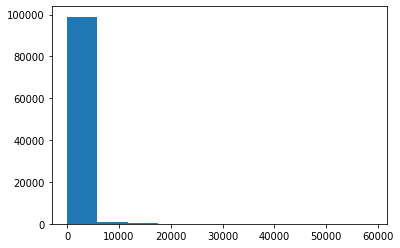

In [9]:
torch.save(sw_model.state_dict(), "sw_a2c_4.pth")
plt.hist(rewards)

In [21]:
max(rewards)

39603.0

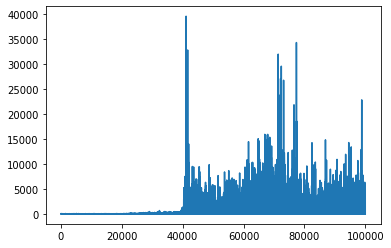

In [22]:
plt.plot(rewards)

In [13]:
sw_model = Model(input_size,action_size)
config = {'gamma' : 0.95,
          'learning_rate' : 0.001,
          'batch_size' : 30,
          'nb_actions' : 2,
          'ENTROPY_COEF_max' : 0,
          'ENTROPY_COEF_min'     : 0,
          'ENTROPY_COEF_delay'  : 200,
          'ENTROPY_COEF_stop' :50000,
          'CRITIC_COEF' :0.5
          
         }
sw_model.load_state_dict(torch.load("sw_a2c_4.pth"))
a2c = actor_critic(config,sw_model)
rewards = a2c.train(swingup,10,print_=True)

Episode  0 , reward :  -10.0
Episode  1 , reward :  -10.0
Episode  2 , reward :  885.0
Episode  3 , reward :  -10.0
Episode  4 , reward :  -10.0
Episode  5 , reward :  124.0
Episode  6 , reward :  -10.0
Episode  7 , reward :  -10.0
Episode  8 , reward :  328.0
Episode  9 , reward :  401.0


In [24]:
swingup.close()


In [ ]:
re